### Import the libraries

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.optim as optim
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
import copy
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.image as mpimg

In [9]:
!pip install seaborn

### Create a csv file to store the image names and their labels.

In [10]:
dir = './fruits-360_dataset/fruits-360/Training'
i=0
headerlist = ['image_name', 'target']
with open('./fruit_train.csv', 'w') as f:
  f.write(headerlist[0] + ',' + headerlist[1] + '\n')
  for folder in os.listdir(dir):
    folder_path = os.path.join(dir, folder)
    for image in os.listdir(folder_path):
      f.write(folder + '/' + image + ',' + str(i) + '\n')
    i+=1
print('Done.')

Done.


In [11]:
df = pd.read_csv('./fruit_train.csv')
df

image_name  target
0        Apple Braeburn/0_100.jpg       0
1      Apple Braeburn/100_100.jpg       0
2      Apple Braeburn/101_100.jpg       0
3      Apple Braeburn/102_100.jpg       0
4      Apple Braeburn/103_100.jpg       0
...                           ...     ...
67687      Watermelon/r_6_100.jpg     130
67688      Watermelon/r_7_100.jpg     130
67689     Watermelon/r_81_100.jpg     130
67690      Watermelon/r_8_100.jpg     130
67691      Watermelon/r_9_100.jpg     130

[67692 rows x 2 columns]

In [5]:
sample_trans = transforms.Compose([
#                                   transforms.Resize((224, 224)),
                                  transforms.ToTensor()
])

### For visualization purpose, I will load the dataset manually to keep track of the labels.

In [6]:
class FruitsDataset(Dataset):

  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_name = self.annotations.iloc[index, 0]  # Quince/r_305_100.jpg
    path = os.path.join(self.root_dir, img_name)
    img = Image.open(path).convert('RGB')
    label = torch.tensor(self.annotations.iloc[index, 1])

    if self.transform:
      img = self.transform(img)

    return (img, label)

In [28]:
dir = './fruits-360_dataset/fruits-360/Training'
csv_file = './fruit_train.csv'
dataset = FruitsDataset(csv_file=csv_file, root_dir=dir, transform=sample_trans)
print(len(dataset))

67692


In [29]:
def histogram(dataset, index, labels_map):
  image, label = dataset[index]
  image = image.numpy().transpose(1,2,0)
  image = image*std.numpy() + mean.numpy()
  plt.figure(figsize=(7, 7))
  plt.subplot(1,2,2)
  plt.title(labels_map[label.item()], size=20)
  plt.imshow(image)
  plt.axis('off')
  histo = plt.subplot(1,2,1)
  histo.set_xlabel('Pixel Intensity')
  histo.set_ylabel('Count')
  colormap = ['g', 'r', 'b', 'y', 'black']
  x = np.random.randint(len(colormap))
  plt.hist(image.flatten(), bins=10, color=colormap[x], alpha=0.5)
  plt.show()

def histograms(dataset, num, labels_map):
  for i in range(num):
    index = np.random.randint(len(dataset))
    histogram(dataset, index, labels_map)

In [30]:
class make_class_names(dict):

  def __init__(self):
    self = dict()

  def add(self, key, value):
    self[key] = value

In [31]:
dir = './fruits-360_dataset/fruits-360/Training'
fruit_names = make_class_names()
i=0
for folder in os.listdir(dir):
  fruit_names.add(i, folder)
  i+=1
print(fruit_names)

{0: 'Apple Braeburn', 1: 'Apple Crimson Snow', 2: 'Apple Golden 1', 3: 'Apple Golden 2', 4: 'Apple Golden 3', 5: 'Apple Granny Smith', 6: 'Apple Pink Lady', 7: 'Apple Red 1', 8: 'Apple Red 2', 9: 'Apple Red 3', 10: 'Apple Red Delicious', 11: 'Apple Red Yellow 1', 12: 'Apple Red Yellow 2', 13: 'Apricot', 14: 'Avocado', 15: 'Avocado ripe', 16: 'Banana', 17: 'Banana Lady Finger', 18: 'Banana Red', 19: 'Beetroot', 20: 'Blueberry', 21: 'Cactus fruit', 22: 'Cantaloupe 1', 23: 'Cantaloupe 2', 24: 'Carambula', 25: 'Cauliflower', 26: 'Cherry 1', 27: 'Cherry 2', 28: 'Cherry Rainier', 29: 'Cherry Wax Black', 30: 'Cherry Wax Red', 31: 'Cherry Wax Yellow', 32: 'Chestnut', 33: 'Clementine', 34: 'Cocos', 35: 'Corn', 36: 'Corn Husk', 37: 'Cucumber Ripe', 38: 'Cucumber Ripe 2', 39: 'Dates', 40: 'Eggplant', 41: 'Fig', 42: 'Ginger Root', 43: 'Granadilla', 44: 'Grape Blue', 45: 'Grape Pink', 46: 'Grape White', 47: 'Grape White 2', 48: 'Grape White 3', 49: 'Grape White 4', 50: 'Grapefruit Pink', 51: 'Grape

### Check to see if the images have been normalized in range(0,1)

In [26]:
fruit_names = {0: 'Apple', 1: 'Apple', 2: 'Apple', 3: 'Apple', 4: 'Apple', 5: 'Apple', 6: 'Apple', 7: 'Apple', 8: 'Apple', 9: 'Apple', 10: 'Apple', 11: 'Apple', 12: 'Apple', 13: 'Apricot', 14: 'Avocado', 15: 'Avocado', 16: 'Banana', 17: 'Banana', 18: 'Banana', 19: 'Beetroot', 20: 'Blueberry', 21: 'Cactus', 22: 'Cantaloupe', 23: 'Cantaloupe', 24: 'Carambula', 25: 'Cauliflower', 26: 'Cherry', 27: 'Cherry', 28: 'Cherry', 29: 'Cherry', 30: 'Cherry', 31: 'Cherry', 32: 'Chestnut', 33: 'Clementine', 34: 'Cocos', 35: 'Corn', 36: 'Corn', 37: 'Cucumber', 38: 'Cucumber', 39: 'Dates', 40: 'Eggplant', 41: 'Fig', 42: 'Ginger', 43: 'Granadilla', 44: 'Grape', 45: 'Grape', 46: 'Grape', 47: 'Grape', 48: 'Grape', 49: 'Grape', 50: 'Grapefruit', 51: 'Grapefruit', 52: 'Guava', 53: 'Hazelnut', 54: 'Huckleberry', 55: 'Persimmon', 56: 'Kiwi', 57: 'Kohlrabi', 58: 'Kumquats', 59: 'Lemon', 60: 'Lemon Meyer', 61: 'Limes', 62: 'Lychee', 63: 'Mandarine', 64: 'Mango', 65: 'Mango Red', 66: 'Mangostan', 67: 'Maracuja', 68: 'Melon Piel de Sapo', 69: 'Mulberry', 70: 'Nectarine', 71: 'Nectarine', 72: 'Nut Forest', 73: 'Pecan Nut', 74: 'Onion', 75: 'Onion', 76: 'Onion', 77: 'Orange', 78: 'Papaya', 79: 'Passion', 80: 'Peach', 81: 'Peach', 82: 'Peach', 83: 'Pear', 84: 'Pear', 85: 'Pear', 86: 'Pear', 87: 'Pear', 88: 'Pear', 89: 'Pear', 90: 'Pear', 91: 'Pear', 92: 'Pepino', 93: 'Pepper', 94: 'Pepper', 95: 'Pepper', 96: 'Pepper', 97: 'Physalis', 98: 'Physalis', 99: 'Pineapple', 100: 'Pineapple', 101: 'Pitahaya', 102: 'Plum', 103: 'Plum', 104: 'Plum', 105: 'Pomegranate', 106: 'Pomelo', 107: 'Potato', 108: 'Potato', 109: 'Potato', 110: 'Potato', 111: 'Quince', 112: 'Rambutan', 113: 'Raspberry', 114: 'Redcurrant', 115: 'Salak', 116: 'Strawberry', 117: 'Strawberry', 118: 'Tamarillo', 119: 'Tangelo', 120: 'Tomato', 121: 'Tomato', 122: 'Tomato', 123: 'Tomato', 124: 'Tomato', 125: 'Tomato', 126: 'Tomato', 127: 'Tomato', 128: 'Tomato', 129: 'Walnut', 130: 'Watermelon'}

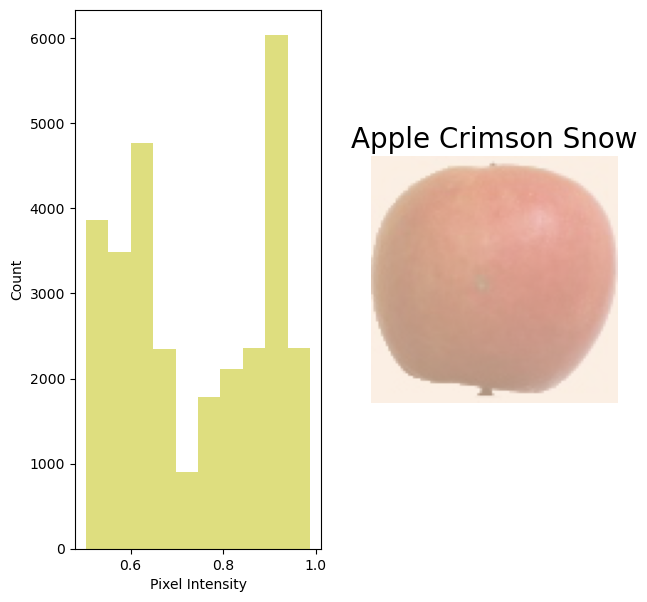

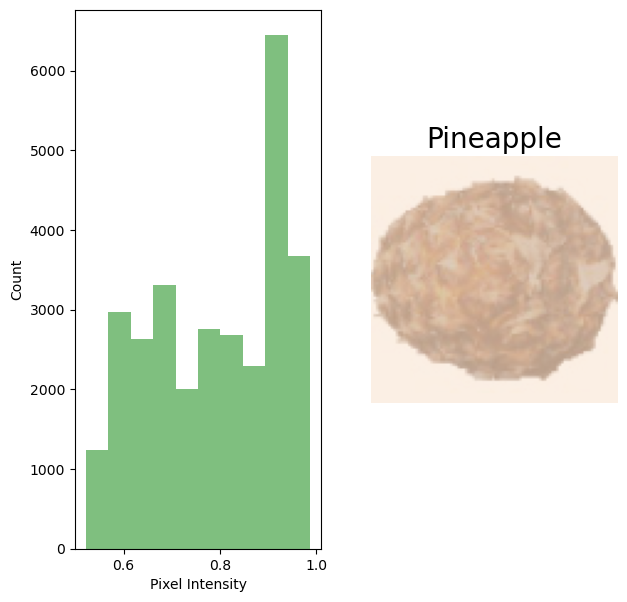

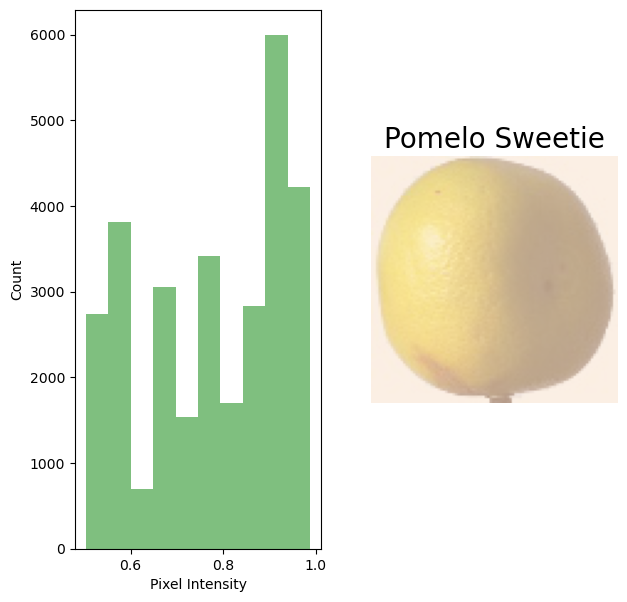

In [34]:
histograms(dataset, 3, fruit_names)
# pixel values are already in range(0,1)

In [33]:
mean = torch.tensor([0.6840, 0.5786, 0.5037])
std = torch.tensor([0.3035, 0.3600, 0.3914])

### Calculate mean and standard deviation for normalization

In [19]:
def cal_normalize(dataset):
  num_channels = 3
  psum = torch.zeros(num_channels)
  psum_sq = torch.zeros(num_channels)

  for image, _ in dataset: # unpack images only
    psum += image.sum(axis=[1, 2]) # torch.Size([3, 100, 100]) C x M x N w.r.t C
    psum_sq += (image**2).sum(axis=[1, 2])

  total_pxl = len(dataset) * 100 * 100

  mean = psum / total_pxl
  var = (psum_sq / total_pxl) - (mean**2)
  std = torch.sqrt(var)

  return mean, std

In [20]:
mean, std = cal_normalize(dataset) # dataset should be original, no resize
print(mean, std)

tensor([0.6840, 0.5786, 0.5037]) tensor([0.3035, 0.3600, 0.3914])


### Visualize the number of classes

In [58]:
dir = './fruits-360_dataset/fruits-360/Training'
dir = './fruit_veg_dataset/validation/'
count_classes = make_class_names()
for folder in os.listdir(dir):
  count=0
  folder_path = os.path.join(dir, folder)
  for image in os.listdir(folder_path):
    count+=1
  count_classes.add(folder, [count])


In [59]:
classes = list(count_classes.keys())
classes

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [60]:
sum = 0
for value in count_classes.values():
    sum += value[0]
sum

351

In [42]:
df1 = pd.DataFrame.from_dict(count_classes)
df1

apple  banana  beetroot  bell pepper  cabbage  capsicum  carrot  \
0     68      75        88           90       92        89      82   

   cauliflower  chilli pepper  corn  ...  pomegranate  potato  raddish  \
0           79             87    87  ...           79      77       81   

   soy beans  spinach  sweetcorn  sweetpotato  tomato  turnip  watermelon  
0         97       97         91           69      92      98          84  

[1 rows x 36 columns]

ValueError: The number of FixedLocator locations (36), usually from a call to set_ticks, does not match the number of ticklabels (131).

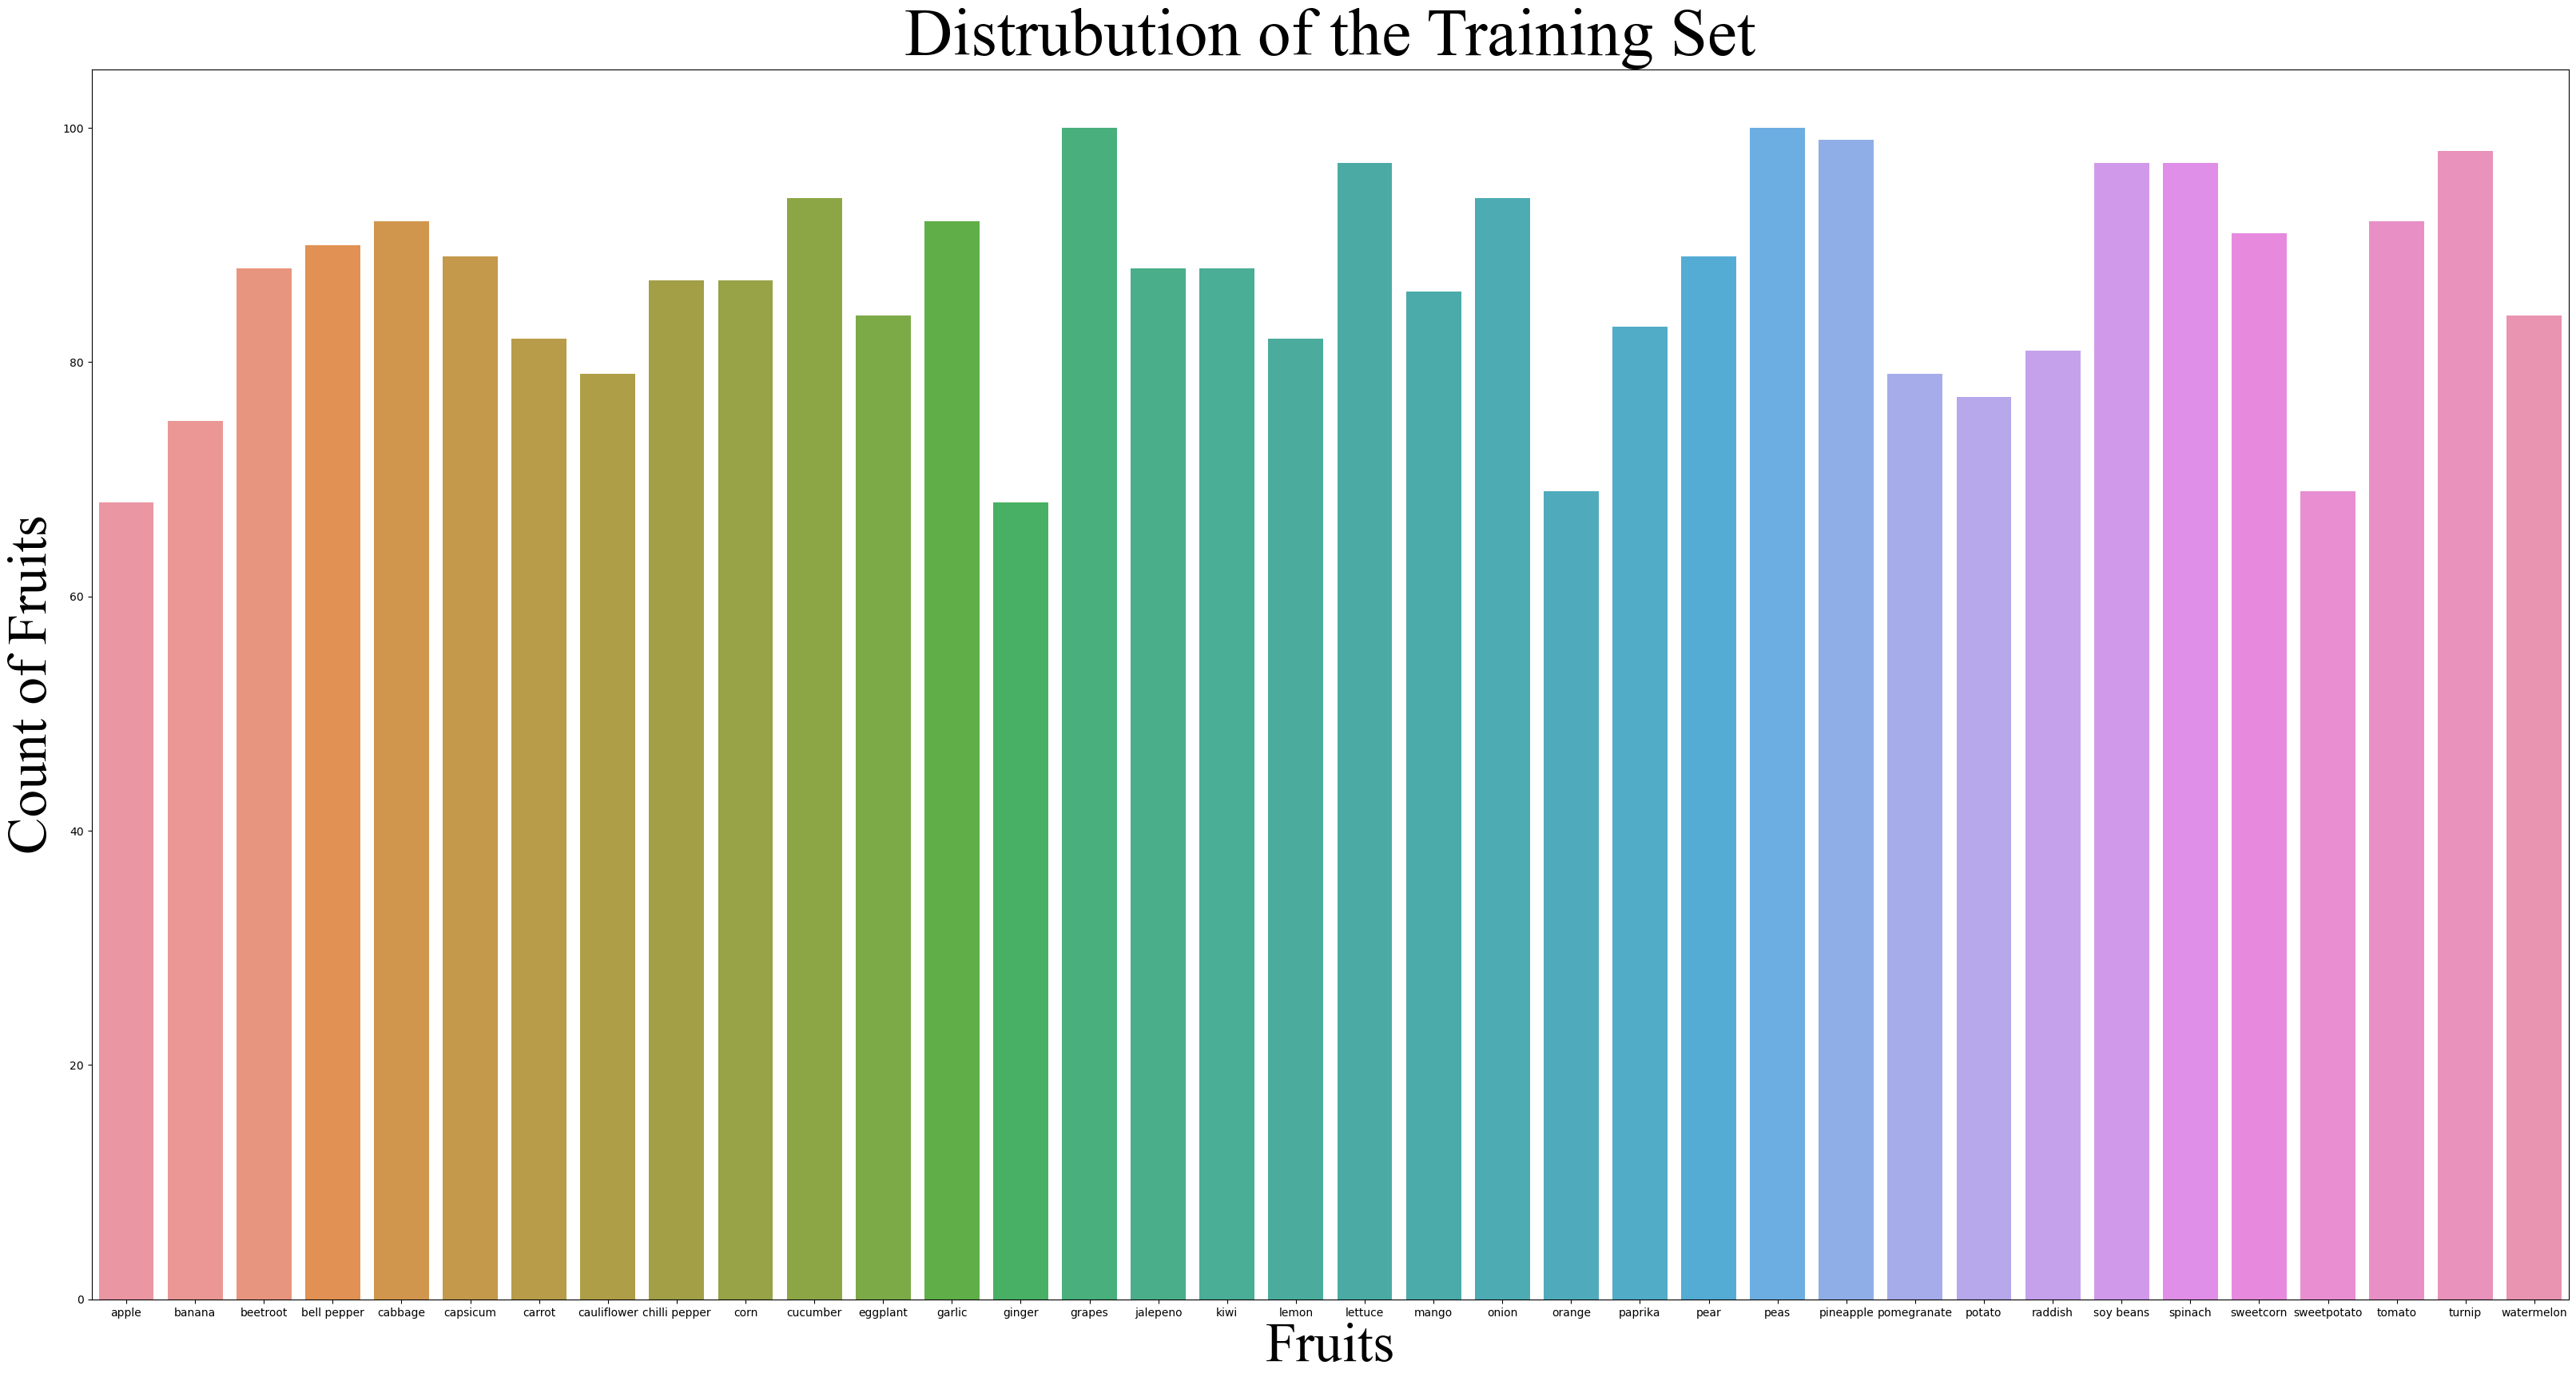

In [36]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size

import seaborn as sn

sn.barplot(data=df1)

index = np.arange(df1.shape[1])
classes = list(fruit_names.values())
font1 = {'family' : 'Times New Roman',}
plt.xlabel('Fruits', fontsize=50, **font1)
plt.ylabel('Count of Fruits', fontsize=50, **font1)
plt.title('Distrubution of the Training Set', fontsize=60, **font1)
plt.xticks(index, classes, fontsize=15, rotation=90, **font1)
plt.yticks(fontsize=40, **font1)

plt.show()

### Visualize images

In [32]:
def show_specific(dataset, labels_map, fruit_name, num, norm=False):

  values = list(labels_map.values())
  this_label = values.index(fruit_name)

  count = 0

  for i in range(len(dataset)):
    image, label = dataset[i]
    if label.item() == this_label:
      image = image.unsqueeze(0)
      mini_batch = image
      count = 1
      break
  
  for i in range(len(dataset)):
    image, label = dataset[i]
    if label.item() == this_label and count <= num:
      image = image.unsqueeze(0)
      mini_batch = torch.cat((mini_batch, image), dim=0)
      count+=1

  plt.figure(figsize=(10, 10))
  loader = DataLoader(dataset=mini_batch, batch_size=num, shuffle=True)
  images = next(iter(loader))
  images = torchvision.utils.make_grid(images)
  images = images.numpy().transpose(1,2,0)
  if norm==False:
      images = images*std.numpy() + mean.numpy()
  plt.axis('off')
  plt.title(fruit_name, size=50)
  plt.imshow(images)

In [33]:
x = np.random.randint(132)
print(x)
name = fruit_names[x]
print(name)

71
Nectarine Flat


### Show a specific fruit with a name and a batch size

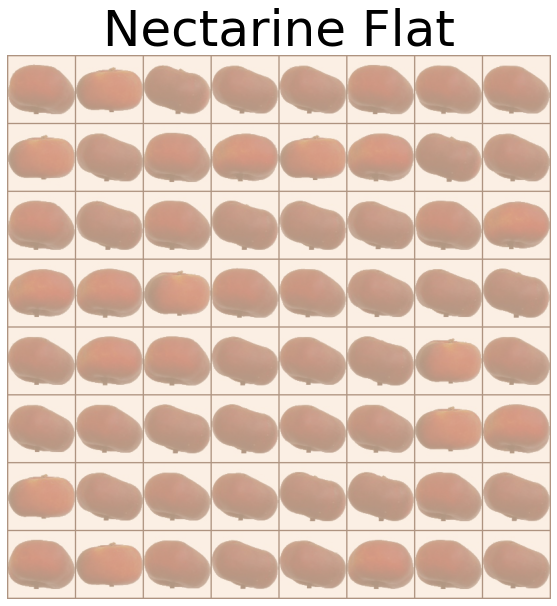

In [34]:
show_specific(dataset, fruit_names, name, 64, norm=False)

In [15]:
train_trans = transforms.Compose([
                                  transforms.Resize((299, 299)),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.RandomVerticalFlip(p=0.5),
                                  transforms.RandomRotation(degrees=(0, 360)),
                                  transforms.RandomPerspective(distortion_scale=0.5),
                                  transforms.RandomAffine(degrees=(30, 70)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
])

val_trans = transforms.Compose([
                                  transforms.Resize((299, 299)),
                                  transforms.RandomRotation(degrees=(0, 360)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
])

In [16]:
dir = './fruits-360_dataset/fruits-360/Training'
csv_file = './fruit_train.csv'
train_dataset = FruitsDataset(csv_file=csv_file, root_dir=dir, transform=train_trans)
print(len(train_dataset))

67692


In [37]:
def show(dataset, labels_map={}, num_rows=0, num_cols=0, mean=[], std=[], 
         transform=False, colormap='gray', color='gray', consecutive='no',
         batch_size=0, clip='no', single='no'):

  plt.figure(figsize=(10, 10))

  if consecutive == 'yes':
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    images, _ = next(iter(loader))
    images = torchvision.utils.make_grid(images)
    images = images.numpy().transpose(1,2,0)
    if clip == 'yes':
      images = np.clip(images, 0, 1)

    if color != 'gray':
      if transform == False:
          # images = images*np.array(std) + np.array(mean)
          images = images*std.numpy() + mean.numpy()

    plt.imshow(images)

  else:

    if single == 'yes':
      num_rows = num_cols = 1
    else:
      num_rows = num_rows
      num_cols = num_cols

    for i in range(num_rows*num_cols):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      image, label = dataset[sample_idx]
      if single!= 'yes':
        plt.subplot(num_rows, num_cols, i+1)

      if color == 'gray':
        image = image.squeeze()
        
        if colormap == 'gray':
          plt.imshow(image, cmap='gray')
        else:
          plt.imshow(image, cmap= colormap)

      else:

        image = image.numpy().transpose(1,2,0)
        if clip == 'yes':
          image = np.clip(image, 0, 1)

        if transform == False:
          image = image*np.array(std) + np.array(mean)

        plt.imshow(image)

      plt.axis('off')      
      plt.title(labels_map[label.item()], size=20) # if label is tensor, .item()
  plt.axis('off')

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


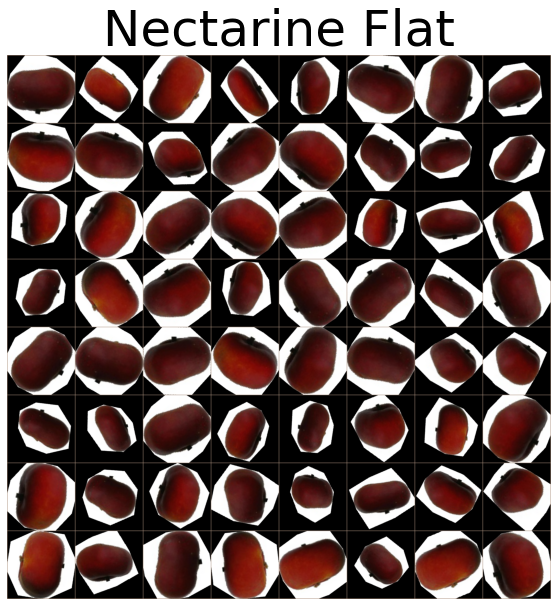

In [38]:
show_specific(train_dataset, fruit_names, name, 64, norm=False)

### Show fruits with labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


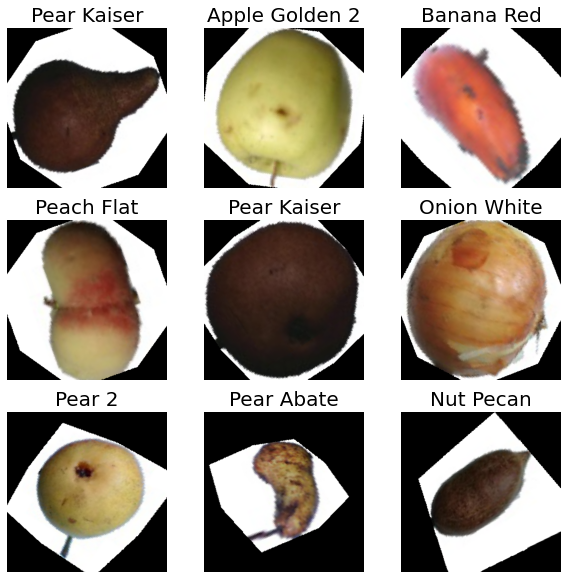

In [39]:
show(train_dataset, fruit_names, 3, 3, mean, std, color='yes')

### Show fruits without labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


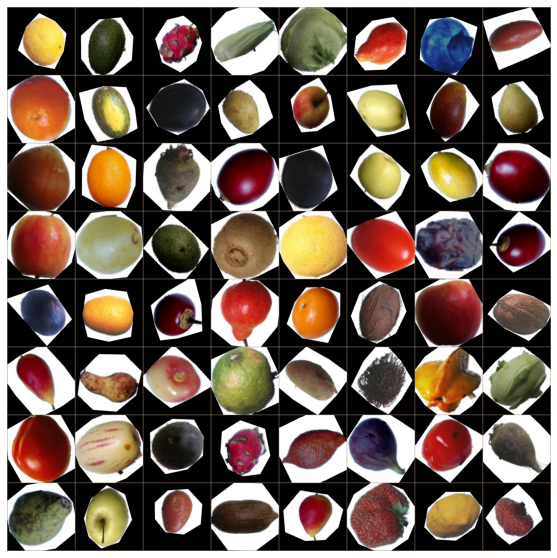

In [40]:
show(train_dataset, mean=mean, std=std, transform=False, consecutive='yes', color='yes', batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


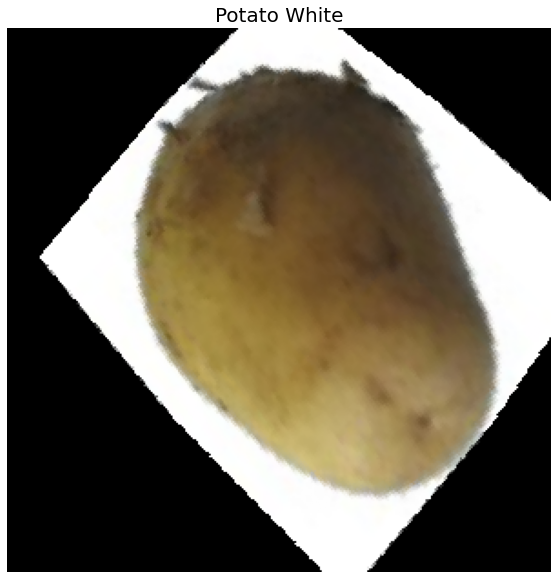

In [41]:
show(train_dataset, fruit_names, mean=mean, std=std, transform=False, color='yes', single='yes')

### Split the data

In [17]:
train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_dataset, lengths=[train_size, val_size])
print(len(train_dataset), len(val_dataset))

54153 13539


### Set up hyper-parameter

In [24]:
num_epochs = 5
begin_epoch = 0
batch_size = 128
learning_rate = 0.01
load_model = False
# load_model_file = '/content/drive/MyDrive/saved_ckpnt/checkpoint.pth'
num_classes = 131

In [25]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

### Load the model

In [33]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './fruits-360_dataset/fruits-360/Training//'
image_datasets = datasets.ImageFolder(data_dir, data_transforms['train'])
dataset_sizes = len(image_datasets)
train_size = int(dataset_sizes * 0.8)
val_size = dataset_sizes - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=image_datasets, lengths=[train_size, val_size])
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=True, num_workers=4)
dataloaders['val'] = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=True, num_workers=4)
print(len(train_dataset), len(val_dataset))
class_names = image_datasets.classes
print(len(class_names))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

54153 13539
131


device(type='cuda', index=0)

In [36]:
type(dataloaders['train'])

torch.utils.data.dataloader.DataLoader

In [35]:
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
for test_images, test_labels in test_loader:  
    sample_image = test_images[0]    # Reshape them according to your needs.
    sample_label = test_labels[0]

KeyboardInterrupt: 

In [ ]:
sample_image,sample_label

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                print(labels)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    print(outputs, labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [44]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [38]:
from torch.optim import lr_scheduler
from torchvision import models
device = "cpu"
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
tensor([ 53,  57, 113,  49])
tensor([[-0.5029,  0.3691],
        [-0.6655,  0.5970],
        [-0.6019, -0.0526],
        [-0.1953,  0.3481]], grad_fn=<AddmmBackward0>) tensor([ 53,  57, 113,  49])


IndexError: Target 53 is out of bounds.

In [55]:
model = torchvision.models.resnet50(pretrained=True)

In [56]:
for param in model.parameters():
  param.requires_grad = False

In [57]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [59]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [60]:
model = model.to(device)

### Set up loss and optimization

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
from torch.optim import lr_scheduler
from torchvision import models
device = "cpu"
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

### Set up training loop

In [51]:
n_iters1 = math.ceil(len(train_dataset) / batch_size)
n_iters2 = math.ceil(len(val_dataset) / batch_size)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
start = time.time()

loss_cache_train = []
acc_cache_train = []
loss_cache_val = []
acc_cache_val = []

for epoch in range(begin_epoch, num_epochs):
    
  model.train()
  start_epoch = time.time()

  running_corrects = 0
  running_loss = 0.0

  for idx1, (images, labels) in enumerate(train_loader):

    images = images.to(device)
    print(labels)
    labels = labels.to(device)
    print(labels)
    y_predicted = model(images)
    print(y_predicted)
    loss = criterion(y_predicted, labels)
#     print(loss1)
#     loss2 = criterion(aux_y_predicted, labels)
#     print(loss2)
#     loss = loss1 + 0.4*loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, index = torch.max(y_predicted, 1)
    running_corrects += torch.sum(index == labels)
    running_loss += loss.item() * images.size(0)

  epoch_loss = running_loss / len(train_dataset)
  epoch_acc = running_corrects / len(train_dataset)

  loss_cache_train.append(epoch_loss)
  acc_cache_train.append(epoch_acc.item())
  
  model.eval()

  running_corrects = 0
  running_loss = 0.0

  for idx2, (images, labels) in enumerate(val_loader):
    
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      
      y_predicted = model(images)
      loss = criterion(y_predicted, labels)

      _, index = torch.max(y_predicted, 1)
      running_corrects += torch.sum(index == labels)
      running_loss += loss.item() * images.size(0)

  epoch_loss_val = running_loss / len(val_dataset)
  epoch_acc_val = running_corrects / len(val_dataset)
    
  is_best = bool(epoch_acc_val.item() > best_acc)
  if is_best:
    best_acc = epoch_acc_val.item()
    best_model_wts = copy.deepcopy(model.state_dict())

  loss_cache_val.append(epoch_loss_val)
  acc_cache_val.append(epoch_acc_val.item())

  end_epoch = time.time()

  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'Step {idx1+1}/{n_iters1}, train Loss = {epoch_loss:.2f},  train Acc = {epoch_acc:.2f}')
  print(f'Step {idx2+1}/{n_iters2}, val loss = {epoch_loss_val:.2f},  val acc = {epoch_acc_val:.2f}')

  epoch_elapse = end_epoch - start_epoch
  print(f'Time spent for this epoch -----> {int(epoch_elapse // 60)}m {int(epoch_elapse % 60)}s')
  print("")

end = time.time()
duration = end - start
print(f'Training completes in {int(duration // 60)}m {int(duration % 60)}s')
print(f'Best val Acc: {best_acc:.4f}')
model.load_state_dict(best_model_wts)

tensor([123,  89,  49,  39,  29,   8,  11,  42,   5,  84,  70, 113,  81, 114,
         85,  40,  68,  70,  55, 116,  62,  83,  99,  52,  78,  29,  52,   7,
         23,  67,  57,  16, 129,  76,  75,  72,   9, 108, 102,  31, 120,  26,
         44,   0,  58,  67, 129,  42,   8, 125,  60,  33,  24,   0,  22,  57,
         36,  41, 116, 130,  46,  10,  74,  33,  60,  61,  91,  25, 125,  59,
        111,  97,  28, 108,  12,  70, 117,  36,  76,  73,  21,  74, 112, 127,
         97,  98,  93,  67, 119,  32,  65,  65,  53, 123,  89,  28,  39,  46,
          1,  91,  22,  69,  18, 111,  93,  84,  29, 100,  80,  47, 122,  44,
          0,  39,  53,  24,  73, 101, 105,  41, 101,  77,  37, 128,  79,  52,
        123,   7])
tensor([123,  89,  49,  39,  29,   8,  11,  42,   5,  84,  70, 113,  81, 114,
         85,  40,  68,  70,  55, 116,  62,  83,  99,  52,  78,  29,  52,   7,
         23,  67,  57,  16, 129,  76,  75,  72,   9, 108, 102,  31, 120,  26,
         44,   0,  58,  67, 129,  42,   8, 12

tensor([ 49,  79,  97,  77,  73,  91,  38,  91,  26,  28,  45,  84,   1,  86,
         61,  86,  93, 115, 123,  57,  97,  19,  99,  15,  23,  82,  79,   8,
         78,  73,  35, 120,  53, 129,   9, 116,  11,   1, 116, 113, 116,  46,
         78, 108,  29,  59,   6,  31,  95,  25,  98,  17,  11,  48,   4, 113,
         34,  20,  23,  72, 129,  89,   1,  98,  75, 128, 117,  54,  85,  44,
         65, 104,  30,  13,  15,  85, 118, 113, 104, 109,  89, 102,  23,  27,
         41, 116,  21,  74,  38,  86,  62,  99,  84,  67,  51,  87, 122,  56,
        121, 124, 129,  81, 129,  87,  59,  83,  30,  24,  62,  77, 110,  56,
         47, 126, 114,  98, 111,  91,  26,  89,  94,  52,  92, 124,  15,   8,
        104,  45])
tensor([ 49,  79,  97,  77,  73,  91,  38,  91,  26,  28,  45,  84,   1,  86,
         61,  86,  93, 115, 123,  57,  97,  19,  99,  15,  23,  82,  79,   8,
         78,  73,  35, 120,  53, 129,   9, 116,  11,   1, 116, 113, 116,  46,
         78, 108,  29,  59,   6,  31,  95,  2

tensor([125,  87,  60, 121,  55,  78, 105, 129,  63,  36, 126,  43,  11,  52,
         30,  84,  81,  25,  28,  94,  32,  30,  59, 128, 119, 107,  71,  99,
         83,  38,  42, 119,  56, 107,  92,  74,  88,  13,  77,  68,  40,  22,
         44,  41,  26, 102,  47,  81, 126,  15, 122,  17,  75,  84,  38, 122,
        104,  43,  78,  16,   2, 110, 104,  86,  59,  81,  97,  97,  20,  57,
         79,  25,  21,  71,  69,  58,  10,  83,  93,   4,  88,  72,  50, 116,
        128,   1, 129,  59,  93,  10,  66,  49,  68,   5,  54, 130,  15,  96,
         16,  16,   4, 114,  20,  58, 109,   6,  59, 108,  35,  97,  57,   7,
         55,  98,  15, 113,  70,  90,  68,  82,  69,  44,  30,  59,  91,  73,
        121,  19])
tensor([125,  87,  60, 121,  55,  78, 105, 129,  63,  36, 126,  43,  11,  52,
         30,  84,  81,  25,  28,  94,  32,  30,  59, 128, 119, 107,  71,  99,
         83,  38,  42, 119,  56, 107,  92,  74,  88,  13,  77,  68,  40,  22,
         44,  41,  26, 102,  47,  81, 126,  1

tensor([ 95, 118, 118,  54, 107,  59,  18,  23,  15, 115, 107,   2,  66,  48,
         28,  88, 120, 122,  68,  58,  60, 109, 101, 115,  15,  91,  16, 114,
         29,  59, 110,  12,  27,   9,  95,  97, 114, 109,   3,  85,  30,  57,
         79, 106,  21, 121,  82, 127, 122,  26,  61,  29, 109,  74, 128,  49,
          0,  81,  88, 127,  33, 112,  26,  78,  28,  70,  55,  67,  23,  65,
         94,  85, 108,  89,  44,  32,   7, 100,  12,  73, 122,  12, 104,  74,
         84,  29,  55,  89, 122, 106,  28,  78,  90,   7,  19,  96,  39,  27,
         85,  37,  91,   4, 118,   0, 126,  53, 102,  44, 100,  45,  77,  60,
        111, 108,  43,  74,  45,  20,   3,  51, 111,  19,  83,  53,   8,  13,
         92,  40])
tensor([ 95, 118, 118,  54, 107,  59,  18,  23,  15, 115, 107,   2,  66,  48,
         28,  88, 120, 122,  68,  58,  60, 109, 101, 115,  15,  91,  16, 114,
         29,  59, 110,  12,  27,   9,  95,  97, 114, 109,   3,  85,  30,  57,
         79, 106,  21, 121,  82, 127, 122,  2

tensor([ 51,  25,  39,  90,  90,  46,  49,  13,  41,   0, 109, 110,  42,  41,
         21,  74, 120,   7, 121,  94,   3,  70,  96,  22,  13,  93, 129, 117,
        123, 119,  91, 103,  80,  78,  89,  36,  26,  28,  24,  84,  49,  51,
         93, 129,  40, 116,  73,  99, 102,  86,  90, 122,  33,   4,   6,   0,
         40,  12, 120,  91,  78,  15,  36,  57,  69,  34,  85, 125,  83,  89,
          2,  53,  42,  27,  44,  94,  22,  45,  22,  91, 115,  28,  67,  42,
         39,  86, 129, 116,  95,  60,  96,  99, 106, 117,  64,  51,  77,  40,
        113,  58,  90, 119, 113, 103,  48,   9,  84,  73,  51,  68,  60,  28,
        126,  81,  73, 117,  21, 123,  95,  30,  44,  94,  52,  49, 117, 106,
         12,  69])
tensor([ 51,  25,  39,  90,  90,  46,  49,  13,  41,   0, 109, 110,  42,  41,
         21,  74, 120,   7, 121,  94,   3,  70,  96,  22,  13,  93, 129, 117,
        123, 119,  91, 103,  80,  78,  89,  36,  26,  28,  24,  84,  49,  51,
         93, 129,  40, 116,  73,  99, 102,  8

tensor([ 61,  85, 101,   8,  23,   6,  18,  64,  65,  22, 130, 117, 120,  90,
          9,  42,  40,  28,  56, 129,  32, 128,  99, 105,  58, 111, 128,  27,
        114,  37,  89,  57,  79, 120,  70,  25,  20, 109,  24,  96,  27,  27,
         12,  45,  83,  87,  76, 120,  57,  70,   9,  31,  80,  37, 101, 130,
         93, 100, 115,   5, 125,  91,  11,  23,  42,  13,  31,  42,  13,  70,
         55,  47, 127,  46,  91,  36,  39,  69,  87,  80, 111, 119, 104,  74,
         58,  10,  15,  26,  70,  61,  46,   5,  96,  33,  22, 104, 109, 121,
         10,   0,  96,  94, 113,  21,  75,  87,  59,  41,  25,  36,  64,  11,
         92,   6, 112,  79,   6,  65,  61, 109,  22, 100, 123,  61,  65,  42,
         96, 104])
tensor([ 61,  85, 101,   8,  23,   6,  18,  64,  65,  22, 130, 117, 120,  90,
          9,  42,  40,  28,  56, 129,  32, 128,  99, 105,  58, 111, 128,  27,
        114,  37,  89,  57,  79, 120,  70,  25,  20, 109,  24,  96,  27,  27,
         12,  45,  83,  87,  76, 120,  57,  7

tensor([ 78,  45,  90, 113,  39,  60, 129,  60,  59, 100,  83,  23, 124,  31,
          1,  47,   7,  31, 114,  95, 118,  40,  77,  91,  70,  36,  49,  40,
         53,  71, 110,  49,  51,  12,   0,  51,  51,  10, 113,  86,  88,  39,
        104,  70,  88,  45,  59,  28, 119,  71,  90, 104,  82,  32,  90, 124,
         35,  22,  35,  34,  96, 123, 114,  12, 108,  51,  65,  20,  98,  43,
         47,  48,  13,  26,  17,  43,  82,  97, 102,  81,  41, 120,  41, 109,
        105,  86, 123, 118, 101,  49,  91,  26,  88,  38,  33,  17, 121,  24,
        107,  40,  28,  67,  61, 104,  43,  40,  87,  86,  63,  76, 112,  42,
         81, 114,  45,  68,  90, 112, 116,  32, 104,  43,  96,  72,  11,  81,
        107,  34])
tensor([ 78,  45,  90, 113,  39,  60, 129,  60,  59, 100,  83,  23, 124,  31,
          1,  47,   7,  31, 114,  95, 118,  40,  77,  91,  70,  36,  49,  40,
         53,  71, 110,  49,  51,  12,   0,  51,  51,  10, 113,  86,  88,  39,
        104,  70,  88,  45,  59,  28, 119,  7

tensor([ 35,   8,  15,  43,  89,  68, 119,  98,  24,  61,  81,  96,  49, 124,
          8,  78,  28,  61, 104,  95, 120,  62, 127, 100,  39,  68,  90,  23,
        108,  52,  94, 111,  60,   1,  84,  61,  39,  11,  38,  64,  61,  37,
        121,  54,  33,   8,  75,  70,  14,  98,  17,  26,   0,   9, 102,  84,
         73,  99, 127,  70,  49,  84, 103,  94,  26,  31, 121,  29,  31,  32,
         45,  10,  94,  43,  25,  53,  21,  65,  22,  83,  35, 100,  15,  65,
          3,   8, 128,  36,  58,  25, 103,  75,  32,  95,  88,   6,   0,  62,
        130, 103,  28,  77,  92,  34,  57, 107, 129, 107, 109,  45,  96, 109,
         44,  91, 123,  81,  46, 103,  50,  44, 129,  59, 110,  85,  55,  82,
         12,  54])
tensor([ 35,   8,  15,  43,  89,  68, 119,  98,  24,  61,  81,  96,  49, 124,
          8,  78,  28,  61, 104,  95, 120,  62, 127, 100,  39,  68,  90,  23,
        108,  52,  94, 111,  60,   1,  84,  61,  39,  11,  38,  64,  61,  37,
        121,  54,  33,   8,  75,  70,  14,  9

tensor([ 30,  41,  23,  33,  82,  97,   2,  10,  49, 119,  48,  70,  11,  52,
        104,  48,  35,  45,  67,  45,   6,  38,  73,  15, 111, 110,   1,   4,
         97,  49, 100,  27,  61,  97,  89,   9,  73, 120,  89,  18,  81, 113,
         27,  25, 116, 110,  91,  32,  74,   8,  68, 104,  68,  25, 120,  64,
        117, 118, 106,  55,  33,  68, 117, 110,  97,  11,   3,  89,  36, 124,
         91,  75,  43, 129,  51, 102,  61,  12, 122,   6,  73,   4,  44,  41,
         89,  24,  62,  46,  38,   5,  28,  73,  82,  40,  70, 110, 116,  51,
        111, 128,   8,  85, 122,  11, 112, 104,  69,  11, 118, 110,  83,  67,
        125,  28,   4, 122, 104,   1,  86,  80,   7,  83,  27,  95,  54,  34,
          2,  61])
tensor([ 30,  41,  23,  33,  82,  97,   2,  10,  49, 119,  48,  70,  11,  52,
        104,  48,  35,  45,  67,  45,   6,  38,  73,  15, 111, 110,   1,   4,
         97,  49, 100,  27,  61,  97,  89,   9,  73, 120,  89,  18,  81, 113,
         27,  25, 116, 110,  91,  32,  74,   

tensor([ 68,  31,  70,  13,  90,   6,  27,   2,  44,  27,  59,  58,  26, 102,
         73,  90, 108, 104, 129,  24,  26,  17,  15,  37, 106,  43,  77,  66,
         30,  59,  54,  37,  26,   6,  85, 125,  21,  85,  95, 126,  82,  21,
         96,  23, 119,  69,  82,  98,  83,  95,  75,  92,  78, 101,  42,  44,
         23, 115, 105, 106, 111,  79,  95,  84,  58,  34,  34, 100,   8,  35,
         63,  97,  61, 117,  33,  45,  81,  27,  52,  25,   6,  78,  12,  47,
         56,  36,  36,  59,  48,  70,  90,  12,  20,  18, 122,  72,  10,  69,
         34,  75,   7,  12,  58,  88,   9,  75,  32, 117,  44,  77,  22, 102,
        125,  12,  59,  84,  44,  11,  51,   5,  60,   6,  46, 121,  68,  95,
         90,  80])
tensor([ 68,  31,  70,  13,  90,   6,  27,   2,  44,  27,  59,  58,  26, 102,
         73,  90, 108, 104, 129,  24,  26,  17,  15,  37, 106,  43,  77,  66,
         30,  59,  54,  37,  26,   6,  85, 125,  21,  85,  95, 126,  82,  21,
         96,  23, 119,  69,  82,  98,  83,  9

tensor([  1, 117,  21,  30,  56,  25, 118, 105,  62,  41,  29,   9, 125,  40,
         34,  68,  13,  90,  19,  72,  96,  67,   3, 128,  57, 127,  69,  59,
         49,  38,  48,  99,   3,   2,  44,  25,  33,  33,  26,  16, 112,  72,
         21,  50,  63, 103, 104, 126,  79,  68,  81,  31,  61,  42, 112,  53,
         89,  46,   2,   3,  30,  17,  21,  27, 125,  87,  89,  97,   6,  39,
        112,  57, 103,  20,  38, 115,  72, 118,  40,   0,  24, 101,  22,  17,
          5,  67,  47,  15,   0,  92,  84,  95,  84,  34,  26,  45,  77,   2,
         69,  85, 127,  23,  25,  59,  47,  61,  55, 112,  32,  97,  64,  68,
         83, 105,  70,  59,  90,  69,  18,  69,  36,   5,  93,  26,  80,  76,
         62,  54])
tensor([  1, 117,  21,  30,  56,  25, 118, 105,  62,  41,  29,   9, 125,  40,
         34,  68,  13,  90,  19,  72,  96,  67,   3, 128,  57, 127,  69,  59,
         49,  38,  48,  99,   3,   2,  44,  25,  33,  33,  26,  16, 112,  72,
         21,  50,  63, 103, 104, 126,  79,  6

tensor([ 56, 110,  68,  39,  59,  29,  43,  51,  49,  48,  94,  29,  65,  90,
        125,  42, 129, 127,  61,  42,  58,  16,  91,  40,  83,  89,  76,  16,
         99, 110,  22, 117,  62, 116, 116,  94,  48, 125, 111, 128,  38, 116,
         11,  25,  25,  28, 129,  56,  39,  42,  50,   8, 101,  96,  44,   7,
        117,  35,  93,   2,  88,   7,   2,  18,  44,  37,  95,  11,  71,  28,
         93,  79,   8,  60,  71,  27, 124,  16,  55, 103, 124,  31,  77,   4,
         35, 101,  28,  86,  83,  81,  72,  38,  51,  49,  71, 115,  16, 120,
        125,  25,  63, 123,  64,  80,  10,  15, 104,  44,  15,  65,  48, 114,
        130,  20,  91,  25,  91, 124,  86,  60,  38,   4, 124, 115,  18, 123,
         17,  56])
tensor([ 56, 110,  68,  39,  59,  29,  43,  51,  49,  48,  94,  29,  65,  90,
        125,  42, 129, 127,  61,  42,  58,  16,  91,  40,  83,  89,  76,  16,
         99, 110,  22, 117,  62, 116, 116,  94,  48, 125, 111, 128,  38, 116,
         11,  25,  25,  28, 129,  56,  39,  4

tensor([ 66, 103, 109,  57,  59, 107,  54,  26,  33,  79,  56,  44,  59,  47,
         96,  90, 121, 120,  21, 124,  62, 122,  57, 119, 112,  27,  80,   8,
         48, 114,  33,  50, 120,  15,  91, 130, 123,  15, 109,  41,   2,  27,
          5, 104,   8,  82,  30,  58,  89,  51, 109,  76,  71,  23,  64, 130,
         49,  58,   2, 103,  34,  91, 101,  60,  88,  25,  38,  56,  39,  88,
         80,   0,  85, 127,  50,  22,   0,  33,  62,  20,  11, 120,  78, 130,
         16,  87, 124, 129,  84,  42,  15,  22,  52, 116,  81,   4,  25, 126,
         87, 115, 120,  71, 128,  72,  71,  94,  59, 115,  67,  28,  23,  93,
         50,  18,  22,   9, 129,  81,  69,  92, 124,   6,  80,  72, 115,  90,
         68,  39])
tensor([ 66, 103, 109,  57,  59, 107,  54,  26,  33,  79,  56,  44,  59,  47,
         96,  90, 121, 120,  21, 124,  62, 122,  57, 119, 112,  27,  80,   8,
         48, 114,  33,  50, 120,  15,  91, 130, 123,  15, 109,  41,   2,  27,
          5, 104,   8,  82,  30,  58,  89,  5

tensor([ 89,  61,  84, 105,  70,  34,  41,  82, 130,  38, 129,  63,  20,  63,
         32,  43,   4,  13,  22,  41, 101,  73,  88, 104, 114, 117,  48, 119,
         78,  98, 119,  32,  88,  97,  14,  64,  45,  74,  94,  12,  91,   3,
         12,  86,  56,  87,  82,  16,  85,  12,  43,  62,  44, 127,  61, 120,
        122,  37,  72,  25,  71,   7,  89,  91,  76,  55,  39,  84,  23,   5,
         94, 107,  17, 100,  93, 104, 121,   9,  81,  58,  57,   9,  53,  40,
         15,  65,  78,  30, 107,  50,  29,  23,  57,  33,  74,  48,  63,  57,
        101, 106,  13,  28,  41,  92, 121,  94,  68, 125,  99,  17, 122, 117,
         48,  70,  48, 102,   1, 100, 111,  22,  69,  56,  42,  17,  90,  95,
        107,  14])
tensor([ 89,  61,  84, 105,  70,  34,  41,  82, 130,  38, 129,  63,  20,  63,
         32,  43,   4,  13,  22,  41, 101,  73,  88, 104, 114, 117,  48, 119,
         78,  98, 119,  32,  88,  97,  14,  64,  45,  74,  94,  12,  91,   3,
         12,  86,  56,  87,  82,  16,  85,  1

tensor([ 23,  26, 125,  37,   9,  83,  12,  54, 122,  34, 113, 116,  82,  33,
         17,  29, 127,  52,  12, 130,  56, 130, 129,  43,  63,  80, 122,  81,
         69,  54,  51,  23,  92,  60,  47, 121,  79,  79,  35,   0,  92, 104,
         60, 128,   6,  96,  36,  55,  15,  66,  68, 103,  12, 115,  72,  72,
         90,  73,  15,  41,   0,  27,  46,   8,  76,  24,  82,   4, 122,  96,
         81,   3,  64, 129, 124,  28,   3,  76, 104,  27, 125,  83,  21,  14,
         55, 126,  12,  60, 101, 121, 103,  49,   9, 117,  24, 101,  43,  66,
          7, 107, 113,  85, 101,  16,  85,   0,  67,  32,  55,  14, 108,  59,
         40, 118,  37, 117, 110,  20,  70,  42,  49, 115, 107,  98,  99,  41,
        110,  56])
tensor([ 23,  26, 125,  37,   9,  83,  12,  54, 122,  34, 113, 116,  82,  33,
         17,  29, 127,  52,  12, 130,  56, 130, 129,  43,  63,  80, 122,  81,
         69,  54,  51,  23,  92,  60,  47, 121,  79,  79,  35,   0,  92, 104,
         60, 128,   6,  96,  36,  55,  15,  6

tensor([119,  64,  42,  69,  90,  49,  26,  23,  32,  82,   0,  68,  94,  54,
         84,  83,  62,  12,  82,  32,  91,  25, 104, 120, 121, 111,  23, 126,
         27,  89,  85,  36,  60,  44,  39,  66,  27, 122,  48, 122,  54,  95,
         28,  64, 107,  43,  81,  74,  16,  49,   5,  68,  85, 130,  90,  13,
         61,  12,  14,  81, 105,  61, 121,  16, 127,  37,  36,  29,  75,  86,
          9,  16, 119,   3, 112,  41,  42, 116,  24,  85,  74,  94, 110,  26,
         17,  51,  67, 100,  82,   2,  56,  26,  74,  63,  61,  71, 100,  50,
         38, 120, 122,  82,  22,  26,  68,  55,  91,  13,   5,  95,  47, 115,
         89,  71,  73,  84,  18, 108,  28,  63, 111,  88,  91, 122,  47,  39,
         79,  19])
tensor([119,  64,  42,  69,  90,  49,  26,  23,  32,  82,   0,  68,  94,  54,
         84,  83,  62,  12,  82,  32,  91,  25, 104, 120, 121, 111,  23, 126,
         27,  89,  85,  36,  60,  44,  39,  66,  27, 122,  48, 122,  54,  95,
         28,  64, 107,  43,  81,  74,  16,  4

tensor([ 12, 115, 106,  41,  16,   1,  14,   5,   9,  86,  75,  44, 116,  34,
         53,  44,  35, 126,  82, 110,  48,  78,  84,  99,  57,  54, 121,  54,
         94, 128, 112, 111,   1,  11,  12,  86,  30,  17,  15, 112, 106,  64,
         25, 117, 120,  90,  33,  39,  39,  22, 112,  78,  29,  11,  12, 117,
        128, 125,  44,  61,  89,  84, 129,  81,  48,  47,  75,  12,  10, 115,
         67, 115, 102,  80, 112,  11, 124,   6,  50,  47,  86,  81, 118, 129,
         33,   5,  68,  95,  91, 123,  13,  99,   7,  60,  54,   5,  85,  78,
         34,  11,  53, 123,  91,  54,  77, 121, 125,  20,  98,  61,  31,  82,
        114,  31,  18, 122, 117, 127,  65,   0, 100, 120,   8,  74,   6,   2,
         54, 103])
tensor([ 12, 115, 106,  41,  16,   1,  14,   5,   9,  86,  75,  44, 116,  34,
         53,  44,  35, 126,  82, 110,  48,  78,  84,  99,  57,  54, 121,  54,
         94, 128, 112, 111,   1,  11,  12,  86,  30,  17,  15, 112, 106,  64,
         25, 117, 120,  90,  33,  39,  39,  2

tensor([ 63,  56,  50, 103,  37,  12,  97,  45,  96,  28,  78,  92,  45,  58,
         84,  56,  29,  97, 116, 123,  92,  78, 112, 100,  33,  27,  53,  68,
         27, 116,  85, 105, 130,  16,  47,  59,  56,  90,  83,  63,  53,  52,
         84,  98,  35, 104,  55,  56,  96, 123,  17, 129, 111,  81,  24, 129,
         16,  22,  99,  79, 105, 116,  25,  52,  10,  66,  13,  26, 120,  72,
         90,  93,  48,  11,  67, 112,  28,  13,  35, 125,  60,  59,  86,  40,
          7,  80,   1,  61, 121,  29,  25, 118,  52,  94,  70,  65,  64,  41,
        122, 121,  32,  30,   0,  84, 113,  48,  14, 115,  49,  33,  76, 117,
        130,  89,  31,  32,  72,  11,  47,  50, 100,  11, 114,  76,  72,  44,
         22,   2])
tensor([ 63,  56,  50, 103,  37,  12,  97,  45,  96,  28,  78,  92,  45,  58,
         84,  56,  29,  97, 116, 123,  92,  78, 112, 100,  33,  27,  53,  68,
         27, 116,  85, 105, 130,  16,  47,  59,  56,  90,  83,  63,  53,  52,
         84,  98,  35, 104,  55,  56,  96, 12

tensor([ 80,  15,  10, 119,  45, 118,  77,  73,  11, 129,  47, 129, 115,  55,
          2,  95,  12, 102,  18,   2, 128,  43, 123,  79,  25,  95,  62, 128,
         48, 129,  41,  66,  25,  52,  65,  15,  18,  99,  97,  89,  39, 129,
         80,  94,   0,  23,  69,  33,  16,  81, 126, 130,  27,  52,  25,   7,
        122,  91, 101,  56,  70,  97,  37,  47,   4,  26,  68,  70,  62, 104,
        128, 117,  92,  74,  28,   0,  29,  94,  54, 118,  99,   7,  28,  17,
         84,  38, 117,  91,  72,  85,  98,  47, 102,  44,  27, 108,  89, 101,
         50,  96,  12,  49, 105,   8,  21, 118,   2, 111,  82,  96,  74,  39,
         86, 110,  80, 106,  44,  87,  96,  57,  69,  96, 108,  29,  89,   2,
         91,  18])
tensor([ 80,  15,  10, 119,  45, 118,  77,  73,  11, 129,  47, 129, 115,  55,
          2,  95,  12, 102,  18,   2, 128,  43, 123,  79,  25,  95,  62, 128,
         48, 129,  41,  66,  25,  52,  65,  15,  18,  99,  97,  89,  39, 129,
         80,  94,   0,  23,  69,  33,  16,  8

tensor([101,  45, 129,  90,  28, 129,  10,   5,  44,  58, 119,  45,  65, 112,
         72,   2,  39,  18,  63, 130,  47,  90,  14,  22,   8, 106,   7,  94,
        108,  87,  38, 105,   9,  97, 129,  53,  82, 103,  29,  28,  20, 125,
         50, 122,  98, 112,  13,  29,  18,  19, 106, 102,  86, 115,  83, 104,
          7,  72,  11,  75,  15,  59,  24,  34, 124,  84, 101,   1,  81,  64,
         93,  58,  29,  92,  93,  30, 111,  46,   0,  82, 120,  70,   5,  47,
        107,   3,   2,  71,  58,   1,  37,   6,  48, 103,  48,  98,  35,  51,
          3, 118,  74,  43,   9,  59,  71,  67,  59,  62,  84, 108,  25,  55,
          1,   8,  43,  68,  64, 113,  72,  87,  75, 118,  81,  11,  70, 117,
          7, 127])
tensor([101,  45, 129,  90,  28, 129,  10,   5,  44,  58, 119,  45,  65, 112,
         72,   2,  39,  18,  63, 130,  47,  90,  14,  22,   8, 106,   7,  94,
        108,  87,  38, 105,   9,  97, 129,  53,  82, 103,  29,  28,  20, 125,
         50, 122,  98, 112,  13,  29,  18,  1

tensor([  7,  25,  81,  55, 123,  91,  46,  11,  91, 125, 125,  26,  82, 126,
          7,  84,  50,  13,  59,  89, 107,  99,  51,   2,  11, 110,  57, 121,
         74,  26,  40, 116,  39,  94, 112,   6,  80,  50,  14, 126,  13,  78,
         28,  92,  96, 104,   7,  45,  44,  43, 105,  73,  96, 118,   2, 110,
        122,   2,  22,  77, 122,  45,  93, 117,  34,  61,  52,  80,  90, 112,
         88,  94,   7,  44,  33,  85, 116,  75,  88, 103,  82,  79,  52,  72,
         20,  26,  12, 122,  27, 122,  49,  16,  40,   6, 112,  67,  65,  56,
        107,  74,  89, 122,  68,  68,  41,  78,  87,   8,  29,  87,  76,  43,
         96,   4,  15,  74,  74,  29,  21,  70, 111,  44,   0, 108, 127,  98,
         91, 125])
tensor([  7,  25,  81,  55, 123,  91,  46,  11,  91, 125, 125,  26,  82, 126,
          7,  84,  50,  13,  59,  89, 107,  99,  51,   2,  11, 110,  57, 121,
         74,  26,  40, 116,  39,  94, 112,   6,  80,  50,  14, 126,  13,  78,
         28,  92,  96, 104,   7,  45,  44,  4

tensor([111,  70,  16, 124,  38, 117,  21,  90, 114,  83,  10,  98,  40, 104,
         92, 117,  85,  27, 100,  23, 109, 127,  62,  12,  51, 117,   2,  62,
         71,  49,  10,  68,  84,  17, 130,  28,  19,  16,  44, 108,  59,  97,
         51,  68,  62, 125,  51,  90,  37,  73,  11,  45,  61,  15,  68, 105,
        102,  46,  76,  69,  21,  48,  59,  97, 110,   5,  90,  89,   9,  63,
        123,   3,  19,   8,  87,  17,  17, 117,  12, 125, 120, 109,  23,  52,
         13, 102, 128,  92, 100,  27, 114,   6, 102,  71,  44, 122,   6,  72,
         58,  44, 123,   4,   0,  23,  55,  83,  18, 116, 100,  20,  77,  34,
         33,  77, 103,  23,  31,   5,  70,  41,  78,  21,  94, 120,  63,  27,
        104,  95])
tensor([111,  70,  16, 124,  38, 117,  21,  90, 114,  83,  10,  98,  40, 104,
         92, 117,  85,  27, 100,  23, 109, 127,  62,  12,  51, 117,   2,  62,
         71,  49,  10,  68,  84,  17, 130,  28,  19,  16,  44, 108,  59,  97,
         51,  68,  62, 125,  51,  90,  37,  7

tensor([ 21,  91, 114,  91, 129,  66,  21,  62,  59,  51,  42,  72,  36, 109,
         95, 106, 124,  25,   6,  73,  36,  65,  83,   2,  87, 118,  84, 102,
         62, 113,  26,  13, 130,  51,  60, 126,  82,  83,  22,   7,  55, 117,
        115,  26,  14,  93,  55, 119, 119,  30,  44,  81,  71, 122,  49,  93,
        100, 106,  13,  74, 119,  88,  60,  80,  10,  33,  13,  34,   7, 128,
        114,  76,  31,  59, 111,  28,  18,  16,  43,  12,  99,  59,  76,  94,
         48,  44,  23,  26, 125, 111,  77,  68,  68, 122,  28,  59,   6,  54,
         69,   2,  65,  56, 130,  98,   7,  62,  94,  47,  82,  76,  94,  99,
         41, 112,  80,  26, 101,  72,  81, 122, 128,  17,  38,  32, 111,  24,
         74,  30])
tensor([ 21,  91, 114,  91, 129,  66,  21,  62,  59,  51,  42,  72,  36, 109,
         95, 106, 124,  25,   6,  73,  36,  65,  83,   2,  87, 118,  84, 102,
         62, 113,  26,  13, 130,  51,  60, 126,  82,  83,  22,   7,  55, 117,
        115,  26,  14,  93,  55, 119, 119,  3

tensor([ 48,  44,  71,  20,  20, 129,  41,  25,  23,  60,  11,  14,  73, 118,
        118, 126, 117,   4,  61, 117, 113, 130,  53,  96,  66, 125,  52,  32,
         55,  61,  31, 107, 100,  73,  53,  79,  62,  38,  92,  42,   9,  61,
         51,  47,  86, 127,  49,  37,  92,  38,  22,  46,  33,  84,  32,  18,
        103,  16,  92,   6,  54,  74,  24, 117,   5,  74,  40,  50,  99,  91,
         93, 112,  69,  76, 117,  34,  63,  17,  26, 127,  42,  22,  31,  98,
        108,  65,  73,  15,  92,  89,  82, 121,  72,  70, 112,  31, 123,  30,
        125,  25, 117, 109, 112, 108,  97,  86,  60,   1, 129, 118,  26,  58,
         61,  40,  77,  24,  97,  84,  67,  13,  59,  12,  89, 129,  84, 124,
        124,  97])
tensor([ 48,  44,  71,  20,  20, 129,  41,  25,  23,  60,  11,  14,  73, 118,
        118, 126, 117,   4,  61, 117, 113, 130,  53,  96,  66, 125,  52,  32,
         55,  61,  31, 107, 100,  73,  53,  79,  62,  38,  92,  42,   9,  61,
         51,  47,  86, 127,  49,  37,  92,  3

tensor([ 25,  74,  87,  68,  79,  15, 113,  95,  96,  59, 104, 103,  60,  63,
         38, 101,  29, 120, 111, 116,  59, 118, 125, 127,  92, 119,  68,  68,
        125,   5,  30, 101,  26,  16,  29, 104,  83,  73,  43,  69,  28,  75,
         56,  43,  53,   1, 122,  24, 112, 129, 121, 118,   9,  32,  20, 111,
         56,  25,  45,  75,  85, 126,  43,  55,  72, 110,  95,  97,  33,  63,
         19,  66,  99, 126,  47,  72,  30,  15, 113,  23,  46,  61,  84,  45,
         80,  53, 119,  49, 105,  58, 130,  19, 118,  14,  72,  96,   1,  90,
         54,  13, 110, 110,  77,  20,  64,  73,  28,  94, 117,   3,   0,  89,
         76,  57,  83,  95,  46,  12,  27, 128,  50,  38,  32,  39,  14,  36,
         23,  22])
tensor([ 25,  74,  87,  68,  79,  15, 113,  95,  96,  59, 104, 103,  60,  63,
         38, 101,  29, 120, 111, 116,  59, 118, 125, 127,  92, 119,  68,  68,
        125,   5,  30, 101,  26,  16,  29, 104,  83,  73,  43,  69,  28,  75,
         56,  43,  53,   1, 122,  24, 112, 12

tensor([122,  93,   5,  43, 108,  14,  87,   4,  93,  35, 109,  83, 129, 123,
         96,  56, 130,  54,  81,  26, 103, 116, 124,  57,  40,  76, 121,  84,
         70, 111, 130,  79,  82, 117,  98,  48, 118,  12,  52, 117,  85,  56,
        101,   5,  19,  65,  17,   8, 104,  69,  41, 116,   5,  22,  71,  94,
         37, 121,  20,  29, 120,  66, 128,  21,  86,  32,   3,  86,   4, 106,
         27,  84,  18,  67, 117, 117,  86,  31,  15,  45,  56,   3, 104,  95,
         53,  62,  44,  95, 127,  76,   8, 118,  32, 115,  74,  51,  41,  54,
         86,  56, 107,  59, 121,  45,  44,  98, 124,  24,  92,  38, 129,  87,
        103,  59,  66, 107,  28,  54,   2,  54,  76, 113,  71,  72, 128,  47,
        104,  40])
tensor([122,  93,   5,  43, 108,  14,  87,   4,  93,  35, 109,  83, 129, 123,
         96,  56, 130,  54,  81,  26, 103, 116, 124,  57,  40,  76, 121,  84,
         70, 111, 130,  79,  82, 117,  98,  48, 118,  12,  52, 117,  85,  56,
        101,   5,  19,  65,  17,   8, 104,  6

tensor([  0,  87,  97, 125,   0, 125, 102,  12,  84,  31,  49, 101,  57, 120,
         94,  96, 120,  49, 105, 115, 104,  97,  18, 117,  41,  51,   1,  12,
         95,  12, 120, 127, 125,  96,   3,  69,  89,  17, 118,  98,  32,  27,
         96,  10,  41,  70,  46, 105,  61, 114, 108, 116,  72,  43,   7,  80,
         25, 101,  23,  56, 124,  84,  55,  55, 117, 121, 119,   4, 113,  51,
        114,  82,  29,  33, 123,  64, 120, 118, 106, 117, 124,  55,  91,  91,
        104,  54,   3,  25, 128,  58,  79,   7,  31, 117,  84, 116,  45,  53,
         12, 125,  92,  50,  58,  17,  49,  19,  11,  43,  84,  17,  76,  60,
         94,  43,  89,  71,  50,  57,  65,  49,  48,  75,  66,  77,  28,  88,
         77,   1])
tensor([  0,  87,  97, 125,   0, 125, 102,  12,  84,  31,  49, 101,  57, 120,
         94,  96, 120,  49, 105, 115, 104,  97,  18, 117,  41,  51,   1,  12,
         95,  12, 120, 127, 125,  96,   3,  69,  89,  17, 118,  98,  32,  27,
         96,  10,  41,  70,  46, 105,  61, 11

tensor([110,  65,  13,  60,  65,  25,  94,  15, 124,   1,   1,  82, 106,  15,
         72, 127,  83, 104,  92,  58,  47,  90,  42,  95,  77,  63,  69,  44,
         44,  95,  53, 104, 127,  57,  73,  12, 123,  98,  31,  34, 117,  48,
         38, 115,  25,  38, 117,  14,  20, 111,  51, 101,  74,  72,  18,  29,
        120, 108,  39,  47,   5, 101,  47,  28,  11,  12,  52,  15, 110, 115,
         61,  16,  96,  64,   0,  77,  45,  62, 104,  64,  34, 120,  98,  57,
         52,  43,  96,  39,  45,  33,  30, 124,  79,  87,  43,  88, 104, 128,
         38,  44,  62,  51,  50,  93, 117,  68,  34,  98,  29,  79,  22,  46,
         74, 104,  17,  41,  60,  94,  58,  83,  71, 115,  89,  89,  40,  95,
         90,  18])
tensor([110,  65,  13,  60,  65,  25,  94,  15, 124,   1,   1,  82, 106,  15,
         72, 127,  83, 104,  92,  58,  47,  90,  42,  95,  77,  63,  69,  44,
         44,  95,  53, 104, 127,  57,  73,  12, 123,  98,  31,  34, 117,  48,
         38, 115,  25,  38, 117,  14,  20, 11

tensor([ 53, 100,  42,  29,  42,  98,  80,  30,  53,  96,  19, 123,  25,  65,
         34,  44, 129,  17,   4,  25,  95,  75, 109,   7,  73,  57,  88, 129,
         72, 117,  96,  41, 105,  36,  71,  68,  85,  97,  15, 130, 114,  84,
        121,  95, 116, 108,  75,  63,  46,  95,   3,  72,  21,  14,   3, 111,
        121,  28,   8, 127,  30, 129,  31,  84, 129,   0,  15,  17,  40,  94,
         29,  51, 124, 114,  56,   8, 108,  83,  50, 115, 128,  41, 117, 105,
        103, 101,  84,   8,  89,  24,  50,  67,  77, 125,  10,  65,  90,  20,
         93,  91,  49,  81, 107,   5,  69, 114, 123, 102,  81,  43,  97,  61,
          5,  29,  90,  46,  44,  81,  40,  27,  60,   1,   5, 119,  74,   8,
          9, 119])
tensor([ 53, 100,  42,  29,  42,  98,  80,  30,  53,  96,  19, 123,  25,  65,
         34,  44, 129,  17,   4,  25,  95,  75, 109,   7,  73,  57,  88, 129,
         72, 117,  96,  41, 105,  36,  71,  68,  85,  97,  15, 130, 114,  84,
        121,  95, 116, 108,  75,  63,  46,  9

tensor([ 85,  89, 117,  69,  35, 125,  95, 118,  47,  76,  50,  19, 125, 129,
         39,   3,  99, 122,   4, 119,  19,  27, 129, 106,  10,  76, 104, 125,
         69, 105, 111, 118,  84,  16,  78,  47,  25,  34,  77, 118,  28, 122,
         99,  87,  67,  10,  52, 114,  47,  49,  45,  82,  52,  86, 119,  27,
         14, 118,  37,  23,  15,  27,  62, 107,  90,  15,  47,  44,  40,  13,
        122,  67,   0,  90,  56, 100,  27,  16, 115,  97,  60,  11,  40,  50,
          4,  41,   2,   4,  81,  54,  49,  86,  42,  42,  86,  30,  14,   2,
        122,  89,  62,  23,  41,  25,  73,  28, 121,  25, 125,  13,  98,  87,
         21,  70,   1, 122,  96,  25,  42, 108,  62,  26,  84,  23,  61, 100,
         69,  53])
tensor([ 85,  89, 117,  69,  35, 125,  95, 118,  47,  76,  50,  19, 125, 129,
         39,   3,  99, 122,   4, 119,  19,  27, 129, 106,  10,  76, 104, 125,
         69, 105, 111, 118,  84,  16,  78,  47,  25,  34,  77, 118,  28, 122,
         99,  87,  67,  10,  52, 114,  47,  4

tensor([ 56, 117,  68,  28,  97, 100,  59,  72,  65,  84,   8,  33,  94,  34,
         35,  60,  86, 102,  98,  64,  44, 102, 102, 113,  65,  24,  97,  76,
         80, 107, 128,  48,  50,  16,  89,  75, 116,  11,  90, 104,  95,  41,
        106,  95,  82,  10, 120,   0,  27,  40,  64,  59,  60,  16,  59, 128,
         74,   8,  81,  44,  53,  35, 129, 115,  69,   7,  58,  13, 101,  63,
         57,  25, 107,  16,  89,  25,  55,   9,  88, 107,  69,  22,  79,  21,
         38,  61,  86, 117,  20,  76,  24,  69, 114,  40, 121, 125, 104, 101,
          7,  15,  95, 123, 105, 120,  70,  17,  44,  76,  59,  58,  98, 114,
         82,  62, 121,  15,  45,  79,  57,  29, 118,  37,  14,  27,  94, 117,
        125,  64])
tensor([ 56, 117,  68,  28,  97, 100,  59,  72,  65,  84,   8,  33,  94,  34,
         35,  60,  86, 102,  98,  64,  44, 102, 102, 113,  65,  24,  97,  76,
         80, 107, 128,  48,  50,  16,  89,  75, 116,  11,  90, 104,  95,  41,
        106,  95,  82,  10, 120,   0,  27,  4

tensor([ 58, 108,  80,  98,  50,  80,  45,  90, 102,  47,  66,  42,  40,  84,
         16,  14,  18,  41,  55,  79,   3,  53,  93,  13, 118,   0, 108,   5,
         19,  88,  91, 101,  72,  36,  63,  64,  79, 100,  42, 124,  90, 122,
          3,  18,  95,  76, 107,  27, 122,  58,   4,   7,   5,  86, 102,  33,
         15, 108,   9, 129,  68,  68,  21,  83,  63,  26,  77,  77,   0,  78,
         60, 120, 115,  12,  88,  84,  28,  24,  61, 117, 123, 105,  79, 116,
        118,  73, 110,  17,  78,   4,  75, 126,  53, 126,  76,  43,  90,  90,
         97,   0,  64,  72,  53,  52,  99,  90,  84, 126,  52,  43,   8, 120,
         98, 104, 128,   6,  84,  44,  62,  93,  70,  49,  82,   1,  50,   8,
        103,  24])
tensor([ 58, 108,  80,  98,  50,  80,  45,  90, 102,  47,  66,  42,  40,  84,
         16,  14,  18,  41,  55,  79,   3,  53,  93,  13, 118,   0, 108,   5,
         19,  88,  91, 101,  72,  36,  63,  64,  79, 100,  42, 124,  90, 122,
          3,  18,  95,  76, 107,  27, 122,  5

tensor([ 54,  97,  11,  98, 120,  41,  78,   5, 129,  41, 108,  62,  31,  48,
         80,  51,  70, 116, 130,  24,  35,  82,  21, 122, 101,  18,  44,  89,
        124,  90,  92, 108,  43,  83,  67,  29,  60,  38, 121, 129, 100,  24,
        128,   5,  83,  82, 106, 112,  92,  76,  23,  62,  55,  31,   4,  35,
         78,  63,  74, 129,  33,  33,  90,  89,  75,  47,  90,  61, 113,  36,
         98,  96,  72,  96,  62,  95,  36,  24,  49,  84,  86,  57,  16,   5,
         11, 102, 107,  77,  16,  41, 109,  94,  94,  15,  41,  11,  71,  62,
         85, 113,  73,  49,  53,  82, 116,  97,  59,  26,  52,  91,  90,  18,
         65, 122,  96,  18, 120, 102,  28, 101, 121,  17,  29,  32,  48,  73,
         68,  75])
tensor([ 54,  97,  11,  98, 120,  41,  78,   5, 129,  41, 108,  62,  31,  48,
         80,  51,  70, 116, 130,  24,  35,  82,  21, 122, 101,  18,  44,  89,
        124,  90,  92, 108,  43,  83,  67,  29,  60,  38, 121, 129, 100,  24,
        128,   5,  83,  82, 106, 112,  92,  7

tensor([  3,  29,  90, 127, 116,  85,  19,  33,   2,  91,  44,  66,   8,  25,
         32,  44, 117,  66,  95,  11,  54, 103,  19, 100, 114,  70, 129,  36,
         48, 105,   0,  69, 112, 120,  16,  84,  37,   3,  11,  21,  88,  68,
          8,  20,  25,  11,  47, 104,  44, 100,   1,  57, 105,  68, 102,  45,
         64,  73,  17,  36,  38,  89,   7, 123, 110, 104,  43, 101, 127,  94,
         27,  56,  27, 107,  37,   1,  66,  10, 127,  60,  44,  95,  30,  64,
        130,  25,  94,  82, 115,  40,  97,  16,  53,  82,  80,  80,  25,  48,
         31, 104,   6,  89, 130,  64,  34,  12,  32,  72,   0,  55,  46,  14,
         17,  91,  32,   9, 105,  58,  48,  57,  55,  52,  19,  84,  27, 116,
         45, 127])
tensor([  3,  29,  90, 127, 116,  85,  19,  33,   2,  91,  44,  66,   8,  25,
         32,  44, 117,  66,  95,  11,  54, 103,  19, 100, 114,  70, 129,  36,
         48, 105,   0,  69, 112, 120,  16,  84,  37,   3,  11,  21,  88,  68,
          8,  20,  25,  11,  47, 104,  44, 10

tensor([127,  89,  70, 101,  13, 116,  71, 112,  41, 117, 119,   7,  57, 105,
        105,  41,  84,  94,  66,  24, 106,   1, 109,  33,  34,  50,  47, 109,
        105,  68, 128,  73, 121, 106,   6,  20,  20,  91,  39,  62,  78,  80,
         91,   6,  78, 101,  28,  69,   1,  48, 126, 130,  32, 113,   3,  48,
         54,  47,  86,  49,  30, 125, 114,  48, 111,  75,  43,  17, 116,  73,
         27,  70,  39, 127,  72, 101,  58,  96,  36,  25, 122,  13,  94, 102,
         88, 112,   1,  52, 123,  38, 101,  88,  90,  85,  79, 129, 114,  82,
         31,  50,  69, 129,  21, 103,   7, 129,   9, 129,  82, 105, 122,  60,
          3,  57,  88,  63, 126,  16,  35,  90,  77,  25,  60,   3,  71, 103,
         33,  62])
tensor([127,  89,  70, 101,  13, 116,  71, 112,  41, 117, 119,   7,  57, 105,
        105,  41,  84,  94,  66,  24, 106,   1, 109,  33,  34,  50,  47, 109,
        105,  68, 128,  73, 121, 106,   6,  20,  20,  91,  39,  62,  78,  80,
         91,   6,  78, 101,  28,  69,   1,  4

tensor([ 41, 106,  20,  83, 123,  36,  97, 109,  32,  34,  76,  11, 130,  28,
         95,  26,   2,  11,   3,  80,  17,  83, 110,  24,  62,  93,  92,  27,
        117,  57,  74,  29,  34,  64,  60,  86, 108, 107,  71,  25, 123, 103,
         47,  15,  56,  62,   0,  13, 127,  79,  49,  31,  41,  47,  95,   2,
        120,  26, 118,  77,  14,  84, 110,  47,  51,  16, 117,  39, 111,  58,
         95,  13,  99, 129,  38,  35, 104, 128,  54,  45,  37,  35, 120,  14,
        110, 119,  31, 107,  39, 127,  80, 116,  34,  88,  96,  92, 127,  20,
         10, 114, 110, 127,  69,  92,  67,  27,  31, 117,  43, 104,  25,  41,
          8, 109,  10, 123,   3,  79, 127,  64,  81,  80,  32,  68,  49,  39,
          4,  37])
tensor([ 41, 106,  20,  83, 123,  36,  97, 109,  32,  34,  76,  11, 130,  28,
         95,  26,   2,  11,   3,  80,  17,  83, 110,  24,  62,  93,  92,  27,
        117,  57,  74,  29,  34,  64,  60,  86, 108, 107,  71,  25, 123, 103,
         47,  15,  56,  62,   0,  13, 127,  7

tensor([126,  44,  49,  69,  22,  74, 130, 130,  78,  50,  31,  29,  38,  22,
         89,  12,  91,  91, 124, 120,  72,  33, 122,  68,  17, 100,  50,  58,
         38,   6,  90, 122,  60,  42,  88,  11,  23, 115,   8,  36,  60, 111,
         13, 116, 115,  56,  98,  92, 107,  17, 125,  85,  45, 106,  43,  22,
         31, 116, 126,  28,  84,  37,  18, 123,  62,  52,  44,   3,  71,  13,
        104,  16, 109, 125, 100,  92,  10,   3,   6,  87,  50,  85, 106,  16,
          0,  93,  94,  33,  82,  21,  77,   9,  23,  24,  25,  41,  48,  81,
        101,  26,  22,  97,  97,  56, 121,  75,  51,  80,  66,  18, 101,   4,
         25,  53, 120,  81,  73, 112, 118, 116,  53,  77,   5,  16,  82, 112,
         51,  92])
tensor([126,  44,  49,  69,  22,  74, 130, 130,  78,  50,  31,  29,  38,  22,
         89,  12,  91,  91, 124, 120,  72,  33, 122,  68,  17, 100,  50,  58,
         38,   6,  90, 122,  60,  42,  88,  11,  23, 115,   8,  36,  60, 111,
         13, 116, 115,  56,  98,  92, 107,  1

tensor([100,   4,  86,  70, 101,  66,  86,   3, 101,   9,  77,  12,  72, 128,
          4,  49,  69,  92,   1, 118,  27,  24,  83,  80, 120,  81, 108, 122,
         87,   0,  85,  60, 105,  25, 109,  25, 116,  65,  83,  92,  77,  35,
         53, 120,  95,  95,   8,  42,  31,  41,  44,  39,  21,  25,  85,  71,
        115,  27,  38,  85,  98,  86, 102,  95, 103,  52, 123,  14,  13,  45,
         90,  60,  38,  72,   2, 118,  25, 104,  14,  86,  33, 127,  76, 124,
         11,  43,  46,  60,  45,  76,  26,  67,  93, 107,  81,  57,  64,  37,
         40,  22,  55,  94, 129,  86,   2,  68,  88,  59,  34,  96,   6, 120,
         34,  43,  41,  20,  57, 114, 109,  89,  41,  61, 129,  95,  58,  44,
        122, 116])
tensor([100,   4,  86,  70, 101,  66,  86,   3, 101,   9,  77,  12,  72, 128,
          4,  49,  69,  92,   1, 118,  27,  24,  83,  80, 120,  81, 108, 122,
         87,   0,  85,  60, 105,  25, 109,  25, 116,  65,  83,  92,  77,  35,
         53, 120,  95,  95,   8,  42,  31,  4

tensor([ 84,  23,  52,  46, 117, 115,  54,  80, 115,  44, 109,  16,  96,  44,
         32,  58,   5,   5,  94,  82,  98,  56,  77, 129,  49,  96,  15,  88,
          0,  43, 121,  25,  16, 122,  90,  10, 117,  53,  57, 117,  50,  58,
        115,  85,  89, 124,  49,   5, 121,  73, 109,  92, 101,  23, 115,  14,
         45, 107,  66,  31,  54, 105,  86, 122, 106, 129, 117,  60, 103,   4,
         62,  13,  66,  15,  70,  39,  84,  96, 111,  71,  28,  15,  17,  21,
         90,  58,  48,   1,  55, 101,  67, 102,  18,  68,  48,  94,  97,   5,
         74,  91,   4,  25,   7, 116,   5,  31,  22,  72,  56,  74,   5,  52,
        120,  74, 125, 116,  47, 104, 117,  72,  39, 118,  49, 120,  97,  11,
         30, 103])
tensor([ 84,  23,  52,  46, 117, 115,  54,  80, 115,  44, 109,  16,  96,  44,
         32,  58,   5,   5,  94,  82,  98,  56,  77, 129,  49,  96,  15,  88,
          0,  43, 121,  25,  16, 122,  90,  10, 117,  53,  57, 117,  50,  58,
        115,  85,  89, 124,  49,   5, 121,  7

tensor([ 94,  68,  61,  67,  23,  40, 127,   5,  80,  13,  70,  89,  86, 122,
          2,  84, 121,  78, 104, 108,  80, 124,  99,  40,  64,  86, 116,  13,
         85,  22,  58,  99, 114,  54,  85, 113,  29,  75, 100,  80,  81,   7,
         86,  85, 113,  94,  31,  52,  93, 111, 107,  37,  34,  58, 113,  84,
         28,  72, 117,  10,  58, 105,  91, 124,  50,  55,  17,  81, 107, 117,
         35,  58,  82,  16, 108, 129,  94,  20,  55,  21,  28,   0, 105,  68,
         44,  99, 115,  36,  47,  92, 112,  13, 125, 114,  49,  50, 104,  88,
         28,  42,  50,  39,  98,  84,  55,   7, 130,  55,  78, 114, 107,  72,
        117,  88,  68,  26,  94,  81,  28,  54,  95, 121,  90,  27,  73, 121,
         24,  30])
tensor([ 94,  68,  61,  67,  23,  40, 127,   5,  80,  13,  70,  89,  86, 122,
          2,  84, 121,  78, 104, 108,  80, 124,  99,  40,  64,  86, 116,  13,
         85,  22,  58,  99, 114,  54,  85, 113,  29,  75, 100,  80,  81,   7,
         86,  85, 113,  94,  31,  52,  93, 11

tensor([ 18, 109, 127, 122,  64,  10,  61, 104,  88,  28,  15,  31,  83,  31,
         13, 110,  85,  48,  15, 123,  25, 112,   0, 103, 110,  86, 108,  48,
        123, 114,  33, 117,   6,  28, 105,  15, 128,   4,  13,  15,  46,  21,
         64,  48,  73,  76,  76,  91,  26, 108,  48,  87, 109, 115,  75,  98,
         64,  27,  31,   4,  88, 104,  89, 111, 116,  32, 105,   5,  45,   9,
        121, 121,  60,  82,  97,  31, 130,  30,  74, 107,  82, 102,  13,  58,
        128,  95, 109, 116,  68,   0,  54, 101,  49,  72,  92,  35,  50, 118,
        125, 121,  46, 126, 123,   0, 117,  81,  56, 115,  27,  31,  35,  16,
         81,  86, 111, 114,  20,  73,  79,  84, 105,  41,  76,  60,  15,  23,
        100,  53])
tensor([ 18, 109, 127, 122,  64,  10,  61, 104,  88,  28,  15,  31,  83,  31,
         13, 110,  85,  48,  15, 123,  25, 112,   0, 103, 110,  86, 108,  48,
        123, 114,  33, 117,   6,  28, 105,  15, 128,   4,  13,  15,  46,  21,
         64,  48,  73,  76,  76,  91,  26, 10

tensor([ 72,  80,  83,  90, 103,  60,  92, 111,  41,  59,  72, 120, 100,  69,
         80,  16,  66,  81,  99, 130,  16,   6, 127,  85,  95,  58,  72,  69,
         93,  51,  61,   1,  62,  78, 130,  59,  90,  24,  18, 111,  44,  68,
        112,  47,   1, 120, 125,  51,  39,   3,  28,  26,  54,  27, 114, 130,
         77,  31,  35,  63, 129,  92,  84, 116,  80,  12,  12,  80,  99, 123,
         47,  75,  16,  39, 102,  85,  81,  49,  36,  36,  33,  14, 129,  25,
         88, 107,  47,  41,  62,  74,  87, 118,  47,  61,  25, 128,  18,  93,
         39,  10,  75,  70,  96,  74,  96, 110, 107,  64,  97, 104,  68,  89,
         83, 104, 104,  57, 113,  51, 125,  36,  30,  26,  26, 122,   1,  48,
         75,  84])
tensor([ 72,  80,  83,  90, 103,  60,  92, 111,  41,  59,  72, 120, 100,  69,
         80,  16,  66,  81,  99, 130,  16,   6, 127,  85,  95,  58,  72,  69,
         93,  51,  61,   1,  62,  78, 130,  59,  90,  24,  18, 111,  44,  68,
        112,  47,   1, 120, 125,  51,  39,   

tensor([ 59,  28, 117,  70,  47,  26, 122, 121,   5, 100,  96,  19, 112, 124,
         75,  49,  77,   1,  40,  80,  27, 118,  41,  15,  35, 129,  94,  62,
         41,  57,  37,  72,  63,  74, 110,  43,  98,  41,  85,  99,  33,  96,
         49,  25,  28,  77,  25,   2, 121,  59,  56,  17,  36, 105,   3,  74,
         30,  76,  84, 113,  69,  65,  62, 128,  89,  35, 109,  81,  38, 127,
         78, 117,  57,   3,  70,  38,  36,  14,  67, 113,  34,  16,  71,  24,
         28,   7,  46, 122,  94,  92,  13,   3,  88,  95,   1, 101, 125,  68,
         73, 109,   1,  28,  95,  97,  75,  88,  13, 127,  54,  86,  92,  92,
         77,  31, 125,  58,  26, 130,  79,  28,  26,  68, 106,  34, 115,  14,
         48,  87])
tensor([ 59,  28, 117,  70,  47,  26, 122, 121,   5, 100,  96,  19, 112, 124,
         75,  49,  77,   1,  40,  80,  27, 118,  41,  15,  35, 129,  94,  62,
         41,  57,  37,  72,  63,  74, 110,  43,  98,  41,  85,  99,  33,  96,
         49,  25,  28,  77,  25,   2, 121,  5

tensor([  1,  28,  49,  97, 118,  57, 107,  74,  92,  36,  90,  93, 125,  13,
         37, 118, 123,  44,  44,  25, 118,   0,  87,  28,  88, 128,  11,  95,
          9,  54,  52,  59,  12,  72,  16,  75,  13,  90,  25,  33,  35,  19,
         60,  39,  46,  67,  90, 120,  93,  29, 117, 119,  57,  39,  89,  69,
         86,  90,  33, 100, 109,  18,  62, 104,  31, 110,  90,  67,  28, 108,
         14,  99,  63,  12, 113,  17,  84, 130,  58,  26,   5, 129,  44,  28,
         25,  45,  44,  68,  49,  69, 120,  62, 113,   0,  67,  97,  93, 126,
         44, 129,  76,   7,  32, 101, 107,  19,  26, 128, 125,  41,  86,  79,
        112,   0,  27,  46, 129, 128,  87,  21,  78,  12, 100,  78,  95,  94,
        130,  77])
tensor([  1,  28,  49,  97, 118,  57, 107,  74,  92,  36,  90,  93, 125,  13,
         37, 118, 123,  44,  44,  25, 118,   0,  87,  28,  88, 128,  11,  95,
          9,  54,  52,  59,  12,  72,  16,  75,  13,  90,  25,  33,  35,  19,
         60,  39,  46,  67,  90, 120,  93,  2

tensor([121, 116,  56, 130, 104,  39,  35,   5,  28,  63,  10, 125,  31,  80,
        106,  78,  37,  61,  55,  58, 119, 100,  43,  73,  27,  67,  73,  33,
        123,   5, 122,  17, 115,  84,  64,  62,   5,  34, 107,  24,  22,  42,
         94,  29,  99,  91,  17,  52,  28, 109, 129,   7,  90, 101,  99,  48,
         89,  70,  93,  51, 115,  37,  58, 120,   8, 111, 123,  30,  21,  69,
        122,  60, 120, 127, 129,  36,  63,  92,  81, 102, 124,  12, 106, 114,
         44,  15,  68,  41,  22,  15,  27,  22, 119,  32, 102,  22,  83, 117,
         42,  15,   4, 102,  33,  78,  50,   0,  19,  88,  55, 109,  39, 115,
         63,  23, 115,  49,  71,  31, 112, 125,  22,  65, 121,  50,  43,  17,
         62,  22])
tensor([121, 116,  56, 130, 104,  39,  35,   5,  28,  63,  10, 125,  31,  80,
        106,  78,  37,  61,  55,  58, 119, 100,  43,  73,  27,  67,  73,  33,
        123,   5, 122,  17, 115,  84,  64,  62,   5,  34, 107,  24,  22,  42,
         94,  29,  99,  91,  17,  52,  28, 10

tensor([ 73,  38,  22,  70,  18,   3,  91,  85,  78,  34, 101,  22,   7,  64,
         62,  63, 103,  43,  28,   2,  80,  53,  41,  95,  40,  13,  67, 114,
         10,  53,   6,  70,  34,  58,  98,  10,  38,  13,  65,  35,  51, 100,
        128,  99,  74,  32,  85,  54,  68,  45,  10,  22,  25,  23,  48,  81,
        118,  76,  38,   6,  99,  17,  49,  54,  32, 107, 113,  29, 123, 127,
        107, 120,   1,  88, 121,  74,   7,   1,  93,  72, 114, 125, 100,  94,
         85,  40,  67,  76,  59,  27,  16,   1, 119,  29,  49,  32,  35,  81,
         11, 108, 128,  72, 104, 127,   6,  63,  82,  60,  41, 101,  95,  59,
         39,  53,  41, 110,  15,  29,  61,  19,  43,  17,  50,  41,  86, 127,
        110,   4])
tensor([ 73,  38,  22,  70,  18,   3,  91,  85,  78,  34, 101,  22,   7,  64,
         62,  63, 103,  43,  28,   2,  80,  53,  41,  95,  40,  13,  67, 114,
         10,  53,   6,  70,  34,  58,  98,  10,  38,  13,  65,  35,  51, 100,
        128,  99,  74,  32,  85,  54,  68,  4

tensor([ 70,  89,  79,  16, 129,  15,  53,  11,  86, 104, 112, 117,  26,  87,
         61,   8, 100,  91,  14,  27,  30, 108,   7, 118,   7, 103,  81,  92,
         77, 118,  25,  60,  11,  13, 119, 120, 115, 103, 110,  43,  53,  33,
         20,  99,  64,   3,  75,  90,  14, 106,   8, 113,   7,  19,  47,  40,
         44, 125,   3, 121,  68,  88,  58,  59, 117,  40, 102, 113, 123,  20,
        117,  81,  26,  29, 113,  88,  32, 129,  14, 124,  85,  30,  43, 101,
         35,  92,  65,  57, 111, 127,  23,  74, 124,  34, 116,  24,  14,  83,
         95,  29, 100,  70, 118,  71,  90, 107,   9,  88,  28,  36,  97, 117,
          7,  27,  57,  56,   9,  26,  88, 104,  62, 107, 100, 122,  80,  84,
          0,  13])
tensor([ 70,  89,  79,  16, 129,  15,  53,  11,  86, 104, 112, 117,  26,  87,
         61,   8, 100,  91,  14,  27,  30, 108,   7, 118,   7, 103,  81,  92,
         77, 118,  25,  60,  11,  13, 119, 120, 115, 103, 110,  43,  53,  33,
         20,  99,  64,   3,  75,  90,  14, 10

tensor([ 55,  35,  64,  67,  23,  36,  44, 114,  69,  46,  28, 129,  41,  39,
         64,  90, 112, 103,  81, 114, 112,  49,  26,  58,  59,  16,   7,  62,
        104,  43,  33,  57,  74, 122,  33,  94,  90,  29,   4, 117,  44,  81,
         91,  30,  51,  44,  19,  66,  77,  28, 122,  48,  13, 108,  95,  10,
         38, 112,  92,  51, 118, 103,  30, 120,  10, 110,  94,  57,  68, 115,
         53,  88,  11,  62,  89, 126,  19,  64,  39,  86, 106,  73,  50,  52,
         65,  49,  22, 113,  25,  72,  89,  20,  99,  94, 123,  25,  17,  54,
         72, 105,  93,  18,  27,  77,  44, 108,   3,  31,  68,   9,  13,  59,
          5, 100,  91,  71, 120,  56,  27,  43, 117, 111, 107,   9,   8,   1,
          9,  40])
tensor([ 55,  35,  64,  67,  23,  36,  44, 114,  69,  46,  28, 129,  41,  39,
         64,  90, 112, 103,  81, 114, 112,  49,  26,  58,  59,  16,   7,  62,
        104,  43,  33,  57,  74, 122,  33,  94,  90,  29,   4, 117,  44,  81,
         91,  30,  51,  44,  19,  66,  77,  2

tensor([107,  21,  76, 116,  15,  24,   7,  72, 113, 118, 116,   3,  28, 125,
         91, 129,   0,  21,  45,  96,  55,   4,  85,  31,  27, 125,  44,  64,
         73,  45,  27,  47,  19,  29,  50,  77,  31,  53, 122,  68,  25,  59,
         10, 106, 119, 121, 100, 103, 123, 109,  20,  93, 116,  61,  72, 118,
         88,  18,  78,  49,  22,  79,  90,  48,  85,  24,  56,  94, 105,  71,
         86,  50,  59,  75, 127,  82, 105,   6,  20, 125,  65,  69,  11,  66,
        105,   4, 108,  67, 112,  11,  31, 100,  80,   8,  27, 122,  12,   1,
        118,  27,  94,  94,  13,  90,  80, 120,  12,  97,  72, 129,  72,  95,
         17,  71,  26,  43,   0,  62,  13,  72,   4,  33, 120,  13,  33,  85,
        108,  55])
tensor([107,  21,  76, 116,  15,  24,   7,  72, 113, 118, 116,   3,  28, 125,
         91, 129,   0,  21,  45,  96,  55,   4,  85,  31,  27, 125,  44,  64,
         73,  45,  27,  47,  19,  29,  50,  77,  31,  53, 122,  68,  25,  59,
         10, 106, 119, 121, 100, 103, 123, 10

tensor([ 88,  78,  41,  41,  52, 121,  50,  95, 126,  77, 129, 124,  27,  67,
         80, 121,  63,  21, 123,  80,  99,  69,  44, 109, 104,   2,   1, 122,
         78,  24,  99,  72,  83,  43,  27, 122, 106, 100,  70, 111,  55, 105,
         70, 107,  99, 119,  54,  60,  20,  45,   3, 126,  87,  22, 119,  22,
         63,  63,  79,  79,  37, 126,  30,  35,  46,  16,  29, 122,  75,  54,
         12,   2,  45,  40,  70,  69,  67,  48,  97,  57, 119,  65, 123, 110,
         19,  63,  31,  41,  30,  75,  84,  33, 115, 104, 118, 114, 129,  53,
        114,  94,  84,  44,  56,  83, 123,  99, 110, 118, 130,  94,  76, 103,
         39,  17,  65,  74,  17,  65,  21,  69,  60,  57, 118,  14, 105,  18,
         43,  13])
tensor([ 88,  78,  41,  41,  52, 121,  50,  95, 126,  77, 129, 124,  27,  67,
         80, 121,  63,  21, 123,  80,  99,  69,  44, 109, 104,   2,   1, 122,
         78,  24,  99,  72,  83,  43,  27, 122, 106, 100,  70, 111,  55, 105,
         70, 107,  99, 119,  54,  60,  20,  4

tensor([ 35,  88,  25,  23,  47, 121,  95,  22,  39,   5,  53,  71,  23,   3,
          5,  38,  32, 126, 122,  76,  88,   6, 115,   0,   1,  43, 129,   0,
         24,  99,  73,  86, 129,  83,  85,  90,  46,  53,  89,  43,  43, 130,
         99,  52,  25,  30, 124,  10,  28,  75,  34, 112,  32, 109,   7,   0,
         32, 101, 117,  73, 103,  71,  29, 118,  92,  60,  24,  47,   9,  99,
         44,  17,  93,  89,  14,  44,  13,  98,  14,  51,  31, 113,  44,  43,
         27,  93,   4,  49,  24,  96,  46,  73, 125, 113,  74,  64, 121,  50,
         83,  28,  39,  90,  62,  22,  62,  68, 125,  20,  13,  15,  29,  89,
         70, 104,  93,  10, 108,  12,  51,  99, 106,  84,  21,  41,  51,  80,
         63, 117])
tensor([ 35,  88,  25,  23,  47, 121,  95,  22,  39,   5,  53,  71,  23,   3,
          5,  38,  32, 126, 122,  76,  88,   6, 115,   0,   1,  43, 129,   0,
         24,  99,  73,  86, 129,  83,  85,  90,  46,  53,  89,  43,  43, 130,
         99,  52,  25,  30, 124,  10,  28,  7

tensor([122,  20, 106,  89,  41,  37,  95,  72,  82,  88,  70, 120,  64,  57,
         80,   5,  15, 121, 111,  26,  40,  65,  30,   4, 128,  28,  97, 110,
         49,  40,  53, 129,  43,  15,  57,   8,  95,  75,  35,  72,  73, 102,
         60, 130,  12,  84,  89,  50,  96,  50,   9,  84, 129, 121, 100,   8,
         71, 127,  44,  12,   7,  21,  99,  48, 130,  75,   7,  97, 127,  36,
        100,  99, 130,  25,  96,   5,  70,  26, 110,  58, 111,  62,  57,  58,
         79, 121, 117, 104,  75,  24,  14,   0, 116, 123, 119, 122,  79,  78,
         40,  23,  90,  80,   6,  89,  28, 114,  36,  82,  84, 125,  48,  57,
         12,  55,   6, 101,  68,  31, 129,  96,  25,  72,  39,  27,  30,   0,
        110,  64])
tensor([122,  20, 106,  89,  41,  37,  95,  72,  82,  88,  70, 120,  64,  57,
         80,   5,  15, 121, 111,  26,  40,  65,  30,   4, 128,  28,  97, 110,
         49,  40,  53, 129,  43,  15,  57,   8,  95,  75,  35,  72,  73, 102,
         60, 130,  12,  84,  89,  50,  96,  5

tensor([ 78,  92,  60,  40,  88,  51, 124, 117, 100, 125, 115,  89,  63,  65,
         92,  26,  74, 121,   1,  69, 104,  56, 105,  12,   9,  64,  79,  24,
          9,  75,   9,  49,   1, 119,  70,  40,  51,  55,  27,  89,  54,  59,
         16,  83,  68, 115,  21,  86, 123, 124,  56, 120,  20,  13,  81,   7,
        104,  32,  81, 105,  41,   7,   6, 127,  20, 127,  39,   1,  61, 128,
         12,  72, 122,  37, 117,   9, 130,  25,  75,  28, 105, 120, 106, 110,
         19,  29,  54, 122,  97,  98,  68,  90, 109,   5, 119,  93,  96,  51,
         55,  94,  62,   6, 121,  32,  53,  37,  65,  72, 126,  67,  96,  13,
          2,  71,  25,  33,   7,  28, 117, 112,  94,  62,  27,  37,  18,  44,
         63,   5])
tensor([ 78,  92,  60,  40,  88,  51, 124, 117, 100, 125, 115,  89,  63,  65,
         92,  26,  74, 121,   1,  69, 104,  56, 105,  12,   9,  64,  79,  24,
          9,  75,   9,  49,   1, 119,  70,  40,  51,  55,  27,  89,  54,  59,
         16,  83,  68, 115,  21,  86, 123, 12

tensor([ 50,   9, 104, 105,  36,  21,  92, 113, 104,  70, 127,  16, 112,  19,
         94,  32,  44, 108,  18,  38, 127,   5,  51,  40, 115,  95,  38,  66,
        108, 113,  46,  99,  37, 101,  10, 123,   3,  44,  15,  45,  96, 102,
         10, 122,  88,  30,  17,  73,  93, 104, 103,  12,  92,   1, 106,  67,
         55,  55, 129,  54, 117, 123, 125,  80,  75,  92, 106,  27,  21, 117,
         43,  11,  54,  90,  71,  97,  36,  85,  24,  58, 108,  99,  49, 120,
         70,  99,  95, 113,  30,  61, 104,  63, 120,  81,  92,  54,   8,  72,
        119,  82,  56, 101, 114,  78,   6,  58,  96,  30,  48, 106,  27,  22,
         79, 117,  81, 125,  83, 101,  47,   3, 104,   7,  20,  29, 105,  81,
         73, 105])
tensor([ 50,   9, 104, 105,  36,  21,  92, 113, 104,  70, 127,  16, 112,  19,
         94,  32,  44, 108,  18,  38, 127,   5,  51,  40, 115,  95,  38,  66,
        108, 113,  46,  99,  37, 101,  10, 123,   3,  44,  15,  45,  96, 102,
         10, 122,  88,  30,  17,  73,  93, 10

tensor([102,  60, 100,  95,  61,  72, 100,  90,  89,  72,  23,  50,  52, 108,
         26,  60, 126,  53, 109, 105, 123,  13,  61,  44,  13,   7,  84,  81,
         95,  82,  78,  45,  32, 115,  50, 113,  93,  31,  13,  14,  17, 128,
         31,  52,  29,  42,  60, 122,  51,  13,  10, 118,  27,  59,  69,  11,
         30,  33,  38,   2,   3,  76,  58, 129,  38,  67, 109,  89,  55, 100,
         60,  15,  40, 129,  65,  20, 111, 126,  87,  36,   1,  86,  69, 107,
        128,  50,  40,  12,  44,  92,  53,   1, 121,  30,  44,  42, 130,  60,
          4,  92,   2,  62,  35,  88,   3,  19,  25,  95,   3,  41, 128,  44,
        105, 114,  26,  96,  88,  25,  33, 126,  98,  18, 119,   9,  11, 112,
         44, 118])
tensor([102,  60, 100,  95,  61,  72, 100,  90,  89,  72,  23,  50,  52, 108,
         26,  60, 126,  53, 109, 105, 123,  13,  61,  44,  13,   7,  84,  81,
         95,  82,  78,  45,  32, 115,  50, 113,  93,  31,  13,  14,  17, 128,
         31,  52,  29,  42,  60, 122,  51,  1

tensor([ 81,  96,   4,  21,   1,  39,  30,  35,  36,  19,  89,  96,   9, 121,
         79,  34, 121,  44,  31,  19,   2, 111, 117,  95, 129,  49, 120, 112,
         12,  23,  11,  81,  27,  60,  84, 105,  63,  98,  82,  89,  14,  24,
         10,  20,  81,  76, 115,  30,  88,  40,  10,  21,  53, 122,  67,  15,
         76,  66,  78,  51,  24,  82,  36, 128,  20,   7,  97,  96,  62,  77,
         16,  92, 103,  39,  77,  15,  13, 104,  63, 104,  77,  18,  67,  61,
         74,  79, 126,  68, 118,  43,  20,  67,  46,  20,  92, 108,  22,  20,
         97,  96,   2,  83,   6, 104, 114,  86,  33,   7,  39,  11,  87,  54,
        114,  88,  69, 116,  90,  46,  74,  78,   8,  25,  31, 105,  81,  86,
          7,  69])
tensor([ 81,  96,   4,  21,   1,  39,  30,  35,  36,  19,  89,  96,   9, 121,
         79,  34, 121,  44,  31,  19,   2, 111, 117,  95, 129,  49, 120, 112,
         12,  23,  11,  81,  27,  60,  84, 105,  63,  98,  82,  89,  14,  24,
         10,  20,  81,  76, 115,  30,  88,  4

tensor([ 33,  32,  19,  93, 128, 107,  39,  49,  13,  68,  89,  76,  35,  82,
        102, 106,  89,  22,  25, 104, 122,   8,  76,  77,  59, 104,  68,  58,
         96,  92, 103,  86,  68,  79,   4,  70,   3,  20,  39,  80,  22,  57,
         61, 105, 129,  87, 105, 129, 109,  84,  74,  57,  32, 115,  76, 106,
        109,  23,  61,  79, 115, 121,  41,  10,  85, 115,  22,  26,   1,  68,
         49,  55,  98, 117,  61,  56, 120, 110, 129,  95,  29,  35,  52,  95,
         34,  35,  99,   0,  44,  14,  80,  24,  75, 113,  78, 122,  44, 115,
        125,  53,  83,   4,  55,  82,  20,  25, 129,  74,  26,  58,   0,  96,
          0,  39,  98,  77,  28, 127,  50, 104,  33,  24,  75,  18,  55,  88,
         81,  47])
tensor([ 33,  32,  19,  93, 128, 107,  39,  49,  13,  68,  89,  76,  35,  82,
        102, 106,  89,  22,  25, 104, 122,   8,  76,  77,  59, 104,  68,  58,
         96,  92, 103,  86,  68,  79,   4,  70,   3,  20,  39,  80,  22,  57,
         61, 105, 129,  87, 105, 129, 109,  8

tensor([130, 104,  71,  88, 102,  85,  44,   4,  86, 122,  15,  22, 102, 123,
         47,  12,  37,  44,  71, 118,  82,  80,  86,  28,  40,  15,  11,  50,
        102,  60,  13, 107, 104,  27,  22,  82, 101,  41,  63,   7,  50,  97,
         21,  92,  73, 100,  89,  35,  19,  81,   4, 114,  73,  98,  91,  66,
         61, 100, 129,   1,  59,  72,  32, 119,  30, 116,   3, 124,  85,  38,
         13,  72,  98,  81,  11,  41, 127,   2,  11,  43,  34, 105,  58, 119,
         57,  39,   3,  47,  92,  12,  58,  31,  67,  41,  90,  64,  59,  88,
         72, 120, 128, 123, 104,  95,  79, 128,  20,  52, 125,  26,   1,  37,
         83, 130,  74,  94,  94,  32, 124, 122, 124,  70, 101,  69,  81, 101,
         65,  27])
tensor([130, 104,  71,  88, 102,  85,  44,   4,  86, 122,  15,  22, 102, 123,
         47,  12,  37,  44,  71, 118,  82,  80,  86,  28,  40,  15,  11,  50,
        102,  60,  13, 107, 104,  27,  22,  82, 101,  41,  63,   7,  50,  97,
         21,  92,  73, 100,  89,  35,  19,  8

tensor([ 66,   5,  43,  17, 116,  26,   5,  45,  50, 116, 100,  44,  18, 120,
        112, 126,  25,  25,  63, 109,  89,  33,  75,  96,  81,  82, 104, 129,
         12,  59,  22, 125,  22, 108, 101,  73, 106,  33,  78,  78,  64,  47,
        104,  48,  84, 114,  40,  21,  59,  33,  30,  17,  98, 113,  62, 121,
        105,  50,  81,  18,  36,   0,  91,  95, 104, 106, 119,  10,  77,  82,
         80,  79,  32,  59, 102,  33, 107, 127,   3, 122,  22,  31,   9,  81,
         49, 100,  68, 127,   3,  86,  47,  68,  37,  40,  30,  94,  44, 102,
        107,  44,  41,  64,  58,  34,  44,  39, 117,  34,  15,  84,  97,  76,
         53,  32,  86,  28, 122,  98,  80, 100,  68,  79,  33,  76,  56,  19,
        116,  29])
tensor([ 66,   5,  43,  17, 116,  26,   5,  45,  50, 116, 100,  44,  18, 120,
        112, 126,  25,  25,  63, 109,  89,  33,  75,  96,  81,  82, 104, 129,
         12,  59,  22, 125,  22, 108, 101,  73, 106,  33,  78,  78,  64,  47,
        104,  48,  84, 114,  40,  21,  59,  3

tensor([ 68,  93,   6,  90,  78,  70,   7,  85, 105, 104, 103,  12,  37,   6,
         17,  67,  44,  61, 124,  59,  89,   9,  34,  13, 127,  19,  63,  96,
         12, 109,  95,  28,  28,   8,  27, 126,   4,   3,   4, 102,  71,  94,
        112,  58,   2,  13,  87,  86,  68,  68, 100,  37, 122,  30,   0,  36,
         58, 127, 104,   9, 120, 127, 129,  77, 104, 129, 111,  30,  81,  30,
        111,  25,  48,  98,  76,  84,  17,  57,  76,  47, 125, 121, 130,  96,
         65, 113, 124,  70,   3,  85, 124,  57,  79,  98,  50,  68,  22,  22,
         79, 125,  91,  83,   3,  51,  59,   1,  96,  87,  22, 111,  12,   5,
         21,  17,  17,  46,  64,  47,  79,  25,  28,  89,  62,  17,  96,  80,
         37,  44])
tensor([ 68,  93,   6,  90,  78,  70,   7,  85, 105, 104, 103,  12,  37,   6,
         17,  67,  44,  61, 124,  59,  89,   9,  34,  13, 127,  19,  63,  96,
         12, 109,  95,  28,  28,   8,  27, 126,   4,   3,   4, 102,  71,  94,
        112,  58,   2,  13,  87,  86,  68,  6

tensor([126,  49,   8,  47, 124,  94,  13, 121,  83,  39, 107,  76,  10, 123,
         81, 122, 120,  40,  98, 109,  40, 109, 117,  89, 107,  41, 116,  36,
         63,  65,  76,  59,  19,  40,  93,  76,  83,  49,  98,  48,  10,  38,
        122,   7, 102, 104,   2,  44, 111,  29, 101,  50,  72,  97,  16,  52,
         89,  50,  88,  19, 126, 118,  45, 127,  38,  40,  86,   5,  79,  52,
         85,  47,  92,   6, 110,  66,  97,  85, 111, 126, 107, 108,  22, 114,
         41,  45,  27, 118,  41,  92, 104,  23,  91, 128,  32,  50,  13,  86,
         36,  95,  11, 120, 111,  89,  31,  99,  72,  73,  97,  70,  13,  90,
         65,  14,  52,  90,  44,  62, 114,  53, 116,  49, 117,  15,  69,  65,
         89,  16])
tensor([126,  49,   8,  47, 124,  94,  13, 121,  83,  39, 107,  76,  10, 123,
         81, 122, 120,  40,  98, 109,  40, 109, 117,  89, 107,  41, 116,  36,
         63,  65,  76,  59,  19,  40,  93,  76,  83,  49,  98,  48,  10,  38,
        122,   7, 102, 104,   2,  44, 111,  2

tensor([ 30,  13, 123,  95,  29,  50,   2,   4, 100,  78,  91, 126, 122,  41,
        109,   9,  78,  90,  76, 105,  31,  33,  59,   7,  73,  68,  42,  30,
         30,  15,   8,  75,  44,   0,  93,  43,  78,  53,   0, 119, 126,  39,
         76,  31,  65,  45,  83, 109,   2,  35, 123,  95,  69,  64,  28,  23,
         28,  73,  98, 117,  48,  72,  79,  84, 105, 108,  66,   7,  86,  97,
        128,  54,  37,   6,  21,  10, 117,  92,  96, 127,  60,  15,  73,  71,
          4, 116,  74, 117,  38,   0,  87,  87, 113,  21,  64,   0,  18,  86,
         39,  74,  75, 100,  94,  22,  99,  77,  10,  24,  61,  76,  32,  65,
        102,  79,  15,  18,  14,  88, 124,  98, 126,  69,  78,  47,  33,  39,
         56,  65])
tensor([ 30,  13, 123,  95,  29,  50,   2,   4, 100,  78,  91, 126, 122,  41,
        109,   9,  78,  90,  76, 105,  31,  33,  59,   7,  73,  68,  42,  30,
         30,  15,   8,  75,  44,   0,  93,  43,  78,  53,   0, 119, 126,  39,
         76,  31,  65,  45,  83, 109,   2,  3

tensor([ 28,  12,  42,  47,  10,  71, 121,  15, 129, 120,  49,  26,   4, 106,
         49,  47,  18,  36,  79,  79, 127, 103,  44,  45, 100, 110,  26,  70,
          1,  61,  75,  87,  95,   7,   2, 110,  64,  78, 104, 118,   6,  88,
        121, 116,  25,  20,  74, 117, 100,  87,  38,  51,  71,   9,  68,  15,
          8,  38,  45, 109,  20,  13, 130,   4,  80,  10,  35,   7,  35,  83,
         80,  41,  96,  20,  69, 102,  13,  50, 121, 116,   9,   2, 118,  14,
         15,  56, 129,  61,  46,  15, 120,  25,  44, 100,  91,  60,   3,  10,
        123,  91, 104,  89, 115,  21,  41,  33,  52, 101, 108, 124,   9,  75,
         22, 113, 128, 125,  70, 109, 127, 106,  97,  21,  96,  27,  98,  71,
         10,  31])
tensor([ 28,  12,  42,  47,  10,  71, 121,  15, 129, 120,  49,  26,   4, 106,
         49,  47,  18,  36,  79,  79, 127, 103,  44,  45, 100, 110,  26,  70,
          1,  61,  75,  87,  95,   7,   2, 110,  64,  78, 104, 118,   6,  88,
        121, 116,  25,  20,  74, 117, 100,  8

tensor([ 85,  93,  90,   8,   1,  47,   2,   1,  39,  36,  30, 101,  31,  54,
          8,  14,  21,  84,  42,  60,  84,  68,  59, 111,  91,  24,  96, 103,
         62,  41,  99,  73,   1,  13, 126, 101,  90,  93,  49,   6, 102,   2,
         10, 124,  83, 120, 100, 127,  73, 113,  70,  69, 115, 123,  29,   2,
         43, 101,  95,   5,  27, 105, 111,  50,  30,   7,   7, 122,  26, 103,
         21,  14,  73,  25,  70,  92,  15,  82, 125,  24, 110,  22,  78,  35,
         69,   7, 130,  23,  12,  72, 120,  77,  57,  46,  49,  95,  96,  40,
        108,  35,  42,  29, 115,  54,  94,  38,  62, 126,  11,  31,  87,  89,
         63,  86, 115,  84,  37, 127, 102,  12,  10,  84, 109, 117,  33,  51,
         15, 121])
tensor([ 85,  93,  90,   8,   1,  47,   2,   1,  39,  36,  30, 101,  31,  54,
          8,  14,  21,  84,  42,  60,  84,  68,  59, 111,  91,  24,  96, 103,
         62,  41,  99,  73,   1,  13, 126, 101,  90,  93,  49,   6, 102,   2,
         10, 124,  83, 120, 100, 127,  73, 11

tensor([ 54,  76,  94,   8,  13,  47, 101,  73,  66, 120, 119,  49, 115,  94,
          0, 111, 117, 112,  84,  76,  45,  41, 126,  33, 130,  14,  37, 104,
          4,  63,  61,  68,  41,  55,  12, 121,  63,   1,   5,  80, 105,  99,
         10, 103,  89,  47, 121,  48, 112,  55, 129, 122,  48,  44,  94,  30,
         79, 127,  71,  50,  21,  64,  56,  62,  77,  69,   0,  34,  71, 104,
         13,  55,   3,  94,  83,  59,  92,  28, 100,  38,  55,   0,  28,  48,
         43, 108,  68,  48,  89,  38,  17,   2, 123,  61,  30,  36,   8,  89,
         95,  34,  72,  78,  56, 104,  66,  84,  20, 112,  94,  21,  68,  44,
        122,  44,  87, 122, 117,  80,  82,  35,  36, 113,  84,   3,  73, 121,
         60,  40])
tensor([ 54,  76,  94,   8,  13,  47, 101,  73,  66, 120, 119,  49, 115,  94,
          0, 111, 117, 112,  84,  76,  45,  41, 126,  33, 130,  14,  37, 104,
          4,  63,  61,  68,  41,  55,  12, 121,  63,   1,   5,  80, 105,  99,
         10, 103,  89,  47, 121,  48, 112,  5

tensor([ 96,  72,  47,  95,  36, 112,  93,  18,  94,   1, 116,  68,  31, 114,
        124, 125,  29,  55,  53,   6,  13, 109,  40, 117, 108,  17,  46,  35,
         56,  85,  24,  95, 112, 105, 122, 104,  45,  87,  30, 112, 104,  19,
         37, 112,  62,  55, 105,  38,  60,  85, 115,  89,  34,  52, 112,  71,
        111, 110,   1,  35, 105,  22, 118,  77,  45,  63, 103,  92,  59,  56,
          6,  22,  26, 127, 120,  34,  37,  50,  75,  88,  68,  72,  26,  35,
         20, 119,  92,  81,  82,  72, 114, 122,  39,  29,  60,  58,  23, 106,
         51,  56, 122,  24,  28,  63, 120, 117, 104,  93,  44, 122,  90, 124,
        127,  41,  44,  16,  58,  44,   9,  83,  84,  99,  83, 107,  61,  73,
         72,   5])
tensor([ 96,  72,  47,  95,  36, 112,  93,  18,  94,   1, 116,  68,  31, 114,
        124, 125,  29,  55,  53,   6,  13, 109,  40, 117, 108,  17,  46,  35,
         56,  85,  24,  95, 112, 105, 122, 104,  45,  87,  30, 112, 104,  19,
         37, 112,  62,  55, 105,  38,  60,  8

tensor([  0, 129,  39,  63, 106,  95,  41, 122,  33,  83,  83,  90,  18, 124,
        104, 109, 127,  21,  89,  69, 105,  64,  45,  39,  98,  28,  11,   1,
         11, 104, 107,  93, 115,  91,  75,  18,   2,   9,  42,   8,  56,  38,
        113,  31,  89,  30, 113, 111,  28, 105,  64, 123, 101, 104, 107, 118,
         13,  85,  97,  43,  24,  21,  76,  79,   3,  29, 104,  67,  77,  28,
         50, 130,  67,  94, 104,  16,  25, 112,  88,  39,  41, 116,  28,  95,
        130, 121,  77,  27,  73, 108,   6, 125, 118,  96, 101,  86, 121,  34,
         55,  67, 126,  85,  18, 105,  27,  27,  41,   8,  45,  94, 113,  84,
         56,  73,  35,  49, 101, 126,  99, 119,  73,  29,  41, 130,  22,  72,
         35,  89])
tensor([  0, 129,  39,  63, 106,  95,  41, 122,  33,  83,  83,  90,  18, 124,
        104, 109, 127,  21,  89,  69, 105,  64,  45,  39,  98,  28,  11,   1,
         11, 104, 107,  93, 115,  91,  75,  18,   2,   9,  42,   8,  56,  38,
        113,  31,  89,  30, 113, 111,  28, 10

tensor([ 50,  84,  37,  14,  36,  65, 124, 126,  44,  10,  70,  57,  96,  41,
        114, 122,  86,   5,  31,  74,  47,  68,  25, 120,  17, 127, 117,  23,
        103,  35,  75,  63, 120,  82,  85, 117, 121,  94, 108,  95,  77,  55,
         44,  78,  20,  19,  12,  11,  81,  81,  86,  40,  38,  68,  16,  27,
         26, 110,  69, 130,  86,  39, 120,  92,  97,  88, 122, 120, 117, 124,
         52,  44,  17,  60, 104,  50,  57,  68,  18,  37, 116, 121,  73, 127,
         55,   3,  79,  36, 100,  49,  83,  32,  90,  55, 127, 119,  56,  73,
         64, 103,  90,  34,  45, 104,  50,  22, 121,  30,   2, 124,  98, 103,
         21,  74,  16,  75,  78,  29,   5,  19, 127,  29,  70,   7,  39,  24,
        111,  41])
tensor([ 50,  84,  37,  14,  36,  65, 124, 126,  44,  10,  70,  57,  96,  41,
        114, 122,  86,   5,  31,  74,  47,  68,  25, 120,  17, 127, 117,  23,
        103,  35,  75,  63, 120,  82,  85, 117, 121,  94, 108,  95,  77,  55,
         44,  78,  20,  19,  12,  11,  81,  8

tensor([ 71,  25,  20, 105, 117,  87,  59,  93,   9,  73,  90,  12,  61,  38,
        130, 104,  58,  13,  84,  17,  87,  44,  99,  72,  95,  72,  89,  35,
         43,  82,  38,  32,  42, 120, 111,  60,  17,  95,  43,  23,  33,  72,
         48,   5, 102,  47,  84, 106,  31, 120,  73,  37,   4,  65,  18,  77,
        124,  13,  86, 110, 106,  27,  81,  63,  34,  85,  94,  41,  67,  20,
         95,   4,  76, 114, 120,  28, 100,  84, 116,   7,  64, 101,  34,  32,
         68, 112,  29, 114,   1,  65,  22,  75, 120,  86, 117, 121,  94,  94,
        112,  38,  40,  66,  69, 108,  34, 105,  67,  32,   3,  91,  14,  20,
         98, 119, 118,  55, 125, 102, 104,  16,  33, 120,  33, 103,  35, 112,
         68,  54])
tensor([ 71,  25,  20, 105, 117,  87,  59,  93,   9,  73,  90,  12,  61,  38,
        130, 104,  58,  13,  84,  17,  87,  44,  99,  72,  95,  72,  89,  35,
         43,  82,  38,  32,  42, 120, 111,  60,  17,  95,  43,  23,  33,  72,
         48,   5, 102,  47,  84, 106,  31, 12

tensor([ 60,  38,  12,  18,  69, 106, 127,  43, 119,  48,  60, 122,  13,  97,
         27,  71,   6,  21,  46, 103,  74,  67, 127,  87, 119,  27,  35,  90,
        130,  87, 125,  81,  59,  91, 118, 115, 128,  64,  72,  53,   8,  80,
         85, 104,  80,   3,   5,  87,  47, 126,  88, 110, 114,  36,  27,  18,
        121,   9,  19, 112,  21,  18, 107,   6, 127,   6,  76,  47,  12, 127,
         27,  70,  28,  23, 121,  76,  80, 130,  48,  73, 129,   2, 128,   2,
         15,  38,  87, 114, 122,  22,   4,  14, 104,  19,  13,  74,  73,  30,
         51,  27,  94,  51,  63, 104,  40, 109,  24,  23,  28,  10,  86, 130,
         15,  16,  98,  81,  76,  81, 107,  14, 106,  95, 117,  97,  94,  90,
          1,  35])
tensor([ 60,  38,  12,  18,  69, 106, 127,  43, 119,  48,  60, 122,  13,  97,
         27,  71,   6,  21,  46, 103,  74,  67, 127,  87, 119,  27,  35,  90,
        130,  87, 125,  81,  59,  91, 118, 115, 128,  64,  72,  53,   8,  80,
         85, 104,  80,   3,   5,  87,  47, 12

tensor([ 28, 129,  44,  77, 116, 107,  36,  49,  41,  73,  49,  51,  41, 104,
          0, 100,  40,  77,  63,  32,  88,  17,  99,  83,  88, 109, 114,  99,
        118,  57,  99, 125,  14, 116,  15, 104,  81, 107,  11,  82,  22,  26,
         33, 104,  23,  45,  50, 104,   8, 109, 123, 106,  14, 111,  41,  13,
         65,  29,  18,  68,   7,  41,  54,   3,  18,  71,   9,  35,  56,  70,
         32,  14,  32,  92, 121, 107, 103,  58,  94,  57,  32,  84,  86,  13,
         26,  13,  44, 128, 127,  38,  86,  93,  68,  56,  89,  41,  92,  72,
         23,  96,  38,  23, 123,  21, 125,  44, 110, 102,  40,  90,  29,  75,
        109, 113,  58,  60,  84,  56,  94,   9,  12,  51, 101, 104, 123,   4,
         91, 118])
tensor([ 28, 129,  44,  77, 116, 107,  36,  49,  41,  73,  49,  51,  41, 104,
          0, 100,  40,  77,  63,  32,  88,  17,  99,  83,  88, 109, 114,  99,
        118,  57,  99, 125,  14, 116,  15, 104,  81, 107,  11,  82,  22,  26,
         33, 104,  23,  45,  50, 104,   8, 10

tensor([ 18,  44,  76,  55,   0,  88,  33,  47, 100, 108, 113,  68, 129,  81,
         22,   3,  80,  28,  63,  71, 117,  76,  20,  53,  64,  19,  46, 117,
        114,  73,  84,  58,  94, 120,  95,  55,  80,  27,  63,  22,  70,  22,
         50,  77,  81,   9,  57,  30,  95,  98,  99, 130,  85, 108, 128, 130,
          2,  16,  18,  37, 114,  23,  41,  65,  29,  14,  72,  90, 117,  96,
        113,  89,  14,  97,  70,   5,  97,  42,  24, 119,  96,  31,  45,  20,
         30,  44,  20,  38,  84,  49, 110,  25,  67,  24, 114, 123, 124,  23,
         13,  96,  23,  12,  48, 121,  37,  71, 116, 120,  38,  10,  68,  97,
         97, 104,   8,  21,  60,  64,  81,  41,  49,  41,  22,  60,  79,  22,
         68, 111])
tensor([ 18,  44,  76,  55,   0,  88,  33,  47, 100, 108, 113,  68, 129,  81,
         22,   3,  80,  28,  63,  71, 117,  76,  20,  53,  64,  19,  46, 117,
        114,  73,  84,  58,  94, 120,  95,  55,  80,  27,  63,  22,  70,  22,
         50,  77,  81,   9,  57,  30,  95,  9

tensor([ 11,  37,  31,  57,  74,  24,  19, 130,  46,  12,  67, 105,  26,  89,
         16, 130,  57, 111,  60, 119, 128,  22, 123,  15, 116,  33,  86,  65,
        130, 113,  55, 120,  51,  92,  80,  46,   1, 126,   0,  64,   9, 106,
          6,  34,  16,  50, 129,  89, 122,  41, 124,  34,  97,  89,  48,  32,
         28, 107,  81,   4,  12, 100, 122,  14, 107,  27,  49, 104,  90,  31,
         58,  97,  84,   0,  57, 114,  21,  43,   3,  79,  62,  97,  26,  32,
        116,  38,   7,   8,  56, 123, 114,  84,  42, 124,  79,  67,   6,  65,
         78,  38,  33,  22,   5,  85,  60,  40, 117,  43,   8,  85,  81,  54,
        124,  97,  25,  83, 103,  32,   0, 106,  77, 113,   6, 119,  99, 104,
         60,  86])
tensor([ 11,  37,  31,  57,  74,  24,  19, 130,  46,  12,  67, 105,  26,  89,
         16, 130,  57, 111,  60, 119, 128,  22, 123,  15, 116,  33,  86,  65,
        130, 113,  55, 120,  51,  92,  80,  46,   1, 126,   0,  64,   9, 106,
          6,  34,  16,  50, 129,  89, 122,  4

tensor([ 43,  45,  10, 104,  58,  22,  71,  50,  64,  45,  81,  21, 106, 102,
         68,   2, 124,  55,  98,  40,  15,  29,   5,  12, 118,   4,  71, 107,
        106, 120,  57,  68,  50, 128,  46, 126, 105,   1,  28,  45,  31,  47,
         61,  91,  59,  52, 123,  86,  24,  75,  89,  61,  99,  44,  54,  28,
        117,  60,  35,  90,  22,  90,  40,  27, 107, 130,  31,  84,  34, 130,
         86, 104,  89,  53, 107,  17,  90, 101,  46, 127, 125,   5,  94, 113,
         56,  35, 112, 126,  44,  52,  26, 118,  41,   4,  49,   0, 118, 129,
         27, 103,   2, 117, 120,  28,  81,  79, 101,  99, 120,  66,  52,  78,
         19,  95,  65,  15,   8,   4,  45,  65,  69,  21,  33,  62, 104,  91,
          4,  25])
tensor([ 43,  45,  10, 104,  58,  22,  71,  50,  64,  45,  81,  21, 106, 102,
         68,   2, 124,  55,  98,  40,  15,  29,   5,  12, 118,   4,  71, 107,
        106, 120,  57,  68,  50, 128,  46, 126, 105,   1,  28,  45,  31,  47,
         61,  91,  59,  52, 123,  86,  24,  7

tensor([ 58,  56, 128,  14,  99,  64,  11,  99,  34,  21, 118,  94,  71, 104,
         83,  89,  52, 128, 130, 110,  30, 124,  22,  53,   6,  21, 124,  21,
         87,  64,  63,  49,  35, 121,  86,  78,  69, 101,  81,  97,  70,  17,
         82,  92,  41,  85,  21, 116,   9, 106, 109,  47, 107,  82,  32, 121,
         24,  76,  31,   2,  60,  40,  75,  29,  11,  59,   4,  21, 130,  44,
         84,  64,  68,  95,  63,  56,   5, 103,  82,  96,   1,  65, 122,  60,
         58,  88,  94, 125,   9,  44,  68, 113,  96,  28, 107,  57,  68,  78,
         27,  95,  54,  30,  17, 100,  41, 122,   5,  36, 122,  67, 102, 114,
         52, 122,  44,  65,  22,  67,  76, 115,  92,  65, 112,  52,  61, 103,
        118,  99])
tensor([ 58,  56, 128,  14,  99,  64,  11,  99,  34,  21, 118,  94,  71, 104,
         83,  89,  52, 128, 130, 110,  30, 124,  22,  53,   6,  21, 124,  21,
         87,  64,  63,  49,  35, 121,  86,  78,  69, 101,  81,  97,  70,  17,
         82,  92,  41,  85,  21, 116,   9, 10

tensor([ 33,  61, 120,  67, 124,  72,  79,  41,   0, 113, 119,  81,  62,  89,
         32,  59,  10,  90,  29,  72,  93,  28, 119,  39,  14,   3,  43,  82,
        115,  11, 111,  21,  15,  72,  12,  90,  47, 109, 116,  95,  59,   2,
          6,  29,  51,  84,  72, 122,  51, 103,  85,  13,  53,  94,  10,  54,
        127,  58,  41,  21,  77, 102, 126,  27,  43,  27, 113,  51,  88, 125,
        104, 127,  14,  17,  22,   8,  44,  78,  74, 120,  66,  32,  82,  49,
        109,  84,   5,  81,  86,  67,  44, 116,  84,  81,  93,   9,  61,  86,
         28,  96,  60, 130,  43, 102, 100, 119,  49,  18,  78, 116, 122,  17,
         22,   6,  12, 111,  49,  35,  34,  82,  87, 128,  85,  57,  90,  69,
         16,  43])
tensor([ 33,  61, 120,  67, 124,  72,  79,  41,   0, 113, 119,  81,  62,  89,
         32,  59,  10,  90,  29,  72,  93,  28, 119,  39,  14,   3,  43,  82,
        115,  11, 111,  21,  15,  72,  12,  90,  47, 109, 116,  95,  59,   2,
          6,  29,  51,  84,  72, 122,  51, 10

tensor([ 84,  26,  72, 121,  73, 113,  59,  13,   9,  49,  21, 114,   3,  84,
         80, 124,  86,  12,  73,  12,  43,  26,  73,  59,  45, 118, 119,  84,
         46,  79,   5, 123,  18,  14,  47,  40,  55,  45,  28,  37,  48,  80,
        104,  11,  59, 114,   4,  27,  49,  20, 128,  71,  92, 106, 116,  48,
         66,  29,  98, 121,  44,  57,  94,  72, 129,  69,   1,   2, 113,  64,
         86,   2,  99,  29,  57,  86, 122,   8,  17, 104,  56, 106,  41,  95,
         36, 120,  80,   3,  54,   7,  63,  61,  22,  54,  46,  33,  43,  37,
         30,  71, 123,  75,  12,  80,  11, 103,  94,  11,  20,  68,  69,  56,
        102,  96,  98,  68, 128, 100,  30,  14,  73,  23, 110,  14,  65,  41,
         18,  54])
tensor([ 84,  26,  72, 121,  73, 113,  59,  13,   9,  49,  21, 114,   3,  84,
         80, 124,  86,  12,  73,  12,  43,  26,  73,  59,  45, 118, 119,  84,
         46,  79,   5, 123,  18,  14,  47,  40,  55,  45,  28,  37,  48,  80,
        104,  11,  59, 114,   4,  27,  49,  2

tensor([  3,  94, 103, 100,  39, 124,   4, 116, 100,  81,  59, 108,  41,   2,
         51,  28,  52,  31,  85,  67,  71,  23,  42,  33,  93,  13, 111,  81,
         33,  28, 119, 121,  45,  23, 106,  54,  69,  52,  14, 101,  26,  81,
         17,  73,  10,  94,  81,  82,  89,  28,  40, 127, 102,  20,  58,  90,
         47,  12,  58, 109,  59,   3,  17,  80,  92,  19,  29,  76,  67, 129,
        122,   6,  30, 108,  17,  30,  33,  33,  12,  32,  54,  95,  99, 126,
         91,  79,  28,  81,  19,  63,  27,  31,  55,  27, 123,   9,   2, 109,
        108, 100,  75,  28, 103, 119, 128,  74,  98,  16,  57,  17,  63, 102,
         90,   4,  12, 107,  12,  59, 129, 125, 113, 102,  26, 114,  10,  29,
         72, 105])
tensor([  3,  94, 103, 100,  39, 124,   4, 116, 100,  81,  59, 108,  41,   2,
         51,  28,  52,  31,  85,  67,  71,  23,  42,  33,  93,  13, 111,  81,
         33,  28, 119, 121,  45,  23, 106,  54,  69,  52,  14, 101,  26,  81,
         17,  73,  10,  94,  81,  82,  89,  2

tensor([ 69,  35,  94,   7,  90,  95,  41,  14,  82, 111,  21, 122,  25, 112,
         85,  60, 119,  51, 102,  45,  19,  98,  81,  96,  21,   1,  77, 126,
        114, 121,  42, 123,   7,  45, 123, 117,  98,  81,  32,  65,  44,  55,
         48, 125,  36,   1,  96,  61,  13,  84,  30,  36,  77,  28,  33,  57,
         43,  40,  73,  84,  16,  95, 106,  11,  27,  29, 104,  23,  46,  78,
        113,  64,  50,  12,  11, 117, 117,  74,  10, 130,  24,  67, 104, 104,
         77,   9, 112, 120,  90,  85, 105,  15,  48, 119,  98,  61,  55,  16,
        115,  66, 127,  41,  39, 109, 126,  67,  73,  47,   9,   4, 102,  96,
        109, 109,  36, 120,  39, 125,  75,  95,  28,  40,  93,  93,  83,  32,
         36, 123])
tensor([ 69,  35,  94,   7,  90,  95,  41,  14,  82, 111,  21, 122,  25, 112,
         85,  60, 119,  51, 102,  45,  19,  98,  81,  96,  21,   1,  77, 126,
        114, 121,  42, 123,   7,  45, 123, 117,  98,  81,  32,  65,  44,  55,
         48, 125,  36,   1,  96,  61,  13,  8

tensor([ 47,  41, 128,  49,  25,  65, 105,  85,  43,  43,  58, 120,  11,  19,
         76, 121,  47,  28, 106, 104,  29,  19,  91,  15,  38,  80,  44,  72,
         63, 103,  40,  26,  16,  60,   7,  67,  74,  57,  24,  43,  29, 109,
         67,  16, 109,   3, 105,   3, 121,  67,  28,  49,  89,  92, 115,  92,
         73, 106,  57,  36,  96,   1,  97,  89,  98,  32,  97,  97,  46,  48,
         90,  94,  61, 116,  25,  99,   9,  16,  12,  10,  92,  13,  62,  17,
         54,  91,  91,  40, 107,  80,  96,  44,  60, 114,  45, 122,   7,  55,
         33, 105,  41,  19, 129,  60, 117,  50,  38,  24,  84, 122,  33, 113,
         97,  81, 117, 122,  45,  82,  62,  37,  58,  67,  41,  10,  10, 113,
        104,  28])
tensor([ 47,  41, 128,  49,  25,  65, 105,  85,  43,  43,  58, 120,  11,  19,
         76, 121,  47,  28, 106, 104,  29,  19,  91,  15,  38,  80,  44,  72,
         63, 103,  40,  26,  16,  60,   7,  67,  74,  57,  24,  43,  29, 109,
         67,  16, 109,   3, 105,   3, 121,  6

tensor([101,   6,  64, 104,  25, 110,  25,  93,  93,  30,  64,  81,  36,  20,
         51, 122,   6,  49, 125,  90,  86,  82, 112, 126, 124,  39,  72,  92,
         77,  67, 116,  81,  14,  46, 124,  55,  87,  58,  82,  74,  14,  37,
        116, 112,  29, 130,  12,  11, 130, 129,  44,  62,  90, 109,  99, 125,
         40,  61, 100, 129,  72,  62,  82,  24,  28,  95,  66, 129,  53,  54,
         99,  72,  29,  81, 118,  58,  39,  27,  51,  12, 115,   5, 120,  66,
         81, 115,  28,  29,  18,  46,  22, 118,  80,  54, 116, 108,  80, 118,
         88,  93, 125, 116,  21, 104,   7,  32,  27,   4,  75,  27, 129,   5,
        121,  88,  27,  85,  44,  29,   8,  23,  17,  23,  70,  27,  36,  63,
          9, 127])
tensor([101,   6,  64, 104,  25, 110,  25,  93,  93,  30,  64,  81,  36,  20,
         51, 122,   6,  49, 125,  90,  86,  82, 112, 126, 124,  39,  72,  92,
         77,  67, 116,  81,  14,  46, 124,  55,  87,  58,  82,  74,  14,  37,
        116, 112,  29, 130,  12,  11, 130, 12

tensor([ 81, 115, 109, 104,  76,  23,   9,  53,  75,  50,  85,  10,  35,  65,
         80, 122,  38,  35,  21,  44,  83,   9,  58,  34, 124,  67, 101,  11,
         75,  27,  53,  17,  61,  18,  48,  12, 123,  54,  70,  80,  45, 120,
         84, 129,  81,  71,  96,  44,  21, 114,  21,  61, 101,  54, 102,  72,
         13,  33,  90,  83,  63, 129,  13, 104,  38,  52,  41,  68,  21, 102,
         83,  19, 112,  44,  39,  91, 111,  48, 112,  25,  62, 105, 126,  18,
         86,  46,  28,  35, 128,  65,  16,  35,  48,  40,   1, 117, 115, 104,
          8,  64,  44,   3,  83,  14,  68,  92, 107,  84,  52,  52,  76,  89,
         96,   8,  70,  41,  23,  50,  53,  32,  74,  38,  41,  58,  99,   8,
          5,   0])
tensor([ 81, 115, 109, 104,  76,  23,   9,  53,  75,  50,  85,  10,  35,  65,
         80, 122,  38,  35,  21,  44,  83,   9,  58,  34, 124,  67, 101,  11,
         75,  27,  53,  17,  61,  18,  48,  12, 123,  54,  70,  80,  45, 120,
         84, 129,  81,  71,  96,  44,  21, 11

tensor([ 37,   5,  99,  40, 118,  84,  41,  25, 124,  73, 127,  73, 108, 125,
         54,  58,  12,  91,   1,  89,  47,  62,  49,  69,  13,  81,  19,  75,
         10,  38,  88,  16,  37,  86,  44, 103, 101, 114, 126,  41,  22, 112,
        109,  91,  41,   2, 127, 114,  24,  33,  90,  11,  67, 125,  94, 104,
          0,  46, 127, 116,  89, 109, 127,  56,  41, 114,   0,  50,  84,  45,
        120, 108,   8, 113,  55, 112,  34,  10, 129,  80,  19,  70, 130,  57,
         41, 120,  16,  61,  95, 102,   1,  11, 129, 101,   1,  86,  39,  45,
         32, 120,  55,  91,  41,  13,  64,  50,  82,  58,  12,  95,  39,  83,
         69,  86, 101, 129,   1, 115, 108,  10,  81,  45, 124, 110,  67, 121,
        122,  80])
tensor([ 37,   5,  99,  40, 118,  84,  41,  25, 124,  73, 127,  73, 108, 125,
         54,  58,  12,  91,   1,  89,  47,  62,  49,  69,  13,  81,  19,  75,
         10,  38,  88,  16,  37,  86,  44, 103, 101, 114, 126,  41,  22, 112,
        109,  91,  41,   2, 127, 114,  24,  3

tensor([ 87,  44, 103,   9,  60,   4,  71, 112,  28,  85,  24, 121,  42, 129,
          3, 104,  93,   4, 121, 128, 121, 122,  48,  43, 109,  63,  55,  65,
          7,  37,  28,  31,  42,  85,  68,  41,  39,  89,  70,  13,  81, 104,
         26,  13,  71, 116, 111,   2,  46, 104, 108, 103, 111,  36, 102,  79,
         14, 113,  52,  56,  52,  32,  42, 111, 115,  65,  41, 113,  27,  71,
         75,  18,  76,  16,  30,  15,  61, 112, 130,  78, 113,  98, 113, 118,
         89, 104, 120,  85,  64,  86,  33, 120,  94, 124,   4,  72, 115,  18,
         13, 115,  53,  26,  47, 101,  44,  32,  40,  72, 110, 100,  35,   0,
         78, 125, 119, 114, 111,  13,   9,   5,  11,  41, 104, 109, 120,  11,
         84,  81])
tensor([ 87,  44, 103,   9,  60,   4,  71, 112,  28,  85,  24, 121,  42, 129,
          3, 104,  93,   4, 121, 128, 121, 122,  48,  43, 109,  63,  55,  65,
          7,  37,  28,  31,  42,  85,  68,  41,  39,  89,  70,  13,  81, 104,
         26,  13,  71, 116, 111,   2,  46, 10

tensor([ 33,  64,  58,  29, 118, 119,  88,  56,  67,  13, 121,  18, 104, 121,
         28,  89,  64, 114,  14,  20,  70,  65, 129, 105,  83,  69, 108,   7,
         75, 130, 123, 116, 121,  45,  11,  33,  53,  31,  31,  85,  63, 113,
         54,  96,  29, 111,  18,  54,  87,  50,  19,  37,  24,  58,  80,  89,
        104, 122,  15,   8,  99,  84,  94, 104,  94,   0,  91, 105, 129,  55,
        111,  61, 112,  81, 128,  41, 122,  15,  53,  52,   0,  46,  69,  74,
         27, 113,   0,  81,  91, 100,  69,  90,  84,  27,  53,   0,  28,   4,
         92, 115, 121,  34,  10, 127,  89,  69, 105,  29,  39,  42,  82,  28,
         45,  52, 116,  68,  53,  89,  37,  41,  59, 128,  42,  95,  71,  33,
         78,  44])
tensor([ 33,  64,  58,  29, 118, 119,  88,  56,  67,  13, 121,  18, 104, 121,
         28,  89,  64, 114,  14,  20,  70,  65, 129, 105,  83,  69, 108,   7,
         75, 130, 123, 116, 121,  45,  11,  33,  53,  31,  31,  85,  63, 113,
         54,  96,  29, 111,  18,  54,  87,  5

tensor([ 88, 110,  10,  64,  32,  31,  42, 122,  33,  99,   0,  60,  12,  48,
        100,  82,   7,  28, 122, 108,  57,  25,  34,  21,  37,  71, 128,   2,
        124,  62,  19,  68,  69,  99,  43, 113, 124,  72,  97,  81, 102, 127,
        107,   1,   1, 122,   7,  27, 112, 125,  59,  32,  19,  81,  39,  67,
        100,  24,   3, 123,  87, 113,  66, 120,  61,  75, 121, 122,  19,  73,
         45,  94,  81, 100,  56,  25,   5, 109, 125,  45, 108,  67,  92,   3,
         39,  46, 108,  56,  24, 121, 122,  85,  77,   2,  25, 107,  35,   3,
         31,  93,  21,   1,  42,  98, 116, 110,  89, 125,  77,  75,  37,  94,
         38,  58,  36,  34,  63, 119,  22,  38,  41,  84, 127,  15,   6,  84,
         75,  65])
tensor([ 88, 110,  10,  64,  32,  31,  42, 122,  33,  99,   0,  60,  12,  48,
        100,  82,   7,  28, 122, 108,  57,  25,  34,  21,  37,  71, 128,   2,
        124,  62,  19,  68,  69,  99,  43, 113, 124,  72,  97,  81, 102, 127,
        107,   1,   1, 122,   7,  27, 112, 12

tensor([ 58, 102,  60,  22, 108,  55, 111, 123,  86, 112, 101,  31,  61,  74,
         79,  56,  76,  55, 118,  29,  45,  89,  94,  85,  56,  84, 122,  94,
        110,  47,  86,  78, 125, 106,  90,  56,  72,  13,  62,  58,  47,  68,
         10,  75,  37,  48, 101, 114, 104,  47,   7, 114,  28,  45,  36,  56,
         47,   7,  90, 129, 124,  44,   0,  39, 115,  96,  50, 106,   4, 129,
         68,  88,  38,  40,  54,  29,  73, 115,  40, 129, 111,  23,  90,  17,
         42,  99, 113,   4,  25,  62,  15,   9,  73,  24,  85,  69,  82,  11,
         84,  62,  27, 121,  93, 121, 120,  91,  33,  92, 106, 117,  69,  47,
        116,  27,  75, 103,   0,  33,  46, 109,  34,  39,  44,  35,   0,  30,
         56,  12])
tensor([ 58, 102,  60,  22, 108,  55, 111, 123,  86, 112, 101,  31,  61,  74,
         79,  56,  76,  55, 118,  29,  45,  89,  94,  85,  56,  84, 122,  94,
        110,  47,  86,  78, 125, 106,  90,  56,  72,  13,  62,  58,  47,  68,
         10,  75,  37,  48, 101, 114, 104,  4

tensor([  5,  96,   1, 120, 118,  30,  68,  88,  27, 129, 104,  43,   9,  93,
         25,  27, 117,  64,  63,  19,  19,  74,   1, 114,  79,  81,  82,  98,
          8, 120,  79, 124, 121, 119, 108,  51, 110, 106,  67,   2,  80,   1,
         12, 117, 105,  26,  68,  68,  59, 115,  43,  49,  13, 106,  38,  55,
          5,  43,  35,  25,  85,  58,  59,  47,   7,  37,  34, 117,  16, 126,
        120, 100, 100,  20, 115,  74,  84,  48,  13,  40,  24,  30, 121,  86,
         48, 102,  38,  33, 122,  87,  64,  28,  53,   0, 122,  61, 121,  27,
        126,  26, 111,  34,  34, 122, 104,  82,  16, 107,  29,  19, 121,   8,
         34,   2,  59,  78,   5,  50, 100, 108,  27,  75,  77, 104,  40, 111,
         44,   9])
tensor([  5,  96,   1, 120, 118,  30,  68,  88,  27, 129, 104,  43,   9,  93,
         25,  27, 117,  64,  63,  19,  19,  74,   1, 114,  79,  81,  82,  98,
          8, 120,  79, 124, 121, 119, 108,  51, 110, 106,  67,   2,  80,   1,
         12, 117, 105,  26,  68,  68,  59, 11

tensor([ 61,  86,  21, 130, 111,  33,  24,  62,  50,  40, 102,  39,  29,  30,
        103, 111,  69,  79,  58,  86,   7,  96,  21,  96,  79,  93,  44, 100,
         43,  62,  89,  28,  53,  22,  16,  65,  86,  66,  40,   0,  66,  49,
         49, 102,  26, 121,  22,   3, 108,  18, 122,  15,  90, 106, 128,  20,
         95,  70,   0, 103,  80, 117, 103,  84,  70,  63,  26,  96, 105,  39,
        117,  95, 130,   3,  19,  66, 113,  35,  34, 124,  72,  60,  15,  48,
        129,  93,   9, 112,  20,   9,  69,  49,  83,  90,  67, 123,  23, 108,
         22,  25,  41,  27,  47,  82,  49,  39,  89, 109,  28, 114,  92,  43,
        116, 127, 125,  91,  91,  45,  17,  24,   0, 125,  57, 125,  30, 123,
          5, 124])
tensor([ 61,  86,  21, 130, 111,  33,  24,  62,  50,  40, 102,  39,  29,  30,
        103, 111,  69,  79,  58,  86,   7,  96,  21,  96,  79,  93,  44, 100,
         43,  62,  89,  28,  53,  22,  16,  65,  86,  66,  40,   0,  66,  49,
         49, 102,  26, 121,  22,   3, 108,  1

tensor([ 66, 104,  18,  34,  24,  40, 105, 129,  14,  32,  27, 127,  28,  12,
        104,  73,  81,  50,   3, 112, 112,  62, 110,  33,  14,  36,  15,  85,
          8, 129,  28,  96,  93,  28, 117,  55,  51,  43,   0,   0,  35, 127,
         19,  97,  80,  95,  69,  93, 118, 105,  69,  19, 129,  94,  83, 127,
         44,  98,  54, 116,  52, 113,  89,  74, 108,  65,  72, 110,  44,  55,
         38,  37,  63, 124, 103,  90,  22,  41, 100,  26,  82, 116,  84,  14,
         23,  55,  94,  27,  24,  55,  81,   3,  31, 104,  73, 127,  93,   9,
         13,  62, 105, 121,   7,   2,   8, 121,  52, 128,  64,  85,  12,  40,
        115,  16, 129,  68, 122,  28,  21,  82, 118,  89,  56,  28, 112,  74,
         73,  61])
tensor([ 66, 104,  18,  34,  24,  40, 105, 129,  14,  32,  27, 127,  28,  12,
        104,  73,  81,  50,   3, 112, 112,  62, 110,  33,  14,  36,  15,  85,
          8, 129,  28,  96,  93,  28, 117,  55,  51,  43,   0,   0,  35, 127,
         19,  97,  80,  95,  69,  93, 118, 10

tensor([ 33,   4,   0,  51,  42,  93,  44,  73, 115,  30, 122,   8,   6,  54,
         47,   5, 120,  92,  50,  33, 124, 107,  36,  54, 128,  67,  31, 108,
        109, 108, 128,   7, 117,  11, 111,  38, 107,  51,  68,   1, 119, 120,
         72, 103,  68,  41,  76,  79,  59,  76,  24,  20, 111,  57,  67,  73,
         56,  69,  64,  35,  38, 129,  52, 111, 106,  40,  34,  44,  63,  59,
         24,  20,  38,  47,  81,  97,   0,  26,  78, 130,  58,   9,  78,  50,
         20,  83,  29,  58,  90,  37,   1,  81,  25,  99,  33,  18,  60,  24,
         41,  34,  34, 101,  10,  66,  33, 115, 121,  78, 114, 108, 113,  44,
         51,  47,  81,  86,  60, 118,  47,  68,   5,  78,  13,  31,  56,  62,
         17,  24])
tensor([ 33,   4,   0,  51,  42,  93,  44,  73, 115,  30, 122,   8,   6,  54,
         47,   5, 120,  92,  50,  33, 124, 107,  36,  54, 128,  67,  31, 108,
        109, 108, 128,   7, 117,  11, 111,  38, 107,  51,  68,   1, 119, 120,
         72, 103,  68,  41,  76,  79,  59,  7

tensor([ 30,  25, 121,  84,   5,  72,  80,  64,   6,  96,  47,  50,  12,  23,
        130,  56,  44,  84,  59,  23,  13,  42,  71,  44,  78,  39, 116,  40,
         78,  30,  14,   4, 129,  49, 101,  17,  35,  27,  75, 105, 118, 107,
        125,  31,  56,  40,   7,  44,  20,  87, 103,  77,  15,  42,  43,  97,
         86,  22,  34, 117,  99,  53,   8,  40,  47,  23,  81,  63,  19,  96,
          2,  67,  84,  71,  97,  93,  21,  93,  78, 117,  39,  34, 125,  74,
        121,  19, 122,  86,   3, 108, 118,  26,  12,  19, 123,  11,   9,  51,
         72,  13,  95,  51, 121,  52,  18,  56,   6,  72,  19,  41,  76,  24,
         80,  46,   7,  36,  68, 119,  42,  41,   6,  19,  52,  40,  14, 105,
         54, 118])
tensor([ 30,  25, 121,  84,   5,  72,  80,  64,   6,  96,  47,  50,  12,  23,
        130,  56,  44,  84,  59,  23,  13,  42,  71,  44,  78,  39, 116,  40,
         78,  30,  14,   4, 129,  49, 101,  17,  35,  27,  75, 105, 118, 107,
        125,  31,  56,  40,   7,  44,  20,  8

tensor([107,  24, 109,  98,  70, 102,  64, 125,  35,  77,  23,  61,  77, 103,
        113, 118,  94,   3,  67,  93,   6,  89,  65,  84,  95,  55,  73,  55,
         98,  92,   7, 127, 117, 104,  67,  79,  22,  48,  66,  27,  48,  90,
         36,  45,   3, 123,  97, 129,  72,  62,   1,  39, 113,  92,  43,  96,
         54,   1,  42,  54,  49,  85,  84,  75, 105,  43,  96,  97,  99,  95,
        116,  73, 121,  52,  55,  22,   4,  78,   5,  96,   3,  34, 111,  98,
         56,  20, 104, 122, 116, 117,  69,  85,  61, 122,  81,   2,  53,   4,
         97,  32,  21,  84,  68,  86,   0,  15, 101, 112,  42, 122,  57,  11,
        118,  34,  71,  52,  75, 105,  25, 108,   6,  17,  41, 103,  75, 122,
         40,  97])
tensor([107,  24, 109,  98,  70, 102,  64, 125,  35,  77,  23,  61,  77, 103,
        113, 118,  94,   3,  67,  93,   6,  89,  65,  84,  95,  55,  73,  55,
         98,  92,   7, 127, 117, 104,  67,  79,  22,  48,  66,  27,  48,  90,
         36,  45,   3, 123,  97, 129,  72,  6

tensor([ 10,  52,  41,   6, 111,  28,  76,   8,  80,  89,  86, 126,  50,  50,
         27,  16,  55,  95, 107,  65,  39,  21, 111,  78,  29, 102,  15, 125,
         10,  15,  53,  97,  39,  35,  27,  73,  20,  18, 108, 111,   6,  13,
         70,   4,  79,  32,  34,  81,   8,  84,  91,   4, 106,  95,  43,  79,
         40,   1,  17,  44, 129, 118, 106, 106,  50,  33, 104,  44,  88,  31,
        101,  65,  78, 114, 121,  68,  32,  60,  86,  96,   8, 125,  70,  83,
        128,  52,   2,  95,  80, 106, 123,  35,  34,  51, 104, 124,   0,  40,
         69,  10,  46,  11,  84,  48, 100,  22, 122, 122,  82,   5,  36,  19,
         39,  96,  81,  84,  60,  59, 111,  61,   7, 125,  45, 109,  16,  50,
         73,  80])
tensor([ 10,  52,  41,   6, 111,  28,  76,   8,  80,  89,  86, 126,  50,  50,
         27,  16,  55,  95, 107,  65,  39,  21, 111,  78,  29, 102,  15, 125,
         10,  15,  53,  97,  39,  35,  27,  73,  20,  18, 108, 111,   6,  13,
         70,   4,  79,  32,  34,  81,   8,  8

tensor([ 27,  94,  50, 124, 106, 122,  26,  42,   7,  86,  49,  90, 109,   9,
         10,  80,  40,  49,  79,  69,  83,  24,   2,  95,   2,  41,  85, 130,
         33,  25, 118, 116,  97,  88,   7,  33, 102,  84,  57,  83, 127, 101,
         47,  18, 129,  89,   5, 105,  13,  34,  31,  90,   5,  57,  72,  67,
        123,  46,  55,  43,  33,  78,  89,  25, 101,  41,   2,   7,  27, 117,
         45, 102,  65,  25,  53,  17,  21,   8,  41,  65,  37,  79,  29, 114,
         72,  83,   5,  57, 121,  97,  71,  22, 100,  39,  90,  63,  19,  66,
        107,  86,  23,  74, 100,   4, 121,  16,   5,  50,  95, 102, 101,  44,
         63,  15,   7,  77, 103,  25,  44,   9,  54,  42, 111,  96,  38,  87,
          4, 116])
tensor([ 27,  94,  50, 124, 106, 122,  26,  42,   7,  86,  49,  90, 109,   9,
         10,  80,  40,  49,  79,  69,  83,  24,   2,  95,   2,  41,  85, 130,
         33,  25, 118, 116,  97,  88,   7,  33, 102,  84,  57,  83, 127, 101,
         47,  18, 129,  89,   5, 105,  13,  3

tensor([ 53,  65,  40,   0,  96,  35, 116, 125,  96,   7,  36,  39,  27, 108,
        117,  68, 100, 118,  37, 116, 127,  24, 122,  49,  25,  21,  63,  49,
         78,  98,  30, 104, 113,   2, 110,   8,  31,  98,  99,  94,  83, 114,
        108,   0, 125,  86,  85,  49, 129,  12,  75,  68,  67, 115,  81, 121,
         33,  58,  99,  18,  85,  88,  28, 130,   3,  66,  73, 104,  73, 127,
        125,  97, 128, 124,  67,  13,  91,  21, 102, 118,  25, 116,  84,  64,
         93,  10,  51,  54, 118,  40,  59,   8,  57,  27,  47,  31,  18,  79,
         99,  29,  45,  50,  72, 111,  44,  35,  58,  89, 129,  11, 125,  18,
          2,  77, 100, 113,  73,  41,  13,  28,  51,  85,   9,  24, 122,  21,
         28, 110])
tensor([ 53,  65,  40,   0,  96,  35, 116, 125,  96,   7,  36,  39,  27, 108,
        117,  68, 100, 118,  37, 116, 127,  24, 122,  49,  25,  21,  63,  49,
         78,  98,  30, 104, 113,   2, 110,   8,  31,  98,  99,  94,  83, 114,
        108,   0, 125,  86,  85,  49, 129,  1

tensor([ 11,  72,  33,  28,  27,  46, 111,  96,  44,  59, 102,  21,  58, 125,
         15,  91,   4,  44, 113,  63, 120,  25,  99,  86, 114,  76, 121,  24,
         55, 125,  40,  29,  74,  12,  19,  19,  72,  96,  19,  38, 116, 108,
          3,  63, 115,  57,  35,  27,  98,  84,  19,  87,  13,  96, 129,  41,
         71,  27,  56,  23,  63,  91,  46,  97, 125,   3, 127,  99,  31,   7,
         46,  12,  91,  36,  10,  38,  11,  65,  81,  53,  18,  88, 130,  96,
        101, 121, 129,  99,   3, 103, 120,  53,  11,  35,  44,  19, 118, 117,
        111, 124,  88,  57, 122,  44,   1,   5,  86,  99, 102,  44, 125,  41,
        114, 116, 127, 104,  26,   4,   5, 109, 117,  11,  86,  58,  10,  95,
         35,  83])
tensor([ 11,  72,  33,  28,  27,  46, 111,  96,  44,  59, 102,  21,  58, 125,
         15,  91,   4,  44, 113,  63, 120,  25,  99,  86, 114,  76, 121,  24,
         55, 125,  40,  29,  74,  12,  19,  19,  72,  96,  19,  38, 116, 108,
          3,  63, 115,  57,  35,  27,  98,  8

tensor([ 63,  94, 100, 108, 100,   6,  92,   7,  34,  81, 108,  45,  77,  83,
         65,  44,   5,  38,  94,  44, 122, 102,  53, 102, 112,   9,  18,  36,
        110,   4, 112,  74,  12,  68,  61,  10,  21, 129,  59,  50,  77,  62,
        114,  30, 112, 104,  79,  59, 123,  50,  77,  96,  54,  61,  45,  61,
         52,  46,  78,  56,  19, 114, 101,  51,  25,  50, 109,  92, 124, 121,
         13,  24, 114,  69,  47,  86,  77,  26,  18,  67,  94,  43,  87,  15,
         25, 128,  32,  87, 115,   9, 110,  91,  95, 119,  41, 107, 110,  20,
        126, 109, 124,  80, 109,  82,  58, 128,  53, 123,  15,  70,  74,  65,
        104,  75, 104,  24, 129,  50, 110, 108,  64,  75,  67,  52, 122, 125,
          2,  40])
tensor([ 63,  94, 100, 108, 100,   6,  92,   7,  34,  81, 108,  45,  77,  83,
         65,  44,   5,  38,  94,  44, 122, 102,  53, 102, 112,   9,  18,  36,
        110,   4, 112,  74,  12,  68,  61,  10,  21, 129,  59,  50,  77,  62,
        114,  30, 112, 104,  79,  59, 123,  5

tensor([ 95,  65, 127,  63,  30,  14,  39,  81,  45, 129,  31, 100,  29,  15,
        127,  85,  99,  92,  85,  63,  55,  49,  74, 109,  72,  32,  33,  95,
        124,   6,  36,  90,  14,   0,  92,  97, 109, 120,  28,  12,  83,   3,
        120,   4,   6,  58, 130,  75, 119,  12,  80,  28,  88,  16,  28, 122,
         59,  23,  60,  27,  53,  55, 125,  83,  65,   6,  82,  80,   2,  39,
        123,  93, 112,  87,  26,  58,  56,  87,  62,  28,  84,  76,  60,   0,
        125,  27,  91,   3, 125,  97, 106,  40,   6, 119, 130,   4,   3,  44,
         57,   3,   2,  46,  62, 112,  71,  39,  84, 101, 114,   1,  75,  11,
         43, 116, 100,  55,  12,  28,  46, 100,  53,  27,  37,  78,  63, 127,
         37,  68])
tensor([ 95,  65, 127,  63,  30,  14,  39,  81,  45, 129,  31, 100,  29,  15,
        127,  85,  99,  92,  85,  63,  55,  49,  74, 109,  72,  32,  33,  95,
        124,   6,  36,  90,  14,   0,  92,  97, 109, 120,  28,  12,  83,   3,
        120,   4,   6,  58, 130,  75, 119,  1

tensor([124,   6, 113, 124,  10,  86,  81, 123, 122,  96,  26,  76,  25, 123,
         47,  94, 109,  99,  54,  30,  86,  81, 108,  90,  94,  16,  12,  65,
        106,  81, 107,  10,  77,  91, 116,  28,  46,  30,  26,  86,  78,  95,
         36, 102, 121, 124, 125, 103,  74,  67,  23,  14,  98, 100,   5,  71,
         55,  70, 111, 105, 117,  44,  27,  67,  96,  36, 118,  81, 124,   3,
         55,  11,  30, 122,  79,  83,  90, 114,  51,  57,  54, 124, 112,  34,
         41, 106,  58,  26,  11, 113,  69,  35,  61,  71,  68,   5,  80,  99,
         84, 124, 118,  73,  33,  95,  68,  77,  34,  68, 104,  19, 111, 130,
         59,  81,  74,  13,   5,  31,  11, 104,  90,  11, 118,  30,  44,  45,
         36,  72])
tensor([124,   6, 113, 124,  10,  86,  81, 123, 122,  96,  26,  76,  25, 123,
         47,  94, 109,  99,  54,  30,  86,  81, 108,  90,  94,  16,  12,  65,
        106,  81, 107,  10,  77,  91, 116,  28,  46,  30,  26,  86,  78,  95,
         36, 102, 121, 124, 125, 103,  74,  6

tensor([100,  19,  29,   7,  21,  25,  99,  28,  14,  99,  84,  47,  44, 100,
         61,  56,  94,  49,  68,  22,  51,  42,  22,   0, 124,  28,  13,  14,
        100,  45, 116,  11,  90,  73,  52,  88,  96,  12,  34,  94, 103,   4,
          6,   4,   4,  77, 115,  50,  91, 105, 114,  73,  20,  82,  86,   5,
        112,  92,  81, 101,  32,  44,  66,  52,  41,   2,  52,  48,  15,  96,
         86, 118,  52, 130,  88,  55,   9,  34,  53, 110,  52,  72,  91,  53,
        121, 116,  72,  56,  44,  67, 101,  10, 123, 126,  83, 129, 103,  95,
         83, 128, 127,   3,  90,  55,  22,  14,  54, 119,  24,  77,  86, 115,
         34,  81,  64,  81,  74,  59,  26,  45,  43,  24, 105,  68,  70, 116,
         40,  27])
tensor([100,  19,  29,   7,  21,  25,  99,  28,  14,  99,  84,  47,  44, 100,
         61,  56,  94,  49,  68,  22,  51,  42,  22,   0, 124,  28,  13,  14,
        100,  45, 116,  11,  90,  73,  52,  88,  96,  12,  34,  94, 103,   4,
          6,   4,   4,  77, 115,  50,  91, 10

tensor([100, 121, 128,  68, 111,  49,  78, 101,  29,  96, 130, 112,  31,  65,
         37,  33,  80,  75,  63,  98,  35,  25,  79, 111, 113, 129,  64,  33,
         76, 120, 127,  10,  47,  22,  95,  88,  50, 100,  81,  72,  75,  35,
         88, 109,  16,  14, 129,  11,  55,  80,  83,   3,  82,  29,  84,  76,
         99,   2,  73,  75,  81, 115, 127, 122,  61,   4,  86,   4,  95, 114,
         52,  81, 100, 129,  16,  86, 123,  68, 106,  96,  33, 103,  18,  37,
         58,  78,  59, 125, 110,  28,  36, 120, 117,  79,  21,  31, 125,  52,
         33, 107,  20,  24,  44,  28,  22,  73,  44, 128,  53,  12,  69,   8,
        107,  38,  52,  81,  87,  27,  44,   2,  56,  34,  49,  90,   2,  78,
        106,  84])
tensor([100, 121, 128,  68, 111,  49,  78, 101,  29,  96, 130, 112,  31,  65,
         37,  33,  80,  75,  63,  98,  35,  25,  79, 111, 113, 129,  64,  33,
         76, 120, 127,  10,  47,  22,  95,  88,  50, 100,  81,  72,  75,  35,
         88, 109,  16,  14, 129,  11,  55,  8

tensor([ 47,  80,  96, 127, 127,  24, 108,  26,  43, 115,  59,  38,  43,  87,
         39, 128, 107,  49,  29,  98, 122,  64,  62,   0,  37,  58,   9,  70,
         29,  73,  14, 122,  37,  31,  96, 116, 113,  86,  86, 119,  40,   6,
         80,   7, 130,  24,  35,   6,  92,  43,  13,  65, 126,  54,  93,  98,
        124,   0, 114,  84,  45, 125,  51,   2,  59,  44,  15,  17,  92,  32,
         41,   9,  77,  78,  38,  49, 108,  55,  47,  51,  57, 101,  89,  29,
         26, 130,  77,   4,  15,  80,  97,  69, 103,  97,  86,  73,  89,  71,
         73,  63,  42,   3,  49,  75,  17,  73, 107,  61,  70,  40,  91,  32,
         33,  96,  70,  65,   9,  71,  26,  84,  55,  21,  24,  55,  77,  94,
         98, 121])
tensor([ 47,  80,  96, 127, 127,  24, 108,  26,  43, 115,  59,  38,  43,  87,
         39, 128, 107,  49,  29,  98, 122,  64,  62,   0,  37,  58,   9,  70,
         29,  73,  14, 122,  37,  31,  96, 116, 113,  86,  86, 119,  40,   6,
         80,   7, 130,  24,  35,   6,  92,  4

tensor([ 50,  69,  10,  44,  18,  79,  26, 129,  70,  27,  51,  66,  34,  67,
         13,   2,  14,  32,  24, 113,  32,  75,   4,  78,  81,  59,  69,  43,
         31,  49,  88,  36,   3, 124, 112,  88, 130,  98,  57,  90,  57,  94,
         12,  85,  17,  12, 101,  71,  13,  66,  60,  24, 124,  85,  89, 116,
         41,  43,  94,  12,   2,  33,  81,  25,  18,  77, 122,  90, 120,  39,
        130,  29,  36,   1, 113,  94,  68,  28,  62,  92,  32,  64,  92, 120,
          5,  46,   6,  76,  96, 114,  77,  15,  44,  88,  38,  84,  48,  48,
         61,  40,  50,  29, 100,  58, 100, 104,  67, 121,  44, 129, 104, 120,
         84,  23,  44,  18,  20,  30,  11,   3,  61,  17,  89,  54,  23, 122,
        112,  79])
tensor([ 50,  69,  10,  44,  18,  79,  26, 129,  70,  27,  51,  66,  34,  67,
         13,   2,  14,  32,  24, 113,  32,  75,   4,  78,  81,  59,  69,  43,
         31,  49,  88,  36,   3, 124, 112,  88, 130,  98,  57,  90,  57,  94,
         12,  85,  17,  12, 101,  71,  13,  6

tensor([111,  46, 115,  81,  72,  71,  87,  73,  83, 130, 120,  79, 130, 111,
        122,  16,   1,   8,  91,  51, 121,  54,  28,  59,  25,  11, 101,  41,
         86,  94,  96,  98,  73,  88, 125,  32,  85,  77,  59,  44, 127,  97,
         46,   9,  74,  85, 130,  54,  73,  68,  63,   1,  38,  25, 125,   0,
         77, 101,  41,  14, 122,  39,  28, 102, 127,  86,   8,  79,  60, 124,
         25, 105,  29,  65,  96,  34, 128,  50,  32,  80,  26, 110,  24,  59,
         24,  47,  32,  89,  55, 104, 127,  15,  72,  33,  12,  18,  31, 105,
         74,  94,  62,  72,  49,  78,  84,  46,  60,  44, 115,  67,  34, 121,
        107, 104, 121,  66, 115,  87,  57,  31,  87,  12,  44,  84,  33, 123,
        121,  74])
tensor([111,  46, 115,  81,  72,  71,  87,  73,  83, 130, 120,  79, 130, 111,
        122,  16,   1,   8,  91,  51, 121,  54,  28,  59,  25,  11, 101,  41,
         86,  94,  96,  98,  73,  88, 125,  32,  85,  77,  59,  44, 127,  97,
         46,   9,  74,  85, 130,  54,  73,  6

tensor([ 54,  18,  97,  56,   7,   6,  76,  26,   7, 128, 104,  78, 118,  77,
        119,  96,  27, 128,  68,  63,  16,  18,  81,  50, 105,  18, 124,  85,
         62, 112,  83,  88,  12,   1,  79, 102, 121,  86,  28,  11, 107,  17,
        103, 120,  59,  86,   0,   4,  61,  94,  79,  58,  77,  69,  28,  76,
        101,  57,  70, 118,  95,  27,  53,  99,  94,  52,   7,  72,  44,  61,
         86,  11,  44,  12,  34,   5, 106,  14,  54,  24,  19,  90,  92,  43,
         77, 108,  93,  53,  31,  88, 100,  42,  90, 111,  22, 109,  72,  64,
         13,   7, 110,  26, 117,  23,  35,  47, 107, 121,  24, 104,  72,  38,
         79, 100,  74, 111, 107, 120,  68,  27,  21,   9,  81,  67,  62,   2,
         35,  65])
tensor([ 54,  18,  97,  56,   7,   6,  76,  26,   7, 128, 104,  78, 118,  77,
        119,  96,  27, 128,  68,  63,  16,  18,  81,  50, 105,  18, 124,  85,
         62, 112,  83,  88,  12,   1,  79, 102, 121,  86,  28,  11, 107,  17,
        103, 120,  59,  86,   0,   4,  61,  9

tensor([ 54, 129, 129, 124, 130,  23, 120,   6,  18,  62, 120, 117,  19,  34,
        112,  94,  70,  33, 122,   0,  97, 125,  24,  97, 127,  64,  94,  25,
         18,   1,  22,  50,  78,  63,  11, 121, 125,  99, 105,   3,  24,  92,
          8,  44,  70,  93,  27, 123,  86,  37,  65, 105,  11,  56, 129,  44,
         36,  58, 102,  14,  40,  12,  44,   6,  28,  89, 129,  27, 118,  76,
        108,  12,  11, 107,  29,  25,   5, 121,  10,  31,  55,  55,  58,  79,
         41,  50,  95,  86,  22,  89,   9,  15,  29,  96,   8,  48, 117,  97,
         66,  62, 122,  13, 116,  94,  76, 101,  34, 100,  14,  38,  97,   4,
         25,   9, 115,  27,  69,  51, 116,  86,  90,  41,  60,  40,  10,   4,
         78,  28])
tensor([ 54, 129, 129, 124, 130,  23, 120,   6,  18,  62, 120, 117,  19,  34,
        112,  94,  70,  33, 122,   0,  97, 125,  24,  97, 127,  64,  94,  25,
         18,   1,  22,  50,  78,  63,  11, 121, 125,  99, 105,   3,  24,  92,
          8,  44,  70,  93,  27, 123,  86,  3

tensor([115,  29,  21,  66,  41,  90,  24,  41,  28,  84, 117,  72,  53, 106,
        121, 109,  25,  56, 104, 104,  41,  72,  86,  69,  83,   4, 113,  94,
        122,  48,  46,  52,   3,  22, 104, 104, 101,  59,  12,  40, 127,  11,
         48,  80,  30,  16,  34,  92,  29,  68,  21,  66, 103, 121,  94,  64,
         58,  95,  61,  96,  73, 104, 130,  98, 113, 111,  79,  61,  18,  21,
         35, 106,  94,  79,  54, 129,  43,  49,  86, 125,  37,  84,   0,  57,
         12,  83,  90,  50,  60,  58, 113, 114, 107,  31,  12,  54,   5, 118,
         19,  69,  10, 101,  36, 129,  59,  63,  59,  37,  68, 124, 122,  19,
          3,  93,  72, 108,  27,   2,  31,  92, 120, 116, 117,  45,  79, 124,
         85,  58])
tensor([115,  29,  21,  66,  41,  90,  24,  41,  28,  84, 117,  72,  53, 106,
        121, 109,  25,  56, 104, 104,  41,  72,  86,  69,  83,   4, 113,  94,
        122,  48,  46,  52,   3,  22, 104, 104, 101,  59,  12,  40, 127,  11,
         48,  80,  30,  16,  34,  92,  29,  6

tensor([ 72,  96,  88, 121, 123,   8, 121,  54,  61,  20,  88,   3,  38,  30,
         75,  67, 125,  35,  39, 129,  26,   9,  36,  60,   9, 101,  54, 123,
         70,  80, 124,  75,  33,  22,  62,  82,  76,  47,  16,  80,  71,  69,
         75,  84,  70,  88, 104,  89,  84,  15,  23,  33,  98,  16, 104, 101,
         58,  28,  70,  75, 128,  49,  56,  70, 114, 105,   8,  13,  50, 112,
         13,  24, 129,   3,  72, 106,  55,  33, 120,  68, 100,  48,  25, 108,
         19,  51, 117,  94,  39,  58,   5,  67,  11,   6,  86, 129, 128,   5,
         10,  49,  58,  45,  12,  52,  98,  94,  23, 104, 119,  34,  93,  88,
         90,  97,  33,  40, 129,  61,  81,  26,  19,  97,  39,  72,  83, 130,
         73, 105])
tensor([ 72,  96,  88, 121, 123,   8, 121,  54,  61,  20,  88,   3,  38,  30,
         75,  67, 125,  35,  39, 129,  26,   9,  36,  60,   9, 101,  54, 123,
         70,  80, 124,  75,  33,  22,  62,  82,  76,  47,  16,  80,  71,  69,
         75,  84,  70,  88, 104,  89,  84,  1

tensor([ 24,  54,  61,  49,  91,  25,  96,  41,  15,  68, 114,  86,  37, 119,
         95, 109,  72, 105,  38,  80,  96,  96,  51,  43,  14,  32, 120,  24,
         53,  80,  85,   5,   0,  52, 111, 108, 108,  25,  94,  60,  15,  62,
         52,  67, 114,   6,  78,  88, 104,  18,  36,  55, 119,  84,  20,  50,
         88,  22,  15,  78, 100,  89, 117,  86,  32, 130,  56,  61,  57,  36,
        118,  42,  89, 103,  75,  14,  42, 128,  21,  55,  44, 117, 128,  14,
         53,  12, 107,  38, 111,  71,  82,  74,  24,  36, 128,  28,  25,  75,
         66,  95,  34,  88,  40,  16,  17,  44, 102,  95,  39, 111,  90,  96,
         48,  25,  31,  30,  30,  96,  72, 117,  10,  74,  79,  94,  53, 111,
         98,  24])
tensor([ 24,  54,  61,  49,  91,  25,  96,  41,  15,  68, 114,  86,  37, 119,
         95, 109,  72, 105,  38,  80,  96,  96,  51,  43,  14,  32, 120,  24,
         53,  80,  85,   5,   0,  52, 111, 108, 108,  25,  94,  60,  15,  62,
         52,  67, 114,   6,  78,  88, 104,  1

tensor([ 15,  45,  86,  68, 121, 121,  58, 119,  99,  42, 122, 118,  95,   3,
        105,  44,  86,  29,  59,  22,  15,   2, 108,   3, 113,  99,  75,  12,
        111,  72,  88,  38,  86,  15, 108,  73,  47,  51, 106,  59,  25,  90,
         12,  72,  45,  72,  18, 117, 104,  71,  91, 121,  62,  74, 103,  50,
         50,  68, 118, 101,  53,  82,  76, 125,  48,  72,  84,  18, 126,  93,
         98, 103,  72, 111,  73,  84, 119,  29,  79,  77, 104,   8,  62,  60,
         47,  49, 112,  36,  84,  59,  87, 123,  32,  33,  74,  59, 120, 125,
         22,  73,  59, 105,  74,   4,  15, 117, 112,  86,  55,   7, 106,  93,
         43,  95, 126, 110, 113,  18,  45,  59,  67, 126,   2,  19,  39,  85,
         10, 103])
tensor([ 15,  45,  86,  68, 121, 121,  58, 119,  99,  42, 122, 118,  95,   3,
        105,  44,  86,  29,  59,  22,  15,   2, 108,   3, 113,  99,  75,  12,
        111,  72,  88,  38,  86,  15, 108,  73,  47,  51, 106,  59,  25,  90,
         12,  72,  45,  72,  18, 117, 104,  7

tensor([121, 116,  90,  79, 130,  49,  25,  95,  68, 121, 119,  82, 104,  12,
         67, 125,  53,   9,  36,  90,   8, 103,  19,  46,  34,   1,  76,   5,
        124,  76,  32,  86, 118,   4,  95,  23, 120,  44,  65,  84,  46, 107,
         60,  14,  92,  83,  25,  80,  68, 119,  98,  73,  23,  17,  88,  64,
          0, 129, 130, 108,  21,  83,  94,  68,  84,  55,  58,  53, 104,  52,
         68,  64,  72,  16,  91,  94,  85,  31,  49, 120,  11, 119, 126,  89,
         28, 117,  99,  67,  48, 117, 129,  29,   6,  94,  80,  12,  78,  64,
         42,  54, 100, 120,  69,  78,  81,  90,  21,  78,  43,  96,  52,  13,
        102,  83,  87,  78,  44,  12,  26, 130,   6,  71, 124,  64,  63,  16,
         84, 119])
tensor([121, 116,  90,  79, 130,  49,  25,  95,  68, 121, 119,  82, 104,  12,
         67, 125,  53,   9,  36,  90,   8, 103,  19,  46,  34,   1,  76,   5,
        124,  76,  32,  86, 118,   4,  95,  23, 120,  44,  65,  84,  46, 107,
         60,  14,  92,  83,  25,  80,  68, 11

tensor([ 15, 125, 104,  96,  96,  65, 121,   9,   1,  23, 104,  34,  89, 126,
        124,  95,  32,  27,  81,   2,  56,  90,  47,  76, 119, 106,  52,  81,
        115,  39,  57,  51, 127,  42,  59, 108,  74, 100,  88,  37,  97,  49,
         15,  53, 125,  89,  61,  37, 120,  25, 126,  85,  33, 106, 107,  24,
         51,  15,  57,  89, 129, 111, 106, 123,  25, 128,  98,  53,  97,  49,
        103,  84,  27,  78,  82,  69,  89,  46,   2,   7,  17,  34,  62,  31,
          0,  48, 103,  51,  94,  21,  33,  44, 107, 119, 103,   8,  36,  21,
         15,  95, 124,  19,  28,  74,  14,   3,  99,  11,  36,  42,  29,  86,
         90, 114, 102,  76,  76,  24,  66,  80, 113,  82,  31,  29,   6,  64,
         43,  73])
tensor([ 15, 125, 104,  96,  96,  65, 121,   9,   1,  23, 104,  34,  89, 126,
        124,  95,  32,  27,  81,   2,  56,  90,  47,  76, 119, 106,  52,  81,
        115,  39,  57,  51, 127,  42,  59, 108,  74, 100,  88,  37,  97,  49,
         15,  53, 125,  89,  61,  37, 120,  2

tensor([106,  41,  98, 117,  71,  51,  45,  20,  79,  76, 114,  19,  59, 103,
        112, 130, 118,  16, 104,  24,  68,   3,  73,  38,  20, 127, 107,  45,
         34, 125,  41, 120,  66,  65, 102,  65, 115, 105,  84,  12, 101,  74,
        107,  52, 122,  24,  32, 106,  53, 129, 107, 109,  76, 120,  60,  82,
         12,  62,  76,  21,  24,  10,  86,  28,  27,  26,  20, 123,  91,  32,
         34,  28,  85,  55,  19,  37,  28, 123,  73,  64,  96, 127,  44,   9,
         85,  96,  39,  27, 116,  17,  76,  47,  23, 122, 122,  97,  28,  23,
         60,  93,  99,  85,  28,  96, 110,  75,  48,  25, 109,  26, 102,  67,
         28,  43, 122,  62,  57,  34,  45,  30,  11,   1,  70,  53,  87,  83,
         80,   6])
tensor([106,  41,  98, 117,  71,  51,  45,  20,  79,  76, 114,  19,  59, 103,
        112, 130, 118,  16, 104,  24,  68,   3,  73,  38,  20, 127, 107,  45,
         34, 125,  41, 120,  66,  65, 102,  65, 115, 105,  84,  12, 101,  74,
        107,  52, 122,  24,  32, 106,  53, 12

tensor([ 41,  98, 130,  46,   8, 115, 102,  14, 108,  23, 101,  93,  23,  67,
         11,  86,  95, 100,  70, 107,  78,  53,  47, 122,  32,  22,  27,   5,
         44, 101,  62,  67,  68,  34,  46,   1,  84,  77,  30, 107,  89,   3,
         22,  28, 124,   2,  76,  65,  61,  55,  72, 124,  78,  78,  60, 130,
         82,  91,  76, 103, 113, 112,  35,   0, 123,  95, 104,   5,   9, 130,
         63,  32, 119, 129,  41,  84, 118, 100,  68,  41, 105,  51, 121,  30,
          7,   6,  41,  67,  48, 129,  18,  90, 120, 127, 120, 120,  86, 115,
        116, 119,  60,  47,  95,  41,  39,  27, 127,   2,  39, 129,  45,   4,
          5, 103,  84, 113,  81,  66,  57, 103,  76,  73, 124,  21, 122, 112,
        129, 111])
tensor([ 41,  98, 130,  46,   8, 115, 102,  14, 108,  23, 101,  93,  23,  67,
         11,  86,  95, 100,  70, 107,  78,  53,  47, 122,  32,  22,  27,   5,
         44, 101,  62,  67,  68,  34,  46,   1,  84,  77,  30, 107,  89,   3,
         22,  28, 124,   2,  76,  65,  61,  5

tensor([ 82,  64,   8, 129,  57,  91, 112, 113,  26,  45, 104, 129,  74, 112,
         35,  13,  89, 106, 130, 125, 104,  89,  51,  65,  86,  65,  12,  63,
         42,  42,  84, 129,  61,  54,  52, 105,  89,  34, 111,  81,  61,  15,
         70,  16,   3,   4,  70,  69, 130,   7,  20,  25,  24,   9, 121,  85,
         61,  96,  47,  35, 120,   4,  68,  36, 101,   8,  75,  63,  84,   4,
         64,  71,  61,  88, 121,  59,  83,  32,   3,  32, 119,  97,  46,  21,
         53, 114, 128,  42,  54,  98, 127,  18,  49, 126,  45, 109,  14,  17,
        125,  56,  37,  49,  66, 117,  41,  94,  27,  30,   5, 123,  83,   0,
         75,  11,  18,  62,  85,  67,  90,  48,  54, 105,  12,  97,  12,  47,
          8,  17])
tensor([ 82,  64,   8, 129,  57,  91, 112, 113,  26,  45, 104, 129,  74, 112,
         35,  13,  89, 106, 130, 125, 104,  89,  51,  65,  86,  65,  12,  63,
         42,  42,  84, 129,  61,  54,  52, 105,  89,  34, 111,  81,  61,  15,
         70,  16,   3,   4,  70,  69, 130,   

tensor([ 50,  39,  90,  86,  21,  17,  87,  25,  53, 122,  44, 129,  59,   2,
         16, 104,  54,  66,  32, 112,  17,  38,  41,  30,  20,  26,  26, 117,
        112,  66, 102,   3, 110,  26, 113,  73,  18,  22,  58,  54,  72,   5,
         93, 124,  24,  57,  58,  63, 120, 119,   8,  67,  69,  89,  26,   8,
        121,  54,  34,  41,  73,  74,  90,  94,  25,  95,  23, 121, 104,  17,
        109, 108, 119, 121,  15, 121,  82, 104,  53,  36,  62, 112,  32,  84,
         48,  42,   4, 128,  92, 116,  83, 130,  43,  68,  84,  72, 103,   1,
          9,  18,  18,  41,  47,  22,  40,  79,  13,  58, 119, 123,  22,  68,
         99,  91,  90,  81,  94, 119,  72,  15,  33, 120,  49,  73,  84, 112,
         31,   0])
tensor([ 50,  39,  90,  86,  21,  17,  87,  25,  53, 122,  44, 129,  59,   2,
         16, 104,  54,  66,  32, 112,  17,  38,  41,  30,  20,  26,  26, 117,
        112,  66, 102,   3, 110,  26, 113,  73,  18,  22,  58,  54,  72,   5,
         93, 124,  24,  57,  58,  63, 120, 11

tensor([ 89,  12, 124, 129,  40, 113,  64,  86,   1,  37,  76,  73,  83,   3,
         83,  92,  63,  24,  44,  36,  52, 127, 102,  81,  88,  79, 114,  11,
         47,  62, 121,  67, 114,  79,  57,  44, 110,  97, 129,  30,   2,  91,
         74,  98,  17,  45,  32,  21, 125,  41,  52,  77,  31,  44,  55,  57,
         97, 113,  40, 114,  38,  31,  67,  22,  13, 110,   2, 130,  52,  76,
         29,  93,  41,  78,  54, 102,  17,  74,  41,  98, 130,  37,  78, 104,
         66,  71,  85, 120,  48,   1,  81,  79,  63,   5,  75,  84,  22,  81,
         22,  99,  40,  84,  87,  51, 101,  44, 103,  33,  76, 120,  17,  30,
         40,  72,  47, 119,  12, 120,  21,  61,  24,  28,  55,  25,  41,  62,
        104,   8])
tensor([ 89,  12, 124, 129,  40, 113,  64,  86,   1,  37,  76,  73,  83,   3,
         83,  92,  63,  24,  44,  36,  52, 127, 102,  81,  88,  79, 114,  11,
         47,  62, 121,  67, 114,  79,  57,  44, 110,  97, 129,  30,   2,  91,
         74,  98,  17,  45,  32,  21, 125,  4

tensor([101,  85,  91,  52,  27, 109,  26,  83,  94,  50,  36,  52,  42,  84,
        127, 107,  37, 123,  91,  56,   5,  86, 121,  94, 106,  98,  18,  87,
        116, 112,   6,  54,  71, 122,   8,  46, 119,  41, 113,  14,  66,  45,
        125, 107,  55,  65,   3, 104, 109,  81,  18,  96,  89, 125,  44, 103,
         13,  85, 115,   8,  70, 126,  56, 103, 109,  87,  71,  72,  97,  70,
         44,  54,  44,  26,  77,  66,  51, 123,  95,  86,  65, 111, 122,  52,
         85, 113,  81, 128, 119, 125,  26,  30,  38,  75,  39,  20, 115, 122,
        125,  51,  48, 101,  65,   1,  98,  88, 117,  41,   4,  73, 114,  62,
        112,   5,  89, 112,  64,  97,  12,  36, 116,  56,  24,  32,   7,  27,
        124,  31])
tensor([101,  85,  91,  52,  27, 109,  26,  83,  94,  50,  36,  52,  42,  84,
        127, 107,  37, 123,  91,  56,   5,  86, 121,  94, 106,  98,  18,  87,
        116, 112,   6,  54,  71, 122,   8,  46, 119,  41, 113,  14,  66,  45,
        125, 107,  55,  65,   3, 104, 109,  8

tensor([ 84,  42,  32,  91,  96, 107,  45,  53,   0, 106,  28, 118,  20, 119,
        104,   5,  47,  22, 105,  58,  94,  30,  57, 128,   3,   3,  60, 109,
         47,  13,  40,  98,  94,  88, 110,  73,  35,  67,  75,  74, 125, 119,
         95,  49,  28, 129, 110,  88,  18,  16,  83, 113, 124,  42,  81, 117,
         44, 126,  40,  79,   5,  72,  77,  16, 130,  17,  19,  16,  28, 128,
         26,  51,  49,  25,  47, 113, 127,  33,  44, 117, 102, 121,  25, 110,
        120,  88,  13,  49,  84,  12,   9,  49, 121,  82,  34,  56, 103, 123,
         32,  92,  18, 111,  36,  96,  78,  99,  84,  31,  58,  81,  93,  72,
         84,  44,  99, 126,   0,  76, 104,  50,  25,  54,  84, 101,  91,  76,
         67,  92])
tensor([ 84,  42,  32,  91,  96, 107,  45,  53,   0, 106,  28, 118,  20, 119,
        104,   5,  47,  22, 105,  58,  94,  30,  57, 128,   3,   3,  60, 109,
         47,  13,  40,  98,  94,  88, 110,  73,  35,  67,  75,  74, 125, 119,
         95,  49,  28, 129, 110,  88,  18,  1

tensor([127,  36,  38,  12,  12, 101,  14,  53,  95,  93,  97, 121,   8, 110,
          8,  52,  19,  41,   2,  73,  96,   6,   5,   0, 128,  50,  67,  31,
         10,  34,  77, 109,  98,  24,  27, 121,  38,  21,   1,  48,  44,  44,
         23,  98,  57,  95, 121,  89,  11,  96,  74, 122,   3, 107, 121,  40,
          5,  21, 112,  11,  31,   2,  95,  22,  84,   7,  33,  92,  14,  82,
         97,  86,  30, 117, 122,  91,  36, 125,  31,  58,  29,  17, 113,   6,
         61,  59, 127,  21,  58, 129,  43, 130,  46,  60,  62,  91, 102,  94,
         35,  94, 119,  69,  79, 123,  35,  25, 106, 117,  93,  44, 105,   0,
         68,  52,  83,  45,   2, 125,   6,  92,  72,  48,  15,  13,  46,  92,
         82,  89])
tensor([127,  36,  38,  12,  12, 101,  14,  53,  95,  93,  97, 121,   8, 110,
          8,  52,  19,  41,   2,  73,  96,   6,   5,   0, 128,  50,  67,  31,
         10,  34,  77, 109,  98,  24,  27, 121,  38,  21,   1,  48,  44,  44,
         23,  98,  57,  95, 121,  89,  11,  9

tensor([ 64, 123, 106,  51,  11,   1,  72,   3, 109, 121,  31,  45,  92, 125,
         26,  43,  74,  15,  69,  69, 105,  34,  95,  90,  98,  21, 104,  28,
         61,  72, 107, 126,  18,  38,  50,  23, 124,  93, 118, 112,  78, 130,
        122,  62, 113,  61, 110,  50,  55, 110, 128, 127,  96,  54,  22,  92,
         75, 105,  70,  94,  12,  80,  84,   1, 105,  89,  25,  88,  99,  16,
        105,  56,   8,  15, 100,  53,  44, 105,  12,  43,  25,   0, 111,  59,
         23, 110,  54,  74,  43,  29,   7,  57,  21,  94,  50,  24,  67,  88,
          7,  58,  46,  78,  66,  10,  89,  25,  18, 105,  25,  65,  90,  21,
        106,  69,  79, 105, 127,  41,  11,  39,  52,  82,  17,  64,  44,  20,
         96, 125])
tensor([ 64, 123, 106,  51,  11,   1,  72,   3, 109, 121,  31,  45,  92, 125,
         26,  43,  74,  15,  69,  69, 105,  34,  95,  90,  98,  21, 104,  28,
         61,  72, 107, 126,  18,  38,  50,  23, 124,  93, 118, 112,  78, 130,
        122,  62, 113,  61, 110,  50,  55, 11

tensor([ 11, 105,  39,  93, 105,  40,  27,  15,  19,  34,  97,  83, 115,   4,
         73,  60, 100,  52, 100,  90, 122, 103,  95,  44,  89,  91,  86,   3,
         14,  55,  83,   2,  86, 123,  43,  99,  92,  95,  92,  65, 106, 100,
         45, 118,  50,  35,  40,  84, 117, 126,  36,  60,  12,  55, 107,  58,
         86,   0,  60,  24, 118,  94, 109,  17,  13, 108, 129,  64,   0,  85,
         88,  53,   1,  97,   4,  43,  81,  72, 127, 116,   4,  95,  47,  61,
         30,  22,  12,  28,  47, 125,  28,  66,  78,  83, 121,  74,  52,  43,
        122, 128,  44,  90,  63,   8, 130,  46,  31,  49, 103,  48,  55, 102,
        103, 120,  35,  61,  97,  45,  86,  97, 115,  89, 105,  96,  23,   4,
        112, 102])
tensor([ 11, 105,  39,  93, 105,  40,  27,  15,  19,  34,  97,  83, 115,   4,
         73,  60, 100,  52, 100,  90, 122, 103,  95,  44,  89,  91,  86,   3,
         14,  55,  83,   2,  86, 123,  43,  99,  92,  95,  92,  65, 106, 100,
         45, 118,  50,  35,  40,  84, 117, 12

tensor([ 43,  54, 122,  64,  55,  64,  75, 122,   6,  98,  30,  53,  18,  29,
         92,   1,  46,  90, 129,  63,  72,  14,  84,  19,  28,  99,  10,  86,
         86,  18,  98,  52,  98,  54, 100,  61,  52,  15,  14,  40,  12, 121,
         27,  89,  13,  65,  89,  13,   7,  83, 100,  74,  42,  45, 111,  17,
         50,  76,  67,  41,  84,   1,  86, 126,  91,  59,  66,  39,   0,  13,
         72, 129,  83, 112,  86,  62, 124,  79,  93,  84,  11,  12,  28,  56,
         75,  26,  41,  84, 117,  97,   1, 112,  62, 113,  36,   2,  59,  69,
         21,   3,   3,  88,   1, 102,  29,  46,  46,  47, 120,  76,  71,  98,
        124,  47,  27,  53,  88,  97, 127,  86,  81,  95,   9,  92,  13,  43,
         53,  27])
tensor([ 43,  54, 122,  64,  55,  64,  75, 122,   6,  98,  30,  53,  18,  29,
         92,   1,  46,  90, 129,  63,  72,  14,  84,  19,  28,  99,  10,  86,
         86,  18,  98,  52,  98,  54, 100,  61,  52,  15,  14,  40,  12, 121,
         27,  89,  13,  65,  89,  13,   7,  8

tensor([100,  72,  21,   2,  77,  46, 123, 107,  84,  45, 110,  56,  92,  47,
         23,  82, 123,  63,  11, 114,   3,  68, 103,  51,  14,  68, 105,  47,
         46,  36,  77,  10,   9,  12,  12,  27,  61,  84, 126,  81, 107,  25,
         51,  43,   4,  78,  90,  80,  85,   5,  13,  73,  17,  71, 107,  72,
        129,  69,  16, 113,  25,  41,   7, 130,  59,  41,  10, 111,  24,  92,
         46,  29,  34, 105,  68, 124,  53, 113,  73,   4,  79, 112,  26,  17,
         71,  91, 114,  56,  63,  69,  51,  74,  32,  95, 117,  26,  21,  41,
         49,  85,  39, 127,  49, 122,  78,  38,  94, 111, 102,   4, 122,  45,
        111, 104,  96,  37,  80, 101, 125, 104,  35,  26,  28,  93, 107,  86,
        111, 130])
tensor([100,  72,  21,   2,  77,  46, 123, 107,  84,  45, 110,  56,  92,  47,
         23,  82, 123,  63,  11, 114,   3,  68, 103,  51,  14,  68, 105,  47,
         46,  36,  77,  10,   9,  12,  12,  27,  61,  84, 126,  81, 107,  25,
         51,  43,   4,  78,  90,  80,  85,   

tensor([ 64,   5, 104,  65, 123,  28,  76, 100,  79,  18,  31,  82, 129, 109,
        104,  16,  26, 123, 127,  32,  70,  65, 104,  58,  67,  58, 113,  90,
         77, 122,  93,  89,  98, 117,  22,  58,  70, 129,  81,  72,   1,  22,
         99,  89, 105,  26, 107,  82,  92, 110,  13,  57,  76,  96, 124, 129,
         91,  19, 129,  65, 121,  90,  12,  70,  33, 113, 124,   2, 101,   6,
         43,  10,  16,  24, 121,  89,  19, 107,  72,  93,  90,  41,  43,  45,
        105, 106,  54, 120,  13, 115,  71,  93,  48,  68,  84, 110,  64, 125,
         97,  22,  60,  55, 107,  77,  53, 124,  80,  21,  23,  43,  39, 117,
         17, 101,  10,  44,  23,  11,  34,  72, 104,  86,  73,  47,  46,  77,
          6, 104])
tensor([ 64,   5, 104,  65, 123,  28,  76, 100,  79,  18,  31,  82, 129, 109,
        104,  16,  26, 123, 127,  32,  70,  65, 104,  58,  67,  58, 113,  90,
         77, 122,  93,  89,  98, 117,  22,  58,  70, 129,  81,  72,   1,  22,
         99,  89, 105,  26, 107,  82,  92, 11

tensor([ 57,  51, 104,  99,  25,  23,  80, 109,  98, 102,  48,  37, 117,  64,
        121,  77,  38,  19,  93,  25,  98,  84,  29,  68,  44,  70,  31, 116,
        128, 119,  71,  93,  27,  69,  76,  18,  35,   8,   6, 108, 125,  26,
         32, 109,  39,  82,  58, 117,  41,  25,  75,  61,  58, 130,  34,  47,
         11,  61,  89,  77, 107,  65, 104,  25,  94,  27,  89,  44, 127,  66,
         21, 123, 120,  49,   7,  64, 104,  44,   4,  25,  27,  83,  36,  18,
         93,  81,  11, 126, 127,  83, 100,  72,  54,  96,  36,  32,   7,  81,
         91,  56,   9,  78,  29,  90,  95,  67,  31, 120,  63,   4, 125, 126,
         60, 127,  14,  44,  29, 104, 103,  94,   0,  53,  95,  12,   2, 121,
         41,  52])
tensor([ 57,  51, 104,  99,  25,  23,  80, 109,  98, 102,  48,  37, 117,  64,
        121,  77,  38,  19,  93,  25,  98,  84,  29,  68,  44,  70,  31, 116,
        128, 119,  71,  93,  27,  69,  76,  18,  35,   8,   6, 108, 125,  26,
         32, 109,  39,  82,  58, 117,  41,  2

tensor([ 35,  94,   3,  45,  11, 113,  78, 124,  73,  94,  57,  75,  84,  76,
        129, 121, 124,  72,  11,  71, 121,  40,  93,  68,  10,  52,  65,  88,
         32,  67,  83,  91,  71,  81,  75,  56,  81, 108, 105,  98,  16, 104,
        127,  41, 100,  52,  63, 121,   2,   6, 120,  19, 119,  80,  24,  88,
         68,  27,  40,  32, 115,  33, 119,  30,  20,  52, 109, 121,  17,  64,
        103,  99, 130,  57,  18,   0, 120,  96,  63,  54,  14,  38,  56,  30,
         58,  21,  81,  87, 100,  60,  48,  78, 106,  84,  27,  82,  70,  50,
         46,  35, 106, 121,  99,  61,  81,  57,  85,  64,  32,  26,  44,  70,
         35,  73, 114,  84,  99, 107,  56, 121,   9,   6,   1, 121,   1,   7,
         97,  68])
tensor([ 35,  94,   3,  45,  11, 113,  78, 124,  73,  94,  57,  75,  84,  76,
        129, 121, 124,  72,  11,  71, 121,  40,  93,  68,  10,  52,  65,  88,
         32,  67,  83,  91,  71,  81,  75,  56,  81, 108, 105,  98,  16, 104,
        127,  41, 100,  52,  63, 121,   2,   

tensor([ 48,  35, 108,  38,  48,  90,   3,  21, 103,   7,  88,  50, 110, 103,
         92, 107,  98,  17,  94,  26,  68,  15,  99,  23,  68, 101,  52, 111,
         94,  45,  53,  41, 124,  19,  91,  79,  58,  95, 125,  63,  68, 104,
        117,  91,  36, 107, 108,  89,  72,  25,  55,  68, 103,  46, 125,  32,
        106,  68,  61,  99, 110,  20, 122, 119, 102,   5,  71,  58, 105,  96,
        110,  60,  11,  10,  12,  11,   8, 122,  12,  16,  37,  27,  95, 110,
         76, 119,  50,   4,  23, 114,  26,  87,  48, 105,   2, 111,   3,  16,
         94, 111,  90, 109, 125,  50, 104,  16, 121,  55,  73, 102,  28,   0,
         78, 111, 100,  11,  52,  86, 124,   8,  83,  34,  77,  46,  62,  21,
        115,  74])
tensor([ 48,  35, 108,  38,  48,  90,   3,  21, 103,   7,  88,  50, 110, 103,
         92, 107,  98,  17,  94,  26,  68,  15,  99,  23,  68, 101,  52, 111,
         94,  45,  53,  41, 124,  19,  91,  79,  58,  95, 125,  63,  68, 104,
        117,  91,  36, 107, 108,  89,  72,  2

tensor([ 99,  96,   2,  28,  39, 105,  79,  81, 101, 126, 101,  44, 114, 123,
         20,  17,  81, 122,  15,  18, 109,  47,  36,  22,  77,  39,  31,  38,
        104, 107,  28,  83,  50,  68,  76,  96,  54,  53,  46,   0, 101, 125,
         33, 104, 109, 103,  82, 112,  90,  23,  81,  44,  42,  70, 125, 117,
         73, 104,  96,  61,  33,  39,  74,  79,  14,  88, 103,  24,  41,  30,
         24,  18,  21,  72,  44,  50, 111,  71,  60, 101,  31,  97, 110,  99,
         58, 106,  31,  26, 121,  50,   5, 117,  73,  38,  79,  48,  94, 106,
         12,  88,  22,  74,  69,  45,  80,  75,  44,  28, 104,  96,  94,  73,
         35,  93,  31,  80,  96,  41,   8,  59, 103,  49,  51,  70, 114,  18,
         15,  75])
tensor([ 99,  96,   2,  28,  39, 105,  79,  81, 101, 126, 101,  44, 114, 123,
         20,  17,  81, 122,  15,  18, 109,  47,  36,  22,  77,  39,  31,  38,
        104, 107,  28,  83,  50,  68,  76,  96,  54,  53,  46,   0, 101, 125,
         33, 104, 109, 103,  82, 112,  90,  2

tensor([ 76, 112, 127, 127,  89, 128,  96, 124,  10, 105, 103,  41,  69,  62,
         52, 103,  60, 125,  48,  20,  60,  89,  84,  78,  23, 123,  80,  36,
         67,  16,  25,  46, 108,   8,  55,  62,   8,  62,  54,  34,  36,  68,
        107,  62,  30,  15,  12,  18,  59,  19,  52,  70,  15, 101,  87,  82,
         95,   8,  82,  12, 121,  36,  62, 103, 125,  40,  14,  48,  12,  36,
         71,  28,  27,  53,  49,  44, 129, 125, 121,  68, 114, 127,  60,  25,
         61, 120, 120,  22,  71,  20, 107, 101,   8,  51,  68, 124, 127, 112,
        105,  35,  32,  72,  59,  64,  18,  15,  86,  77, 126,  69, 105,  64,
         47,  21,  20, 123,  98,   2,  82, 109, 126,  81,  82,  62,   6,  94,
         26,   6])
tensor([ 76, 112, 127, 127,  89, 128,  96, 124,  10, 105, 103,  41,  69,  62,
         52, 103,  60, 125,  48,  20,  60,  89,  84,  78,  23, 123,  80,  36,
         67,  16,  25,  46, 108,   8,  55,  62,   8,  62,  54,  34,  36,  68,
        107,  62,  30,  15,  12,  18,  59,  1

tensor([ 13, 100, 102,  46, 104,  43,   5,  22,  43,  16, 117,  99,  85,   2,
         14, 130, 104,   8,  40, 100,  78,  12,  31,  40,  12, 112,  48, 129,
         34, 130,  73,  88,  24,  60,  59,   1, 106,  38,  74,  44,  78,  60,
        122,  25, 119,  37,  25,  42,  95,  50,  21, 120,  41, 122,  96,  16,
         96,   0,  21,  82,  88,  46,  38,  34,  30,  81,  47,  72,  34,  17,
         45,  60,  21,  56,  50, 129, 116,  24, 107,  82,  51,  71,  94,  91,
        113,  56,  12, 103,  27,  80, 117,  41, 128,  43, 129,  11, 103,  99,
         57,  26,  47,  35, 125,  51,   3, 118,  72,  20,  50,  90,  10,  44,
         80,  32,  74,  83, 103,  65,  29,  79,  59, 113, 125, 126,  10,  75,
        130,  26])
tensor([ 13, 100, 102,  46, 104,  43,   5,  22,  43,  16, 117,  99,  85,   2,
         14, 130, 104,   8,  40, 100,  78,  12,  31,  40,  12, 112,  48, 129,
         34, 130,  73,  88,  24,  60,  59,   1, 106,  38,  74,  44,  78,  60,
        122,  25, 119,  37,  25,  42,  95,  5

tensor([ 21,  13,  24,  47,   7,  94,  36, 118,  17,  21,   9, 114,  27,  12,
         86, 101,   0,  31,  90, 117,  11,  54,  12,  13, 109,  76,  25,  31,
         48, 123,  12, 125,  77,  19,  92,  57,  65,  41,  85,  25,  10, 129,
         48,  36,  61,  93,  86,  68,  88,  20, 120,  92,  99,  58,  37,  51,
         41, 119,  19,  41,  72,  99, 118,  67,  23,  88,  95, 115,  60, 119,
         79,  45,  67,  95,   3,  56,  27,  49,  61, 110,  36,   6,  86, 106,
        129, 112,  28,  20,   8, 110,  17,  22,   0,  25,  20,  44,  86,  94,
        108,  10,  98,  39,  66,  37, 105,  18,  71,  75,   9, 116,  12,  72,
         88,  94,  93,  58,  59,  72,  13,  28,  36,  52, 105, 107,  87, 114,
         15, 101])
tensor([ 21,  13,  24,  47,   7,  94,  36, 118,  17,  21,   9, 114,  27,  12,
         86, 101,   0,  31,  90, 117,  11,  54,  12,  13, 109,  76,  25,  31,
         48, 123,  12, 125,  77,  19,  92,  57,  65,  41,  85,  25,  10, 129,
         48,  36,  61,  93,  86,  68,  88,  2

tensor([ 40,   4,  87,   8,   3, 102,  53, 130,  86,  60,  75,  78,  50, 112,
         87,  68, 118,  10,  83,  50,   5,   5,  98,  32,  82, 114,  86,  59,
         44,  75, 117,  46, 125, 104,  16, 112,   7, 122, 123,  94,  81, 124,
          6,  37, 111,  89,  50,  52, 114,  25, 128, 108,  21,  34,  71, 127,
         97, 130,  68, 119,  41, 109,  79,  79, 105,  93,  72,  73,  97,  12,
          4,  31,  29, 129,  43,  53, 118,  57,  33, 106,  84,  46,  19,  62,
         24,  24,  61,  60,  30, 110,  22,  99, 113,  45,  19, 100,  18,  79,
        119,  18,   1, 122, 117, 123,  82,  12,  18,  74, 124,  58,  82,  19,
         90, 120,   2,  30, 122,  72,  25,  59, 100,  16, 129,  71, 125, 120,
          5,  30])
tensor([ 40,   4,  87,   8,   3, 102,  53, 130,  86,  60,  75,  78,  50, 112,
         87,  68, 118,  10,  83,  50,   5,   5,  98,  32,  82, 114,  86,  59,
         44,  75, 117,  46, 125, 104,  16, 112,   7, 122, 123,  94,  81, 124,
          6,  37, 111,  89,  50,  52, 114,  2

tensor([103, 120,  15, 120, 121,  30,  24,  52, 104,  76,   6,   8,  96,   4,
         75,  20,  56,  27,  10, 128,  68,  73,  95,  59,  48,  51,  41, 127,
         35,  51,   6, 113,  56, 114, 111,  22,  86,  37,  24, 121, 105,  59,
         24,  26, 106,  89,  89, 104,  37, 109,  94,  90,  70,   6,  82,  20,
         32,  39,   1,  12,  94,  98,  19,  52,  19,  55,  45, 112,  25,  40,
         29, 103,   6,  52,  35, 110,  90,  65,  11, 116,  84, 119,  54,  34,
        114,  84, 102,  83,  90, 122,  37,  77,  92, 111,  22, 104,  64, 103,
         81,  36,  50,  58,  47,  80,  95,  52,  93,   7,  65, 124,  21,  94,
        103,  91,  14,  81,  18,  28,  96, 110, 104,  45,  82, 100,  67,  71,
         80,  59])
tensor([103, 120,  15, 120, 121,  30,  24,  52, 104,  76,   6,   8,  96,   4,
         75,  20,  56,  27,  10, 128,  68,  73,  95,  59,  48,  51,  41, 127,
         35,  51,   6, 113,  56, 114, 111,  22,  86,  37,  24, 121, 105,  59,
         24,  26, 106,  89,  89, 104,  37, 10

tensor([116,  83,   8,  95,  98,  41,  56,   9,  58,  89,  77,   6,  12,  10,
         30,  11,  88, 126,  78,  68,  52,  40,  46, 117,  84,  22,  80,  43,
         70, 116, 105,  61,  39,  18,  70,  41,  12,  84, 120, 102, 117, 104,
        116,  28,  34,  25, 127,  28, 104,  85,  56,  50,  72,  50,  77,  91,
         34,  70, 129,  62,  21,  64, 113,  83,  72, 117,  77, 109,  24,  53,
         44,  92,   8,  72,  29, 107,  88,  53,  36,  90,  35,  47, 101, 120,
         95,  72,  99,  28,  32,  93,   6, 127,  79, 109,  24,  78, 119,  35,
         13,  22,  27, 120,   4,  85,  47,  61,  97,  33, 104,  50, 106, 118,
         16, 101,  20,  75,  24,  69,  92, 105,  88,  33, 128,   6, 129,  11,
        113,  95])
tensor([116,  83,   8,  95,  98,  41,  56,   9,  58,  89,  77,   6,  12,  10,
         30,  11,  88, 126,  78,  68,  52,  40,  46, 117,  84,  22,  80,  43,
         70, 116, 105,  61,  39,  18,  70,  41,  12,  84, 120, 102, 117, 104,
        116,  28,  34,  25, 127,  28, 104,  8

tensor([110,  85,  56,  18,  97,   2, 104,  72,  96, 105,  38,  59,   6,  28,
         92,   7,  22,  35, 109, 103,  50,  21,  65,   1,  58,  79,  46,  58,
        104,  15,  96,  38,  58,  90,  28,   0,  22, 113,  32,  60,  58,  67,
         32,  66,  85, 100,  92,  50,  26,  28,  18,  77,  84,  63, 114,  12,
         99, 111, 104,  41,   0,  72, 121, 112,  42,   8,  84, 104,  83,  60,
         90,  91,  64, 122,  95, 104, 101, 124,  86,  12,  85,  74,  88,  87,
        117,   5,  67,  23, 103,  45, 114,  14,  70,  31,  87,  23,  64, 127,
         55, 120,  78,  47,  54,  81,  88,  17,  73,  88,  24,  44,  79,  60,
         31,   5,  37,  47,  19,  60,  92, 108,  23,  75,  78,   2,  25,  54,
         13,  75])
tensor([110,  85,  56,  18,  97,   2, 104,  72,  96, 105,  38,  59,   6,  28,
         92,   7,  22,  35, 109, 103,  50,  21,  65,   1,  58,  79,  46,  58,
        104,  15,  96,  38,  58,  90,  28,   0,  22, 113,  32,  60,  58,  67,
         32,  66,  85, 100,  92,  50,  26,  2

tensor([[ -3.4805, -10.6354, -19.2326,  ..., -18.1631, -36.5410, -40.4051],
        [ -9.8806, -17.5090, -11.2192,  ..., -13.2612, -27.8229, -23.3891],
        [-33.3339, -22.7707, -10.7530,  ..., -43.1439,   8.9014, -22.7224],
        ...,
        [-15.4335, -10.2349, -18.0557,  ..., -39.3600, -24.9717, -25.0366],
        [-29.5297, -30.3892, -29.3460,  ..., -45.0243, -20.2370,  -5.5412],
        [ -3.6507,  -5.4428, -21.3369,  ..., -17.1264, -31.3784, -36.6850]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([  7, 101,  72,  93,  95, 129,  82,  31, 120, 119, 105,  36,  55,  86,
         53,  21, 122, 100,  79, 108,   5,  85,  11,  83,  28, 113,  79,  30,
        118,  28,  28,  96,  71,  76,  27, 111,  77, 117,  25, 130,  88,  52,
        106,  12,  71, 104,  57,  57,  43,   3,  75,  65, 121,  68,  58,  89,
        111,  67,  22,  24,   9,  95, 103,  87, 109,  33,  85,  27,   0,  35,
         11,  98, 121,   4,  57, 104, 128,  51,  26, 119,  14, 129,  29,  18,
         45,

tensor([ 10, 121, 107,  41,  28,  95, 128,  79, 101, 126,  89,  26,  50,  56,
          9,  82,  83,  59,  74,  60, 109,  12,  87,  86,  41,  57, 100,  29,
         11,  36,  53, 120,  27,  24,  85,  88,  18,  86,  48, 126,  25,  83,
         46,  78,  46,   3,  31,   9,  18,  93,  59,  89,  80,  51,  35,   7,
         87,  64,  13,  34, 127,  54,  67,  83, 114,  57, 123,  41, 128,  28,
         84,  64, 102,  24,   7,  12,  12, 105,  26,  77,  55,  49,  94,  93,
         27,  96,  40,  75,  63,  46,  43,  36,  17, 117,  44,  30,  47, 117,
         35, 101, 115,  21,  41, 111,  51,  81, 114,  24,   7,  45,  84,  48,
         30,  96,  21,  71,  41,  75,  12,  52,  50,  73,  21,  14,  10,  12,
        108,   9])
tensor([ 10, 121, 107,  41,  28,  95, 128,  79, 101, 126,  89,  26,  50,  56,
          9,  82,  83,  59,  74,  60, 109,  12,  87,  86,  41,  57, 100,  29,
         11,  36,  53, 120,  27,  24,  85,  88,  18,  86,  48, 126,  25,  83,
         46,  78,  46,   3,  31,   9,  18,  9

tensor([[-18.7261, -17.3432, -16.2718,  ...,  -5.8816, -30.8551, -25.0659],
        [-26.6504, -34.7520, -24.7126,  ..., -52.2018, -27.8671, -28.0888],
        [-19.4368, -15.7587, -31.8838,  ..., -61.5412, -36.2631, -28.2009],
        ...,
        [-13.9057, -16.4099, -20.4319,  ..., -38.9801, -41.8084, -26.5219],
        [-29.1865, -33.5264, -43.6055,  ..., -41.2281, -49.5701, -11.5133],
        [-15.5456, -22.5705, -19.2562,  ..., -47.4641, -15.2610, -39.6779]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([ 10,   4,  64, 111,  68, 103,  24,  78,  95, 118, 124,  57,  95, 128,
         89,  19,  85,  91,  29,  39, 128,  64, 116,  42, 121,  50,  83, 111,
         19,  20,  76, 109, 105,  87,  95,  87, 124,  73, 108, 105,  69,  62,
         95,  52,  27,  10,  90,  71,  66, 121,  59,  14, 129,  26,  81, 119,
        120,  68,  89, 123, 128,  51,  58,  64,  52, 108,  77,   5, 117,  66,
         55,  98, 100, 129,   9,  12,  18, 111,  44,  86,  94, 125,  95,  33,
         68,

tensor([104, 114,  51,  82,  67,  67,   5,  28,  85,   9, 123,  45,  97,  48,
         28,  51, 116,  27, 109,  17,  35,   1,  12,  66, 107,  95,  69,  86,
         55, 128,   2,  90, 102, 104,  46,  92, 103,  68, 121, 118,  77,  46,
         55,  87,  73,  85,  87,  49, 122,  70,  32,   9, 108,  55,  90,  81,
          8,  94,  27, 102,  28, 118,  15,  89, 110,  24, 117,  92,  41,  94,
         35,  62, 122,   1, 120,  27, 110,  20, 125, 107,  66,  43,  64,  53,
         13,  86, 129,  12,   5,  93,  57,  56, 122,  65,  63, 110,  81, 130,
        121,  27,   5, 122, 124, 123,  49,  43,  88,  72,  40,  73,  59,  68,
         86, 109,  71,  77,  47, 121,  86,  86,  29, 116,  54, 105,  96, 114,
         62, 106])
tensor([104, 114,  51,  82,  67,  67,   5,  28,  85,   9, 123,  45,  97,  48,
         28,  51, 116,  27, 109,  17,  35,   1,  12,  66, 107,  95,  69,  86,
         55, 128,   2,  90, 102, 104,  46,  92, 103,  68, 121, 118,  77,  46,
         55,  87,  73,  85,  87,  49, 122,  7

tensor([ 56,  10,  34, 100, 106,  65,  96,  51,  82,  23, 121,  92, 114,  39,
         82, 118,  75,  44, 125,   0,  66,  43,  84,  69,  16,  59,  85, 125,
         47,  41,  41,  93,  74,  25,  90,  94,  47,  67,  62,  40,  35,  64,
         26, 125,  86,   3,  64, 115,  98,   5,  86,  80,  84,  78,  87,  96,
         61,  73,   3,  72,   6, 121,  24,  36,  37, 126,  17, 104, 110,  80,
          2,  58, 124,  97,  36, 130, 109,  17, 102,  99,  44,  37,  16,  25,
          0,  93,  14,  61,  98,  61,  99, 129,  88, 105,  72,  80, 113,  31,
         71,  96,  27,  82,  88,  28,   9,  66,  72, 111,  95,  70, 113,  48,
         15,  74,  23, 127,  38, 127, 115,  96,  95,  67, 129,  73, 130,  71,
         83,  40])
tensor([ 56,  10,  34, 100, 106,  65,  96,  51,  82,  23, 121,  92, 114,  39,
         82, 118,  75,  44, 125,   0,  66,  43,  84,  69,  16,  59,  85, 125,
         47,  41,  41,  93,  74,  25,  90,  94,  47,  67,  62,  40,  35,  64,
         26, 125,  86,   3,  64, 115,  98,   

tensor([129, 104,  38,  45, 125,  76,  95,  30, 100, 110,  11,  79, 115,  86,
         50,  99,  34,  86,  76,  17, 102,  58, 112,  58,  58,   5,  85,  72,
        112,  31,  63,  82,  15,  85,  60, 118,  28, 111, 116,   2,  19, 127,
        109,  60, 122, 102,  56,  46, 114,  45,  30,  77,  19, 118,  22,  16,
        117, 124,  92,  80,  41,   0, 102,  22,  70,  67, 117, 118, 110, 128,
         64,   0,  43,  92,  43,   5,  72,  71,  40, 116, 128,  91,  91,  60,
         69,  84,  28,  17,  34,  81,  22,  89, 126,   7,   4, 101,  47, 105,
         69,  67, 120,  81,   4,  93, 100,  88,  66, 129, 120, 114,  82,  95,
         26,  58,  28,  46,  15,  46,  13,  70,  17,  61,  16, 118,  18,  76,
          2,  25])
tensor([129, 104,  38,  45, 125,  76,  95,  30, 100, 110,  11,  79, 115,  86,
         50,  99,  34,  86,  76,  17, 102,  58, 112,  58,  58,   5,  85,  72,
        112,  31,  63,  82,  15,  85,  60, 118,  28, 111, 116,   2,  19, 127,
        109,  60, 122, 102,  56,  46, 114,  4

tensor([ 71,  94,   0,   6,  62,  22,  22, 130,   6,  42, 119, 101,  95,  83,
         32,  61, 120,  35,  17,  17, 107,  60,  22, 107,  27, 114, 101, 120,
         33, 104, 100,  97,  45,  69,  93, 113,   2,  33, 124,  26,  13, 104,
         35,  60,  66, 119,  89,  65,   2,  27, 127,  13,  42,  41,  95,  41,
          1, 127,  81, 107,  46, 124,  79,  67,  98,  43,  52,  79,   7, 106,
         33,  38,  72,  99,  17,  74,  58,   6,  51,  76,  72,  23,  51,  44,
        120,  76,  70,   8,  32,  28,  78, 111,  80,  95,  80, 112,  59,  92,
         12,  95,  90, 104,  91, 119,  24,  17,   6,  31, 107,  25, 122,  25,
         68,  63, 119, 104,  60,  44,  58,  49,  10,  15,  27, 127,  64, 120,
         98,  50])
tensor([ 71,  94,   0,   6,  62,  22,  22, 130,   6,  42, 119, 101,  95,  83,
         32,  61, 120,  35,  17,  17, 107,  60,  22, 107,  27, 114, 101, 120,
         33, 104, 100,  97,  45,  69,  93, 113,   2,  33, 124,  26,  13, 104,
         35,  60,  66, 119,  89,  65,   2,  2

tensor([ 82,  72,   1, 106, 118,  84, 124, 122,  58,  52,  54,  55,  37, 116,
         35, 129,  19,   0,  55,  58,  32,  55,  41, 120,  94, 130,  27,  17,
        126,  70,   3, 124,  44,  73,  47,  64,  66,   6,   9, 117,  84, 111,
         57,  39,  66,  29,  30,  60,  68, 107, 113,  50,  63, 103,  26,  47,
        111,  18,  21,  77,  83,   8,  58,  13,   0,  82,  14, 113,  36,  41,
         45,  40,  96,  17, 117,  61,  20,  74, 128,  29,  88,  68,  21, 127,
         37, 125,  38,  14,  85,  22,  68,  85,  37,  10,  72,   0,  55,   1,
         39,   2,  65,  65,  31,  53,  40,  55,  20,   1,  82,  62,  65, 112,
        103,  52, 107,  77,  58,  25,  46,  90,  91,  20,  94,  84,  21,  14,
         94,  95])
tensor([ 82,  72,   1, 106, 118,  84, 124, 122,  58,  52,  54,  55,  37, 116,
         35, 129,  19,   0,  55,  58,  32,  55,  41, 120,  94, 130,  27,  17,
        126,  70,   3, 124,  44,  73,  47,  64,  66,   6,   9, 117,  84, 111,
         57,  39,  66,  29,  30,  60,  68, 10

tensor([ 69, 126,  81,  94,  98,  95,  63,  43,  80,  56,  63,  38,  91,  83,
         77,  77, 125, 121,  41,   4,  44,  57,  77, 123,  76,  54,  40, 111,
         54,  41,  75,  76,  62,  58, 127, 127, 122,  84,  96,  94,  28, 113,
         96,  93,  24, 122, 109, 122,  33,  37,  72,  29,  94, 106,  97,  66,
          3,   8,  36,  56,  37, 124,  95,  27,  34,  50, 112,  86, 105,  84,
         53, 129,  97,  48,  20,  21, 115,  23,  16, 101,  46,  21,  77, 101,
         95, 123, 118,   2,  52, 127,  45,  41,  27, 118, 107,  21, 106,  60,
         87,   9, 129, 126, 119,  19,  94,  44,  94, 119,  74,  10,  43,  93,
         94,   6,  28, 115, 113,  61,  58,  19,  95, 113, 126,  97,  64, 110,
        120,  33])
tensor([ 69, 126,  81,  94,  98,  95,  63,  43,  80,  56,  63,  38,  91,  83,
         77,  77, 125, 121,  41,   4,  44,  57,  77, 123,  76,  54,  40, 111,
         54,  41,  75,  76,  62,  58, 127, 127, 122,  84,  96,  94,  28, 113,
         96,  93,  24, 122, 109, 122,  33,  3

tensor([ 64,   9,  83,  89, 111,  29,  62,  43,  34,  14,  85,  16,  93,  89,
         45, 118, 130,   9,  25,  86,  86, 114,  61,  57,   6, 109, 106, 126,
         39,  24,  80, 127,   7,  80,  39,  15, 113,  63,  46,  75,  80,  27,
         80,  39,  76,  39,  10,  15,   8,  61,  72,  90,   5,  45,  48,  76,
        117,  51,  10,  97,  63,  61, 110,  60,   8,  58,  41,  64, 102,  17,
         34,  15, 110,  48, 120, 107,  14,  96,  27,   0,  42,  82,   7,  25,
         53,  15,  73, 123,  97,  17,   2,   3,  85,  85, 129,  12,  96,  46,
          9, 102,  17,  79,  70,  96,   7,  27,  31,  93,  25,  23,  67, 119,
         24, 129,  35,  38, 121,  12,   9,  28,  16,  41,  45,  96,  65, 111,
         46,  33])
tensor([ 64,   9,  83,  89, 111,  29,  62,  43,  34,  14,  85,  16,  93,  89,
         45, 118, 130,   9,  25,  86,  86, 114,  61,  57,   6, 109, 106, 126,
         39,  24,  80, 127,   7,  80,  39,  15, 113,  63,  46,  75,  80,  27,
         80,  39,  76,  39,  10,  15,   8,  6

tensor([  6,  71,  90, 110,  14, 123,  28, 100,  83, 130,  77, 124,   7,  24,
         46, 112,  95,  89,  84, 109,  20, 106,   7, 100,  51,  65,  68, 120,
         48,  15,  37,  22,  65, 123,  58,  33,  42,  81,  15, 103,  27,  64,
         37,  74,   7,  62, 120,  34, 123,  95, 125, 110, 125,  65,  87,  18,
         89, 112, 126,  83,  31,  64,  90,  44,  61,  16,  38,  70,  94,  94,
         71,  38, 121, 117,  43,  38,  16,  32,  63,  98,  64,  61, 107, 101,
         27, 129,  73,  95,  71,  83,   6,  44, 113,  41, 110,  50,  10,  24,
         73,  15,  82,   4, 102, 106,  75,  12,  15,  18,  98,  82,  73,  30,
         35,  53, 100,  84,  63,  16,  22,   5,  81,  55,  59,  28,  96,  25,
         67, 104])
tensor([  6,  71,  90, 110,  14, 123,  28, 100,  83, 130,  77, 124,   7,  24,
         46, 112,  95,  89,  84, 109,  20, 106,   7, 100,  51,  65,  68, 120,
         48,  15,  37,  22,  65, 123,  58,  33,  42,  81,  15, 103,  27,  64,
         37,  74,   7,  62, 120,  34, 123,  9

tensor([120, 104, 124, 101, 128,  68, 112, 100,  90,  89,   8,  24, 100,   9,
         36, 122,  46,  59,  57, 103,  11, 115,  13,  68,  36, 122, 126,  54,
         70,  10,  55,  98,  11, 106,  24, 115,  12,  98,   7,   7,  75,  27,
         71, 106,  27,  25,  34,  81,  36, 125,  23, 111,  83,  40,  22,  26,
         15, 117, 126,  18,  45,  92,  74,  78,  89,  27, 122,  18, 117,  63,
         82, 111,  71,  93,  88,  63,  28, 108,  19,  17,  32,  12, 130,  22,
         38,  72,  21,  25,  77,  12,  22,  49,   2,  93,  94,  28, 100,  20,
         33,  77,  49,  52, 100,  45,  48,  21,  97,  64,  58,  21,  27,  49,
        118,  96,  44,  54,  35, 116, 119,  83,  79, 104,  39,  12, 124,  94,
         40, 125])
tensor([120, 104, 124, 101, 128,  68, 112, 100,  90,  89,   8,  24, 100,   9,
         36, 122,  46,  59,  57, 103,  11, 115,  13,  68,  36, 122, 126,  54,
         70,  10,  55,  98,  11, 106,  24, 115,  12,  98,   7,   7,  75,  27,
         71, 106,  27,  25,  34,  81,  36, 12

tensor([ 79, 110, 127, 110,   3,  12, 111,  64,  21, 130, 125, 101,  88,  46,
        118,  75,  92,  70,  63, 120,  39,  89,  46,  21, 119,   2,  29,  98,
         65,  29, 111,  14,   7,  58,  17, 119,  12,  35,  81,  90,  51,  44,
         33,  52, 120,  41,  21,  25,  97,  41, 129,  55,  32,  17,  90,  66,
        116,   8,  31,  57,  22, 121, 115,  46, 109,  45, 110,  25,  32,  91,
         58,  43,  86, 106, 116,  68,  44,  31,  89,  98,  82,  80,  19,  81,
         57,  33, 125,  25, 120,  87,  38,  48, 108,  20,  91,  96,  51,  56,
        100,  74,  60,  58, 104, 106,  41, 122,  24,  15,  27,  94,   5,  40,
         13,  85,  48, 129,   1,  10,  30,  77,  70,  37,  18,  31,  28,  27,
         60,  59])
tensor([ 79, 110, 127, 110,   3,  12, 111,  64,  21, 130, 125, 101,  88,  46,
        118,  75,  92,  70,  63, 120,  39,  89,  46,  21, 119,   2,  29,  98,
         65,  29, 111,  14,   7,  58,  17, 119,  12,  35,  81,  90,  51,  44,
         33,  52, 120,  41,  21,  25,  97,  4

tensor([ 14,  19,  98,  16,   1, 101,   3, 129,   4,  74,  93,  62,  81,  21,
        122,  60,  37,  31,  53,  29,  11,  44,   9,  53, 128, 110, 127,  18,
        110,  83,  81,  74, 121,  82,  19, 129,  28,  99, 106,  89,  99,  52,
         48,  33,  39,  92,  51,  16, 115, 109,  89,   5,  17, 110,  84, 130,
         81,  24,  99,  97,  85,  13, 104,  41,  10,  25, 115,  84,  71,  54,
        106,  75, 110,  70,  13,  29,  67, 120,  23,  35, 129,  24, 107,   8,
        121, 124,  22,  39, 121, 111,  76,   0, 113,  60,  26,  15,  30,  96,
         41,  10,  87,  38,  55,  89,  58,  45,  60,   7,  11, 118,  70,  89,
         43,  99,   0,  24,  25, 119,  36, 129,  55,  67, 125,  75, 102, 111,
        113,  34])
tensor([ 14,  19,  98,  16,   1, 101,   3, 129,   4,  74,  93,  62,  81,  21,
        122,  60,  37,  31,  53,  29,  11,  44,   9,  53, 128, 110, 127,  18,
        110,  83,  81,  74, 121,  82,  19, 129,  28,  99, 106,  89,  99,  52,
         48,  33,  39,  92,  51,  16, 115, 10

tensor([ 22,  88,  33, 129,  55,  54,  90,  55, 120,   7, 116, 112,  43,  44,
         17, 109,  61,  92,   0,  84,  40,  21,   0,  35,  94,  56,  90,  68,
         26, 115, 110, 104,  24, 122, 120, 111, 122, 104,  26,  27,  89, 119,
         77,  80,  34,  63, 127, 113,  27,  83,  72,  44,  55,  12,  92,  29,
        113,   3, 117, 122,  16, 125,  90,  55,  99,  12, 112,  41,  33,   4,
         61, 117,  46, 104,  45, 129,   4,  80,  90,  10, 106,   4,  55,  77,
        104,  22,  37, 107,  26,  29, 104,  86,  63,  34, 114,   1, 118,  86,
         77,  46,   4,   8, 108,  52,  18, 129,  85,  54, 114, 112, 129,  53,
         10,   1,  32,  56, 120,  97, 104,   7,  62, 117,  35, 108, 122,   2,
         58, 111])
tensor([ 22,  88,  33, 129,  55,  54,  90,  55, 120,   7, 116, 112,  43,  44,
         17, 109,  61,  92,   0,  84,  40,  21,   0,  35,  94,  56,  90,  68,
         26, 115, 110, 104,  24, 122, 120, 111, 122, 104,  26,  27,  89, 119,
         77,  80,  34,  63, 127, 113,  27,  8

tensor([ 39,  60,  36, 107, 130,  27,  84,   9,   1, 125,   4,  87, 117,  33,
         70,  28,  27,  92, 121,  26,  22,  39,  57,  16, 121,  51,  91,  26,
        126,  18,  96,  23,  75,  49,  23, 121, 122,  54,  25,   4, 113,  42,
         91,  65,  57, 105,   0,  28,  83,  44,  90,  13,  68,  81,   1,   9,
        108,   1,  26,  51, 116,  49,  91,  79, 123,  69,  52, 126,  44,  71,
         52, 127,  12,  90,  52, 122, 105,  11,  28, 113,  94,  37,  79,  13,
         93,  30, 112,  97,  15,  53, 126,   0,  76,  81, 125,  68,  55, 127,
        104, 100,  22,  62,   8,   1,  56, 124,  77,  87, 127, 107, 124,  49,
         49,  88,  16,  60,  58,  71, 120,  90,  11, 103,  77, 110,  28,  93,
         17,  19])
tensor([ 39,  60,  36, 107, 130,  27,  84,   9,   1, 125,   4,  87, 117,  33,
         70,  28,  27,  92, 121,  26,  22,  39,  57,  16, 121,  51,  91,  26,
        126,  18,  96,  23,  75,  49,  23, 121, 122,  54,  25,   4, 113,  42,
         91,  65,  57, 105,   0,  28,  83,  4

tensor([ 57,  54,  33,  87,  46,  69,  69, 119,  80,  69, 127,  62, 120,  49,
        114,  91,  49,  44,  70,  93,  48,   9,  38, 110,  72,  76,  70,  94,
         89, 100,  28,  50,  15,  27,  25,  56,  28,  58,  15,  18,  75,  27,
         57, 116, 108,  43,  41,  11,  64,  84,  63,  58,  50,  21,  34,  20,
        109,  36,  52,  12, 102, 108, 123,  35, 109,  56, 128,  95,  82,  56,
         52,  90,  56,  46,  88,   9,  73,  91, 114, 110,  88, 116,  11, 111,
        118,  53, 124, 115,  11,  36,  70,  10,  57,  88,   3,  73,  88, 110,
         22,  81,  61,  89,  75,  36,  99, 101, 126,  10,  70, 113, 125, 110,
         13,  29,   7, 100, 130,  37,  41,  35, 118, 106,  14,  18,  31,  32,
        100, 108])
tensor([ 57,  54,  33,  87,  46,  69,  69, 119,  80,  69, 127,  62, 120,  49,
        114,  91,  49,  44,  70,  93,  48,   9,  38, 110,  72,  76,  70,  94,
         89, 100,  28,  50,  15,  27,  25,  56,  28,  58,  15,  18,  75,  27,
         57, 116, 108,  43,  41,  11,  64,  8

tensor([ 81, 120, 107,  52,  11, 127,  17,  10, 126,  11, 107,  70,  87,  55,
         76,  89,  47,  25,  62, 108,  88, 116, 120,  88,  17,  97,  59,  67,
         48,  32,  60,  71,  79, 128,  82,  22,  14,  94,  74, 107,  49,  29,
         17,  46,  57,  11,  45, 103,  91,  96,  80, 100,  12,  26, 101, 114,
         46,  17,  68,  84,  93,  41, 130,  14,  51,  95,  97,  63, 130,  62,
         25,  68, 103,  17,   5,  18,  27, 115,  84,  60,  86, 104,  13,  70,
        112,  28,   8,  69,  38,  19,  13,  98,  25,  90, 129,  52,  66,  95,
         56,  91,  11, 112,  97,  37,  51,  78,  74, 122,  55,  20,  28,  23,
         52,  37,  12,  53,  68, 106,  17,  21, 113, 117,  66,  25,  10,   9,
         44, 120])
tensor([ 81, 120, 107,  52,  11, 127,  17,  10, 126,  11, 107,  70,  87,  55,
         76,  89,  47,  25,  62, 108,  88, 116, 120,  88,  17,  97,  59,  67,
         48,  32,  60,  71,  79, 128,  82,  22,  14,  94,  74, 107,  49,  29,
         17,  46,  57,  11,  45, 103,  91,  9

tensor([ 48,  11,  41,  56,  61,  62,  41, 101,  12,  58,  36,   0,  98,  31,
         84,  83,  20, 101,  91,  27,  51,  72, 125,  79,  68,   8, 108,  12,
         45,  68,  27, 111, 102,  21,  81,  33,  46,   7,  98,  98, 114,  94,
         62,  51, 116, 124,  27, 127,  84, 104, 114, 102, 127,  40,  61,  74,
         74,  30,  72,   5,  94, 128,  93,   7,  89, 129,  96,  92,   7,  67,
         60,  50,  81,  27,  64,  80,  35, 108,  39,  80, 114,  13,  54,  88,
        101,  85,  16,  55,  49,  94,  30,  91, 116, 106,  58,  73, 117,   1,
        120, 115,  32,  28,  57,  80,  61,  47,  71,  75, 102,  60,  15,  85,
        122, 122,  43,  13,  78,  70, 125,  38, 123,  53, 113, 115, 106,  48,
         52,  97])
tensor([ 48,  11,  41,  56,  61,  62,  41, 101,  12,  58,  36,   0,  98,  31,
         84,  83,  20, 101,  91,  27,  51,  72, 125,  79,  68,   8, 108,  12,
         45,  68,  27, 111, 102,  21,  81,  33,  46,   7,  98,  98, 114,  94,
         62,  51, 116, 124,  27, 127,  84, 10

tensor([ 64, 115, 122,  83,  68,  28,   6,  33,  29,  76, 109,  73,  69,  45,
         26,  35, 109,  71,  92,  96,  17, 130, 118,   3, 112, 119,  29,  52,
         46,  20,  10,  42,  63,  95,  29, 110, 123, 106, 121, 122,  27,  51,
         27,   3,   5,  82,  18, 101, 128,  92,   8,  53,  70,  19,  81, 124,
          7,  60, 121,  58, 121,   4,   1,  68, 109, 126,  78,  24,  37,  89,
        125,  12, 103, 126,  72,  90,  38, 115,  70,  77,  40, 120,  40,  60,
         10,   3, 112,  63,  63, 125,  23,  15,   9,  47,  58, 117, 103,  62,
          9,  11,  79,  96, 106,  16,  25,  14,  76,  50, 109, 110,  71,  68,
         85,  67,  14, 111,  68,  50, 120, 122,  71,   0,  34,   8,  96,  64,
        106, 123])
tensor([ 64, 115, 122,  83,  68,  28,   6,  33,  29,  76, 109,  73,  69,  45,
         26,  35, 109,  71,  92,  96,  17, 130, 118,   3, 112, 119,  29,  52,
         46,  20,  10,  42,  63,  95,  29, 110, 123, 106, 121, 122,  27,  51,
         27,   3,   5,  82,  18, 101, 128,  9

tensor([ 28, 122, 118,  92,  32, 127,  65,   2,   3, 128, 123,  14,  15,  17,
         33, 121,  98,  62,  48,  94,  97, 127,  56,  50,  43, 107,  10,  69,
         16, 105, 119,  60,  98,  93, 117, 129,  82,  12,   5, 113, 116,  50,
        118,   6,  10,   5,   0,  85,  74,  54,  65,  69,  48, 107,  46, 115,
        109, 105, 123,   5,   7, 109, 129, 120, 101,  52,   5,  41,  41,  32,
         12, 100,  10, 117,  94,  77, 104,  87,  45,  95,  84,  59,  57, 109,
         30, 109, 120,  44,   8,  46,  43,  55,  89,  37,  28,  51, 119,  93,
         71, 122,  49,  80,   3,  57,  58,  19, 115,  71,  98,  68,  19,  89,
         43,  33,  55,  12,  77, 111,   2, 125, 102,  78,  22,  10,  56,  40,
          2,  13])
tensor([ 28, 122, 118,  92,  32, 127,  65,   2,   3, 128, 123,  14,  15,  17,
         33, 121,  98,  62,  48,  94,  97, 127,  56,  50,  43, 107,  10,  69,
         16, 105, 119,  60,  98,  93, 117, 129,  82,  12,   5, 113, 116,  50,
        118,   6,  10,   5,   0,  85,  74,  5

tensor([ 72, 117,  43,  86,  56,  31,  91,  38,  41,  89,  94,  60,  48,  88,
          3,  27,  48,  24,  71,  38, 129, 106,  93,  42,   3,   6,  52, 127,
         32, 126,  44,  27, 119, 105,  94, 106, 117, 115,  76,  11, 115,  59,
         69,   1,  73,  62, 114, 104,  18,  94,  43,  48,  31, 117,  22,  20,
         17, 116, 123, 120,  36,   2,  25,  20,  81,  98,  38, 106, 125, 114,
         73, 115,  91,  22,  64,  65,  72,  47, 119,  15,  89,  41, 120,  68,
         36,  16, 108,  31,  64,  18,  30,  22,  64,  94,  79,  85,  50, 130,
         22,  93, 124,  44,  63,   0,  72,  13,  82,  26,  51,  75,  38, 119,
         67,  12, 120,  78,  85,  82,  96,  59,  37,  28,  84, 120, 128,  92,
        117,  51])
tensor([ 72, 117,  43,  86,  56,  31,  91,  38,  41,  89,  94,  60,  48,  88,
          3,  27,  48,  24,  71,  38, 129, 106,  93,  42,   3,   6,  52, 127,
         32, 126,  44,  27, 119, 105,  94, 106, 117, 115,  76,  11, 115,  59,
         69,   1,  73,  62, 114, 104,  18,  9

tensor([119,  43,  94,  79,  76,   1,   3,  30,  96, 118, 123,  68,  44,  15,
          8,  67,  47,  99,  99,   8,  41,   8,  26,  56,  93,  92,  95,  54,
        126,  20, 105,  18,   6,  87,  49,  97, 120, 114,  84,  96,  40, 130,
         44,  88,  68,  64,  14, 109,   0,  13,  72,  13, 121, 124, 114,  17,
         11, 108,  88,  87,  31,  52, 120,  62,  24,  88,   4,  64,  97,  36,
         76, 105, 105,  52,  17,  93, 107,  70,  97,  75,  25,  33, 125,  46,
         28,  84,   0,  36,   9,  23,  27,  89,  27,  36, 114,  79,  17,  86,
          4, 100,  45,   4,  48, 126,  17, 104,  16,  61,   6,  78, 106,   8,
         44,  51,   9,  69,  85,  58, 125,  19,  68,  10, 128,  26,  80,  89,
        112,  38])
tensor([119,  43,  94,  79,  76,   1,   3,  30,  96, 118, 123,  68,  44,  15,
          8,  67,  47,  99,  99,   8,  41,   8,  26,  56,  93,  92,  95,  54,
        126,  20, 105,  18,   6,  87,  49,  97, 120, 114,  84,  96,  40, 130,
         44,  88,  68,  64,  14, 109,   0,  1

tensor([120, 129,  24, 101, 104,  89,  24,  51,  34, 115,  81,  50, 117,  54,
        119,   8,  20, 101, 107, 102,  94,  68,  34,  44, 100,  15,  44,  33,
         27, 101, 117,  89,   9,  25,  74, 122,  44,  94,  40, 129,  25, 109,
         19,  32,  23,  13,  33, 109,  53,  92,  41,  84, 120, 128, 125,  39,
         30,  66,  84, 126, 117,  79, 105,  30,  58,  13,  14, 129, 104,  22,
         34,  63,  80, 126,   9, 130, 121,  44,  48,  49,  45,  65, 102, 120,
         63,  48,  41, 117,  88,  44,  71,  93, 105,  22, 104, 114,  78,  27,
        103, 107,  10,  60,  76,  28,  14,  71,  25,  22,  24,  38, 101,  55,
         53,  90, 115,   4,  95,  90,  51,  11,  28,  69,  42, 126,   5,  30,
         86, 105])
tensor([120, 129,  24, 101, 104,  89,  24,  51,  34, 115,  81,  50, 117,  54,
        119,   8,  20, 101, 107, 102,  94,  68,  34,  44, 100,  15,  44,  33,
         27, 101, 117,  89,   9,  25,  74, 122,  44,  94,  40, 129,  25, 109,
         19,  32,  23,  13,  33, 109,  53,  9

tensor([111,  93,  40,  89,  83, 130,   6, 104,  29,  72,  96,  32,  39,  46,
        121, 115, 116,  85, 104, 107,  12,  46,  50, 104,  54,  52,  69,  72,
        123,  51, 113,  20,  96,  85,  61,  29, 117,  32,  44,  41,  55,  29,
         27,  65,  35, 108,  32, 110,  47, 116,  35,  65, 126, 113,  90,  58,
        107, 106,  55, 106,  49, 121,   5,   9,  26,  55,  36, 127, 124,  92,
         27,  27,  91,  67,  10,  90, 117,  99,  14,  16,  56,  95,  65,  15,
          1,  64,  12, 118,  27, 100,  54,  96,   0,  68,   4,  18,  85,   3,
         39,   2, 115,  67, 100,  68,  70, 117, 100,  36,  70, 114,  30,  13,
        130,  86,  84,  37,  98,  80,  83,  41, 115,  72,  82,  36,  50, 125,
        108, 103])
tensor([111,  93,  40,  89,  83, 130,   6, 104,  29,  72,  96,  32,  39,  46,
        121, 115, 116,  85, 104, 107,  12,  46,  50, 104,  54,  52,  69,  72,
        123,  51, 113,  20,  96,  85,  61,  29, 117,  32,  44,  41,  55,  29,
         27,  65,  35, 108,  32, 110,  47, 11

tensor([ 48, 110,  34, 102,  64,  48,  12,  85,  94,  12,  98,  11,   3,  80,
         44,  55,   4, 104,  71,  79,  88, 122,  95,  52, 113,  50, 122,  11,
         94,  75,  50,  74,  93, 121,  74,  91,  96,  48,  41,  11,  21,  33,
        122,  53,  84,  16,   4, 126,   0,   1,  94,  10,  83,  43, 102,  60,
        106, 120,   1,   5, 104, 120,  52,   6,  51,  17, 122, 127, 105, 107,
         91, 121,  90, 112,  54,  83,  82,  88,  78,  54, 120,  61,  40,  97,
         68,  39,  87, 125,  84,  19,  72, 129,  95,  98,  14,  82,  86,  54,
        104, 102, 110,  82,  93,  83,  84,  88,  79,  41,   8, 121,  65,  93,
         73,  73,  52,  15, 108,  46, 112,  12,  36,  54,  32,  22,  68,  89,
         99, 126])
tensor([ 48, 110,  34, 102,  64,  48,  12,  85,  94,  12,  98,  11,   3,  80,
         44,  55,   4, 104,  71,  79,  88, 122,  95,  52, 113,  50, 122,  11,
         94,  75,  50,  74,  93, 121,  74,  91,  96,  48,  41,  11,  21,  33,
        122,  53,  84,  16,   4, 126,   0,   

tensor([ 80,  42,  31,  19,  55,  44,  30,  94, 120,  41, 127,  30,  84, 128,
         20,  32,  33,  63,  74,  92, 110, 103,  27,  83,  93,  46,  21,  70,
         70, 121, 128,  89,  26, 120,  37, 101, 124, 128,  68,  22,  85, 107,
         86,  70, 119,   8,  90,  78,  40,  56,  35,   1,  15,  42,  63,  72,
         44,  63,  11,  16,  91,  89,  80, 118,  95,  37,  67,  54,  86,   9,
         77,  78, 115,  62,  71,  63,  32,  96,  64,  47,   1,  13,  86,   4,
        111,  71, 118,  54,  40,  82, 111,  58,  35,  78,  28,   6,  42,  45,
         96,  40, 123, 128,  61,  96,  22,   3,  14,  90, 124,  88,  62, 109,
         63,  16,  67,  51,   4, 100, 122, 126,  13, 112,  32,  99,  37,   7,
         72,  33])
tensor([ 80,  42,  31,  19,  55,  44,  30,  94, 120,  41, 127,  30,  84, 128,
         20,  32,  33,  63,  74,  92, 110, 103,  27,  83,  93,  46,  21,  70,
         70, 121, 128,  89,  26, 120,  37, 101, 124, 128,  68,  22,  85, 107,
         86,  70, 119,   8,  90,  78,  40,  5

tensor([117, 129,  28,  46,  72,  94,  49, 104,  90,  68,  14,   5,  58,   3,
         63,  46,  22, 114,  46, 103,  63,  48,  89,  24, 100,  85,  83,  62,
         86, 103, 128,  57,  77,   2, 110,  94,  27,  11,  39,  60, 126,  76,
         21,  78, 104,  38,  57,  43,  86, 120,  68, 120, 106,  34,  98,  72,
          2,   4,   7,  58,  69, 127,  44,  71,  78,  94,  92, 130,  58,  15,
         86,  60,  97, 109, 113, 123, 106,  94,  14,  93,  87,  30,  23,  55,
         60, 125,  24, 102,  23,  36,  14,  83,  68,  71,  15, 127, 118,  28,
         27,   2, 123,  27,  34,  61, 107,  16,   4,  85,  67, 105,  79,  81,
         65,  83,  43, 114,  31, 122, 114,  82,  93, 118,  81,  23,  27, 102,
         87,  57])
tensor([117, 129,  28,  46,  72,  94,  49, 104,  90,  68,  14,   5,  58,   3,
         63,  46,  22, 114,  46, 103,  63,  48,  89,  24, 100,  85,  83,  62,
         86, 103, 128,  57,  77,   2, 110,  94,  27,  11,  39,  60, 126,  76,
         21,  78, 104,  38,  57,  43,  86, 12

tensor([ 81, 102,  54,  77,  81, 112,  64, 126,  84, 124, 129,   8,  25,  80,
         57,  62,  26,  57,  66,  91,  68,  47,  10,  20,  67,  86,  45,  76,
        128,  71, 104,  86, 114,  34,  34,  40, 101,   1,  57,   7, 120,  45,
         90,  42,  34,  33,  95,  77,  60,  55,  52,  99,  28,  13,  84,  69,
        104, 122, 101, 104,  79,   1,  79, 101, 118,  68,  40,  66,  84, 104,
          8,  28, 123,  47,  92,  44,  84,  60,  23,  23,  43,  61,  91,  42,
         27,  21,  84,  82,  10,  91,  90,  78, 105,   1,  11,  94,  20, 104,
        124, 124,  96, 101,  39,  47, 111,  69,  25, 117,  21,  52, 123,  68,
        130,  30,  80,  90,  75,  60,   1,  41,  71,  31,   4, 122,  54, 113,
         85, 118])
tensor([ 81, 102,  54,  77,  81, 112,  64, 126,  84, 124, 129,   8,  25,  80,
         57,  62,  26,  57,  66,  91,  68,  47,  10,  20,  67,  86,  45,  76,
        128,  71, 104,  86, 114,  34,  34,  40, 101,   1,  57,   7, 120,  45,
         90,  42,  34,  33,  95,  77,  60,  5

tensor([ 12,  25,  90, 100, 120,  27,   8,  25,  73,  10,  80, 129,  94,  55,
        130,   8,  37,  72, 118,  69,  35,  92, 121,  27,  80, 130,  28, 115,
        115,  16,  21, 100,  33,  41,  98,  50,  48,  64,  98, 117, 125,  74,
         58,  79,  48,  91, 120,  68,  35,  27,  12,  55,  98,  70,  57,  14,
        103, 107,  49,  48,  55,  48,  90,  23,  57,  96, 106,  96,  19,  94,
         47,  84,  32, 119,  57, 120,  83, 129,  59,  40, 119,  70,  50,  75,
         41, 113, 124, 110, 104,  91, 113,  50, 120,  33,  61,  76,  89,  46,
         90,   3,  27,   8,  76, 108,  48,  94,  53,  22,   3, 122, 125,  75,
        119,  37, 127, 123, 122,  61,  94,  30,  49,  83,  71,  96,  82,  69,
         48, 106])
tensor([ 12,  25,  90, 100, 120,  27,   8,  25,  73,  10,  80, 129,  94,  55,
        130,   8,  37,  72, 118,  69,  35,  92, 121,  27,  80, 130,  28, 115,
        115,  16,  21, 100,  33,  41,  98,  50,  48,  64,  98, 117, 125,  74,
         58,  79,  48,  91, 120,  68,  35,  2

tensor([ 28,  73,  57,  33,  64,  73,  64,  98,  64,  94,  89,  68, 122,  17,
         69,  65, 118,  12,  83,   6,  91, 121,  37, 103,  66,  62, 123,  78,
          7,  20,  83,  98,  51,  27, 105, 113,  26, 106,  24,  72,  81, 128,
         22,  48, 123,  76,  76,  95,  51,  34, 127,  28,  98,  68,  90,  15,
        120, 119,  58,  63,  82,  95, 114,  25,  54,  63,  52, 125,  39,  97,
         27, 125, 130,  77,  43,  25,  87, 119, 106,  84,  32,  19,  37,  24,
        102,  29, 119,  49,  33,   0, 128,  74,  96,  39,  94, 128,  47,  37,
         79, 124, 112, 104,  21,  88,   2, 120,  86,  57,  96,  85,  29, 128,
        128,  90,  38,  69,  27,   3,  96,  61,  92, 104, 112,  66,  98,  16,
         12,  99])
tensor([ 28,  73,  57,  33,  64,  73,  64,  98,  64,  94,  89,  68, 122,  17,
         69,  65, 118,  12,  83,   6,  91, 121,  37, 103,  66,  62, 123,  78,
          7,  20,  83,  98,  51,  27, 105, 113,  26, 106,  24,  72,  81, 128,
         22,  48, 123,  76,  76,  95,  51,  3

tensor([ 42, 103,  94,  63,  11,  36,   7,   9,  89,  30, 102,  81,  90, 114,
         11, 116,   0, 127,  56,  36, 112, 127,   3,  97,  38,  88,  26,  67,
         81,  21,  68,  82, 104,   3, 106, 108,  51, 119, 107,  24, 111,   1,
         69,   7,   8,  90,  11, 121,  91,  78,   3,  18,  41, 106,  22, 106,
         57, 122,   7,  12,   6, 104, 122,  45,  85, 103, 120,  33,  84,  27,
         82,  90, 102, 121,  78,  77,  45, 117,  24,  52, 107,  89,  22,  25,
        120,  47, 114, 114, 102, 111,  83, 118,  75,   3, 114,  52, 122,  87,
          8,  16, 119, 104,  56, 112, 117, 124, 120,  18,   4, 112,  30, 108,
         27, 110,  27, 124,  38,  81,  10, 103,  21,  82,  31,  10,  86, 123,
        130, 114])
tensor([ 42, 103,  94,  63,  11,  36,   7,   9,  89,  30, 102,  81,  90, 114,
         11, 116,   0, 127,  56,  36, 112, 127,   3,  97,  38,  88,  26,  67,
         81,  21,  68,  82, 104,   3, 106, 108,  51, 119, 107,  24, 111,   1,
         69,   7,   8,  90,  11, 121,  91,  7

tensor([ 10,  80, 104, 120,  41,  72,  28,  71,  59,  94, 109,  45,  94, 107,
         65,  99, 105, 104,  99,  69,  49,  43, 103,  72, 121,  46,  41,  98,
         28,  62,  70,  50, 111,  81, 107,  61, 108,  23,  52,  48, 102, 115,
         13,  49, 122, 108,   8, 116,  67,  19,  50,  32,  22,  99,  35,  98,
        105,  28, 125,  22,  68, 123,   5,  86,   6,  28,  86, 100,   6,  21,
         73, 114,  56,  27,  71,  81,   0,   5, 120, 102, 112,  78,  60,  48,
         49,  59,  45, 101,  36,   5,  40,  89,  57,  47,  73,  19,  32,  86,
         13,  82,  61, 119,  54,  14,  87,   4, 111, 117,  88, 104,  39,  15,
         41,  44,  70, 130,  46,  99, 109,  85,  44,  51,  58, 129,  73,  29,
          0, 117])
tensor([ 10,  80, 104, 120,  41,  72,  28,  71,  59,  94, 109,  45,  94, 107,
         65,  99, 105, 104,  99,  69,  49,  43, 103,  72, 121,  46,  41,  98,
         28,  62,  70,  50, 111,  81, 107,  61, 108,  23,  52,  48, 102, 115,
         13,  49, 122, 108,   8, 116,  67,  1

Epoch 2/5
Step 424/424, train Loss = 0.30,  train Acc = 0.92
Step 106/106, val loss = 0.12,  val acc = 0.96
Time spent for this epoch -----> 7m 0s

tensor([  8,  69,  97,  38,  44,   3,  60,  58,  81,  49, 127,  18,  65, 119,
         18,  93,  83,  26,  51,  25,   1, 119,   6, 123,  30,  22,  86,  25,
         89,  17, 114, 123,   1,  24,  96,  63,  77,  11,  11,  38,   0,  86,
         26, 112,  44,  28,  84, 109, 126,   5, 114,  84, 116,  86,  47,   1,
        109, 109,  70,  54,  38,   3,  31,  57,   7,  41, 116,  88,  48,   1,
        105,  78, 107,  63, 121,  89,  72, 130,  75,  35,  71,  80,  17,  18,
         34,  99,  11,  25,  71, 100, 125, 129,  19, 130,  58, 117,  40,  44,
         24,  47,  86, 130,  36,  62, 127,  37,  42,  58, 112,  33, 127,  35,
          0,  75, 101, 115, 120,  73,  49,  85, 119,  83, 130,  47, 127,  62,
         72,  90])
tensor([  8,  69,  97,  38,  44,   3,  60,  58,  81,  49, 127,  18,  65, 119,
         18,  93,  83,  26,  51,  25,   1, 119,   6, 

tensor([  1,  59,  18, 101,  35,  27,  99,   2,  33,  22,  15,  41,  38,  32,
         70, 122, 129,  87,  36,   3, 105, 117, 110,  61,  36, 123,  99,  14,
         21,  52,  95,   7,  12, 113,  97,  28, 114,  89,   1,  90, 125,  28,
          2,  25,  89, 117, 106,  41,  20,   3,  30, 117,  63,  90,   6, 110,
         98,  81,   6,  97,  26, 124,  83,  67,  33,  65,  80,  64,  78,  90,
         12,  51,  60, 130,  45,  13,  90,  83,  14, 119,  84,  94,  67,  10,
         44,  62,  28,  72,  81,  80,  73,  85,  22,  58, 117,  96,  72,  28,
         86, 113, 107,   2,  20,  97,  72,  67,  34, 114, 103,  75, 117,  59,
        101,  90,  43, 121,  93,  52,  33,  89,  64,  14,  28,  94,  45,  66,
          3,  83])
tensor([  1,  59,  18, 101,  35,  27,  99,   2,  33,  22,  15,  41,  38,  32,
         70, 122, 129,  87,  36,   3, 105, 117, 110,  61,  36, 123,  99,  14,
         21,  52,  95,   7,  12, 113,  97,  28, 114,  89,   1,  90, 125,  28,
          2,  25,  89, 117, 106,  41,  20,   

tensor([ 96,  29,   2,   8,  34,  60, 124, 117,  83,  77,  97,  45, 109,   2,
          2,  24, 105,  94,  29,  86,  77, 109, 127,   4,  75,  43,  17,  14,
          3,  24, 102,  51,  73,   7,  37,  88,  65,  25,  53,  89,  83,  36,
         26,  66,  70,  95,  85,  27, 130,  60,  30,  90,  74,  90, 106, 109,
         50,  17,  59,   5,  18,  77,  64,  50,  79,  28, 122,  99, 113, 117,
         64,  23,  93,  26,  89,  17,  81,  11, 129,  31,  70,  12,  73,   1,
         33, 129,  96, 108,  10,  70,  98,  86, 102,  63,  71, 120,  64,  57,
         72,  57,  50,  58,  73,   9,  65,  75,   5, 100,  11,  97,   7,   7,
         52,  56,  77,  80,  46,  53,  65,  96,  56,  25,  38, 104, 112,  45,
         51,  10])
tensor([ 96,  29,   2,   8,  34,  60, 124, 117,  83,  77,  97,  45, 109,   2,
          2,  24, 105,  94,  29,  86,  77, 109, 127,   4,  75,  43,  17,  14,
          3,  24, 102,  51,  73,   7,  37,  88,  65,  25,  53,  89,  83,  36,
         26,  66,  70,  95,  85,  27, 130,  6

tensor([  4,  47,  62,  93,  72,  87,  90,  83,  55, 108,  35, 121, 110,  59,
         81,  29,  13,  18, 101,  73,   2,  20,  52, 104,  82,  91, 103,  31,
         85,  22,  77,   0,  83,  32,  60, 104, 109,  83,  49,   4,  64,  41,
        128,  66,  13,  71,  27,  74, 123,   0, 106,  30,  57,  33,  49,  43,
        108,  49,  36,  78,  99,  31,  27,  70,  68,  20,  47,  89,  55,  82,
         55,  26,  97, 130,  60,  10,  94,  90,  74,  32,  18,  23,  99, 130,
         42, 121,  63,  79,  45,  37, 112, 113,  66, 103,  81,  35,   5,  90,
         94,  44, 113,   0,  51,  37,  47,  12,  28, 103,  86,  84, 119,  11,
         98,  36,  54,  22,  16,  19, 126,  62,  21,  55, 127, 125,  31,  67,
         34,  90])
tensor([  4,  47,  62,  93,  72,  87,  90,  83,  55, 108,  35, 121, 110,  59,
         81,  29,  13,  18, 101,  73,   2,  20,  52, 104,  82,  91, 103,  31,
         85,  22,  77,   0,  83,  32,  60, 104, 109,  83,  49,   4,  64,  41,
        128,  66,  13,  71,  27,  74, 123,   

tensor([ 73,  35,   3,   1, 123,  71,  97,  96,  21,  90,  47,  95, 106,  47,
         44,  89, 120,  59, 109,   3,  39,  83,  37, 103,  97,  25,  10,  90,
         15,  90,  36, 121,  21,  65,  33,  65,  12,  69,  68,  40, 125,  43,
         12, 125,  58, 100,  47,   9,  40,  10, 102, 103,  10,  56,  59,  95,
        115,   9,  84,  52, 125,  58,  69,  49, 115,  61, 121, 122, 121, 108,
         36,   8,  67, 129, 106,  72,  24,  19,  84,  52,  86,  52,  77, 109,
        123,  89,  85,  13,  26,  57, 113,  99,  42,  36,  94, 103,  55,  83,
        119, 109, 104,   0,  83, 104,  72,  61, 104, 130,  95,  27,   4,  60,
         68,  79,  53, 123,  28,  52, 120, 119,  36,  53,  75, 128,  50,  81,
        129, 114])
tensor([ 73,  35,   3,   1, 123,  71,  97,  96,  21,  90,  47,  95, 106,  47,
         44,  89, 120,  59, 109,   3,  39,  83,  37, 103,  97,  25,  10,  90,
         15,  90,  36, 121,  21,  65,  33,  65,  12,  69,  68,  40, 125,  43,
         12, 125,  58, 100,  47,   9,  40,  1

tensor([112,  14,  61,  91,   2, 104, 129,   3,  36,  12,  81,  84,  76, 122,
         63,  44,  18,  18,  27,   8,  48, 115, 127, 100,  98, 125,  99,  94,
         64,  28,  84,  65,  63,  34,  77, 121,  23,  82, 126,  74,  46, 101,
         47, 126,  93,  58,  53,  42,  38,  92,  69,  61, 129,  90,  78,  90,
         68,  81,  58,  90, 116,  12,  21,  90,  57,  36, 101,  10,  91,  95,
        110,  23, 122, 124, 123,  65,  88,  96,  60,  45,  74,  33,  26,  25,
         98,  73,  21,  27, 103, 125,  86, 129,  34,  93, 116,  82,  18, 107,
         52,  38,  86,  38,  75,  71,  58,  77,  51,  94, 127,  82, 107,  46,
         67,   4, 100,  17, 101,  18,  37, 102, 111,  88,  22,  95,  41, 123,
         78,  16])
tensor([112,  14,  61,  91,   2, 104, 129,   3,  36,  12,  81,  84,  76, 122,
         63,  44,  18,  18,  27,   8,  48, 115, 127, 100,  98, 125,  99,  94,
         64,  28,  84,  65,  63,  34,  77, 121,  23,  82, 126,  74,  46, 101,
         47, 126,  93,  58,  53,  42,  38,  9

tensor([102,  49,  62, 117, 124,  26,  98, 119,  17, 111,  19,  91,  30,  95,
         89, 112,  96,  58,  71,  43,  14, 103,  45, 104,  58, 124,  27,   0,
        112,  64, 126,  19,  45, 122,  83,  73, 120,  16,  58, 128, 126,  22,
         11,   6,  73, 129, 121,  18,  96, 109, 126,  71,  79,  94, 118,  46,
        101, 120,  65,  44,  75,  44, 130,  99,  85,  22,  52, 128, 122,   8,
          1,  63,  85,  39,  48,  44, 121,  56,  64, 114,  85, 117,  41, 117,
        108,  29,  98,  45,  94,  45,  36,  59,  10,  45,  18,  92, 109,  33,
        125, 128, 116,  29,  77,   5,  84, 110, 111, 100, 102,   0,  11,   8,
        120,  81, 101,  42,  96,  69,  24,  33,  63,  26,  11,  96,  71,  89,
        120, 124])
tensor([102,  49,  62, 117, 124,  26,  98, 119,  17, 111,  19,  91,  30,  95,
         89, 112,  96,  58,  71,  43,  14, 103,  45, 104,  58, 124,  27,   0,
        112,  64, 126,  19,  45, 122,  83,  73, 120,  16,  58, 128, 126,  22,
         11,   6,  73, 129, 121,  18,  96, 10

tensor([ 51,  48, 124,  87,  95,  55,  23,  15,  79,   9, 120,   7,  51,  40,
        114,   7,  54,  25,   2,   1,   9,  14,  13,  77, 123,  19, 122,  15,
         18,  44,  32, 125, 109,  70,  80,  27, 113,  51, 129,  63, 107, 107,
        123,  10,  78,  92, 104, 125,  77,  16,   6, 122, 129,  30,  90,  44,
         78,  26,  17,  31,  79,  94,  35,  50,  13, 121,  78,  43,  57,  79,
        130,  92,  84,  25, 124,  31,  66,  30, 123,  50,  41,  82, 129, 115,
         71,  69,  63, 104,  82, 113,  24,  40,  95,  75,  87,  28,  18,  36,
         10, 104,  23,  85, 116,  34,  53, 105,  69,   4,  91, 123,  88,  88,
        107, 110,   7,  94, 105, 120,  82, 101,  35,  62, 113,   7,  73,  81,
        114,  41])
tensor([ 51,  48, 124,  87,  95,  55,  23,  15,  79,   9, 120,   7,  51,  40,
        114,   7,  54,  25,   2,   1,   9,  14,  13,  77, 123,  19, 122,  15,
         18,  44,  32, 125, 109,  70,  80,  27, 113,  51, 129,  63, 107, 107,
        123,  10,  78,  92, 104, 125,  77,  1

tensor([ 71,  13,  12,  92,  77,  10,  51, 105, 114,  46,  66,  47,  92, 108,
         20,  47,  94,  81,  53, 112,  53, 122,  81, 100, 120,  68,   3, 128,
         95, 114,  15,  40,  86, 115,  51,  87,  88,  81,  26,  96,  79,  19,
         46, 104, 108,  13,  41, 101,  83,   5,  43,  19,  89, 107, 123,  85,
        130,   6,  22,  99,  45,  88,  56, 115,  25, 125,  75, 123,  94,   8,
         81, 100,  35, 127,  97, 105,  30,   1,  13,  46, 112,  60,  12,   1,
        124,  86,  74,  34,  42,  68,  82, 115,  33,  18, 104,   6, 113,  27,
          0, 103,  21,  32, 123, 121, 126,  11, 125,   1,  72,  27,  50,  77,
        122, 107,  49,   5,  93,  60, 108,  12, 114,  43, 124,  84, 107,  57,
        127,  94])
tensor([ 71,  13,  12,  92,  77,  10,  51, 105, 114,  46,  66,  47,  92, 108,
         20,  47,  94,  81,  53, 112,  53, 122,  81, 100, 120,  68,   3, 128,
         95, 114,  15,  40,  86, 115,  51,  87,  88,  81,  26,  96,  79,  19,
         46, 104, 108,  13,  41, 101,  83,   

tensor([ 48,  18,  89, 115,  73,  76, 112, 127,  56, 129,  77, 122, 117,  20,
         94,  66,  69,  45,  28,  89,  13,  68,   7,   9,  38, 117, 104,  56,
        108,   4,  86, 117, 116,  76,  62,  99, 104,  72,  74,  84,  36, 111,
         43,   3, 130,  79,  35, 104,  84,  85,  81,  97,   1,  28, 118, 124,
         13, 120,  13,  98,  23,  98,  10,  92,   6,  24,   5,   4, 123,  59,
         96,  93,  82, 117,  94, 101,   6,  72,  91, 122,   1,  68,   2, 121,
         78, 104,  81,  11,  89,  82,  89, 101,  28,   2,  80,  50,  38,  25,
         57,   8,   6,  66,  83,  62,  72,  63,  63,  68,  95,  47,  48,  66,
          2,  64,  19,  25,  36,  86,  72,  72,  86,  71,  28,  57,  58, 124,
         81,  79])
tensor([ 48,  18,  89, 115,  73,  76, 112, 127,  56, 129,  77, 122, 117,  20,
         94,  66,  69,  45,  28,  89,  13,  68,   7,   9,  38, 117, 104,  56,
        108,   4,  86, 117, 116,  76,  62,  99, 104,  72,  74,  84,  36, 111,
         43,   3, 130,  79,  35, 104,  84,  8

tensor([108, 105,  31,  97,  79, 126,  50,  16,  48,  22,  39,   5,  36,  97,
        118, 120, 130,  56,  96, 117,  88,  34,  25,  23,  36,  72, 129,   9,
         58,  45,  35, 129,  34,  82,  96,  90,  85,  38,  52,  92, 113, 110,
         17,  81, 115, 101,  22,  44,  36,  36,  53,  20,  39,   1, 104, 121,
         94,   8,  97,  22, 122,  46,  29,  20, 121, 126,  44,   0, 128,  80,
         97,  26,  65, 113,  27,  15,  44, 117,  29,  72,  14,  29, 112,  79,
         55,  95,  37,   4,  33, 114, 118,  11,  27,  35,  91, 102,  50,  69,
         96,  16, 123,  36,  96,  54, 116,  54,  20,  81,  80,  19,  61, 120,
         44,  19,  72,   3, 127,  88,  69,  41,  13,  52,  69,  48,  60,   3,
         89,  71])
tensor([108, 105,  31,  97,  79, 126,  50,  16,  48,  22,  39,   5,  36,  97,
        118, 120, 130,  56,  96, 117,  88,  34,  25,  23,  36,  72, 129,   9,
         58,  45,  35, 129,  34,  82,  96,  90,  85,  38,  52,  92, 113, 110,
         17,  81, 115, 101,  22,  44,  36,  3

tensor([114,  82,  26,  86,  53, 104,  91,  41, 130,  51,  92,  55,  68,  60,
         19,  79, 119,  20,  58,   3, 123, 107,  30,  55,  83,  99,  18,  46,
         96, 120,  26, 122, 115,  56,  48, 117,  71,  60,  41,  28,   0, 103,
         30,  30, 110,  21,  20,  81,  22,   7, 119,  90,  60,   6, 130,  43,
         63, 118,  26,  56, 126,  75,  99, 102,  12,  80, 117,  89,  85,  47,
        107, 114,  61,  47,  94,  58,   2,  59,  85, 113,  63,  62,  72, 129,
         19,  48,  63,  25,  24,   9,  74, 125,  52, 116,  83,  74,  81,  50,
         27,  75,  46,  99,  17, 120,  48,  80,  95,  82,  39,  20,  17,  49,
        116,  31,  46,  26,  75,  19,  28,  91, 100,  92,  92,  47, 130,   1,
        127,  86])
tensor([114,  82,  26,  86,  53, 104,  91,  41, 130,  51,  92,  55,  68,  60,
         19,  79, 119,  20,  58,   3, 123, 107,  30,  55,  83,  99,  18,  46,
         96, 120,  26, 122, 115,  56,  48, 117,  71,  60,  41,  28,   0, 103,
         30,  30, 110,  21,  20,  81,  22,   

tensor([  1, 120,   4,  42,  36,  81,  11,  81,  72,  92, 103, 120,   6,  87,
        114,  87, 123,  10, 111,  31,  60,  91,  61, 126,  54,  67, 121,  59,
         95,  10,  56,   2,  69, 109,  21,  38, 122,  68,  67,  70, 125,  74,
         11,  22,  96,  85,  44,  20,  69,  36,  38,  62,  11,  23,  62,  79,
         58,  54, 113,  82, 115,  12,  12, 120,  65,  52, 114,  51,  94,   5,
         39,  93,  83,  67,  37,  89, 120,  13,  85,  15, 115, 124,  50,  94,
         30,  60,  68,  46,  89,  71, 127,  89, 120, 114,  35,  37,  18,  45,
         89,   9, 129,  83,  65,  62, 121, 106,  50,  52,  63,  44,   2, 121,
          6,  26,  81, 104, 111,  47,  31,  28,  76,  92,  88, 105, 116,  88,
         96, 120])
tensor([  1, 120,   4,  42,  36,  81,  11,  81,  72,  92, 103, 120,   6,  87,
        114,  87, 123,  10, 111,  31,  60,  91,  61, 126,  54,  67, 121,  59,
         95,  10,  56,   2,  69, 109,  21,  38, 122,  68,  67,  70, 125,  74,
         11,  22,  96,  85,  44,  20,  69,  3

tensor([ 54,  59,   8,  16,  74,  91,  37,  61,  21,  28, 119, 118,  80,   7,
         80, 101,  46,  76,  37,  12,  74,  68, 118,  24,  33,  76,  24,  95,
         41,  55,  15, 120, 116,  74,  50, 102,  81,  94, 109, 112,  70,  28,
         53,   0,  69,  67,  90,  27,  68,  72,  95,  61, 113, 130,  85, 120,
         39, 122,  89, 120,  84, 130,  86,  86,  80,  62, 120,  99,  73,  10,
         78, 126,  60,  84, 106,  67,  76,  28,  83,  86,  68,  25,  20,   9,
        127,  22,  56, 113,  23,  51,   5, 122,  28,  76,  92,   9,  59,  76,
          6, 115,  43, 109,  62,  94,  96, 120, 104,  11,  30,  44,  61,  48,
         10,  60,  98,  84, 119,  41,  30,  56,  86,  66, 120,  61, 126,  95,
         95,  61])
tensor([ 54,  59,   8,  16,  74,  91,  37,  61,  21,  28, 119, 118,  80,   7,
         80, 101,  46,  76,  37,  12,  74,  68, 118,  24,  33,  76,  24,  95,
         41,  55,  15, 120, 116,  74,  50, 102,  81,  94, 109, 112,  70,  28,
         53,   0,  69,  67,  90,  27,  68,  7

tensor([111,  25,  57,  28,  49, 104, 115,  45, 117,  80,  96,  15,  51,  31,
        112,  98,  43, 114,  56,   8, 103, 121,  26,  34,  73,  28,  48, 111,
         43,  83,  43,  22,  40,  91,  71, 109, 105,  56, 110,  96,   4,   9,
          1,  30,  25, 112,  77,  52, 104, 120, 129,  94,  78,  76,  79,  83,
         72,  71, 119,  28, 122,  39,  96,  65,  97,  96,  19,  54,  41,  58,
         60, 113, 120, 128,  68, 118,  53, 115,  21,   6,  29,  46,  67,  19,
         73,  13,  80,  12,  83,  94,  46, 107,  79, 103,  85,  10,  82,  94,
         96,  61,  93, 104,  56,  63,  71,  29, 130,  82, 106, 120, 122,  31,
        123,   6,  80,  72,  67,  65,  86, 122,  64,  31,  61, 119, 107,  44,
         90,  17])
tensor([111,  25,  57,  28,  49, 104, 115,  45, 117,  80,  96,  15,  51,  31,
        112,  98,  43, 114,  56,   8, 103, 121,  26,  34,  73,  28,  48, 111,
         43,  83,  43,  22,  40,  91,  71, 109, 105,  56, 110,  96,   4,   9,
          1,  30,  25, 112,  77,  52, 104, 12

tensor([ 36,  44,  94, 119,  28, 108,  43,  55, 129, 108,  86, 123, 120,   6,
         63,  76,  35,   2,   3,  75,  32,  23,  51,  19, 107,   7,  94,  39,
         89, 105,  77,  62,  63,  73,  54,  43,   8,  26,   5, 130, 108,  47,
         35,  86,  26,  99,  28,  13, 120,   9,  19,  24,  72,  28,  45,  73,
         25,  53,  95,  21,  28, 127,  12,   1,  44,  46, 107,  62,  63,  42,
         59,  84,  44,  18,  59,  32,  90,   9,  27,  36,  97,  26,  13,  14,
         38,  22, 123,  91, 130,  25, 125,  92,  88, 106,  31, 104, 124,  71,
         48,  94,  86,  56,  32,  49,  49,  36,   6,  90,  58, 125,  78,   4,
         59,  98, 107,  77,  68, 127,  13,  21, 129,  57,  90,  85,  21,  64,
        122,  24])
tensor([ 36,  44,  94, 119,  28, 108,  43,  55, 129, 108,  86, 123, 120,   6,
         63,  76,  35,   2,   3,  75,  32,  23,  51,  19, 107,   7,  94,  39,
         89, 105,  77,  62,  63,  73,  54,  43,   8,  26,   5, 130, 108,  47,
         35,  86,  26,  99,  28,  13, 120,   

tensor([ 62,  54, 117,  46, 123,  95,   0, 125,  85,  13,  79,  58,   8, 117,
         56, 119,  86,  91,  89,  77,  16,  51,  19, 120,   3,  33,  12,  90,
         60,   0, 122,  23,  14,  66,  99,  31,   2,  32,   7,  81,  90, 103,
         55,  25,  89, 100,   5,  98,  68,  79,  77, 124, 102,  73, 101, 107,
         41,  86, 127,  37, 100,   4, 128,  48,  61,  81,  28,  58,  76,  68,
         42, 121,  74,  68,   5, 111,  51,  28,  61,   8, 120,   8,  31,  14,
          9,  11, 102, 115,  89,  73,  32,  27,  69, 111,   1,  96,   5,  58,
         36, 106,  18,  26,  50, 104, 102,  86,  29, 122,  78,  80,  55,   7,
         32,  90, 113,  31,  87,  47, 111,  21,  92, 124,  95,  76,  33, 104,
         50, 128])
tensor([ 62,  54, 117,  46, 123,  95,   0, 125,  85,  13,  79,  58,   8, 117,
         56, 119,  86,  91,  89,  77,  16,  51,  19, 120,   3,  33,  12,  90,
         60,   0, 122,  23,  14,  66,  99,  31,   2,  32,   7,  81,  90, 103,
         55,  25,  89, 100,   5,  98,  68,  7

tensor([ 56,  68,  50, 127,  14,  85,  12,  44,  49, 108,   1, 103,  74, 125,
         90,  41, 104,  97, 109,  19,  98,  29, 122,  19,  19,  84,  80,  18,
         72,  51,   4, 112, 102, 130,  50, 108,  52, 128,  32, 104,  60,  26,
         88,  17,  70,  97,  56,  53,  80,  26,  62,  24,  27,  44, 108,   0,
         27,  86, 128, 122,  31,   6,  83,  98,  85,  98,  70, 110,  62,  81,
         43,  94,  10, 105,  69,   6,  44, 114,  47,  12, 113, 106,  55,  11,
         63, 117,  10, 117, 125,  62,  28,  95,  76,  32,  91, 109,  44,  28,
         95,  24,  81,  30,  81,  32, 105,  25, 103,  42,  37,  41,  28,  14,
         67,  34,  20,  98,  59,  33, 117,  21, 104,  86,  25,  41,  61,  41,
         44,  54])
tensor([ 56,  68,  50, 127,  14,  85,  12,  44,  49, 108,   1, 103,  74, 125,
         90,  41, 104,  97, 109,  19,  98,  29, 122,  19,  19,  84,  80,  18,
         72,  51,   4, 112, 102, 130,  50, 108,  52, 128,  32, 104,  60,  26,
         88,  17,  70,  97,  56,  53,  80,  2

tensor([ 88,  19, 126, 117,  51,  71,  89,  28, 129,  81, 121,  44, 125,  10,
         65,  99,  51,  25,  99, 128, 107,  28,  98,  71,  82, 100,  13,  62,
         50,  13,  94,  98,  43,  94,  58, 126,  15,  18,  25,  95,  26, 101,
         87,  11,  49,  19,  68,  78,  60,  41,  76,  27,  28,  60, 129,  41,
        128,  68,  67, 109,  26,   7,  37,  94,  58,  16,  10,  44,  17,  89,
         85,  11,  55,  56,   1,  84,  27,  84,  63,  46, 108,  44,   6,  39,
         35, 113,  84,  51,  67,  96,  72,  96,  71, 125, 120,  14,   8,  79,
         96,  12,  53,  40, 113,   9,  63, 102,  94,  95,   2,  43,  66,  96,
         22, 114,  67,  54, 117,  90,  70,  45,  74,  12,  12,  36,  26,  21,
         83,  29])
tensor([ 88,  19, 126, 117,  51,  71,  89,  28, 129,  81, 121,  44, 125,  10,
         65,  99,  51,  25,  99, 128, 107,  28,  98,  71,  82, 100,  13,  62,
         50,  13,  94,  98,  43,  94,  58, 126,  15,  18,  25,  95,  26, 101,
         87,  11,  49,  19,  68,  78,  60,  4

tensor([ 53,   4,  21, 110,  24,  24,  22,  28, 129,  13,  48,  46,   5,  46,
        124,  78,  39,  32,  54,  62,  12,  29,  64,   7, 112,  80, 100,  89,
         22, 121, 124, 103,  51,  54,  63,  50,  88,  93,   8,  38,  62,  18,
         12,  91,  89,  73, 108,  79,  16,  28,  97,  69,   0, 103, 101, 122,
         49,  36,  75,  82, 100,   8,   3, 106,  32, 104,  30,  44,  63,  83,
         70, 101,  71,  76,  12,  27, 127, 124, 117, 121, 106,  24, 130,  78,
         28,   1,  18,  13,  44, 107,  41,  51, 124,  97,  74,  17,  68, 106,
         73,  23,  81,  27,  11,  34,  68,  17,  68,  25, 118, 115,  83,  41,
         86, 119,  39, 111, 128,  86,  77,  53,  64,  81,  57,  24,  26,   1,
         34,  56])
tensor([ 53,   4,  21, 110,  24,  24,  22,  28, 129,  13,  48,  46,   5,  46,
        124,  78,  39,  32,  54,  62,  12,  29,  64,   7, 112,  80, 100,  89,
         22, 121, 124, 103,  51,  54,  63,  50,  88,  93,   8,  38,  62,  18,
         12,  91,  89,  73, 108,  79,  16,  2

tensor([ 89,  86,  89,  43,  12,  44,  68,  71,  38,  92, 109,  46,   1, 129,
         23,  25, 110, 125,  53, 114,  37,  92,  53,  36,  54,  16, 130,  51,
         65,  79, 101,  13, 106,  95, 109,  24,  72,  70,   3,  51,   6,   7,
         82,  64,   0,  66,  66,  20,  45, 125,  24, 118,  84,  65,  20,  93,
         88,   0, 111,  95,  33,  36, 105, 121,  72,  87,  78,  90,  99, 102,
         52,   6,  32,   5, 126,  38,  29, 104,  76,  47,  64,  84,  70,  96,
         12,  48,  59, 121,  73,  83, 111, 102,  25,  79,  82,  89,   0,  40,
        107,  11,  48, 104,  23, 112,  19, 123,   7, 123,   9,  43,  66,   7,
         27,  84,  64,  18,  59,  77, 120,  81,  55,  55,  92,  88,  90,  72,
        106,  82])
tensor([ 89,  86,  89,  43,  12,  44,  68,  71,  38,  92, 109,  46,   1, 129,
         23,  25, 110, 125,  53, 114,  37,  92,  53,  36,  54,  16, 130,  51,
         65,  79, 101,  13, 106,  95, 109,  24,  72,  70,   3,  51,   6,   7,
         82,  64,   0,  66,  66,  20,  45, 12

tensor([ 70,  85,  27, 119,  76, 109,  71, 104, 123, 110,  38,  53, 122,  83,
         22, 128,  96,  46,  67,  62,  64,  61,  25,  84,  89,  39,   1,  42,
         93,   6,  36,  46,  40,  70,   3,  92,  67, 118,  55,  31,  78, 102,
         56,  97, 102, 114,  50,  54,  11,  51,  20,  76,  53,  86,   8, 117,
         77, 123, 111,  89,  74, 109, 125,  81,   9,  30,  90,   8, 129, 107,
         49,   0,  58,  42,  98, 104,  83, 104,  30, 101,  67,  86, 121, 120,
         84,  81,  52,  18,  85, 115,  45,  87,  70, 108, 122,  62, 104,  53,
        120,  20,  49,  86,  48,  13,  50,  95,  44, 100,  58, 107,  11,  13,
        108,  25,  48,  35,  48,  41,  55,  61,  93,  39,  60,  66,  86,   3,
          4,  88])
tensor([ 70,  85,  27, 119,  76, 109,  71, 104, 123, 110,  38,  53, 122,  83,
         22, 128,  96,  46,  67,  62,  64,  61,  25,  84,  89,  39,   1,  42,
         93,   6,  36,  46,  40,  70,   3,  92,  67, 118,  55,  31,  78, 102,
         56,  97, 102, 114,  50,  54,  11,  5

tensor([103, 123,  60,  51,  36,  19,  83,  25, 121, 124, 119,  57,  72,  42,
         65,  93, 126,  57,  31,  29,  33,  20,   3,  82,  12,  39,  58,  28,
        100,  84, 106,  14,  28,  29,  59,  54,  54,  61,  85,  89,  79,  75,
        118, 116,  93,  50,  36,   3,  82,  67, 117,  63,  55,  91,  79, 118,
          2,  39,  72,   7,  41,  94, 104,  10,  47,  82,  27,  50,  15,   2,
         60,  20,   0,  17,  69, 116,  13,   1, 120,   9,  20, 130,   8, 111,
        108,  22,  54, 111,  19,  39,  50,  30, 103,  70,  55,  32,  89,  26,
         82, 110,  10,  27, 109,  53,  55,  95,  50, 117,  16,   9,  61,  62,
         80,  42,  64,  29, 117, 118, 123, 121,  79,  74,  74,  92, 106,  44,
         13,  84])
tensor([103, 123,  60,  51,  36,  19,  83,  25, 121, 124, 119,  57,  72,  42,
         65,  93, 126,  57,  31,  29,  33,  20,   3,  82,  12,  39,  58,  28,
        100,  84, 106,  14,  28,  29,  59,  54,  54,  61,  85,  89,  79,  75,
        118, 116,  93,  50,  36,   3,  82,  6

tensor([ 93,  37,  34,  56, 125,  33,  65,  59,  48,  92,  31, 112, 112,  86,
         12,  77,  86,  67,  97, 102,  39,  69,  26, 106,  39, 100,  46,  38,
          8, 122,  81, 104,  59, 119,  11, 130,  92,  35,  56, 109,  76,  30,
         28,  27,  99, 119,   0,  41, 107, 119,  54, 117,  97,  25,  71,  51,
         33,  19,  71,  38,  85,  18,  29,  70,  68,  42,  85,  77,  24,  93,
         17,  21,  86,   2,  72,  88,  59,  29,  84,  57, 118,  26,  57,  50,
         99, 108,  86,  17, 124, 103,  47, 124,  88,  85,  65,  90,  94,  96,
        108, 129,  32,  53, 111,  69,  14, 129,  97,  13, 121,  13,  76,  81,
         72,  36,  58, 117, 114,  61,  68,  41,  36,  57,  95,  49, 120,  98,
         20, 122])
tensor([ 93,  37,  34,  56, 125,  33,  65,  59,  48,  92,  31, 112, 112,  86,
         12,  77,  86,  67,  97, 102,  39,  69,  26, 106,  39, 100,  46,  38,
          8, 122,  81, 104,  59, 119,  11, 130,  92,  35,  56, 109,  76,  30,
         28,  27,  99, 119,   0,  41, 107, 11

tensor([111,   4,  71,  26,  63,  38,  90,  12,  32,  36, 112,   2, 114,  84,
         49,  66,  52,  85,  78,  76, 107,  16,  98,  14,  71, 126,  49,  19,
        124,  10,  22,  29,   1,  62,  68, 100,   6,  84,  68,  27, 119,  27,
         82, 120,  82,  15,  89,  10, 130,  24,  87,  60,  17, 100,  10, 129,
        117,  24,   0,  35,  29,  79,  50,  52, 110,  58,  20,  49,  49,  95,
         18,  12, 125, 109, 111,  96,  72,  95,  50, 116,  56, 125,  98,   4,
         12,  98, 119, 121,  72,  79, 107,  84,  64,  28,  67,  91,  99,  11,
         22,  72, 118,  47,  28,  42, 126,  93,  27,  44,  20,  48, 105,  72,
         11, 117,  49,  90,  67,  63,   5, 125,  47, 127,  93,  43,  84,  75,
         35,  65])
tensor([111,   4,  71,  26,  63,  38,  90,  12,  32,  36, 112,   2, 114,  84,
         49,  66,  52,  85,  78,  76, 107,  16,  98,  14,  71, 126,  49,  19,
        124,  10,  22,  29,   1,  62,  68, 100,   6,  84,  68,  27, 119,  27,
         82, 120,  82,  15,  89,  10, 130,  2

tensor([ 15,   9,  40,  17,  88,  25,   6, 116,  23, 100,  27,  64,  95,   2,
        101, 104,  43,  84, 112,  24, 111,   9, 119, 130,  86, 128,  12,  49,
          9, 123,  88,   1,  69, 121,  81,  90,  41,  44, 124,  45,  46,  98,
        117,  55, 123, 113,   7, 118,  49,  53,  46,  11,  31,  15,  90,  41,
         15,  56,  18, 115,   6,  75, 101,  54,  24,  64,  39,  82, 126,   8,
         72,  75,  30,  11,  53, 128,  15,  38, 110,  78,  76, 128, 120,  94,
         41,   1, 119,  99, 129,  24,  51, 109,  16,  88,  46,  95,  18,  43,
         39, 126,  78,  58,  54,  15,  25,  78, 107,  82,  39,  38,   2,  55,
         37, 106,  98,  75, 104,   7,  52, 127,  77, 107,  87,  24,  48,  95,
         57,  52])
tensor([ 15,   9,  40,  17,  88,  25,   6, 116,  23, 100,  27,  64,  95,   2,
        101, 104,  43,  84, 112,  24, 111,   9, 119, 130,  86, 128,  12,  49,
          9, 123,  88,   1,  69, 121,  81,  90,  41,  44, 124,  45,  46,  98,
        117,  55, 123, 113,   7, 118,  49,  5

tensor([ 99, 122,  79, 113,  30, 110,  39,  80,   8,  74, 130,  78, 119, 104,
         18, 116,  75,  74, 120,  13, 119,  62,  23,   6,  63,  39,  15, 106,
         46,  56,  33,  45,  54,  55,  37,  30,  61,  20,  28, 100,  57, 107,
        117,  89,  89,  82, 122,  69,  25,  91,  25,  68,  37, 118,  52,  63,
        110,  88,  90,  61,  31,  86,  37,  13,  66,  68,  11,  71, 110, 104,
         22,  18,  44, 130,  44,  75, 120,  95, 104, 112,  61,  72, 105,   6,
        114, 111, 102,  39, 116,  83,  91,  44,  87,  25, 110, 104,  23, 120,
        103, 118,  12,  38,  41,  41,  71, 105,  43,  10,  68,  24,  68,  17,
         88, 100, 122,  84,  26,  40,  48,  59,  67,  56,  76,  98,  50,  84,
         39,  54])
tensor([ 99, 122,  79, 113,  30, 110,  39,  80,   8,  74, 130,  78, 119, 104,
         18, 116,  75,  74, 120,  13, 119,  62,  23,   6,  63,  39,  15, 106,
         46,  56,  33,  45,  54,  55,  37,  30,  61,  20,  28, 100,  57, 107,
        117,  89,  89,  82, 122,  69,  25,  9

tensor([127,   3,  56,  56,  83, 117,  21,  75,  31,  43,  26, 114,   0,  31,
         84,  48, 111, 118,  72, 106,  61, 124,  85,  66,  52,  12,  64,  70,
         59,  37,  33,  32, 118, 106, 124,  41,  11,  82,  81, 126,  80,  89,
         39,  91,  46,  26,  81,  28,  76,  60,  21,  97,  21, 117, 120,  91,
         88,  18,   8,  74,  61,  21,  47, 130,  58, 106,  14,  29,  57, 125,
         90,  62, 123, 125,  78, 117,  99,  17,  57,  26,  16,  61,  33,  84,
         94,  58,  83, 120,  99,  41,  97,  49,  70, 115,   1,  13, 115, 109,
        111,  31,  98,  27, 113,  41,  40,  62, 123,  17,   4,  95,  65,   4,
         80,  94, 124,   0,  43, 103, 109,  25,  79, 121,  64,  61,  93,  73,
          8, 106])
tensor([127,   3,  56,  56,  83, 117,  21,  75,  31,  43,  26, 114,   0,  31,
         84,  48, 111, 118,  72, 106,  61, 124,  85,  66,  52,  12,  64,  70,
         59,  37,  33,  32, 118, 106, 124,  41,  11,  82,  81, 126,  80,  89,
         39,  91,  46,  26,  81,  28,  76,  6

tensor([117,  23,   3,  41,  98,  92,  37,  86, 111,  59,  71, 113,  77,  32,
         15,  70,  37,  26,  45, 105,  46,  34, 105, 124,  85,  75, 103,  42,
         79, 120,  89, 122,  96,  86,  55,  49,  90,  41, 114, 117,  61,  36,
         59,  90,  61, 100,   4, 122, 113,   3,  98,  95, 128,  82,  69, 102,
         37,  44,  65,  26,  79,  12,  87,  34, 129,  99,  35,  82,  61, 118,
         91, 121,  59,  81,  61,  69,  82, 120,  14, 120, 113,  55, 120,  32,
        125,   7,  38,   1,  81,  62,  40,  44,  46,  22, 102,   5, 120, 110,
         73,  85,  28, 125,   5,   0,  82, 108,  29,  86, 117,  29,  71,  24,
         77,  55,  25,   2,  81,  85,   5,  41,  84,  20,  58,  36,  66,  14,
        113, 130])
tensor([117,  23,   3,  41,  98,  92,  37,  86, 111,  59,  71, 113,  77,  32,
         15,  70,  37,  26,  45, 105,  46,  34, 105, 124,  85,  75, 103,  42,
         79, 120,  89, 122,  96,  86,  55,  49,  90,  41, 114, 117,  61,  36,
         59,  90,  61, 100,   4, 122, 113,   

tensor([ 81,  33,  43,  99,  13,  55,  41,  74,  97, 102, 113,  92, 121, 115,
         26,  66,  30,  35,  78,  61, 109,  30,  60,  74,  22,  62, 100,  57,
         56,  58,  76,   3, 110, 124,  41,  33, 126,   9,  97,  85,  47,  11,
         72, 123, 118,  43,  80, 108,  85,  29,  12,  88,  41,   2, 129, 123,
         29,   3,  86,  59,   7,  64, 100,   1,  41,  72,  93,  44,  51,  95,
         58,  59, 105, 111,  73,  17,  94,  40,  64,  95, 108, 114, 110,  32,
        105,  11,  21,  49,  80,  23,  34,  86,  90,  14,  44,  24,  18,  18,
         70, 120,  49, 125, 120, 115, 129,  56,  55,  70,  21,  60,  68,  94,
        105, 110,  69, 128, 105,  41,  84,  31, 106,   9,  60,  98,  74,  23,
         26,  57])
tensor([ 81,  33,  43,  99,  13,  55,  41,  74,  97, 102, 113,  92, 121, 115,
         26,  66,  30,  35,  78,  61, 109,  30,  60,  74,  22,  62, 100,  57,
         56,  58,  76,   3, 110, 124,  41,  33, 126,   9,  97,  85,  47,  11,
         72, 123, 118,  43,  80, 108,  85,  2

tensor([ 47,  30,  14,  80,  96,  14,  25,   1, 110,  78, 121, 108,  91,  92,
         71,  69,  66,   0,   2,  15,  44, 113,  66,  33,  16, 125,   5,  27,
         79,  23, 122, 107, 108,  42,  69,  44,  29,  33,  20, 130, 109,  95,
         53, 110,  45, 124,  21,  89,  59,  99,  84, 124,  95, 106,  58,  79,
         64,  32, 100, 127, 117,  72, 108,  24, 100,   5,  47,  38,  54,  45,
         31,  52, 128,  68,  84,  48,  95, 117,  56,  99,  31,  39,  82,  20,
         44,  18, 127,  85, 112,  44,  41,  45,  84,  16,  30,  84, 129,  75,
        104,  95,  44, 130,  22,  90,  43,   8,  43,  41,  63,   4,  63,  94,
         31,  72,  11,  28,   3, 105,   9,   4,  86,  74,  82,  82,  91,  83,
        104,  28])
tensor([ 47,  30,  14,  80,  96,  14,  25,   1, 110,  78, 121, 108,  91,  92,
         71,  69,  66,   0,   2,  15,  44, 113,  66,  33,  16, 125,   5,  27,
         79,  23, 122, 107, 108,  42,  69,  44,  29,  33,  20, 130, 109,  95,
         53, 110,  45, 124,  21,  89,  59,  9

tensor([106, 116,  46,   6,   6,  63,  15,  37, 124,   5, 116,  55,  38,  33,
         58,  57,  94,  15,  14,  55,  76,   6, 100, 110,  90,  66,  85,  73,
         92, 107,  90,  39, 106,  79,  94,  23,  16,  49,  97, 122, 116,  91,
        103,  67, 117, 114,  17,   5,  28, 109,  26,  86, 118,  19,   2, 128,
         98, 120, 118, 122, 110,  45,  95, 118,  85,  92,  34,  29,  67, 107,
         24,  72, 109, 104,  62,  43, 127, 127,  84,  61,  31,   5, 113,  94,
         26,  80,  62, 120, 126,  75, 123,  51,   9,  44,  96,  46, 124,  20,
         17,  26,   7,  76, 114,  81,  29,  96,  27,   1,  19,  24,  77,  45,
         12, 118,  72,  99,  64, 110,  16,  95,  81, 122, 103, 123,  84,  67,
         85,  47])
tensor([106, 116,  46,   6,   6,  63,  15,  37, 124,   5, 116,  55,  38,  33,
         58,  57,  94,  15,  14,  55,  76,   6, 100, 110,  90,  66,  85,  73,
         92, 107,  90,  39, 106,  79,  94,  23,  16,  49,  97, 122, 116,  91,
        103,  67, 117, 114,  17,   5,  28, 10

tensor([119,  10,  67,  32,  73,  72,  98,  87,  58,  25,  31,   5, 113,  22,
          0,  27,  97, 104,  13,  24, 127, 130,  29,  28,  18, 119,  68, 105,
         25,  37, 104,  15,  47, 129,  86,   4,  84,  77,  30,  86,  14, 121,
         63,  63,  80,  18, 106,  95,   7,  44, 119, 122, 104,  15, 108,  96,
         39, 104,  22,  99,  23, 130,  29,  37,  85,  99,  44,  50,  87,  89,
         87,  53,  93,  10,  41,  89,  96,  75,  20, 113,  95,  71,  90,  75,
         12,  28, 123,  33,  70,  38,   0,  34,   4,  41,  24, 116,  31,  11,
         85,  75,  86,  22,  78,  76,  64,  85,  80,  63,  85,  49,  62,  91,
        124,  41, 126,  56,  72,  97,   8,  68,  55,  35,  29,  84,  38,  31,
          0,  52])
tensor([119,  10,  67,  32,  73,  72,  98,  87,  58,  25,  31,   5, 113,  22,
          0,  27,  97, 104,  13,  24, 127, 130,  29,  28,  18, 119,  68, 105,
         25,  37, 104,  15,  47, 129,  86,   4,  84,  77,  30,  86,  14, 121,
         63,  63,  80,  18, 106,  95,   7,  4

tensor([ 16, 119, 120,  26,  30,  16,  90, 125,  72,  55,  16,  40,  89, 104,
         99, 116,  62,  21,  29,  97, 122,  11,  15,  95,  11,  18, 111,  38,
         92,  23,  61, 122,  50,  65,  55, 104,  59,  32,  23,  51,   7,  97,
         83, 101,   0,  34,  83,  48,  98,  99,  70,  43, 124,  21, 130,  28,
         44,   4,  85,  54,  68,  35,  58,   2,  78, 118,  23, 115,  69,  69,
         86,  24,  54,  65,  63,  55,  28,   5,   9,  79,  57, 125,   2,  28,
         39,  25,  44,  16,  76,  57,  45,  24, 106,   6,  21,  71,  28,  36,
         54, 110,  56,  27, 120,  60, 107,  93,  95, 122,  81,  62, 116, 118,
         25,   5,  80,  57,  65, 122,  15,  15,  70,  32,  40,  86, 119,  70,
          1,  68])
tensor([ 16, 119, 120,  26,  30,  16,  90, 125,  72,  55,  16,  40,  89, 104,
         99, 116,  62,  21,  29,  97, 122,  11,  15,  95,  11,  18, 111,  38,
         92,  23,  61, 122,  50,  65,  55, 104,  59,  32,  23,  51,   7,  97,
         83, 101,   0,  34,  83,  48,  98,  9

tensor([  4,  17,  54,  89, 123,  30,  90,  73,  23, 120,  51,  86, 129,  39,
          0,  69,  26,  44,  93,  78,  80, 118,  11,  46,  96,  31,  81, 111,
        111,  94, 105,  67,  81,  83,   5, 105,  79,  46,   1,  22,   8,   0,
        122, 119, 118,  39,  17,   4,  54,  36,  86,  54,  54,  63,  27,  11,
         81,  15,  47,  58,   4,  55,  41,  17,  21,  13,  95, 123, 102,  27,
        110,  36, 112, 112, 103,  58,  82, 127, 104, 121,  59,  22,  28,   2,
        118,  11,  24, 125,  99,  37,  65,  72,  69,  25,  80,  95,  59,  44,
         11,  43, 100,  45,  61,  71,  63,  58,  90,   4,  13,  86,  75, 102,
         83, 119,  17,  78, 116,  14, 127, 112,  22,  15, 107,  95,  81,  48,
         47,  32])
tensor([  4,  17,  54,  89, 123,  30,  90,  73,  23, 120,  51,  86, 129,  39,
          0,  69,  26,  44,  93,  78,  80, 118,  11,  46,  96,  31,  81, 111,
        111,  94, 105,  67,  81,  83,   5, 105,  79,  46,   1,  22,   8,   0,
        122, 119, 118,  39,  17,   4,  54,  3

tensor([ 48,  53,  44, 108, 101, 128,  32,  50,  23,  25,  75, 107, 108,  37,
         69,  30, 112,  39,   4,  42,  93, 101, 127, 105, 123,  91,  93,  48,
        117,  31, 117,  58,  86, 114,  62,  31,  81,  90,  76,  44, 117, 111,
         15,   1,  58,  61, 104,  82,  67,  82,  63,  57,  24,  70,  15,  86,
         36,   5,  35,  12, 114, 121, 111,  26,  62, 116,   6,  74, 126, 118,
         76,   4,  20, 120, 103,  41,  95,  80, 123,  96,  98,  25,  10,  30,
        124,  47, 123, 122, 115,  47,  96,  12,  71,   9, 122,  32,   3,  92,
         83,  55,  54, 122,  65, 106,   2,  74,  82, 118,   4,  26,  99,  43,
         74,  41,  80,  43,  43,  88,  49,  13,  51,  78, 105,  74, 102,  98,
         90,  43])
tensor([ 48,  53,  44, 108, 101, 128,  32,  50,  23,  25,  75, 107, 108,  37,
         69,  30, 112,  39,   4,  42,  93, 101, 127, 105, 123,  91,  93,  48,
        117,  31, 117,  58,  86, 114,  62,  31,  81,  90,  76,  44, 117, 111,
         15,   1,  58,  61, 104,  82,  67,  8

tensor([ 20,  26, 118, 109, 130,   0,  45,  50,  84, 127, 118,  45, 120,   5,
        120,  35, 109,  73,  54, 114,  72,  47,  38,  49,  71, 118,  25,  41,
        129,  24, 118,  70,  77,  47,  36,  23,  16,  93,  50,  90,  89,  30,
         64,  46, 124,  62,  92, 101, 108,  68,  14,  14,  69,  47, 129, 104,
         35,  30, 119,   3,  71,  85,  18,  17,  39,  90,  69,   4,  81,  77,
         98, 100, 113, 106,  95,  34,  31,  80,  50,  70,  75,  43,  21,  98,
         43,  23, 104,  15,  70,  74,   2,  60,  97,  45,  83,  41,  44,  35,
        124, 129,  64,  12,  84,  57, 113,  51,  91,  82, 120,  41,  68, 118,
        129, 123,  44,  12, 104,  48,  32,   3,  10,   9,  56,  84,  26,  99,
          5,  78])
tensor([ 20,  26, 118, 109, 130,   0,  45,  50,  84, 127, 118,  45, 120,   5,
        120,  35, 109,  73,  54, 114,  72,  47,  38,  49,  71, 118,  25,  41,
        129,  24, 118,  70,  77,  47,  36,  23,  16,  93,  50,  90,  89,  30,
         64,  46, 124,  62,  92, 101, 108,  6

tensor([ 96, 103,  28,  84,  85,  80,  89, 116,  81,  95,   1,  15, 121, 130,
        116,  36,  49,  34,  12,  85,  39,  89, 125, 120,  48,  96,  28,  86,
         22,  84,  96,  26,   7,  18, 110, 126,  74,  31,   3, 105,  10,  84,
         54,  82,  36,  82,  68,  52, 108,  33,  63, 110, 117, 129,  25,  49,
        122,  74,  54,  46,  28,  53, 114, 119,  86,  70,  45,  57,  15,  66,
         89,  28,  84, 129,  85,  96,  30,  44,  45,  91,  22,  10,  96,  69,
         48,  51,  15,  31,  38, 116,  87,  79,  85,  65,  94,  19,  15,  61,
         85,   0,  87, 101,  96,  68,  20,  34,   4,  99,  73, 117,  41,  61,
          1,  70,  22, 109,  81,  98,  28,  57,  73,  85,  75, 122,  14,  30,
         72,  12])
tensor([ 96, 103,  28,  84,  85,  80,  89, 116,  81,  95,   1,  15, 121, 130,
        116,  36,  49,  34,  12,  85,  39,  89, 125, 120,  48,  96,  28,  86,
         22,  84,  96,  26,   7,  18, 110, 126,  74,  31,   3, 105,  10,  84,
         54,  82,  36,  82,  68,  52, 108,  3

tensor([ 79,  50,  83, 100,  64,   7,   4,  40,  95,  90, 123,  18,  64, 113,
        129, 118,  11, 102,   2, 125,   2,  85, 110,  45, 120,  27,  22,  59,
        129,  21,  17,  38,  13,  42,  95,  34,  61,  26, 102, 126,  50,  70,
         39,  91,  41,   2, 124, 113, 121, 115,  58,   2,  64,  84,  27, 112,
         10,  69,  29,   7,  14,  89, 130,  54,  21,  78,  94,  65,  37, 101,
          5,  37,  97, 116, 126,  68,  23, 127,  95,  44,  82,  59, 108,  35,
         90,  14, 114,  59,  81,  26,   7,  16,  31, 130,  46,  84, 120,  19,
         92, 120, 101,  96,  72,  76,  59,  59, 106, 124,  21,  77,  47, 118,
         65,  69, 112,  98,  27,  95,  60,  44,  59,  76,  74,  24,  56,  76,
          6,  38])
tensor([ 79,  50,  83, 100,  64,   7,   4,  40,  95,  90, 123,  18,  64, 113,
        129, 118,  11, 102,   2, 125,   2,  85, 110,  45, 120,  27,  22,  59,
        129,  21,  17,  38,  13,  42,  95,  34,  61,  26, 102, 126,  50,  70,
         39,  91,  41,   2, 124, 113, 121, 11

tensor([  8,   4,  58,  19,   3,  34, 100, 119, 123,  21, 120,  74, 105,  37,
         67,  51, 104,  92,  25,  22,  90, 105,  39,  72, 129,  71,  54, 121,
         89,  50,  62,  44,  96,  89, 111,  11, 125, 105, 102,  44,  50,  26,
        130, 102,   5,  91, 102, 114,  63, 116,   9, 121,  14,  25,  72,  25,
         66,  94, 104,  11,   8,  50,  26, 124,  79, 113,  73,  94,  41,  37,
        105, 104,  28, 103,  30, 125,   3,   8,  25, 106,  93,  95, 119,  78,
         43,  58,  42,  13,  15, 102,  81, 111,  86,   5,  17, 125, 128,   6,
         72,  77,   6,  73,  98,  63,  95,  77,  94, 121,  86,  43,  44,  69,
          7,  69,   9, 109,  87, 122,  52,  90,  25, 119,  34,  85,  28, 104,
         64,  88])
tensor([  8,   4,  58,  19,   3,  34, 100, 119, 123,  21, 120,  74, 105,  37,
         67,  51, 104,  92,  25,  22,  90, 105,  39,  72, 129,  71,  54, 121,
         89,  50,  62,  44,  96,  89, 111,  11, 125, 105, 102,  44,  50,  26,
        130, 102,   5,  91, 102, 114,  63, 11

tensor([ 38,  43,  15, 104,  88,  97, 104, 121,  49,  31,  61, 103,  41, 127,
         50,  12, 104,  99, 127,  71,  41,  67, 122, 124,  28,  38, 112,  96,
         20,  25,  47,  90,  28, 125,  72,  99, 120,  51, 120,  16, 110,  23,
          5,  81,  91, 118,  82,  97, 116,  31,  26,  36,  85,  65, 100,  89,
          4,  57,  16, 103, 125,  99,  34,  71, 101, 125,   0, 128,  36,  28,
         14, 111,  45, 104,  94,  36, 109,  44,  13, 125,  96, 129, 119, 125,
        122, 130,  96, 123,  61,  74,  39,  39,  53,  64,  97,  84,   3,  81,
         53,  21, 109, 108,  84,   8,  74,  12,  38,  71,  80,  58,  81,   8,
        122,  91,  26,  55,  95,  53, 101,  89,   8,  72,  82,  61,  11,  31,
         67,  97])
tensor([ 38,  43,  15, 104,  88,  97, 104, 121,  49,  31,  61, 103,  41, 127,
         50,  12, 104,  99, 127,  71,  41,  67, 122, 124,  28,  38, 112,  96,
         20,  25,  47,  90,  28, 125,  72,  99, 120,  51, 120,  16, 110,  23,
          5,  81,  91, 118,  82,  97, 116,  3

tensor([ 55,  21, 130,  15,  11, 125,  76, 122,  40,  54,  61,  68,  78,  27,
         41,  60, 120,  59,  64, 107,   4,  41,  92,  58,  68, 119,  50, 102,
         47, 106,  80,  12,  15, 107,  39, 107,  29, 123,  86,  31,  93,  35,
        127, 114,  29, 114, 125,  41,  41,  84,  69,  20,  60,  51,  49,  63,
         29, 111,  81,  79,  53,  24,   2,  58,  15, 112,  94,  85,  92, 121,
         13,  65,  27, 108,  16,  99,  75,  10, 127,  95,  52, 102, 104,  15,
        103, 103,  89,  33,  51,  92,  59, 103,  75,  23,  11, 111,  94,  20,
         73,  77,  83,  38,  21,  18,  94, 118, 109, 101,   7,  44,  52,  45,
        107,  78, 120,  74,  48,  27,  81, 114, 112,  93,   1, 106,  80,   4,
        130,  81])
tensor([ 55,  21, 130,  15,  11, 125,  76, 122,  40,  54,  61,  68,  78,  27,
         41,  60, 120,  59,  64, 107,   4,  41,  92,  58,  68, 119,  50, 102,
         47, 106,  80,  12,  15, 107,  39, 107,  29, 123,  86,  31,  93,  35,
        127, 114,  29, 114, 125,  41,  41,  8

tensor([ 98,  75, 124, 125, 110,  99, 124,   2,   1,  94,  56, 111,   1,  84,
         94,  91,  49,  13,  96,  91,  32,  40, 103,  27,  60,  84,  28,  34,
          8,  34, 113,  81,   9,  24,  58, 121, 103,  11,  19,  81,   1, 128,
         81,  67,  41, 126,  49,   6,  38, 102,  97,  96,  90, 124,  50, 116,
         78,  84, 121, 103,  57,  32,  78,  85, 119,  25,  64, 109, 104,  63,
         28,  17, 111,  94, 125,  31, 125,  99, 100, 113,  25,  29,  78,   4,
         15,  38,  89,  61,  33,  35,  16, 102,  14,  45, 130,   3,  50,  46,
         81,  16, 108,  16,  63,  87,  39, 118,  70,  44, 115,  55, 125, 104,
         37,  61,  54,  86, 116,  10, 120,  93,  28,  74,  82, 121,  66,  56,
         82, 104])
tensor([ 98,  75, 124, 125, 110,  99, 124,   2,   1,  94,  56, 111,   1,  84,
         94,  91,  49,  13,  96,  91,  32,  40, 103,  27,  60,  84,  28,  34,
          8,  34, 113,  81,   9,  24,  58, 121, 103,  11,  19,  81,   1, 128,
         81,  67,  41, 126,  49,   6,  38, 10

tensor([ 27,  90,  80,   2,  56,   4,  44,  68, 120,  97,  35,  42,   3,  72,
         31,  27,  43,  26, 104, 101,  38, 108,  86,  63, 123, 130,  41,  64,
         82,  68, 105, 101,  72,  97,  39,  36,  10,  76,  49,  36, 101,  52,
          8,   7,  65,  48,  21,  11, 121,  75,  93,  51,  40,  41,  18,  75,
         11,  44,  22,  80,  16, 126,  16,   2,  69, 116,  31,  40, 111, 102,
         23, 104,  27,  24,  86,  94, 129, 124,  96, 124,  31,  68,  85,   3,
        112,  92, 104,  28, 124,  61,  34,  91,  44,  76,  84,  67,  44,  76,
         65,   3, 129,  32,  37,  62, 102,  28, 107,   8,  91,  88,  13, 126,
         17, 117,  42, 128,   5,  40,  23,  77,   0,  55, 111,  64,  59, 104,
        121,  50])
tensor([ 27,  90,  80,   2,  56,   4,  44,  68, 120,  97,  35,  42,   3,  72,
         31,  27,  43,  26, 104, 101,  38, 108,  86,  63, 123, 130,  41,  64,
         82,  68, 105, 101,  72,  97,  39,  36,  10,  76,  49,  36, 101,  52,
          8,   7,  65,  48,  21,  11, 121,  7

tensor([ 77, 121,  96,  92,   1,  71, 122,  80, 110,  80,  99,  89,  71, 117,
          3, 109, 101, 130, 119, 123,  38,  25,  52,  12,  27,  54, 110,   8,
         44,  76, 114,  45,  42,   4,  10,  11,  73,  41, 124,  20, 100, 124,
         10,  64,  28,  46,  63, 114, 105,  39,  21, 115,  96, 110,  83,  26,
        126,  96,  90,  26,   9, 122,  94,  19,  95,  50,  80, 115, 123, 121,
        112,  35, 119,  89, 111,  72, 104,  44, 115, 124,  24,  92,  31,  13,
         85,  41, 104,  65, 119,  16,  45,  53,  95, 125, 112,  90,  72,  45,
        100,  23, 121,  41,  64,  54,  98,  55, 121,  44,  17,  44,  83, 105,
        100, 121, 104, 120,  17, 110,   2,  31, 101,  94, 108,  27, 127,  75,
         49,  91])
tensor([ 77, 121,  96,  92,   1,  71, 122,  80, 110,  80,  99,  89,  71, 117,
          3, 109, 101, 130, 119, 123,  38,  25,  52,  12,  27,  54, 110,   8,
         44,  76, 114,  45,  42,   4,  10,  11,  73,  41, 124,  20, 100, 124,
         10,  64,  28,  46,  63, 114, 105,  3

tensor([ 49,  69,  95,  61,  97,   4,  31, 109, 122,  15,  49,  46,  42,  44,
         84,  72,  81,  47, 125,  90,  26,  89, 109,  96,  94, 110,  47,  45,
         77, 116,  94,  92,  68,  30,  44,  16, 118, 127,  81,  97, 114,  24,
          5,  36,  64,  76,  32,  27,  84,  33,  96,  78,  96, 123,   9,  36,
         59,  55,  41,   1,  43,  40,  44,  68, 129,  45,  82,  23,  89,  72,
        127,  19,  68,  68,  88, 110,  58, 119,  30,  56,   3, 111,  90,  66,
         59,   5,  68,  62, 118,  16,   0,  14, 113,  78,  72,  41,  34,  43,
         45,  70,  59,  13, 127,  44,  47,  56,  91,  35, 130, 119,  69,   9,
         70,  14,   7,  95, 118,  56,   2,  35,  21,  24,  21,   7, 123,  45,
         63,  80])
tensor([ 49,  69,  95,  61,  97,   4,  31, 109, 122,  15,  49,  46,  42,  44,
         84,  72,  81,  47, 125,  90,  26,  89, 109,  96,  94, 110,  47,  45,
         77, 116,  94,  92,  68,  30,  44,  16, 118, 127,  81,  97, 114,  24,
          5,  36,  64,  76,  32,  27,  84,  3

tensor([ 77, 101,  90,  53,  35,  30,  50,  18,   3, 112,  20,  21,  18,  17,
         20,  29,  22,  93,  94, 124,  17,  36,  94, 108, 110,  84,  47,   7,
         63,  94, 126,  80,  75,  40,  41,  45,  88, 115,  27,  70, 118,  37,
         19,  83, 121,  46,  53,  81,  46, 105,  82, 101,  52, 117,  11, 123,
          1,  10,  21, 117,  31, 102,  10,  12,  90,  65,  51,  26,   1,  85,
        110,  88,  79,  33, 104, 120,   4,  30,  74,  72,  58,  99, 117,  93,
         31,  33, 117,  55,  71,  29,  73,  94,  88,  56,  41,  41,  64,  45,
        118,  23, 120,  47,  81,  44, 129,  33, 120, 120,  41,  96, 120,  50,
         82,  86, 121,  69,  57,  15,  42,  45,  42,  79,  82,  84,  76, 117,
         68,  11])
tensor([ 77, 101,  90,  53,  35,  30,  50,  18,   3, 112,  20,  21,  18,  17,
         20,  29,  22,  93,  94, 124,  17,  36,  94, 108, 110,  84,  47,   7,
         63,  94, 126,  80,  75,  40,  41,  45,  88, 115,  27,  70, 118,  37,
         19,  83, 121,  46,  53,  81,  46, 10

tensor([ 89,  47,  45, 117,  46,  46,  48,  82,  50, 116,   8,  75,  41,  73,
        101,  11,   4,  34, 105,  13,  67,  33,  90,  90,  11, 130,   8,  20,
         77,  84, 122,  26, 129,  60,  28,  34,  40,  59, 106,  88,   0,  22,
         37, 117,  55,  65,  25,  99,  18,  81,  22,  80, 123, 122, 107,  72,
        121,  83,  55,  17,  72,  60, 123,  70,  12,   3,  98, 104,  60,  37,
         65,  24,  64,  25, 125,  86,  65,  44,  10,  53,  18,  10,  61,  30,
         32, 104, 111,  10,  95,  51,  99,  30,  69,  17,   8, 116,  76,  50,
         72,  25,  43,  78,   0,  18,  69,  49, 100, 100,  74,  13,  92,  87,
        127,  23, 129,  33,  97,  62,  77,  99,  53,  98,  57,  35,  46,  90,
        127,  20])
tensor([ 89,  47,  45, 117,  46,  46,  48,  82,  50, 116,   8,  75,  41,  73,
        101,  11,   4,  34, 105,  13,  67,  33,  90,  90,  11, 130,   8,  20,
         77,  84, 122,  26, 129,  60,  28,  34,  40,  59, 106,  88,   0,  22,
         37, 117,  55,  65,  25,  99,  18,  8

tensor([ 23,  96, 127, 130,  84,  83,  81,  27,  99, 128, 104,  18,  61,  77,
          2,  83,  19,  45, 107,  56,  82, 110,  16, 125, 130,  41,  71,  69,
         76,  76,  64,  48,  74, 122,  96,  98, 109, 115,  58, 121,  35,  14,
        129,  43,  40, 104, 111,  76,  71,  84, 123,  76,   8, 127,  98,  71,
        126, 123, 123,  29,  18,  43,   0,  90,   5,  92,  52,  12,  67,  96,
         46,  44,  44,   9,  59,  49,  49, 117, 112,  15,  62,  81,  12,  62,
         71,  30, 100,  72, 101,  19,  57,  19, 121,  77,  35, 120,  72, 126,
         81, 101,  49, 126,  74,  44,  69,  51,  83,  28,  78, 105,  83,  91,
         41,  97,  55,  11, 120,  94,  98, 119, 129, 101,  37,  20,  46, 111,
         95, 124])
tensor([ 23,  96, 127, 130,  84,  83,  81,  27,  99, 128, 104,  18,  61,  77,
          2,  83,  19,  45, 107,  56,  82, 110,  16, 125, 130,  41,  71,  69,
         76,  76,  64,  48,  74, 122,  96,  98, 109, 115,  58, 121,  35,  14,
        129,  43,  40, 104, 111,  76,  71,  8

tensor([ 80,   0,  93,  20,  85,  61,  40,   6,  59,  60,  47,  83,  18,  46,
         20, 110,  15, 123,  67,  52,  99,  26,  29,  96, 128,   6,  18,  89,
         92,  33,  23,  44,  74,  56,  14,  38,  86,  52,  80,  38, 116, 110,
        104, 101,  73,  61,  52,  78,  28,  12,  51,  37,  33,  93,  21,  95,
         48, 104,  27, 120, 120, 111,  67,  70, 121,  40,  35,  17,  83,  58,
        104,  79,  17,  16,  55,   9, 130,  43, 120,  89, 105,  27,  79,  19,
         99, 114,   2, 125,  96, 126,  54,  37,  97,  99,  98,  93,  46, 120,
         41,   7, 129,  50, 110, 122,  62,  24,  74,  45,   2,  48,  94,  34,
         56, 109,  12, 120,  95, 116,  84,  20,  11,  46,  46,  19,  76, 104,
         83, 124])
tensor([ 80,   0,  93,  20,  85,  61,  40,   6,  59,  60,  47,  83,  18,  46,
         20, 110,  15, 123,  67,  52,  99,  26,  29,  96, 128,   6,  18,  89,
         92,  33,  23,  44,  74,  56,  14,  38,  86,  52,  80,  38, 116, 110,
        104, 101,  73,  61,  52,  78,  28,  1

tensor([ 35,  69, 122,  99,  20,  77,  84,   5,  53,  58,  61,  76, 114,  53,
        116,  11,  25,  92,  84,  96,  98,   5, 104,   0,  20, 109,  97,  95,
         78, 116, 123,  27, 109, 112, 100,  56,   9,  77,  83,  27,  31,  49,
         24,  46,  69, 104,  60,  79,  10,  78, 113,  99,  49,  96,   2,  90,
         46,  25,  22,   3, 114,  86,  90,  39,  10, 100,  91,  47,  94,  65,
         92,  51, 119,  53,  67,   7,  45,  83,  52,  16, 106,  79,  17, 106,
         14,  27,  91,   9,  78,  39,  35,  19,  11,  83,  64,  23,  37,  85,
        103,  71, 110,   8,  89,   6, 130,  38,  36,  92,  24,  22,  53,  55,
         79,  87,  34,  36,  56, 103,  44,  65,  37,  55, 129,  87,  85,  12,
         70,  62])
tensor([ 35,  69, 122,  99,  20,  77,  84,   5,  53,  58,  61,  76, 114,  53,
        116,  11,  25,  92,  84,  96,  98,   5, 104,   0,  20, 109,  97,  95,
         78, 116, 123,  27, 109, 112, 100,  56,   9,  77,  83,  27,  31,  49,
         24,  46,  69, 104,  60,  79,  10,  7

tensor([129,  79,  25, 108,   0,  89,  89,  93,  64,  37,  50,  91,  84, 122,
         68,  62,  85,  41, 113,  11,  32,  19,  43,  27,  49,   3, 129,  94,
         30,  98,  50,  96,  34, 118,  21,   0, 116,  72, 128, 115,  40,   6,
         81, 124,  39,  53, 126,  79,  98,  11,  96,  89,  95,  48,  38, 116,
         20,  64,  36,  37,  45,  45, 109,  28,  90,   6,   2,   5,  99, 115,
        112,   2,  21,  90,  68,  22, 117,  58,  21,  66,  41,  17,  90,  38,
          8,   6,   9,  81,  11,  32, 105,  24, 112,  83, 110,  12,  98, 121,
         17, 128,  67, 128, 123,  40,  49,  45,  85,  28, 124,  33,  39,  40,
          4,  90,  68, 112,  27, 102,  64,  49,  12,   0, 127,  15,  30,  21,
          5, 124])
tensor([129,  79,  25, 108,   0,  89,  89,  93,  64,  37,  50,  91,  84, 122,
         68,  62,  85,  41, 113,  11,  32,  19,  43,  27,  49,   3, 129,  94,
         30,  98,  50,  96,  34, 118,  21,   0, 116,  72, 128, 115,  40,   6,
         81, 124,  39,  53, 126,  79,  98,  1

tensor([ 82,  95, 116,  64,  29,  62,  22,  97,  29,  28,  45,  80,  64, 124,
        112,  34, 101,  17,   9,  29,  31,  25,  81,  31,  44,  47,  79,  37,
        118,  12,   0,  63,  14,  52,  18,  30,  95, 116,  20,  24,  97,  95,
        123,  64,  52, 119,  36,  68, 122,  43, 126, 116,  54,  78,  69,  82,
        114,  77,  68,  80,  34,  81, 125, 122,  26,  45,  34, 108,  90, 124,
         82,  26,  90, 126,  19, 101, 109, 123,  43,  34,  72,  82,  73,  52,
        120,  18,  76, 121,  55,  98, 112,  72,  70,  35,  89,  18,  44,  57,
         90,  92, 130, 103,  68,  72, 114,  89,  85,  17,   0,  41,  53,  57,
         36,  96,  34,  25,   9,  90,  30,  25,  35,  21,  89,  48, 118, 109,
         61,  26])
tensor([ 82,  95, 116,  64,  29,  62,  22,  97,  29,  28,  45,  80,  64, 124,
        112,  34, 101,  17,   9,  29,  31,  25,  81,  31,  44,  47,  79,  37,
        118,  12,   0,  63,  14,  52,  18,  30,  95, 116,  20,  24,  97,  95,
        123,  64,  52, 119,  36,  68, 122,  4

tensor([ 67, 120,  27,  52,  54,  42,  84,  28,  45,  62,  75,  42,  94,  89,
          6,  79,  28,   7, 110, 127,   3,  98,  29,  88,  89,  25,  65,  42,
         30,  58,  30,  65,  39,  16, 104,  75,  25,  11,  47,  57, 120,  60,
         64,  14,  15, 103,  15, 120, 130,  77,  73,  95,  98,  89,  47,  32,
        127, 123,  26, 125, 114, 126,  55,  80,  37, 104, 121,  39,  49, 117,
        111,  46,   4,  41,  30, 106, 108,  61,  98,  16,  12,  41,  83, 123,
          7,  86, 120,  44,  62,  69, 100,  12,  67,  50,  38, 119, 124,  14,
         78,  41,  24,  38,  27,  69,   5, 108,  41,  67,  43,  96, 117,  25,
        115,  76,  96,  44,  85,  64,  39,  99, 125, 109, 106, 103,  44,  39,
        117,  33])
tensor([ 67, 120,  27,  52,  54,  42,  84,  28,  45,  62,  75,  42,  94,  89,
          6,  79,  28,   7, 110, 127,   3,  98,  29,  88,  89,  25,  65,  42,
         30,  58,  30,  65,  39,  16, 104,  75,  25,  11,  47,  57, 120,  60,
         64,  14,  15, 103,  15, 120, 130,  7

tensor([104,  16,  10,  38,  43,  90,  50, 107,  40,  44,  50,  19,  10, 117,
         59, 119,  14, 104,  31,   6,  76, 117,  15,  49, 108,  78,  47, 116,
         81,  70, 103,  33, 118,  45,  67,  77,  61,  18,  30,  83, 124,  54,
         20,  28, 121, 109,   4,  25, 114,  70, 120,  15,  40,  64,  90,  97,
         53,   1,  90, 116,  44, 107,  94, 122, 121,   3, 121,  70, 104,  11,
         49, 121,  42,  55,  77,  24, 127,  93,  86, 114, 117, 125,  12,  44,
         29,  96, 121,  86,  98,  22, 122,  35,  17,   1,  17,  48,  32,  18,
         89,  55,  63, 118,  93,  73,  52,  66,  83,  13,  67, 120,  97,   7,
         14,  33,  65, 112,  87,  77,  64, 104,  80,  86,  33,  50,  35,  10,
         78,  27])
tensor([104,  16,  10,  38,  43,  90,  50, 107,  40,  44,  50,  19,  10, 117,
         59, 119,  14, 104,  31,   6,  76, 117,  15,  49, 108,  78,  47, 116,
         81,  70, 103,  33, 118,  45,  67,  77,  61,  18,  30,  83, 124,  54,
         20,  28, 121, 109,   4,  25, 114,  7

tensor([ 69,  70,  17,  71, 123, 102,   2, 127,   3,  48, 117,  50,   3,   6,
        128,  29,  48,  42,  78, 107, 104, 113,   2,  18,  89, 125, 113,  76,
         96,  79, 104, 119,  39,  42,  69, 102, 115, 122,  25,  76,  85,  16,
         48,   0,  51,  44,  79,  36,  63,  22,  31, 120,  38,  49, 125,  64,
        125,  60,  58,  18,  97, 120,  87,  26,  48,  11,  12,  71,  10,  79,
         87,  44,  91, 119,  19,  16,  60,  67,  67,  71,  33,  11,  32, 125,
         99,   3, 122, 112,  21,  91,  22, 124,  74, 122,  50,  44,  86,  47,
         74,  82,  25,  90,  57,  81,  66,  76,  25,  70,  41,  77,   1,  70,
         89,   8,  72,  38, 127,  49,  22,  10, 120, 106,  22,  16,  48,  35,
         72,  52])
tensor([ 69,  70,  17,  71, 123, 102,   2, 127,   3,  48, 117,  50,   3,   6,
        128,  29,  48,  42,  78, 107, 104, 113,   2,  18,  89, 125, 113,  76,
         96,  79, 104, 119,  39,  42,  69, 102, 115, 122,  25,  76,  85,  16,
         48,   0,  51,  44,  79,  36,  63,  2

tensor([ 50,  92, 110,   3,  49, 118, 122,  39,   9,  87,   7,  22,  27,  86,
         71,  96,  50,  59,  23, 118,  40,  40,  46,  12,  63,  64, 109,  90,
          3,   1, 128,  48, 120,  81,  32,  94,  87,  14, 125,   6,  73, 105,
          2,  53,  52,  14, 104, 103,  67, 103, 109,  34, 124,  32,  33, 128,
         51,  12,  42,  26,  38, 118, 113, 126,  96,  46,  73,  34, 121,  49,
        117, 114,  73,  76,  88,  19,  55,   0,  79,  71, 113,  61,  38,  89,
        122,   2,  40, 108,  92,  77,  84,  90,  75, 114, 104,  48,  45, 125,
         62,  25,  41,  31,  27,  41, 105,  25,  31,  26, 109,  73,  54,  39,
         40,  62,   6,  73,  71,  97, 105,  91, 103,  47,  77,  84, 111, 114,
         60,  84])
tensor([ 50,  92, 110,   3,  49, 118, 122,  39,   9,  87,   7,  22,  27,  86,
         71,  96,  50,  59,  23, 118,  40,  40,  46,  12,  63,  64, 109,  90,
          3,   1, 128,  48, 120,  81,  32,  94,  87,  14, 125,   6,  73, 105,
          2,  53,  52,  14, 104, 103,  67, 10

tensor([ 10, 119,  54,  81,  74,  10, 106,  21, 104,  78,  95,  83, 104,  60,
         29,  52,   8,  21,  12,  28, 122,  90, 110, 108,  15,  71, 113,  75,
         52, 117,  20, 115,   6,  75,  58, 106,  30, 112, 119,  39,  21,  12,
         42,  17,  62,  50,  23,  43,  90,  25,  27,  99, 123,  30,  89,  45,
         38, 112, 107,  45,  59,  25, 113,  39,  70,  43,  45,  13,  95,  94,
         78, 111,  91, 126,  61,  85,  90,   9,  36,   5,  22,  31,  98,  54,
         29,  28,  22,  90,  25,  44,  15,  67,  96,  67, 100,  55,   7,  41,
        124,  28, 125,  87, 126,  82,   2,  65,   6,  89,  68,  14,  44, 123,
         81,  48,   3,  11,  93,  17,  60, 120, 113,   3,  84,  13,  56, 118,
         18,  32])
tensor([ 10, 119,  54,  81,  74,  10, 106,  21, 104,  78,  95,  83, 104,  60,
         29,  52,   8,  21,  12,  28, 122,  90, 110, 108,  15,  71, 113,  75,
         52, 117,  20, 115,   6,  75,  58, 106,  30, 112, 119,  39,  21,  12,
         42,  17,  62,  50,  23,  43,  90,  2

tensor([ 28, 130,  86,  41,  29,  13,  91,  62,  26,  21,  68,  26, 123, 117,
         91,  25,  55,  72,  73,  45,  60,  92,  10, 124,  42,  91,  39, 122,
        118,  99, 106, 115, 114,  78,  24,  26,  41,  31,  70,  92,  59, 106,
         13, 117,  92,  73, 120,  59, 104,  11,  74,  95,  92,  79,  25,  20,
        127,  94, 110, 130, 122,  77,  32,  15,   2, 114,  50,  29, 122, 121,
         90,  53, 129,  60,  59,  89,  88,  47,  96, 109, 103, 108, 109,  30,
         59,  93, 125, 109,  62, 121,  37,  94,  33, 117,  80, 126, 114,   3,
         70,  90,  50,  52,  45,  71,  97,  79,  43,  95,  10, 104,  67,  75,
         30,  56, 113, 127,  97,  41,  73,  62,  35,  52, 120,  68, 121,  24,
         56,  90])
tensor([ 28, 130,  86,  41,  29,  13,  91,  62,  26,  21,  68,  26, 123, 117,
         91,  25,  55,  72,  73,  45,  60,  92,  10, 124,  42,  91,  39, 122,
        118,  99, 106, 115, 114,  78,  24,  26,  41,  31,  70,  92,  59, 106,
         13, 117,  92,  73, 120,  59, 104,  1

tensor([ 70,  15,  86,  32,  36, 103,  52,  57, 127, 121,  57,  68, 104, 122,
         17,  25,   2,  12, 121,  75,  85,  15,  12, 113, 117,  79,  33,  84,
        102,  44,  96,  29,  17, 123,  81,  85,  74,  55,  86, 105, 120,  82,
        122, 116,  11,  46,  92,  92, 108,  86, 108,  98,  51,  41,  16,  48,
          3,  68, 108,  73,  90, 125,  93,  51,  75,  44,  90,  13,  21,  70,
         86,  58,  65, 104, 122,  64,  22,  30,  69,  48,  75,  68,  30,  88,
         24,   1,  58,  88, 108, 104,  32,   1,  34,  57,  18, 101,  85,  30,
        127,   1,  26,  67, 105, 102,  81,  64, 122,  94,  81, 113, 127,  67,
         93, 121,  46,  57,  29,  81,  22,  91,  22,  41,  51,  12,  33,  95,
        101,  27])
tensor([ 70,  15,  86,  32,  36, 103,  52,  57, 127, 121,  57,  68, 104, 122,
         17,  25,   2,  12, 121,  75,  85,  15,  12, 113, 117,  79,  33,  84,
        102,  44,  96,  29,  17, 123,  81,  85,  74,  55,  86, 105, 120,  82,
        122, 116,  11,  46,  92,  92, 108,  8

tensor([ 74,  28,  99,  99,  15,  20,  14,  56,  61, 127,  81, 124,  14,  67,
         20,  21,  41,  78,  70,   5,  34,  99,  84,  18, 120,  58,  55,  98,
         74,  99,  76,  79,  44,  84,  46, 118,  27,  83,  34,  25,  89,  34,
         20,  79,  82,  86, 124,  31, 107, 114,  38, 109, 101,  28,  43,  95,
         33, 122, 109,  54,  47,  80,  59,  84,  51,  19,  29,  37,  49,  15,
         32,  80,  82,  14,   8,  57,  77, 128, 100,  41,  24,  95,  29,  92,
         86,  47,  62,  13,  46,  82,  26,  46,  23,  15, 104,  81,  40,  93,
         12,  16,  35,  21,  50,  71, 124, 104,  28,  79,  20,   8,  21,  15,
         83,  90,  57,   0, 101,  48,   3,  25,  29,  76,  87,  46,  56,  69,
         50, 102])
tensor([ 74,  28,  99,  99,  15,  20,  14,  56,  61, 127,  81, 124,  14,  67,
         20,  21,  41,  78,  70,   5,  34,  99,  84,  18, 120,  58,  55,  98,
         74,  99,  76,  79,  44,  84,  46, 118,  27,  83,  34,  25,  89,  34,
         20,  79,  82,  86, 124,  31, 107, 11

tensor([ 65, 102,  48, 104, 110,  56,  99,  76,  44, 119, 101,  73,  29,  89,
         25,  60, 123,  28,  27,   2,  14,  57,  97, 120,  40,  23, 106,   7,
         35,  48,  26, 108, 111,  91, 117,  88, 113,  60,  94,  60,  60,  64,
        110,  88,  77, 129, 123,  28, 118,  31,  36,  45,  86,  68,  20,  90,
        117, 104,   3,  63,  24,  94, 107,  95,  23,  44,  19,  50,  90, 109,
         10,  94,  84, 109,  64,  48,  91,  30,  95,  73,   4,  13,  25,  91,
          9,  94,  27,  73, 120, 108,  98, 125,  30,  72,  16,  95,  29,  52,
         27, 107,  80,  92,  24,  72,  46,  85,  33,  60, 122,  41, 101,  10,
          2,  68,  12, 124,  70,  29,  25, 116,  65,  15,  51, 119,  64, 100,
         33,  49])
tensor([ 65, 102,  48, 104, 110,  56,  99,  76,  44, 119, 101,  73,  29,  89,
         25,  60, 123,  28,  27,   2,  14,  57,  97, 120,  40,  23, 106,   7,
         35,  48,  26, 108, 111,  91, 117,  88, 113,  60,  94,  60,  60,  64,
        110,  88,  77, 129, 123,  28, 118,  3

tensor([ 51, 100, 111, 103,  53,  87,  84,  26,  94,  71,  47, 113, 100, 122,
         12, 106, 110,  22,  54,  95, 102,  19,  12,  96, 117,  56,  32,  54,
         29,  89, 119,  79,   6,   1, 123,  56,  70,  95, 104,  22,  84,   9,
         82,  77,  43,  81,  27,  57,  43,  41,  26,  42,  25,  70,  59, 123,
         11, 115,  71,  19,  76, 119,  22,  19,  93,  39, 129, 114,  32, 120,
        118,  80,  86, 114,  93,  34, 117,  93,  83,  62,  25,  89, 119,   2,
        104,  45,  47, 109,  91,   9,  90,  70, 121,  31,  87, 111,  75,  79,
         52,  14, 116,  94, 110,  66,  65,   9, 126,  11,  73,  77,  92,  86,
         67,  59,  35,  35,  51,  73,  28,   9,  67, 126,  95,  55,  90,  34,
         29, 109])
tensor([ 51, 100, 111, 103,  53,  87,  84,  26,  94,  71,  47, 113, 100, 122,
         12, 106, 110,  22,  54,  95, 102,  19,  12,  96, 117,  56,  32,  54,
         29,  89, 119,  79,   6,   1, 123,  56,  70,  95, 104,  22,  84,   9,
         82,  77,  43,  81,  27,  57,  43,  4

tensor([ 92,  14,  75,   8,  17,  27, 111, 114, 108,  10,  74,  12,   5, 103,
         54,  89,  21, 118, 114,  91,  52,  52, 126, 106,  70,  58, 117, 119,
        115,   1, 116,  46,  72, 114,  33,   1,  27,  25,  98, 106, 117,  86,
         12,  13,  35,  34, 128,  40,  85,  73,  98,   1,  54, 129,  57,  47,
         73, 123,  80,  13,  64,  68, 114, 108,  45,  43,  43,  43,  27, 127,
         31, 125,  89,  30,  34,  68,  19,  36, 120,  60,  36, 112, 120,  80,
          1, 107,   4,  93, 104, 125,  74,  50, 104, 104, 124,   9,  65,  13,
         94,  82, 122,  13,  11,  12,  46,  14,  99,  68,  81,  41,   9,  72,
         84,  45, 128,  98, 117,  29, 121, 125, 114, 107,  15, 104, 112,  81,
         72,  67])
tensor([ 92,  14,  75,   8,  17,  27, 111, 114, 108,  10,  74,  12,   5, 103,
         54,  89,  21, 118, 114,  91,  52,  52, 126, 106,  70,  58, 117, 119,
        115,   1, 116,  46,  72, 114,  33,   1,  27,  25,  98, 106, 117,  86,
         12,  13,  35,  34, 128,  40,  85,  7

tensor([ 28,  61,  99,  82,  67, 119, 117,  89,  72,  63,  57,  62,  86,  54,
         35, 122,   5,  97,  81,  10,  47,  91,  80,  38,  55,  74, 120,  85,
        113, 112, 123,  48,  59,  93,  57, 118,  20,  21,  63,  77, 113,  78,
         24, 119,  21, 116,  53,  50,  52,  60,   4,  81,  95,  52, 100,  57,
         57,  47,   8,  14, 100,  27, 116,  79,  53,  70,  65,  76,  10,  72,
        114,  53,   7,  25,  28, 122,   0,  68,  29, 121,  54,  39, 130,  15,
         53,  10,  49,  53,  54,  84,  61,  75,  17,  25, 122, 103,  60,  71,
         11,  85, 120, 106,  10,  17,   0,  31,  80,  26, 115,   6, 111,  97,
        111, 107,  27,  51, 125, 108,  46,  44, 112,  98, 119,  35,  44,  18,
        128,  65])
tensor([ 28,  61,  99,  82,  67, 119, 117,  89,  72,  63,  57,  62,  86,  54,
         35, 122,   5,  97,  81,  10,  47,  91,  80,  38,  55,  74, 120,  85,
        113, 112, 123,  48,  59,  93,  57, 118,  20,  21,  63,  77, 113,  78,
         24, 119,  21, 116,  53,  50,  52,  6

tensor([ 29,  11,  99,  68,  53,   2, 126, 105,  59,  83,  42, 125,  38, 119,
         67,  68,  35, 102, 125,  30,  97, 118,  90,  30,  89,  66,  55,  24,
          1,  83, 122,  13,  39, 106,  15, 106, 112,  62, 120,  53,  97,  26,
        119,  81,  72, 119, 130, 120, 129,  55,  48,  68,  15,   1, 129,  86,
         58, 121,  94,  89,  24,   0,  89,  67,  16,  23, 109,  87,  50,  26,
         67,  65,  60, 114,  23,  45, 122, 128,  98,  91,  75,  91,  21, 102,
         12,  48,  19,   4,  44, 121,  48, 127,  63,  12,  89,  78,  64, 102,
         35,   1,  72, 101,  31, 112,  95,  71, 122,  68,   5,  48,  92,  58,
        114,  82,  90,  36,  43,  78,  25, 113,  27,  73,  66,  20, 130,  41,
        115,  95])
tensor([ 29,  11,  99,  68,  53,   2, 126, 105,  59,  83,  42, 125,  38, 119,
         67,  68,  35, 102, 125,  30,  97, 118,  90,  30,  89,  66,  55,  24,
          1,  83, 122,  13,  39, 106,  15, 106, 112,  62, 120,  53,  97,  26,
        119,  81,  72, 119, 130, 120, 129,  5

tensor([  3,  27, 104,  41, 112,  39,  97,  28,  13, 122, 102,  48,  77,  39,
         14,  34,  44,  44, 107,  30, 101,  28,   0,  72,   5, 105, 123,  59,
         12,  38,  90,  28,  45,  19, 118, 117,  84, 128,  95,  58,  73,  39,
        104,  16,  88,  18,  53, 117,  81, 107,  96,  23,   4,  54,  44, 101,
         97, 107,  68,  57,  11,  19,   8, 123,  12,  25,  13, 120,  73,  49,
         78,  69,  10,  74,  33,  94,  40, 123, 122, 117,  10, 127, 111,  28,
         85,  96,  76,   4,  82,  34,  25, 115,  67,  72,  33, 110,  38,  52,
         47, 118,  46,  86,  31, 115,  36, 100, 101, 107,   7,  64, 111,  27,
         56,  33,  18, 121,  72, 104,  47,   8,  41,  71,   4, 130,  33,   0,
         19,  94])
tensor([  3,  27, 104,  41, 112,  39,  97,  28,  13, 122, 102,  48,  77,  39,
         14,  34,  44,  44, 107,  30, 101,  28,   0,  72,   5, 105, 123,  59,
         12,  38,  90,  28,  45,  19, 118, 117,  84, 128,  95,  58,  73,  39,
        104,  16,  88,  18,  53, 117,  81, 10

tensor([ 75,  61,  96, 108, 113,  24,  25, 129,  97, 120, 113,  39,  88, 119,
        112, 122,   2,  45,  13, 112,  72,  75, 113,  23,  25,  83, 115,   6,
         35,  12,  83,  21,  93,  12,  93, 127,  20,  72,  48,  62,  44,  97,
         83, 107,  67, 104,  56,  56,   4, 106,  69,  34,   2,  21,  15,  83,
        123, 104,  41,  63,  33,  10,  78, 129,  53,  49, 118,  76,  69,  52,
         14, 111,  67,  58,  74,  90,  78,  67,  72,  27, 104, 115,  16,  67,
        122,  33,  61, 121,  91, 119,  37,  69,  25,  51, 128,   3,  16,  32,
         91,  49,  40, 127,  37,  76,  84, 111,  90,  53, 121,  65,  22,  81,
         56, 116,  62,  90, 100, 123, 116,  97,  78,  47,  51,  25,  97,   4,
         27,  26])
tensor([ 75,  61,  96, 108, 113,  24,  25, 129,  97, 120, 113,  39,  88, 119,
        112, 122,   2,  45,  13, 112,  72,  75, 113,  23,  25,  83, 115,   6,
         35,  12,  83,  21,  93,  12,  93, 127,  20,  72,  48,  62,  44,  97,
         83, 107,  67, 104,  56,  56,   4, 10

tensor([113,  98, 130,  28, 124,  68, 121, 100,  82,   0,  32,  60,  86,  43,
          8,  44,  28,  53,  29,   3,  72,  65,  70, 105, 129,  39, 120,  31,
        125, 127,  41,  18,  57, 115, 107,  20,  27,  60, 111,  37,  71, 129,
        103,  92,  34,  45, 114, 103,   1, 103,   3,  97,  95,  52,  42,  27,
         85, 107,  97,  46,  97, 107, 118,  19,  44, 118,  51,  81,   6,   6,
         86,  20,  84,  48,  35,  54,   8, 104,  45,  88,  86,  68,  96,  92,
        122,  99,  42,  31, 125, 106,  91,  82,  49,  12,  20,  99,  71, 129,
         41, 104,  94, 121, 127,  58,  78, 103,   3,  28, 117,  68,  30,  62,
         26,  12,  12,  36, 120,  91,  91,  89,  25,  62,  20, 109, 108,  43,
        128,  47])
tensor([113,  98, 130,  28, 124,  68, 121, 100,  82,   0,  32,  60,  86,  43,
          8,  44,  28,  53,  29,   3,  72,  65,  70, 105, 129,  39, 120,  31,
        125, 127,  41,  18,  57, 115, 107,  20,  27,  60, 111,  37,  71, 129,
        103,  92,  34,  45, 114, 103,   1, 10

tensor([ 82, 113, 104, 101,  22,   1,   9,  84,  28,  22,  47,  70, 128,  82,
         80, 124,  44,  74, 117,  61,  46,  73,  82,  13, 116, 103,  37,  55,
         98,  84,  27,   6,  90,  44, 117,  60,  62,  94, 104,  70, 105,  23,
          8,   2,  81,  61, 119, 124,  64, 105, 112,  88, 121, 108,  67,  94,
         55, 115,   4,  53,  58, 111,  74,  34, 113, 127,  97,   6, 101,  34,
         48,  36,  96,  33,  86, 107, 123, 126, 105, 124,   6,  11,   4,  70,
         90,  70,  83,  82,  65,  55,  89,  15,  61,  21,  76, 118, 102, 109,
         70,  93,  13,  87, 103,  63, 121,  44,  38, 117,  13,  83,  65,  76,
         10,  14,  77,  25,  13,  94, 108,  68,   3,  61,  74,  78,   7, 112,
         27,  84])
tensor([ 82, 113, 104, 101,  22,   1,   9,  84,  28,  22,  47,  70, 128,  82,
         80, 124,  44,  74, 117,  61,  46,  73,  82,  13, 116, 103,  37,  55,
         98,  84,  27,   6,  90,  44, 117,  60,  62,  94, 104,  70, 105,  23,
          8,   2,  81,  61, 119, 124,  64, 10

tensor([ 22,   8,  99, 102, 129,  88, 129,  98,  15,  99,  69, 120,  16,  73,
        105,  10,  61,  69,  51,  44,  29,  93, 113,  51,   8,  94,  56, 105,
        113, 103,  21,  51,  85,  59, 104,  79,  36, 112,  98,  80,  35,  44,
         93, 116, 122,  98,  26, 122, 105,  44, 129,  73,  16,  75, 112,  34,
        105,  87,  73,  67,  11, 118,  34,  63,  44,  17,  58, 125,  84, 108,
         38, 127,  38,   9,  44,  29, 127, 104,  27,  76,  87,  78,  24, 124,
         82,  78,  26,  58,  74,  17, 117,  39,  48,  27, 130,  29,  87,  38,
         12,   2,  89,  50,  56,  75,  71,  96, 122,  18, 102,  79,  21,  69,
         65, 108,  68,  63, 121,  95,  18, 105,  89,  46,   6, 127, 120,  70,
          2,  53])
tensor([ 22,   8,  99, 102, 129,  88, 129,  98,  15,  99,  69, 120,  16,  73,
        105,  10,  61,  69,  51,  44,  29,  93, 113,  51,   8,  94,  56, 105,
        113, 103,  21,  51,  85,  59, 104,  79,  36, 112,  98,  80,  35,  44,
         93, 116, 122,  98,  26, 122, 105,  4

tensor([105, 118, 124,  41,  86,  76,  11,  31,  35,  73, 130,  82,  80, 109,
         24,  28,  12,   3, 104, 100,  18,  73, 112,  51,   2,  88,  53, 129,
         96,  28, 104, 114, 103,   0, 123,   1,  18,  85, 120, 130,  31,  32,
        129,  79,  31,  86, 104, 129, 104,  19,  68,  63,  35,  33,  75,  63,
         61,  58,  90,  17,  65,  25, 121,  41, 105,  95,  49,  69,  66, 103,
         87,  32,  68,  60,  28,  81,  64,  15, 103,  70,   0,  58,  19,  14,
        129, 122,   9,   2, 130,  48, 127,   9, 104,  34,  56, 110,  18,  63,
         27,  18,  17, 104,  56,  22,   9,  36,  93,  82,  35, 127,  72,  25,
          0,  14,  58, 127, 130,  20,  72,  66, 127,  32, 112,  55,  22,  26,
         79,  32])
tensor([105, 118, 124,  41,  86,  76,  11,  31,  35,  73, 130,  82,  80, 109,
         24,  28,  12,   3, 104, 100,  18,  73, 112,  51,   2,  88,  53, 129,
         96,  28, 104, 114, 103,   0, 123,   1,  18,  85, 120, 130,  31,  32,
        129,  79,  31,  86, 104, 129, 104,  1

tensor([  9, 112,  29,  26,  58,  75, 101,  78,  16,  29,  51,  29,  98,  67,
         72,   1,  42, 120,  15,  15,   2,  19, 125,  12,  77,  89,  14,  67,
        105,  95, 116, 125, 116,  16,  22, 125,  86, 101,  22,  58,  71,  41,
          5,  46,  33,  61,  38, 126,   3,  51,  13,  27,  78,   3,  41,  78,
         31,  58,  71, 128,  62,  15,  84,  18,  27,  43,  30,  74,  15, 108,
         16,  38,  69,  67,  83, 121, 108, 120,  18, 107,  51,  40,  30, 104,
         46,  97,   8,  67,  62,  95,  41,  62,  36,  92,  75,  52, 127, 112,
        124, 108,  84,  57,  72,   4,  69, 108,  49,  77,  46,  87,  42,  23,
        117, 125,  68, 118,  29,  62,  54,  10,   0,  56,  84,  56,  69,  96,
        114,  44])
tensor([  9, 112,  29,  26,  58,  75, 101,  78,  16,  29,  51,  29,  98,  67,
         72,   1,  42, 120,  15,  15,   2,  19, 125,  12,  77,  89,  14,  67,
        105,  95, 116, 125, 116,  16,  22, 125,  86, 101,  22,  58,  71,  41,
          5,  46,  33,  61,  38, 126,   3,  5

tensor([ 44,  94,   0,  89,  42,  67,  76,  46,  42, 114,  49,  83, 115,  46,
         98, 103,  45,  34,  69,  32,  83,  79,  46, 125, 124,  83, 107,  86,
         72,  20,  84,   7, 112,  48,  54,  90,  65,  51,  32, 124, 105,  12,
        105,  17,   8,  86,  80,   1,  61,  10,  81,  60,  58,  91,  47,  16,
         81,  41,  15,  13,  27,  81,  62,  77,  56,  41,   4, 116,  36,  39,
         96,  96,  13,  85,  40, 115,  80,  98, 126,  60,  31,  53,  19,  80,
         44, 125,  34,  10, 104, 125,  53,  22,  68, 108,  75,  85,  12,  68,
         63, 113,  77,  57,   5,   1,   7,  70, 129,  70,  86,  48, 104,  53,
         77,  70,  53,  34, 116,   5,  61,  39,  50,  27,  65,   7,  89,  14,
          6,   6])
tensor([ 44,  94,   0,  89,  42,  67,  76,  46,  42, 114,  49,  83, 115,  46,
         98, 103,  45,  34,  69,  32,  83,  79,  46, 125, 124,  83, 107,  86,
         72,  20,  84,   7, 112,  48,  54,  90,  65,  51,  32, 124, 105,  12,
        105,  17,   8,  86,  80,   1,  61,  1

tensor([123,  75,  96,  87,  86,  27,  60,  82,  83,   9,  58,  31,  93,  68,
          2, 110,  74,  89,  21, 125, 116,  44, 111,  77,  29,  31,  75, 115,
         68,  74,  81,  18,  71, 112,  95,  33,  27,  95,  30,   0,  47,   6,
        107,  82,  73,  50,  69,   1,  25,  15,  52,  41, 116, 105,  84,   2,
         95,  47,  56, 104,  98,  57,  46,  81,  40,  88,   0, 120,  58,  87,
         63, 109,  29,  62,  52, 120, 102, 105, 129,  24,  69, 129,  63, 112,
         14,  94,  28,  18, 104, 125,  22,  70,  58,  37, 128,  84,  94,  74,
        112, 109,  55,  11,  12, 110, 130,  35, 116,  82,   3,  15, 115,  62,
        122,  86,  88, 110, 125,  72,  20,  26,  29,  54,  28, 121,  92,   3,
         41,  95])
tensor([123,  75,  96,  87,  86,  27,  60,  82,  83,   9,  58,  31,  93,  68,
          2, 110,  74,  89,  21, 125, 116,  44, 111,  77,  29,  31,  75, 115,
         68,  74,  81,  18,  71, 112,  95,  33,  27,  95,  30,   0,  47,   6,
        107,  82,  73,  50,  69,   1,  25,  1

tensor([119,  43,  60,  32,  42,  39,  66, 115,  21,  26,  52,  81,  34,  96,
         19,  65,  39,  74,  86,  40, 115, 120,  43,  51,  97, 102,  34, 127,
         90, 111,  41,  17,  85,  72,  64,  93,   0, 121,  32,  57, 130, 129,
         87, 122,  69,  79,  24, 109, 106,  61,  96,  86,  73,  44, 120,   0,
         47,  89,  96,  50,  62,   8, 107,  65, 102,  88,   1, 129,  48,  74,
        114, 129,  82,  57,   9,  92, 107,  84,  28,  11, 127,   1, 121, 107,
          4,  61,  71,  87,  98,  46,  33,  41,  95, 119,  80,   8,  90,   1,
        103, 100,  92,  45,  10,  75,  84, 126,  39,  75,  13, 128,  23,  71,
        112,  14,  96,  63, 127,  78,  74, 129,  25, 101,  97,  18, 124,  18,
         63, 110])
tensor([119,  43,  60,  32,  42,  39,  66, 115,  21,  26,  52,  81,  34,  96,
         19,  65,  39,  74,  86,  40, 115, 120,  43,  51,  97, 102,  34, 127,
         90, 111,  41,  17,  85,  72,  64,  93,   0, 121,  32,  57, 130, 129,
         87, 122,  69,  79,  24, 109, 106,  6

tensor([ 68,  41,   7,  30, 104,  16, 128,  51,  70,  68,  95,  58, 101,  48,
        100,  12,  93, 128,  97,  92, 124, 129, 120,  78,  18,  67,  93,  20,
         24, 118, 125,   0,  56, 114, 125,  92,  78,  17,   2,  81,   5,  43,
        111,  39,   7,  36,  62,  25,  99,  15,  85, 104, 121,  70,  27,  78,
        123,  96, 117, 120,  30, 110, 100,  84,  25,  71,  86,  91,  85,  91,
         25,  32, 107,  12, 117,  79,  53, 122,  82,  43,  76,  42, 115,   0,
         15,  96, 111,  46,  89,  12, 108,   3,  34, 110, 106,  43,  76,  52,
        117,  63,  34,  30,  36,  84, 125,  34, 104,  52,  16, 121, 103,  96,
        105,   9, 119,  92,  68,  36, 123, 122,  15,  49, 115,  81, 116, 115,
         64,  63])
tensor([ 68,  41,   7,  30, 104,  16, 128,  51,  70,  68,  95,  58, 101,  48,
        100,  12,  93, 128,  97,  92, 124, 129, 120,  78,  18,  67,  93,  20,
         24, 118, 125,   0,  56, 114, 125,  92,  78,  17,   2,  81,   5,  43,
        111,  39,   7,  36,  62,  25,  99,  1

tensor([ 32,  78,  77,  46,   3,  96,  18,  68, 111,  45,  45,  10,  23,  73,
         89,  24,  78,  12,  10,  52,  25,  65, 107,  35,  27, 113,  49,  40,
        123,  31,  49,  78,  96, 117,  59, 101, 129,  10,  37,  99,  15, 102,
         97,   5,  95,  19,  82, 106,  86,  81, 118,  17, 104,  84,  32,  43,
         94,  35,  59, 127,   9, 103,  85,  17,  45,  27,  53, 122,  90,  16,
          4,   3, 119, 106,  62, 100, 120, 114,  43,  95, 111,  96,  74,  39,
          6,  94,  33,  56,  75, 121,  93, 118, 124,  63, 122, 118,  73, 120,
         42, 102,  27, 122, 108,  60, 102,  31,   4, 113,  82, 106,  38,  79,
         50,  65, 111,  54,   9,  20,  12,  47,  70,  93,   6, 120,  38,   5,
        118,  86])
tensor([ 32,  78,  77,  46,   3,  96,  18,  68, 111,  45,  45,  10,  23,  73,
         89,  24,  78,  12,  10,  52,  25,  65, 107,  35,  27, 113,  49,  40,
        123,  31,  49,  78,  96, 117,  59, 101, 129,  10,  37,  99,  15, 102,
         97,   5,  95,  19,  82, 106,  86,  8

tensor([125,   9, 128,  33,  57,  24,  63, 109,  34, 103,  58, 120,  82, 112,
         67, 118,  12,  31,   9,  66, 125,  89,   9, 113,   3,  75,   6, 121,
         47,  72,  28,   0,  72,  27,  87, 116,  24, 126, 116, 105,  50,  87,
         85,  98,  27,  52,   6, 106, 121,   4,  72,  37,  81,  54,  81,  57,
         31,  43,  30,  46,  38,  14, 104,  14, 121,  60, 116,  15,   7,  61,
         84,  65,  19, 130, 120,  39,  22,  69,  16,  11,  36,  22, 110,  51,
        122,  60,  98,  88,   3, 123,  89,  72, 106,   9,  25,  94,  66, 110,
          5,  18,  84,   7,  79,  80, 104,  31,  69, 104,  45, 128,  45,   8,
         30,  96, 122,  16,  84, 110,  21,  46, 113,  92, 116,  41,  29,  61,
        122,  86])
tensor([125,   9, 128,  33,  57,  24,  63, 109,  34, 103,  58, 120,  82, 112,
         67, 118,  12,  31,   9,  66, 125,  89,   9, 113,   3,  75,   6, 121,
         47,  72,  28,   0,  72,  27,  87, 116,  24, 126, 116, 105,  50,  87,
         85,  98,  27,  52,   6, 106, 121,   

tensor([100,  19,  25,  99,  25,  78,  13,  13,  97,   3,  41,  13, 103,  75,
         74, 130,  91, 100,  29, 129,  93, 102,  64,  62,  10,  52, 124,  77,
         55,  77,  85,  19,  35,  68, 100,  54,  88,  60, 120,  90,  93, 107,
         19,   0,  97,  67,  25, 106, 104,  21,  30,  11,  82,  50,  72,  40,
         43, 100,  99,  60, 122,  73,  10,   6,  75, 120, 130,  73,  59,  41,
          1,  27, 122,  71,  86,  16,  32, 103, 112,  49,  47,  45,  35,  42,
         72, 121, 125,   1,  13,  94,  89,  77, 106,  30, 103,  98, 108,   4,
         59,  99, 121,  14,  61,  57, 110, 117, 102, 113,  55, 123,  92, 118,
         75, 128, 105,  11, 115,  53,   6,  15, 117,  88,  47,  91,  12,  18,
         20,  49])
tensor([100,  19,  25,  99,  25,  78,  13,  13,  97,   3,  41,  13, 103,  75,
         74, 130,  91, 100,  29, 129,  93, 102,  64,  62,  10,  52, 124,  77,
         55,  77,  85,  19,  35,  68, 100,  54,  88,  60, 120,  90,  93, 107,
         19,   0,  97,  67,  25, 106, 104,  2

tensor([ 72, 115,  56,  45,  84,  11, 124,  42,  28,  28,  25,  58,  37,  15,
         99, 103,  27,  55,  41,  62,  85,  31,  41,  48,  94,  70,  32,  35,
         16,  13,  54,  49,  63,  78, 117,  45, 109,  71, 117, 104,  64,  64,
        120,  52, 125, 117,  39, 125,  27, 117,  80,  57,  82, 118, 127, 113,
         12, 125,  94,  34,  81,  36, 114,  25,  71,  98,  33,  57,  65,   2,
         88,  45, 117, 119,  99, 104, 128, 106, 120, 109,  91,  76,   2,   7,
         71,  68,  32,  53,  72, 102,  47,  78,  28,  13, 103,  16, 129,  16,
         18,  47,  34,  75,   2,  66, 118,  76,  30,  69,  33,   0,  54,  42,
         78,  62,  37,  85,  20, 120,  27,  52,   8, 122,  53,  43,  20,  15,
         34,  26])
tensor([ 72, 115,  56,  45,  84,  11, 124,  42,  28,  28,  25,  58,  37,  15,
         99, 103,  27,  55,  41,  62,  85,  31,  41,  48,  94,  70,  32,  35,
         16,  13,  54,  49,  63,  78, 117,  45, 109,  71, 117, 104,  64,  64,
        120,  52, 125, 117,  39, 125,  27, 11

tensor([111,  45,  32, 122,  45, 108, 105,  70,  23,  11,  80,  91, 123,  93,
         67,  26,  38,  72,  96,  24, 121,  25, 115, 114,  59, 100, 101, 114,
        103,  29,  95,  57, 116,  31,  60,  59,  34,  94,  31,  25,  94,  96,
         47,  65, 121,  11, 103,  80,  10,  70,  35,  35,  12,  38,  15,  15,
         44,  70,  94,  68,   5,  86,  28, 111, 100,  96,   8,  63,  94, 126,
          7, 116,  78,  34,  79,  72,  97, 124,  24,   2,  13,  91, 103, 117,
        117, 127,  27, 125, 100,  45, 127,   3,  31,  16,  46,  56,  44,  83,
        128,  16, 115,  58,  12,  32, 107,  67,   4,  67,  77,  90, 113, 111,
         92,  63,  55,  39,  57,  89,  89,  96, 127,  57,  92,  38,  61,   6,
         33,  23])
tensor([111,  45,  32, 122,  45, 108, 105,  70,  23,  11,  80,  91, 123,  93,
         67,  26,  38,  72,  96,  24, 121,  25, 115, 114,  59, 100, 101, 114,
        103,  29,  95,  57, 116,  31,  60,  59,  34,  94,  31,  25,  94,  96,
         47,  65, 121,  11, 103,  80,  10,  7

tensor([110,  32, 124,  11,  27, 123,   5, 121,  24,  65,  59,   1,  53,  89,
         73,  48,  13,  86,  39,  84, 129,  55,  25, 117,   2,   8, 117,  86,
         18, 101,  72,  70,  25, 122,   1,  57,  46,  20,  90, 106, 112,  62,
         81, 129,   7,  79,  54,   4,  89, 129,  86,  79, 108,  18,  68, 100,
         13,  75,  43,  99,  46, 119,  28,  96,  12, 118, 106,  73,  12, 112,
         93,  62,  61,   1,  47, 104,  52,  21,  16,  98,  30,   9,  58,  90,
         40,   3,  27,  60,  61,  92,  22,   1, 122,  60,  21,  99, 108,  61,
         65,  41, 100,  32,  89,  61,   7,  10,  14,  44, 106,  15,  31, 111,
        107, 121,  43,   2,  30,  28, 119,  30,  93, 115, 108, 129,  23, 120,
         42,  89])
tensor([110,  32, 124,  11,  27, 123,   5, 121,  24,  65,  59,   1,  53,  89,
         73,  48,  13,  86,  39,  84, 129,  55,  25, 117,   2,   8, 117,  86,
         18, 101,  72,  70,  25, 122,   1,  57,  46,  20,  90, 106, 112,  62,
         81, 129,   7,  79,  54,   4,  89, 12

tensor([ 79, 117,  89,  77,  90,  92,  45,  81,  54,  25,   9, 105, 122,  77,
        126,  14,  75,  41, 113, 109,  67,  67,  91,  24,  44,  15,  16,  86,
         71,  86, 102,  51,   4, 110,  55,  59, 118,  72,  56,  52,  79,  43,
         90,  45,  86,  89,  74,  50,  38, 130, 129,  93, 126,  19, 110,  80,
         55, 115,  21,   4,  39,  81,  68,  84, 106,   4, 117, 123,   2,  64,
        126,  41,  69, 105,  34, 122, 111,  24, 107,  24, 129,  37,  48,  90,
        122,  25,  89, 100,  23,  39,   9,   3,  90,  68,  15,  39,  16,  56,
         72,  42,   1,  50,  77, 113,  10,  75,  25,  44, 116,  10,  13,  66,
         68,  61,  80,  38, 113,  37,  30,  46,  29,  11,  43,  23,  88, 122,
         71,  69])
tensor([ 79, 117,  89,  77,  90,  92,  45,  81,  54,  25,   9, 105, 122,  77,
        126,  14,  75,  41, 113, 109,  67,  67,  91,  24,  44,  15,  16,  86,
         71,  86, 102,  51,   4, 110,  55,  59, 118,  72,  56,  52,  79,  43,
         90,  45,  86,  89,  74,  50,  38, 13

tensor([117,  91,  19,  59,   2,   9, 110,  49,  51,  37,  45, 130,  44,  32,
         34,  54,  44,   3,  89,  35, 116,  17,  62,  97, 102, 107,  51, 129,
         38, 102,  96,  69,  44,  44,  37,  64, 104,  29, 129,  68,  95,  98,
        118, 116,  97,   6,  22,  95,  47,   0,   1, 105,  29,  89,  84,  62,
         75,  88,  27,  45,  67,   5,  73,  86,  37, 107,  71, 115, 119,  79,
          3,  49, 104,   3,   2,  51,   8,  97,  90,  12, 124, 103,  99, 128,
         85, 128,  27,  83,  89,  38,  78,  23,  28,  25,  79,  30,  15, 101,
         27,   9,  32,  42, 114,  82, 111, 103,  43,  93,   6,   2,  37,  13,
         75, 127, 115,  60,  18, 104,  25,  25, 112,  33, 115,  23,  48,  56,
         16,  24])
tensor([117,  91,  19,  59,   2,   9, 110,  49,  51,  37,  45, 130,  44,  32,
         34,  54,  44,   3,  89,  35, 116,  17,  62,  97, 102, 107,  51, 129,
         38, 102,  96,  69,  44,  44,  37,  64, 104,  29, 129,  68,  95,  98,
        118, 116,  97,   6,  22,  95,  47,   

tensor([110,  99, 118,  35,  96,   2, 108,   6,  81, 107,  38, 125,  87,  99,
         94,  72,  54,  77, 121,  78,  39, 102,  95,  84,  46,  42,  88,  95,
         56,  29,  94,  37,  82, 128,  19, 129, 117,  65,  25,  26,  75,  27,
        107,  50,  95,  19, 129,  35,  48,  35,  87,  10,  98,  55, 129,  30,
         73,  52,  22,  58,  74, 115,  60, 120, 126,  59,  77,  20,  48, 118,
         98,  58,  16,  66,  52, 124, 111,  31,  46, 122,  82,  92,  63,  79,
         54, 113, 114,  61, 119,  53,  75, 104,   8,  82,  99, 112,  60,  26,
        117, 122, 116,  86,  20,  13,  61,  60,  50,  96,  28,  70,  79,  93,
         39,  18,  10, 113, 105,  41,  96,  20,  29,  76, 123,  88, 104,  54,
         31,  41])
tensor([110,  99, 118,  35,  96,   2, 108,   6,  81, 107,  38, 125,  87,  99,
         94,  72,  54,  77, 121,  78,  39, 102,  95,  84,  46,  42,  88,  95,
         56,  29,  94,  37,  82, 128,  19, 129, 117,  65,  25,  26,  75,  27,
        107,  50,  95,  19, 129,  35,  48,  3

tensor([ 94,   4, 112, 121,  73,  80,  63,  25, 124,  33,  83, 123, 126,  88,
         13, 110,  46,  29,  66,  11, 111,  92,  69,  41, 130,  22,  28,  25,
          9, 107,  49,  95, 109, 119, 124, 122, 102,  68, 122,  70,  52,  45,
         51,  11,  93,  47,  49,  42,  48,  44, 119,  39,  78, 123,  96,   8,
         25,  20,  65,  10,  25,  48,  45,  64,  94,  36,  27,  56, 111,  99,
         96,  92, 113,   0,  59,  99,  45,  32,  72,  69, 115,  90,  74,  43,
         19,   8,   8,  65,  72, 100,  87,  58,  41,  17,  51,  15, 120,  22,
         58,  20,  44,  42, 126,  51,  18, 100,  41, 116,  96,  27,  22,  71,
         99, 107,  16, 127,  30,  44,  99, 117,  74, 117, 120,  21,  85,  21,
         12,  10])
tensor([ 94,   4, 112, 121,  73,  80,  63,  25, 124,  33,  83, 123, 126,  88,
         13, 110,  46,  29,  66,  11, 111,  92,  69,  41, 130,  22,  28,  25,
          9, 107,  49,  95, 109, 119, 124, 122, 102,  68, 122,  70,  52,  45,
         51,  11,  93,  47,  49,  42,  48,  4

tensor([ 91, 124,  47,  32, 103,   8,  71,  62,  84,   1,  54,  57,  67,  61,
         20,  86,  84,  41, 129,  28, 128,  21,  11,  44,   7,  52,  35,   4,
         44,  26,  64, 125,   2, 118,  50,  27,  83, 110, 122,  95, 104, 100,
         63, 129,  76,  30,  84, 125,  17, 126,  69,  63,  47,  18,  62,  13,
         50, 112,  47,  17, 104, 121,  96,  92,  51,  12,  50,  52,  93,  55,
         52,   8, 104, 122,  46,  29,  76, 129,  74,  55,  28,  41,   1,  81,
         29,  44,  49,  63, 103,  16,  45,  34,  14,  84, 124,  98, 127,  50,
          7,   1, 103,   7,  78,  16,  13,  44,  40,  56,  88,  25,  92,  22,
         16,   1,  18,  17,  25, 129,  62,  52,  16,  79,  34,  10,   6, 103,
        115,  73])
tensor([ 91, 124,  47,  32, 103,   8,  71,  62,  84,   1,  54,  57,  67,  61,
         20,  86,  84,  41, 129,  28, 128,  21,  11,  44,   7,  52,  35,   4,
         44,  26,  64, 125,   2, 118,  50,  27,  83, 110, 122,  95, 104, 100,
         63, 129,  76,  30,  84, 125,  17, 12

tensor([ 87,  96, 129,  49, 108,  27,  23,  40,  47, 100,  61, 122, 118,  34,
        117,  51, 101,  90,  20, 129,  69, 107,   9,  73,   8, 124, 122,  95,
        110,  50,  44, 129,  81,  90,  29,  31,  57, 104,   7,  16, 128,  78,
         51,  35,  47, 119,  21,  27, 123,  47,  49,  52,  48,  73, 112,  84,
         67,  44,  70,  50,  17, 103,  40, 115, 103,  88,  47,  84, 100,  77,
         24,  50,  46, 107,  13, 111,  80,  47, 120,  12, 124,  68,  25, 126,
         69,  44,  40,  52, 103,  54,  68,  78,  77,   2,  82,  84,  82,  82,
         68,  27, 126,  76, 124,  44,  11, 110,  96,  52,   7, 105,  28,   5,
         45,  53,   9,  70, 118,  52,  68,  77,  34,  12,  91, 111, 108,  23,
         63,  52])
tensor([ 87,  96, 129,  49, 108,  27,  23,  40,  47, 100,  61, 122, 118,  34,
        117,  51, 101,  90,  20, 129,  69, 107,   9,  73,   8, 124, 122,  95,
        110,  50,  44, 129,  81,  90,  29,  31,  57, 104,   7,  16, 128,  78,
         51,  35,  47, 119,  21,  27, 123,  4

tensor([ 17, 105,  47,  46, 117,  84,  49,  49,  93,  24,  35,  31, 118,  29,
         59,  95,  50,  25,  74, 125,  74,  43,  76, 123,  45,  86,  59,  40,
         18, 102,  11,  10,   1,  36, 130,   1,  85,  67, 122,  67,  65, 108,
         40, 125,  93, 109,  41,  81,  22,   9,  42,   3, 122,  40,  52,  71,
         96,  25,  39,  39,  43,  60,  17,   8,  96, 119,  24,  81,  54,   8,
        100,  49,  45, 108,   5,  42,  80, 128,  42,   1,  24,  65,  49, 103,
         57,  24,  52,  44,   4,  71,  75, 104,  16,  83, 113,  46,  91, 124,
         47,  41,  57,  41,  91, 130, 121,  46, 126,  77,  28,   0,  41, 115,
         32,  39, 104,  65,  18, 117,  80, 129,  62,  57,  12, 103,  53,  43,
         92,  11])
tensor([ 17, 105,  47,  46, 117,  84,  49,  49,  93,  24,  35,  31, 118,  29,
         59,  95,  50,  25,  74, 125,  74,  43,  76, 123,  45,  86,  59,  40,
         18, 102,  11,  10,   1,  36, 130,   1,  85,  67, 122,  67,  65, 108,
         40, 125,  93, 109,  41,  81,  22,   

tensor([125,  91,  30, 125,  17, 104, 104,  36,  11, 110,  81, 116, 124,  77,
         99,  14,  61,   7, 124,  69,  67, 106,  73, 118,  37, 101, 124, 113,
         66,  18,  58,  91,  72,  30,  75,   3,  44,  79,  92,   6,  21,  92,
         79,  99, 117,  73, 112,  81,  88,  70,  47,  95,  54,  24, 114,   0,
         65,  87, 106, 122,  89, 129,  54, 110,  44, 103,  57, 118, 115, 130,
         48,  90,  11, 127,  84,   2, 111,  75,  37, 113,  48, 108,  61, 120,
        103, 115,   3,  94, 104, 124,  77,  43,  84,  46,  38,  29,  14, 115,
          7,  52,  89, 116,   1,  98,  91, 123,  51,  39,  21,   6,  29, 120,
         44, 105, 130,  19,  88,  99,   9,  44, 123, 125, 120,  80,  25,  84,
        109,  98])
tensor([125,  91,  30, 125,  17, 104, 104,  36,  11, 110,  81, 116, 124,  77,
         99,  14,  61,   7, 124,  69,  67, 106,  73, 118,  37, 101, 124, 113,
         66,  18,  58,  91,  72,  30,  75,   3,  44,  79,  92,   6,  21,  92,
         79,  99, 117,  73, 112,  81,  88,  7

tensor([ 62,  69,  47, 108, 104, 120,  87,  11,  47,  22,  20,  96, 106,  89,
        126,  30,  71,  98, 122,  45,   4,  54,  49,  35,   9,  32,  92,  40,
         93,  81, 127,  34, 100, 109,  18,  44,  12,  54,  94,  71,  65,  28,
         50,  21, 119,  63,  70,  67,   4,  25,  45, 118,  49,   2,   6, 109,
         21,   0,  92, 108,  11,  74,  60,  97,  72, 126,   0,  46, 116, 117,
        123,  81,  60, 113, 106,  24,  67,  93,  16,  63,  76, 124,  51,  84,
        117,  96,  72,  75, 104, 107,  63, 114,  86,   4,  76,  48,  47,  23,
         28,  82,  87,  60,  79,  83,  50,   7,  58,   3, 103,  28,  37, 103,
          6,  42,  36,  93,  18, 121, 107, 110, 110,  35,  60,  89,  98,  90,
        104,   6])
tensor([ 62,  69,  47, 108, 104, 120,  87,  11,  47,  22,  20,  96, 106,  89,
        126,  30,  71,  98, 122,  45,   4,  54,  49,  35,   9,  32,  92,  40,
         93,  81, 127,  34, 100, 109,  18,  44,  12,  54,  94,  71,  65,  28,
         50,  21, 119,  63,  70,  67,   4,  2

tensor([ 95,  90,  10,  14,  44,  81,  80,  71,  98,  87, 128,  94,  35, 117,
        100,  89,  57,  44,  54, 107, 104, 110,   3, 100,  84,  85,  80, 116,
         33,  70, 106,  77, 103, 126,  65,  79,  25,  10, 118,  36,  90,  31,
          8,  50,  76,  99,  75,  72,  26,  25, 100,  83, 107,  69,  63,  31,
         61,  35,  96,   8,  94, 128,  31,  47,  99, 110,  11,  88,  80,  37,
          2,  92,  77,  12,  58, 120,  82, 115, 111,  14,  46,  29,  84, 123,
        117, 111,  96,  25,  88,   7,  96,  54,  64,  96,  67,  34, 104, 102,
        127,  98,  58,  97,  84,  22,  27,  95,  71,  37,  98, 113,  38,  28,
         71,  36, 130, 111, 101,  89,  17, 125,  74,  97,  31, 129,  79,  53,
        110,  50])
tensor([ 95,  90,  10,  14,  44,  81,  80,  71,  98,  87, 128,  94,  35, 117,
        100,  89,  57,  44,  54, 107, 104, 110,   3, 100,  84,  85,  80, 116,
         33,  70, 106,  77, 103, 126,  65,  79,  25,  10, 118,  36,  90,  31,
          8,  50,  76,  99,  75,  72,  26,  2

tensor([ 11,  73,  80,  83, 107,  72,  63, 107,  29,  98,  81,  13,  20,  47,
         51,  81,  92,  78,  11, 114,  39,  51, 107,   5,  59,  13,  76,  51,
         85,  67, 121,  21,  66,  77,  44,  50,  73, 121,  37,  77,  90, 111,
         56,  25,  59,   1,  26,   1,  37,  42,  77,  69,   7,  89, 125,  73,
         99,  87,  49, 106,  12,  64,  12,  35, 114,  90,  53,  43,  36,  86,
         38,  13,  64,  86,  71,  29, 111,  58,  59,  19, 111,  70,  34,   8,
         25,  65,  46,  80,  60, 104, 126,  52,  21, 117,  27,  27, 117,  72,
         90,  25,  71,  25,  48,   0,  27,  11,  77,  90,  94,  83, 111,   9,
          4,  37,  56,  11, 101,  50,  80,  44,  35, 117, 129,  63,  98,  30,
          2, 109])
tensor([ 11,  73,  80,  83, 107,  72,  63, 107,  29,  98,  81,  13,  20,  47,
         51,  81,  92,  78,  11, 114,  39,  51, 107,   5,  59,  13,  76,  51,
         85,  67, 121,  21,  66,  77,  44,  50,  73, 121,  37,  77,  90, 111,
         56,  25,  59,   1,  26,   1,  37,  4

tensor([123, 118,  37,  74, 123,   9,   8,  20,  66,  56,  12, 101,  66,  81,
         50,   5, 128,  94,  92,  89,  14,  38,  45,  12,  15,   2,  90,  73,
          3,  69, 120,  32,  78,  86, 100, 106,  48, 121,  91, 106,  46, 106,
         18,  75,  32,  96,  73, 108,  17, 109,  21,  28,  19,  28,  83, 115,
        108, 106,  59,  50,  39,  22,  34,  30,  78,  20,  16,  13, 121,  67,
         46, 113, 129, 110, 105, 118,  43,  53,  47,  58, 117, 115,  58,  16,
         75,  20, 115, 119, 129,   3, 102,  16, 104, 117,  59,  72, 109,   5,
         71,   6,  41,   3,  12, 109,  22, 102,  58,  10,  40,  54,  31,  29,
        130, 110,   9,  74,  34,   4,  12, 111,  85, 129,  70,  19,   9,   4,
         24, 110])
tensor([123, 118,  37,  74, 123,   9,   8,  20,  66,  56,  12, 101,  66,  81,
         50,   5, 128,  94,  92,  89,  14,  38,  45,  12,  15,   2,  90,  73,
          3,  69, 120,  32,  78,  86, 100, 106,  48, 121,  91, 106,  46, 106,
         18,  75,  32,  96,  73, 108,  17, 10

tensor([ 74,  72,  92,  69, 100, 113,  43,  89,  60,   8,  68, 113,  28, 108,
         48,  93,   5,  98, 105,  31,  90,  55,  82,  14,  86, 100, 109,  89,
         97,  94,  28,  25, 114, 104, 119, 118,  95,  59,  14,  22,  39,  22,
         94,  81,  72,  44,  36,  90, 119, 113, 128,  64,  81,  45,  35,  98,
         67,  61,  69,  67, 121, 105, 114, 114,  78, 104,  74, 125,  15,  92,
        104, 107, 108, 123, 115,  92,  77,  96, 118,  18, 115, 123,  99,   4,
          2, 108,  24,  43, 129,  60, 107, 113,  71, 117,  90,  81, 112,  88,
         13, 106, 107, 100,  98,   0,  43,  30,  90,  90, 117,  20,  16,  13,
        126, 129,  32,  48, 109,  72, 112, 120, 111,  26,  35,   9,  41,  78,
         94, 100])
tensor([ 74,  72,  92,  69, 100, 113,  43,  89,  60,   8,  68, 113,  28, 108,
         48,  93,   5,  98, 105,  31,  90,  55,  82,  14,  86, 100, 109,  89,
         97,  94,  28,  25, 114, 104, 119, 118,  95,  59,  14,  22,  39,  22,
         94,  81,  72,  44,  36,  90, 119, 11

tensor([ 45,  79,  40,  53,  78, 104,  41,  63,  19, 122,  40, 117, 104, 128,
         80,  37,   2,  14,  82,  32,  35,  21,  97, 115,  84, 124,   1,  15,
         63,  15,  88,  88,  78,  62,  94,  79,  71, 125, 125, 120,  40,  32,
        116,  80,  86, 108,  13,  41, 105, 129,  93,  42, 123,  65, 107,  48,
         22,  83, 129,  80,  68,  12, 127,  37,  70,  45,  30,  69,  37,  94,
         18,  60,  63,  33,  83, 120, 104,  84,  13,  70,  24,  44,  58,  59,
         24, 130, 113,  50,  52, 130, 120,  70,  31,  16,  59,  54,  61,  41,
         88, 119,  92,  17,   1,  30,  97,  73,  10,   9,   3,  43, 124, 120,
        129,  50,  46,  94, 120,  94, 116,  51,   4, 116,  85,  27,  32, 100,
         28,  89])
tensor([ 45,  79,  40,  53,  78, 104,  41,  63,  19, 122,  40, 117, 104, 128,
         80,  37,   2,  14,  82,  32,  35,  21,  97, 115,  84, 124,   1,  15,
         63,  15,  88,  88,  78,  62,  94,  79,  71, 125, 125, 120,  40,  32,
        116,  80,  86, 108,  13,  41, 105, 12

tensor([121,  58,  79, 121,  39,  36,  98,  25,  34,   7,  26,  57,  31,  17,
         74,  67, 117,  59,  79,  76, 101,  41,  53, 108,  80,  75,  27, 123,
        109,  44,  38, 121,  24,  42,  75, 119,  53,  23,  11,  23,  31,  55,
         10, 129,  48,  36,  68,  20,  50, 117, 116,   6, 119, 110, 128,  69,
        126,  95,  53, 111,  91, 122,  25,  21,  41,  53,   5, 118,  70,  15,
         53, 104,  28,  81,  47, 130, 120,  86, 115,  23,  94,  45,  71,  93,
         36,  44,  63, 105,  63, 123,  23, 121,  24,  25,  62,  72, 128, 125,
        112,  44,   2,  15,  88,  65,   3,  73,  36,  37,   7,  56, 117, 111,
         78, 108, 129,  94,  13, 102,  65,  21,  25,  20,  26,  52,  33,  20,
         73,   5])
tensor([121,  58,  79, 121,  39,  36,  98,  25,  34,   7,  26,  57,  31,  17,
         74,  67, 117,  59,  79,  76, 101,  41,  53, 108,  80,  75,  27, 123,
        109,  44,  38, 121,  24,  42,  75, 119,  53,  23,  11,  23,  31,  55,
         10, 129,  48,  36,  68,  20,  50, 11

tensor([ 90,  54,  86,  99,  15,  12,  14,  29,  62, 118,  91,  93, 101, 122,
         73,  58,   4,  31,  66,  28,  69, 120,  27,  44,  98,  28,  36,  16,
         55,  61, 120,   9,  35,  56, 129,  47, 129, 105, 117,  20,  61,  84,
         53,  63,  43,  28,   6,  11,  66,  75,  84,  62,  87,  55,  71,  64,
         44,  41,  91,  33,  81,  27,  25,  89,  43, 112,  48,  15,  90,  95,
         61,  64,  21,  20,  89,  94, 113,  49,  86,  13,  57, 130,  53,   4,
          4,  15,  44,  80, 130,  60,  55,  53,  72, 109, 110,  81,   0,  33,
        124,  19,  54,  48,  80,  55, 118, 116,  35,  66,  76,  57,  95,  95,
        102,  23,  40,  62,  59,  13, 126,  34,   9,   4,  61,  28,  95,  70,
        104,  93])
tensor([ 90,  54,  86,  99,  15,  12,  14,  29,  62, 118,  91,  93, 101, 122,
         73,  58,   4,  31,  66,  28,  69, 120,  27,  44,  98,  28,  36,  16,
         55,  61, 120,   9,  35,  56, 129,  47, 129, 105, 117,  20,  61,  84,
         53,  63,  43,  28,   6,  11,  66,  7

tensor([ 49,  10,  44, 114,  98,  53, 124,  50,  30,  35,   3, 112, 124,  47,
         96,  34, 108, 102,  11, 119,  36,  53,  27,  82,  18,  61,  53,  35,
         52,   3, 128,  32,  68,  48, 102,   6, 121, 129,  21,  58,  73,  67,
         12, 120,  37,  29, 115,  29, 127, 121,  48, 118,  28,  40,  33,  92,
          1,  63,  17,   8,  29,  96, 118,  41,  59,  58,   5,  38,  48,  82,
         87,   4, 115,  26,  18,  87,  91,  69,  25,  61, 104, 109,  88,  46,
         97, 125,  62,  15,  85,  71, 112,  84,   6,  90,  62, 109,  46,  74,
          7,  15, 102,   2,  74,  34,  60,  19,  44,  76, 104, 104, 122,  17,
         15,  90,  36,  13,  50, 103,  30, 108,  47,  65,  34,  74,  38, 110,
         44,  17])
tensor([ 49,  10,  44, 114,  98,  53, 124,  50,  30,  35,   3, 112, 124,  47,
         96,  34, 108, 102,  11, 119,  36,  53,  27,  82,  18,  61,  53,  35,
         52,   3, 128,  32,  68,  48, 102,   6, 121, 129,  21,  58,  73,  67,
         12, 120,  37,  29, 115,  29, 127, 12

tensor([  8,  82,  41,  59,  28,  39,  16,  62,  44,  72,  50,  58,  70,  20,
         69,   8,  11,  90,  49,  34,  18,  61,  40,  89,  44, 102, 130,  93,
        117,  64, 110, 121,   5,  28,  77,  41,  28,  95,  59,  89,  31, 120,
         90, 107, 129,  86,  91, 105,  27, 114, 130,  24,  53,  20,  84,  34,
         68, 113,  44,  18, 101,  36, 119, 111,  28,  28,  97,  32,  18,  81,
        100,  77,   7, 127,  79,  21,  49,  83, 111, 125,  65,  91,  95,  63,
         86,  86,  21,   1,  17,  44,   2,  85,  37,  59, 128,  90,  32,  57,
         33,  78, 109,  75,  35,  68,   7,  87,  29,  56,  27,  95,  75,  21,
        115,  75,   2,  31,   8, 106,  70,  92,  73,   9,  93, 122,  85,  49,
        122,  16])
tensor([  8,  82,  41,  59,  28,  39,  16,  62,  44,  72,  50,  58,  70,  20,
         69,   8,  11,  90,  49,  34,  18,  61,  40,  89,  44, 102, 130,  93,
        117,  64, 110, 121,   5,  28,  77,  41,  28,  95,  59,  89,  31, 120,
         90, 107, 129,  86,  91, 105,  27, 11

tensor([ 60, 114,  41, 121,  55, 100,  30,  41,  20,   8,  43, 120,  95, 107,
        107,  72,  96,  30,  86,  74,  39,  12,  77,  30,  70,  10, 120, 116,
         95,  35,  89,  72,  31,  55, 122,  97,  31,  56,  31,  62,  18, 128,
        119,  55,  56,  45,  54, 103,  26,  72,  23,  45, 120,  77,  36,  26,
        102,  13,  20,  20,  44,  89, 104,   5,  76, 101,   6,  57,  95,  27,
         68, 120, 109,  81,  33,  61,  41,  82, 113, 106,  23,  47,  94, 117,
        127,  58,  12,  45,  53,  17,  30,  83,  91,  99,  62,  44,  44,  71,
         68,  21,  27,  52, 116,  46,  92,   9,  23,  25, 101, 120, 114, 116,
        103,  60, 100,  78,  33,  86, 105,  29,   4,  65,  91,  20,  28, 110,
          6,   9])
tensor([ 60, 114,  41, 121,  55, 100,  30,  41,  20,   8,  43, 120,  95, 107,
        107,  72,  96,  30,  86,  74,  39,  12,  77,  30,  70,  10, 120, 116,
         95,  35,  89,  72,  31,  55, 122,  97,  31,  56,  31,  62,  18, 128,
        119,  55,  56,  45,  54, 103,  26,  7

tensor([ 61,  37,  70,  77,  16,  25,  61,  67,  44, 129,  72,  73, 122, 125,
        123,  71,  54, 113, 127,  25, 118, 122,  10, 100,  52,  13,  80,  56,
        118, 122,   5,   1,  28,  38,  99,   8,  31,  51,  62,  51,  84,  25,
          5, 124, 122,  82,  64,  34,  43,  39,  73,  38,  61,  47,  36,  20,
         80,  10, 106,  20,   7, 120,  84,  28,   3,  50, 119,   4,  68, 103,
         73,  52,  92,  96, 120,  59, 125,  25,  37, 130,  32,  95, 127,  55,
        113,   0, 129,  58,  24,  98,  21,  57,  19,  28,  96,  94,  23,  27,
         54,   1,  61,  81,  65,  21,  80, 118,   8,  13,  76, 121, 124, 115,
         69,  69,  62,  85,  22,  72,  45,  35,  25,  28,  86,  76,  91, 118,
         86, 120])
tensor([ 61,  37,  70,  77,  16,  25,  61,  67,  44, 129,  72,  73, 122, 125,
        123,  71,  54, 113, 127,  25, 118, 122,  10, 100,  52,  13,  80,  56,
        118, 122,   5,   1,  28,  38,  99,   8,  31,  51,  62,  51,  84,  25,
          5, 124, 122,  82,  64,  34,  43,  3

tensor([ 40, 124,  44,  23,  61,  58,  86,  96,  38,  44, 113,  28,  49,  46,
         87,  13,  44, 102, 127,  30,  89,  81, 121,  62, 119,  93,  60, 110,
         20,  56, 113,  27,  53,  51, 111, 111,   7,  29, 128, 118,  65,  37,
         92,  99,  19,  79,  35, 104,  28,  32, 100,  54,  83,  44,  29,  40,
         94,  97,  77,  71,  38,   5,  71,   1, 104, 125,   2,  50,  41,  84,
         64, 130,  88, 127,  50,  44, 115,   5,   9,  67,   0,  99,  40,  20,
         24, 112,  22,  98, 122,  13,  65,  11,  17,  89,  44,  44,  19,  30,
        102,  14,  35,   9,  23,   8,  74,  43,  48,  66,  99,  40, 128,  90,
        105,  63,  27,   5,  80,  30,  25,  21,  85, 101, 113, 113,  48, 116,
        117,  44])
tensor([ 40, 124,  44,  23,  61,  58,  86,  96,  38,  44, 113,  28,  49,  46,
         87,  13,  44, 102, 127,  30,  89,  81, 121,  62, 119,  93,  60, 110,
         20,  56, 113,  27,  53,  51, 111, 111,   7,  29, 128, 118,  65,  37,
         92,  99,  19,  79,  35, 104,  28,  3

tensor([107, 103, 130,  81, 119, 103, 100,  64, 119, 126,   4, 120,  13,  28,
         27,  32,  90,  83,  59,  36,  26, 101, 124, 125,  80, 108,   4,  96,
        125,  55,  82,   6,   2, 100,  61,  85,  70,  34,  44,  13,  69,  22,
        111,  18, 115,  66, 118, 103,  90, 125,  81, 126,   5,  70,  80, 127,
        126,  96,  60,  27,  17, 110, 100,  46,  40,  49, 120,   0,  54,  89,
         30, 114,  41,   4,  38, 106,  47,  44,   2,  33,  59, 125,   6,  59,
         63,  46,  87,  86, 130, 116,  58,  89, 100, 118,  45, 114, 112,  25,
         32,  91,  15,  32,  47,  69,  90,  11,  52,  57,   9,  34, 103, 113,
         87,  95,  86,  38, 106,  40,  60,  52,  81, 122, 130,  37,  74,  14,
         35,  35])
tensor([107, 103, 130,  81, 119, 103, 100,  64, 119, 126,   4, 120,  13,  28,
         27,  32,  90,  83,  59,  36,  26, 101, 124, 125,  80, 108,   4,  96,
        125,  55,  82,   6,   2, 100,  61,  85,  70,  34,  44,  13,  69,  22,
        111,  18, 115,  66, 118, 103,  90, 12

tensor([ 61,  16,  28,  73,   6,   2,  43,   1, 101,  43,  69, 120,  85,  63,
        129,  53,  25,  11,  46,  50,  35,  46,  23,  62,  49, 117, 112, 112,
        115,  39,  51,   4,  75, 125,  34, 127,  28,  21,   7, 123,  80,  44,
         88,  50,  46,  53,  67,  92,  88,  47,  90,   1,  40,  21,  78,   0,
         18,  84,   4,  10, 113,  53,  79,  91,  25,  21,  73, 102,  52,  41,
        112,  83,   3,  97,   6,  21,  35,  84, 129,  90,  21,  72, 100,   6,
         44,   3,  42, 117,  61,  34,  82,  84,  94,  12, 106,  92,  78,  90,
         44,  48,  19,  94, 120, 104,  12,  23,  68,  87,  31, 117,  22,  15,
         18, 114,  35,  83,  94,  44,  79,  89,  54, 126,  43, 128, 103,  96,
         28,  27])
tensor([ 61,  16,  28,  73,   6,   2,  43,   1, 101,  43,  69, 120,  85,  63,
        129,  53,  25,  11,  46,  50,  35,  46,  23,  62,  49, 117, 112, 112,
        115,  39,  51,   4,  75, 125,  34, 127,  28,  21,   7, 123,  80,  44,
         88,  50,  46,  53,  67,  92,  88,  4

tensor([ 61,  12,  16,  62, 100, 107,  38,  38,  46, 113,  44,  27,  25,  49,
         94,   7, 123,  44,  40,   3, 115, 104,  77,  31,  94,  24, 125,  91,
         22, 129,  81,  65,   9,  20,  54, 130, 117,  78, 125,  16,  87, 129,
         53,  33,  70,  18,  59,  86,  54,  82,  85, 113,  65,  47,  59,  17,
         43,  47,  87, 107,  74,  71,  36, 129,  82, 101,  95,  31, 108,  90,
         52, 124, 106,  79,  90,  17, 103,  66,  92,  66,  25, 121,  13,  90,
         93,  56, 112,  89,  70,  41,  38, 117,  95,  79, 122,  96,  89,  82,
          7,  71,  52,  84, 106,  46,  50,  73,  33, 100,   4, 110,   0,  68,
         78,  66,  72,  66,  90,   4, 121,  22,  27,  57, 121,   2,  58,   1,
         66,  94])
tensor([ 61,  12,  16,  62, 100, 107,  38,  38,  46, 113,  44,  27,  25,  49,
         94,   7, 123,  44,  40,   3, 115, 104,  77,  31,  94,  24, 125,  91,
         22, 129,  81,  65,   9,  20,  54, 130, 117,  78, 125,  16,  87, 129,
         53,  33,  70,  18,  59,  86,  54,  8

tensor([ 64,  86,  84,  79,  93,  25, 117,  97,  31,  85,  95,   6, 114,   5,
          9,  48, 105,  22,  60,  58,  55,  77,  54, 105,  81, 115,  54,  16,
         23, 117,  20,  52,  59,  35, 121,  41,  78,  90,  75, 121,  94,  60,
          7,  55,  52, 118, 106,  80,  39, 108,  23,  44,  13,  57,  96,  66,
         95,  94,  95,  55, 120, 111,   1, 124,  64, 115,  90,  68,  53,  35,
        114, 101,  96,  43,  47, 129,  96,   6,  67,  31,   6,  92,  31,  27,
         58,  65,  68,  17, 127,   4, 100,  59,  70,   9,  81,  15,  64,  57,
          2,  68,  17, 122,  41, 113,  60,  76,  51, 113,  50,  76,   9,  86,
         27,  65,  92, 126,  88,  87, 100,  39,  29,  37, 101,  43,  27, 108,
         11,  95])
tensor([ 64,  86,  84,  79,  93,  25, 117,  97,  31,  85,  95,   6, 114,   5,
          9,  48, 105,  22,  60,  58,  55,  77,  54, 105,  81, 115,  54,  16,
         23, 117,  20,  52,  59,  35, 121,  41,  78,  90,  75, 121,  94,  60,
          7,  55,  52, 118, 106,  80,  39, 10

tensor([ 94, 130, 117,  97, 101,  61,  78,  81, 103,  47, 122,  36,  63,  16,
         85, 120,  67,  61,  94,  20,  13, 128, 123, 115,  59, 110,  27,  25,
        130,  35, 108, 117,  61, 124,  95,  51,  80,  10,  56,  98, 106,  23,
         70,  88,  38,  35,  44,  70,  40, 128,  56,  66,   8,  93,  65,  28,
         29,  71, 117,  33, 120,  87, 122,   2,  44,  26,  96,  55,  75,  43,
        100,  56, 118,  57, 119,  49, 119, 129,  14,  78,  74,  25, 116, 117,
        122,  44,  34,  63, 111, 115,   7, 111, 107,  49,  41,  32,  59,  91,
         95,   1,  50,  56,  25,  72,   4,  14,  90,  28,  51,  41,   0,  10,
         24,  14,   6,  49, 104,  22,  86, 119, 121,  94,  79, 106, 100,   2,
         22,  29])
tensor([ 94, 130, 117,  97, 101,  61,  78,  81, 103,  47, 122,  36,  63,  16,
         85, 120,  67,  61,  94,  20,  13, 128, 123, 115,  59, 110,  27,  25,
        130,  35, 108, 117,  61, 124,  95,  51,  80,  10,  56,  98, 106,  23,
         70,  88,  38,  35,  44,  70,  40, 12

tensor([ 20, 119, 130, 114, 103,  60, 107, 105,   6, 123, 104,  26,  73, 113,
         18,  27,  24,   1,  49, 108,  51,  91,  67,  12,  72, 100, 125,  71,
        127,  87,  95,  44,  48, 102,   2,  26, 127, 119, 124,  66,  73,  58,
         41,  96,   8, 108, 115, 120,  35,   6,  44,  62,  16,  28,  90,  87,
         88,   5,  12,  24,  89, 101, 125,  33,  99, 130,  64,  90,  68,  81,
         88,  68, 125, 124,  61,  49, 112,  84, 116,  63,  41,  56, 119,  60,
        109,  20,  54,  26, 110,  74,  44, 125,  25,  42,  95, 108,  60, 112,
         79,  83,  43, 107,  22, 101, 120,  16,  32,  18,  96,  75,  91,  99,
          5, 115,  53,  77, 109,  38, 108,  48,  48,  98,  50,  58,  16, 102,
         17,   3])
tensor([ 20, 119, 130, 114, 103,  60, 107, 105,   6, 123, 104,  26,  73, 113,
         18,  27,  24,   1,  49, 108,  51,  91,  67,  12,  72, 100, 125,  71,
        127,  87,  95,  44,  48, 102,   2,  26, 127, 119, 124,  66,  73,  58,
         41,  96,   8, 108, 115, 120,  35,   

tensor([ 29,  60,  89,  35, 100,  89,   2,  76,  36,  10, 126,   5, 116,  90,
         87,  86,  93,  53,  83,  20,  73, 128,  15,  95,  50, 121, 115,  98,
         15,  57, 102,  96,  44, 124, 100,  73,  70,  12, 127,  78, 108, 111,
         52,  86,   7,  93,  56,  49,  29,  22,  19,  70,  37,  12,  64,  70,
        104,   2, 117,  28,   7,  28,  81, 110,  17,  41,  69, 101, 102,  12,
         23,  70,  17,  25,  64,  68,  63,  77, 111,  46,  81,  80, 107,  13,
        122,  35, 122,  25,  87,  35,  39,  33,  16,  78,  72,  35,  30,  47,
         31,  99,  90,  37,  68,  84,  98,  90,  53,  44,  68,  52, 122,  52,
         89,  31,  95, 101, 111,  16, 106,  34, 114, 119,  68,  42,  14, 124,
        123, 129])
tensor([ 29,  60,  89,  35, 100,  89,   2,  76,  36,  10, 126,   5, 116,  90,
         87,  86,  93,  53,  83,  20,  73, 128,  15,  95,  50, 121, 115,  98,
         15,  57, 102,  96,  44, 124, 100,  73,  70,  12, 127,  78, 108, 111,
         52,  86,   7,  93,  56,  49,  29,  2

tensor([ 83,  48,   8,   3,  48, 124,  12,  72,  56,  24,  98,  95,  93, 129,
        129,  44,  55,  34, 109,  89,  79,  50,  21, 121, 106, 122,  27,  86,
         78,  20,  18,  40,  97,  66, 112,  89, 104,  43,  89,   9,  25, 129,
         41, 129,   2, 125,  57, 100,  84,  96,  80,  69, 110, 100,  64,  28,
         73,  98,  85,  73,  18,  13,   1, 109,  11,  68,  11,  81,  58,  77,
        112,  12,  67, 118,  23,  17, 119, 122,  28,  58,  65,  72,  28,  64,
         42,  39,  79,  60, 109,  12,  66,  21,  97,  85,  76,  20,  81, 118,
         59,  36,  11, 103,  64,  86,  94,  96,  91,  16,  10,  35,  74, 117,
        130,  61,  34,  65, 122, 116, 110, 121,  24,  20,  80,  75,  72,  86,
         88,  12])
tensor([ 83,  48,   8,   3,  48, 124,  12,  72,  56,  24,  98,  95,  93, 129,
        129,  44,  55,  34, 109,  89,  79,  50,  21, 121, 106, 122,  27,  86,
         78,  20,  18,  40,  97,  66, 112,  89, 104,  43,  89,   9,  25, 129,
         41, 129,   2, 125,  57, 100,  84,  9

tensor([ 28,  98,  23, 124,  27, 114,  95,  25,  40, 126,  78,  94,  98, 117,
         56, 122, 102, 120,  16,  31,  60,  50,  45,  38,  20,  97,  97,  63,
         37, 110,  74,   0,  31,  84,  58,  69,   5,  35,  96,  65,  13,  14,
         28,  76,  58, 124,  22,  44, 125, 109,  59, 127,  43, 124, 103,  23,
         75, 119, 111,  34, 118,  30,   5, 120,  33, 114,  92,  71,   8,  19,
         60,  62, 120,  12, 122,  44,  26,  96, 105, 124,  98,  16,  93, 107,
         21,  45,  18,  82,  85, 122,  80, 125,  58,  85, 125,  22,  88, 118,
         17,  90,  86,   4,  22,  49,  81,  72,  42, 120, 114,  81, 127,  80,
        124, 119,  33, 112,   4, 116,   1,  25,   6,  54,  44, 105,  90,  74,
         89,  45])
tensor([ 28,  98,  23, 124,  27, 114,  95,  25,  40, 126,  78,  94,  98, 117,
         56, 122, 102, 120,  16,  31,  60,  50,  45,  38,  20,  97,  97,  63,
         37, 110,  74,   0,  31,  84,  58,  69,   5,  35,  96,  65,  13,  14,
         28,  76,  58, 124,  22,  44, 125, 10

tensor([ 76,  12,  45,  17,  69,  71,  98,  41,  28,  83,  14,  84,  87, 107,
          3, 113, 116, 124, 106,  99,  55,  14,  42,   1,  13,  41,  92,  38,
        120,  44, 107,  47,  66,  56,  65,  61,  67, 127,  41,  82, 116,  65,
        109,  66,  40,  16,  88,  18,   1,  59,  41, 114,  42, 125,  80,  88,
         72,  32,  51,  96,  96,  65,  28, 130,   3,  91, 126,  32,  99, 109,
         63,  11,  96,  44, 107,  54, 112,  90,  13, 109,  11,  28,  43,  15,
         33,  93,  54,  27,  76,  66,  77,  73,  74,  82,  50,  59,   8,  52,
          8,  46,  40,  73, 130,  62, 114, 125, 129,  69, 105,  68,  65, 111,
        120, 111,  31,  16,  61, 105,  59,  24,  80, 123, 118,  45,  90,  50,
        105,  15])
tensor([ 76,  12,  45,  17,  69,  71,  98,  41,  28,  83,  14,  84,  87, 107,
          3, 113, 116, 124, 106,  99,  55,  14,  42,   1,  13,  41,  92,  38,
        120,  44, 107,  47,  66,  56,  65,  61,  67, 127,  41,  82, 116,  65,
        109,  66,  40,  16,  88,  18,   1,  5

tensor([ 73,  25,  47, 114,  38,  80, 109,  40,  25, 106,  10,  74, 106,  25,
          8,  86, 126, 106,  36, 104, 104, 119,  21,  28,  45,  31, 117,  63,
          2,  29,  31, 120,  39,  60,  29,  13,  17,  59,  20,  83,  19,  64,
        118,  12,  73,  12, 106,  48,  46,  42,  64,  57,  68,  64,  11,  44,
         33,  24, 100,   2, 121, 120,  52, 127, 100,  91,  44,  47,  49,  59,
         55,  88,  49,  82,  81,  27, 114,  75,  81,  36,  94,  82,  51,  55,
         10,  61,  92,  73, 103,   6,  47,  60, 116,  48,  15,  50,  73, 113,
         40,  67,  82,  27,   0, 101,  15,  31,  25,  49,  80,  55,  28,  95,
         62,  94, 114,   8,  65, 127, 105,  84,  15,   4, 112,  30,  16,  90,
         91,  44])
tensor([ 73,  25,  47, 114,  38,  80, 109,  40,  25, 106,  10,  74, 106,  25,
          8,  86, 126, 106,  36, 104, 104, 119,  21,  28,  45,  31, 117,  63,
          2,  29,  31, 120,  39,  60,  29,  13,  17,  59,  20,  83,  19,  64,
        118,  12,  73,  12, 106,  48,  46,  4

tensor([106, 117, 105, 105, 117,  31,  71,  46, 121,  90,  81,  27,  79,  15,
         35,  60,  60,  88,  23,  43,  72,  22,  98, 130,  88,  41,  15,   0,
         32, 104, 116,  64,  22,  64,  55, 113,  48,  39,  39, 111,  28,  17,
          1,  25, 105,  91,  51,  62, 108, 127,   9, 127,  67,  85,  73,  29,
         28,  80,  31,  47,  27,  79,  50,  87,  88,  86,   5,  65,  96,  92,
         28, 109,  33,  33, 119,  63,  62,  18,  57,  95,  50,  96,  51,  94,
         53, 117,  30,   8,  57, 128,  79,  91,   4,  67,  86,  56,  25, 125,
         72,  62,  18,  96,  10,  65,  19,  81, 121,  90,  94, 121,  41, 118,
         81,  75,  15,   5,  44,  73, 129,  83,  32, 108,  84,  96,  49, 126,
         24,  57])
tensor([106, 117, 105, 105, 117,  31,  71,  46, 121,  90,  81,  27,  79,  15,
         35,  60,  60,  88,  23,  43,  72,  22,  98, 130,  88,  41,  15,   0,
         32, 104, 116,  64,  22,  64,  55, 113,  48,  39,  39, 111,  28,  17,
          1,  25, 105,  91,  51,  62, 108, 12

tensor([ 82,  64,   4,  51,  41,  77,  70,  95,  63,  27, 122,  86,   2,  80,
         56,  97,  64, 104,  46,  70,  26, 111,  52, 104,  85,  55,  99,  83,
         23,   2,  96,  99,  41,  30,  26, 105,  63, 102,  38, 125,   5, 117,
          7,  96,  35, 115,  52,  50,  44,  51,  18,  40,  91,  31, 100, 111,
          3, 117,  25,  83, 113,  44,  28,  44,  83, 120,  32,  43,  99, 122,
          2,   3,  44, 124, 123, 114,  84,  53,  70,  65,  25,  32,  19, 124,
         38,  19,  28, 111,  67,  35,  22,  71,  81,  19,  24,  26,  69,  93,
         63, 118,  55,  76,  94,  68,  96,  16,  59,  62,  90,   4, 127, 111,
        107,  55,  51,  90,  72, 124, 114,  54,   7, 103, 127,  10,   7, 104,
         39,  72])
tensor([ 82,  64,   4,  51,  41,  77,  70,  95,  63,  27, 122,  86,   2,  80,
         56,  97,  64, 104,  46,  70,  26, 111,  52, 104,  85,  55,  99,  83,
         23,   2,  96,  99,  41,  30,  26, 105,  63, 102,  38, 125,   5, 117,
          7,  96,  35, 115,  52,  50,  44,  5

tensor([ 28,   3,  85,  72,  77, 101,  83, 117,  82,  24, 109, 116, 101,   3,
         59,  75,  90,  83,  38,  26, 104, 122,  17,  80,  89,  51, 106, 113,
         95,  34,  99,  72,  85,   8, 104,  24,  87,  48,  69,  11,  73,  46,
        130,   9, 129,  18,  30, 103,  70,  82,  84,  41, 117, 110,   3, 130,
         70, 129,   7, 102,   0,  94,  12, 126,  24,  23,  37, 111, 125,  64,
        110,  12, 122,  62, 128,  96,  18,  60,  49, 117,  77,  57, 113,  48,
         91, 126,  81,  70,  89,  58,  62,  23,  83,  52,   9,  81,  39,  97,
         53,  70,  13, 129, 100,  91,  10,  23,  24, 108, 106,  83, 110,  68,
         55,   0,  89,  44,  25, 113,  44, 105,  84, 118,  67, 120,  34,  83,
         54,  11])
tensor([ 28,   3,  85,  72,  77, 101,  83, 117,  82,  24, 109, 116, 101,   3,
         59,  75,  90,  83,  38,  26, 104, 122,  17,  80,  89,  51, 106, 113,
         95,  34,  99,  72,  85,   8, 104,  24,  87,  48,  69,  11,  73,  46,
        130,   9, 129,  18,  30, 103,  70,  8

tensor([ 16, 111, 115, 126,   4,  56,  11,  85,  50, 103,  29,  91,  33,  60,
         72,  49, 102,  47,  41,  78,  45, 121,  70,  64,  69, 104,  86,  18,
         48,   5,  31, 126,  92,  31, 107,  94,   4,  34,  90,  45,  16,  69,
         12,  12, 119, 119,  57,  33,  49,  41,  44,  43,  47, 102, 106,  70,
         37, 108,  66,  43,  33, 125, 127,  43,  16,  73,   3, 115, 119, 100,
         98,  65,  94, 121, 130, 119, 100, 105,  41,  84,   8,  21,  22,   0,
         12,  64, 122,  30,  37,  55,  76,  93, 123,  86,  98,   8,  92, 125,
         64,  15,  26,  50,  54,  92, 100, 106,  53,  85, 102,  67, 106,  18,
         91,  52,  55,  51,  28,  45,  34,  27,   6, 110,  99,   5,  12, 116,
         13,  87])
tensor([ 16, 111, 115, 126,   4,  56,  11,  85,  50, 103,  29,  91,  33,  60,
         72,  49, 102,  47,  41,  78,  45, 121,  70,  64,  69, 104,  86,  18,
         48,   5,  31, 126,  92,  31, 107,  94,   4,  34,  90,  45,  16,  69,
         12,  12, 119, 119,  57,  33,  49,  4

tensor([ 12, 125,  59,  46,   1, 129,  62, 104,  10,  74, 129, 105,  37,  27,
         96, 102, 108,  68,  79,  17,   7,  22,  47, 118, 104,  10,  33,  98,
        128,  62, 115,  98,  34, 113, 106, 117,  96,  67, 121,  75, 115, 116,
         56,  91,  29, 110,  89, 111, 106,  98,  34,   4,  16,  92,  95,  26,
         28, 104, 109, 101,  28,  11, 124,   1,  37, 122,  10,  48,  41, 110,
        124, 119, 103,  77,  35, 117,  77,  63, 128,  81, 112,  79,  98,  81,
         85, 117,  57, 112, 119, 117,  99,   6,  55,   3, 128,  89,  44,  99,
         67,  77,  17,  99,  86,  22,  38,  40,  47,  13,  29,  16,  22,  75,
        111,  42,  83,  96,  76,  58,  77,  96,  39,  44,  43,  37,  43,  69,
         79, 117])
tensor([ 12, 125,  59,  46,   1, 129,  62, 104,  10,  74, 129, 105,  37,  27,
         96, 102, 108,  68,  79,  17,   7,  22,  47, 118, 104,  10,  33,  98,
        128,  62, 115,  98,  34, 113, 106, 117,  96,  67, 121,  75, 115, 116,
         56,  91,  29, 110,  89, 111, 106,  9

tensor([125,  38,  73,   0, 115,  33, 122, 130,   3,  73,  81, 103,  27, 126,
         12,  61, 124,  33,  25,  34,  51, 129, 106, 117,  93,   7, 101, 122,
         90,  28,  53,   2,  11,  69,  35,  31,  61,  52,  57,   2,  72,   4,
         54,  90, 101,  42,  30, 126,  95, 109, 112,  95,  95,  41,  70, 121,
          4,  21, 113,  17,  48,  80,  69,  89,  20,  62,  70,  10,  41,  96,
        120,  19, 120,  40,  26,  58, 100,  93,   4, 110,  90,  25,  65,  92,
         39,  58,  56, 111,  13,  98,  84,  49, 104, 121,  56,  37,  39, 126,
         68,  68,  39,  66, 108,  17, 117,   8,  61,  53,  84,  71,  72,  36,
          8,  26, 117,  59,  12,  39,  57,  61,  52,  92,  40,  27,  12, 107,
        104,  79])
tensor([125,  38,  73,   0, 115,  33, 122, 130,   3,  73,  81, 103,  27, 126,
         12,  61, 124,  33,  25,  34,  51, 129, 106, 117,  93,   7, 101, 122,
         90,  28,  53,   2,  11,  69,  35,  31,  61,  52,  57,   2,  72,   4,
         54,  90, 101,  42,  30, 126,  95, 10

tensor([ 54,  38,   7,  75, 115, 121,  86, 125,  10, 127, 114,  33,  11,  63,
        129,  89,  40,  44,  11,  11,  31,  11,   6, 112,  76,   0,  10,  49,
        120,  23,  97,   2, 123, 127,  98,  72, 121, 112, 102,  41,  44, 113,
        121,  44,  94, 120, 104,  72,  43,  64,  87,  35, 120,  52,  67,  70,
         74,  75,  31,  45,  14,  52, 118,  79,  42,  83, 101, 122,  93,  99,
          4, 129,  47,  20,  63,  21, 104,  92,  96,  52, 130,  19,   7,  11,
         28, 125, 100,  86,  57,  86,  72,  43,  13, 108,  87, 103,  53, 115,
          2,  18,   8,  42,  41, 120, 113,  75,  58, 104,  18,  25,   1,  67,
         53,   7, 125,  76, 119,  32,  40, 122,  47,  41,  31,  52,  98,  23,
        129, 113])
tensor([ 54,  38,   7,  75, 115, 121,  86, 125,  10, 127, 114,  33,  11,  63,
        129,  89,  40,  44,  11,  11,  31,  11,   6, 112,  76,   0,  10,  49,
        120,  23,  97,   2, 123, 127,  98,  72, 121, 112, 102,  41,  44, 113,
        121,  44,  94, 120, 104,  72,  43,  6

tensor([ 27,  90,  67,  17,  15, 105, 109,  64,  36, 102,  54, 115,  41, 114,
         95,  43,   5,  68,  63,  46,  65,  69,  22,  83,  51,  65, 125,  88,
          8,  31, 124,  53,  99,  17,  62,  33,  15,  44, 118,  23,  74,  16,
         50,  34, 117,  79, 111, 101, 106,  35,  53,  59,  28,  58,  82,  32,
          8,  77, 101,  50,  52,  57,  97,  86,  87,   7,  34,  47,  84, 127,
         90,  12, 122,  13,  25, 127,  93,  84,  33,  62,  86,  44, 120, 106,
         99,  68,  28,  29,  27,  90,  86,  89,   5,  62,  53, 128,  34,  40,
        112,  78,  74,  57, 102, 120,  95,  78, 117,  68,  11,  57,  26,  22,
        107,  97,  26,  12,   0, 118,  94,   4,   3,   0,  62, 127,  94,  94,
         92,  70])
tensor([ 27,  90,  67,  17,  15, 105, 109,  64,  36, 102,  54, 115,  41, 114,
         95,  43,   5,  68,  63,  46,  65,  69,  22,  83,  51,  65, 125,  88,
          8,  31, 124,  53,  99,  17,  62,  33,  15,  44, 118,  23,  74,  16,
         50,  34, 117,  79, 111, 101, 106,  3

tensor([ 90,  32,  96, 118,  59,   6, 117,  83, 122, 125,  11, 102,  74,  58,
         51,  57,  83,  89,  38,  19,  12, 104,  58,  28,  44, 118,  73, 110,
         25,  41,  53, 129,  86, 113, 129,  22,  35,  26,  35, 124,  97, 118,
         49, 110,  78, 104, 127,  62,  21,  70,  70,  67,  90,  18, 114, 100,
         23,  37,  40, 128,  77,  17,  65, 116,  49, 116,  90,  64,  38, 127,
         37,  23, 124,  55,  99, 104,  35,  99, 111,  62,  63,  66,  27,  94,
         34,  72, 119,   3, 128,  54,  28,  14, 128,  85,  89,  43, 125,   3,
         88,  34, 124,  90,  69,  47,  21,  57, 117, 103,  15,  96, 115, 119,
         46,  34, 120, 119,  44,  83,  70,  95,  13,  94,  39,  75,   9,  16,
         46, 105])
tensor([ 90,  32,  96, 118,  59,   6, 117,  83, 122, 125,  11, 102,  74,  58,
         51,  57,  83,  89,  38,  19,  12, 104,  58,  28,  44, 118,  73, 110,
         25,  41,  53, 129,  86, 113, 129,  22,  35,  26,  35, 124,  97, 118,
         49, 110,  78, 104, 127,  62,  21,  7

tensor([100, 107,  65,  31,   6,  19,  32,  50,  68, 101,  93,  49,  60,  25,
        100,   0,  90,  36,  45,  28,  36,  31,  63,  46,  40,  17,  13,  50,
         49,   7, 130,  58, 117, 105,   3,  90,  14,  41,  29,  57,  15,  25,
        118, 117,  60, 121,  99,  45, 103,   1,  86,  67,  62,  54,  19,  32,
         87, 130,   3,  78,  90, 100,  32, 120,  93, 120,  48,  30, 109,  85,
        123,  11,  50,  38,  35,  92,  67,  51,   0,  77,  81,  72,  35,  89,
         88, 100,  95,  84,  99,  81,  60, 120,  88,  93,  57,  67,  88,  40,
          2,  36,  49, 121, 114,  47,  68,  93,  65, 125,  52,  57,  63,  23,
          0, 122,  13, 105,  48,  46,  98,   6, 114, 100,  59, 101,  55,  87,
         48,  24])
tensor([100, 107,  65,  31,   6,  19,  32,  50,  68, 101,  93,  49,  60,  25,
        100,   0,  90,  36,  45,  28,  36,  31,  63,  46,  40,  17,  13,  50,
         49,   7, 130,  58, 117, 105,   3,  90,  14,  41,  29,  57,  15,  25,
        118, 117,  60, 121,  99,  45, 103,   

tensor([ 58, 128, 102,  90,  44,  87,  18, 121,  54,  95, 118,  92,  89,  85,
        125,   8,  78,  99,  91,  12,  19,  88, 124, 117,  41,  79,  96,  46,
        114,  44, 116,  30,  79,  22,  29,  60,  54,  51,  61,  92,  66,  73,
         85,  84,  67,  18,  36,  99,  97,  12,  12,  36, 112, 125,  32,  28,
         82,  27,  28, 114,  24, 104,  47,  15,   8,  24,  67,   3, 122, 120,
         70, 107, 129,  86,  46, 125, 116,  26,  51, 124, 111, 108, 114,   5,
        110,  82, 127, 110,  44,  58, 125,   2,  85,  78,  84,  91,  40,  31,
         33,  41,  92, 118,  55,  77,  73,  99, 126,  73,   3,  12,   9,  46,
         18,  44,  44,  61, 129, 120,  63,  39, 120, 121,  59, 125,  48,  51,
         58,  27])
tensor([ 58, 128, 102,  90,  44,  87,  18, 121,  54,  95, 118,  92,  89,  85,
        125,   8,  78,  99,  91,  12,  19,  88, 124, 117,  41,  79,  96,  46,
        114,  44, 116,  30,  79,  22,  29,  60,  54,  51,  61,  92,  66,  73,
         85,  84,  67,  18,  36,  99,  97,  1

tensor([ 59,  74,  68,  52,  93,  53,  63,  63,  47,  46,  46, 125,  99,  71,
         54, 106,   1,  48,  95,  94,  21,  56,  55,  33,  34, 102,  68,  90,
        109,  44,  85,  67,  39,  52,  27,  68, 102,  42,  95,  74,  16,  52,
         20,  58, 105,  83,  91, 102,  55,  78, 121,  92, 109, 118,  66,  14,
          1,   7,  93,  20, 100, 106,  40,  28,  21,  46,  65,  52,  43, 118,
         21,  75,  39, 114,  46,  81,  47, 104, 118,  64,  46,  44,   9,  80,
         14,  10,  44,  32, 112,  97,  31,   1, 108, 115,  59, 110,  92,  59,
         28,  25,  94,  52, 108,  78,  16,  18,  38, 121, 117, 122,  82,  18,
         21, 110,  17,  85, 108, 114,  13,  28,   6, 119,  55,  33,  24,  68,
         21,  69])
tensor([ 59,  74,  68,  52,  93,  53,  63,  63,  47,  46,  46, 125,  99,  71,
         54, 106,   1,  48,  95,  94,  21,  56,  55,  33,  34, 102,  68,  90,
        109,  44,  85,  67,  39,  52,  27,  68, 102,  42,  95,  74,  16,  52,
         20,  58, 105,  83,  91, 102,  55,  7

tensor([117,  92,   8,  82,  57,  68,  33,  94, 129,  24, 103, 112,  33,  94,
         84,  75,  80,  69,   1,  27, 128,  74,  40, 104,  62,  28,  80,  87,
         63,  38,  13,  80,  78,  36, 117,  81,  77, 126, 108, 104,  50, 130,
          0,  90, 105, 111,  88,  98,  73,  56,  12,  98,  56,  28,  22, 120,
         78,  12,  46,  48,  50,  86, 125,  68,  87, 121, 111,  34,  45,   4,
         13,  83,   3,  44,  48,  23,  99,  69,  55,  31,  56,  53,  80,  27,
         78,  86,   4,  30,  74,   8,  39,  46, 111,  29,  51,  52,  84, 124,
         31,  66,  43,  54,  22,  66, 121, 103,  58,  61,  86,  61,  93,  44,
         35,  27,  87,  19,  13,  75,  64,  72,  11, 121,   1, 124,  42,  69,
        101,  61])
tensor([117,  92,   8,  82,  57,  68,  33,  94, 129,  24, 103, 112,  33,  94,
         84,  75,  80,  69,   1,  27, 128,  74,  40, 104,  62,  28,  80,  87,
         63,  38,  13,  80,  78,  36, 117,  81,  77, 126, 108, 104,  50, 130,
          0,  90, 105, 111,  88,  98,  73,  5

tensor([124,  76,  41,   4,  92, 115,  84, 111,  66,   4,  67, 126,  95,  40,
         85,  73,  90, 110,  73,  24, 102,  12,  34,  11,  11, 107,  78,  84,
         13,  72,  81, 122, 128, 122,  44, 117,  68,  18,  97,  62,  57, 120,
         89, 115,  67,  21,  90,  40,  63,   3, 122,  55,  74,  44,   6,  93,
         68,  23, 113,  88,  26,  65,  47,  11, 111,  45,  36,  53, 107,  64,
         73, 104, 120, 110,  32,  46, 102,  26,  82,  88,  32,  81,   2, 128,
         10,  74,  30, 120,  50, 118,  54, 112,  95,  65,  19,  91,  50,  44,
         82,  76,  49,   7,  25, 129,  51,  46,  46,  98,  98,  34,  46,  44,
         83, 100,  99,  49,  31,  27,  54,  92,  44,  26,  44,  45,  69, 110,
        117, 127])
tensor([124,  76,  41,   4,  92, 115,  84, 111,  66,   4,  67, 126,  95,  40,
         85,  73,  90, 110,  73,  24, 102,  12,  34,  11,  11, 107,  78,  84,
         13,  72,  81, 122, 128, 122,  44, 117,  68,  18,  97,  62,  57, 120,
         89, 115,  67,  21,  90,  40,  63,   

tensor([126, 129, 120,  50, 104,  44,  97,  80,  60, 107,  86, 111,  84,   2,
        113,  68, 104,  17,  52,  22,  32, 105, 103, 122, 115, 129,  76,  70,
         18, 102,  66,  99,  38,  17,  65, 116, 122, 118,  25,  24, 125,  41,
        121,  80,  91,  57,   8, 105, 112,  52,  90, 113, 113,  74, 117,  62,
         48, 115,   3,  92, 123, 129,  37,  66, 121,  48, 102, 117,  81,  63,
        119,  96,  26,  68,  94,  31,  20, 129,  60,  57, 104,  12,  48, 108,
         27,  79,  18,  97,  74,  95,  70,  92, 104,  49, 118,  63,  30,  13,
         96,   6,  39,  51,  81,  29, 125, 102,  46,  47,  41,  96,   2,  91,
        122,   1,  87,  40,   1,  84, 124,  66,  86,  57,  71,  56,  80,  72,
         28,  47])
tensor([126, 129, 120,  50, 104,  44,  97,  80,  60, 107,  86, 111,  84,   2,
        113,  68, 104,  17,  52,  22,  32, 105, 103, 122, 115, 129,  76,  70,
         18, 102,  66,  99,  38,  17,  65, 116, 122, 118,  25,  24, 125,  41,
        121,  80,  91,  57,   8, 105, 112,  5

tensor([ 70,  61, 121,  41, 111,  95,  26, 111,   4, 130,  25,  67,  79,  82,
         44,   8,  70, 102, 113,  88,  79,  39,  60,  24,  54,  45,  96,  57,
         43,  71,   6,   5, 101,  21,  97, 126,  36, 121,  95, 108,  36,  96,
         95,  78,   1, 121,  45,  96,  62,  73, 125,  71, 104, 104, 121, 129,
          3,  25,   2,  62, 113,  99,   4,  99, 121, 129,  33, 125,  80,  94,
         32, 104,  29,  44,  28, 114,  28,  72,  34,  38,  38, 107, 129,   2,
         86,  94,   0, 121, 127,  95,  54,  41, 114,  94,  78,  68,  90,  14,
         49,  53,  32,  27, 111,  81,  54,  49,   5,  97,  12,  52,  80, 118,
         42,  18,  64,  24,  75,  67, 105,  31,  48,  62, 113,  18,  95,  62,
         70,  94])
tensor([ 70,  61, 121,  41, 111,  95,  26, 111,   4, 130,  25,  67,  79,  82,
         44,   8,  70, 102, 113,  88,  79,  39,  60,  24,  54,  45,  96,  57,
         43,  71,   6,   5, 101,  21,  97, 126,  36, 121,  95, 108,  36,  96,
         95,  78,   1, 121,  45,  96,  62,  7

tensor([123,  93,  97,   0,  34,  57,   0,  34,  79,  89,  86,  18,   6,  82,
         51,   9,  87, 103,  47,  43,  85,  68,  44,  33,  52,  15, 130,  56,
        105,   8,  51, 115, 100, 105,  93, 114,  37,  84,  95,  67,  99, 130,
         45,  94, 114, 104,  29, 110,  97,  96,  69,  32, 120,  99,  81, 120,
         64, 116, 104,  92,  43, 110,  29,  76,  60,  68,   3,   3,  65,  30,
        123,  44,  69,  50, 129, 116,  28, 130, 104,  14,  18,  66,  97,  51,
        116,   4,  21, 114, 101,  88,  69, 127,  34,  59,  19,  22,  16,  41,
         51,   6,  94,  56,  45,  25,   3,  21,  93,  14,  95,  86, 103,  60,
         50,  89,  84,  97,  37,  28,  49,  80,   4, 124, 118,  96, 129,  30,
         21,  28])
tensor([123,  93,  97,   0,  34,  57,   0,  34,  79,  89,  86,  18,   6,  82,
         51,   9,  87, 103,  47,  43,  85,  68,  44,  33,  52,  15, 130,  56,
        105,   8,  51, 115, 100, 105,  93, 114,  37,  84,  95,  67,  99, 130,
         45,  94, 114, 104,  29, 110,  97,  9

tensor([ 89,  46,  30,  57,  69,  68,  82,  77,  60,  63,  57,  35,  56,  66,
         56, 100, 102,  81,  59,  81,  57,  83,   6,  61,  70, 124,  27, 108,
        108,   5,  26,  12, 116,   9, 128,  64,  52, 108,  91,  28,  48, 116,
         65,  33, 117,  35, 124,  21,   2,  48,  21,  99,  15,  16,   1,  84,
         89,   7,   5, 129,  98,  76,   9,  57, 120,  54, 111,  10, 118,  69,
        129, 113,   1, 121,  73,  34, 124,  28,  84,  64,  74,  78, 101, 128,
         67,  16,  68,  77, 111, 108,  35,  58,  44, 105,  33,  22,  29,  42,
        122,  67,   6,  26,  12,  34, 115,  89, 130,  44,  80,  44,  71, 126,
         33,  85,  18,  75,  99,  78,  57, 121,  17, 111,  53,  26,  95,  90,
         57, 114])
tensor([ 89,  46,  30,  57,  69,  68,  82,  77,  60,  63,  57,  35,  56,  66,
         56, 100, 102,  81,  59,  81,  57,  83,   6,  61,  70, 124,  27, 108,
        108,   5,  26,  12, 116,   9, 128,  64,  52, 108,  91,  28,  48, 116,
         65,  33, 117,  35, 124,  21,   2,  4

tensor([104,  28, 113,   6,  97,  44,  53,  89, 122,   4, 125, 127,  99,  98,
         18,  16,  12,  63,  70,  63,  64,  64,  46, 117,  81,  83, 105, 117,
         57,  78,  35,  34,   6,  65,  98,  90,  13,  10,  56,  67, 125,  90,
         93,  66,  98,  18,  91,  17,  11,  37,  81,  76,  62,   6, 124,  38,
         44,  21,  61,  10,  18,   2,  11, 125,  29,  63,  92,  10,  59,  88,
         84,  21,  28,  98,  29,  86, 129,  68,  79,   2,  19,   5,  76,  56,
         55,  60,  54,  81,  41,  24, 116,  86,  17,  74,  85,  97,  95,  46,
         84,  62,  78,  82,  96,  97, 125,   6,  92,  21,  30,  44,  56,  95,
        102,  75,  74,  27, 120,  76,  56,  57,  97,  70, 120, 115,  95,  71,
          1, 116])
tensor([104,  28, 113,   6,  97,  44,  53,  89, 122,   4, 125, 127,  99,  98,
         18,  16,  12,  63,  70,  63,  64,  64,  46, 117,  81,  83, 105, 117,
         57,  78,  35,  34,   6,  65,  98,  90,  13,  10,  56,  67, 125,  90,
         93,  66,  98,  18,  91,  17,  11,  3

tensor([ 77,  48, 122,  54,  56,   2,  57,  21,  40,  95,  20,  88,  10, 119,
         92,  35,  14, 101,  69,  12,  58,  32,  43,   0,  84,  22,  12, 122,
         25,  65,  43,  44,   7,  34,   7,  44,  26,  29, 129,   3, 106, 116,
         81,  12,  48,  32,  86,  51, 126,  26,  74,  58,  76,  25,  57,  64,
         19,  72,  25,  27,  36, 129, 123,  96, 124,  25, 100, 105,  81,  44,
         58,  24,  72,  95,  59,  44,  95, 108,  39, 130, 116, 105,  58,  12,
         35, 107, 101,  72, 107,  94,  75,  84,  94, 112,   8,   6,  93,   0,
         37,  28, 128,  41,  62,  72,  68,  82, 120,  52,  62,   6, 118,  26,
         78, 101,  95,  64,  42,   9, 104,  73,  18,  56,  35,  34,  60,  77,
        112, 120])
tensor([ 77,  48, 122,  54,  56,   2,  57,  21,  40,  95,  20,  88,  10, 119,
         92,  35,  14, 101,  69,  12,  58,  32,  43,   0,  84,  22,  12, 122,
         25,  65,  43,  44,   7,  34,   7,  44,  26,  29, 129,   3, 106, 116,
         81,  12,  48,  32,  86,  51, 126,  2

tensor([108,  40, 120,   8,   3,  86, 121,  51,  15,  40,  81,  79,   8,   2,
         75, 129, 108,  83, 125,  12,  22,  88, 100,   0,   3,  60,  28, 113,
         28,  11,  70,  73, 116,  80,  24,  17, 114, 129,  12, 103,  36,  33,
        117, 113,  91,  85,  36,  19,  34,  44,  50,  22,  84,  34, 123, 124,
        111,   2,  81,  64, 101,  71,  40,  19,  46, 119, 104,  51,   4, 108,
         30,  11,  77, 102, 111, 120,  69,  41, 101,  89,  17,  95, 122,  77,
        130, 117,  22,  82,  14, 100, 101, 114,   5,  68,  33,  74,  77, 116,
         36, 111, 115,  79,  86, 117,  78,   1, 121,   5,  16,  42,  49,  92,
         38,   8,  87,  86,  54,  85,  10,  72,  16,   2,  25,  67,  85, 108,
        126,  65])
tensor([108,  40, 120,   8,   3,  86, 121,  51,  15,  40,  81,  79,   8,   2,
         75, 129, 108,  83, 125,  12,  22,  88, 100,   0,   3,  60,  28, 113,
         28,  11,  70,  73, 116,  80,  24,  17, 114, 129,  12, 103,  36,  33,
        117, 113,  91,  85,  36,  19,  34,  4

tensor([ 54,  18,  76,  57,  79, 124, 121,  28,  89,  72, 113, 115,   4, 128,
         41, 103,   1,  30,  60,  34,  26,   2,  30,  50,  20,  46,  39, 122,
        125,  26,  64,  62,  86,  47,  96, 119, 112,  67,  41, 121,   0,  37,
         76,  83,  39,  93,  69, 125,  76, 117,  24,  96,  26,  48,  41,  84,
         94,  39, 130,  13,  31,  95, 125,  69, 129, 110, 104,  44,  89,  96,
         31,  67,   6,  22,  83,  78,  28,  47,  80,   4,  45,  76,  12,  86,
         68,  16,  81,  88,  60,  25,   4,  43,  29,  34,  92,  48, 105,  92,
         54,  86,  96,  69,  51, 122,  64,  15,  31,  90,  31,  68,  17,  78,
        127, 130, 117, 108,  34,  59, 108, 120,  64,  60,  51,  68, 103, 121,
         25,  83])
tensor([ 54,  18,  76,  57,  79, 124, 121,  28,  89,  72, 113, 115,   4, 128,
         41, 103,   1,  30,  60,  34,  26,   2,  30,  50,  20,  46,  39, 122,
        125,  26,  64,  62,  86,  47,  96, 119, 112,  67,  41, 121,   0,  37,
         76,  83,  39,  93,  69, 125,  76, 11

tensor([ 78,  57, 128,  78,  80,  34, 119, 113,   1, 106, 127,  91, 113,  65,
         21, 107, 110, 122,  70,   7,  55,  21, 102,  75, 123,  56,  51,  90,
         37,   5,  80,  42,  26,  36, 128,  36,  22,  29,  10,  75,  11,  39,
         28,  41,  23,  80, 102,  43,  86, 117,  85,  17, 126,  95,  95,  60,
        112,  31,  82, 114, 109,  80, 104,  94,  13,  49,   4, 117,   5,  34,
         60,  75,  22,  53,  43,  69, 107,  69,  69,  24,   3,   1,  90,  72,
         17,  70,  58,  25,   4, 128, 101,  74,  81,   8,  59,  15,  56, 108,
         59,  98,  98, 121,  67, 107, 115,   7,  21,  27, 109, 116,  98, 108,
         21,  33,  45, 129,  25,  17,  96,  44,  85,  64, 117,  41, 109, 117,
         50, 130])
tensor([ 78,  57, 128,  78,  80,  34, 119, 113,   1, 106, 127,  91, 113,  65,
         21, 107, 110, 122,  70,   7,  55,  21, 102,  75, 123,  56,  51,  90,
         37,   5,  80,  42,  26,  36, 128,  36,  22,  29,  10,  75,  11,  39,
         28,  41,  23,  80, 102,  43,  86, 11

tensor([ 46,  68,  94,  57,  84,  24,  94,  98,  60,  28, 104, 108,   0, 118,
         45,  37,  67,  59, 102,  77,  78,  30, 129, 101, 111, 128,  57,  22,
         22, 121,  21,  69, 106,  73,  57, 116, 118,  62, 120,  76,  96, 116,
         67,  64, 106,  96,  45,  76,  79,  90, 114,   6,  44,  45,  89,  50,
          6,  36, 107,  27,  50,  79,  64, 114,  77,  22, 107,  45,   5,  94,
        130,  52,  43,  46,  97, 104, 103, 108,  55,  91,  93,  18, 104,  38,
         55,  18,  12,  53,  60,  50,  71,  67,  72, 117,  74, 123,  17, 109,
         43,  61,  96,  77,  11, 125,  43,   1,  97,  74,  20,  20,  61,  12,
         85,  62,  26,  99,  49, 104,  68, 107,  37,  41,  58, 104,  41,  99,
        112,  55])
tensor([ 46,  68,  94,  57,  84,  24,  94,  98,  60,  28, 104, 108,   0, 118,
         45,  37,  67,  59, 102,  77,  78,  30, 129, 101, 111, 128,  57,  22,
         22, 121,  21,  69, 106,  73,  57, 116, 118,  62, 120,  76,  96, 116,
         67,  64, 106,  96,  45,  76,  79,  9

tensor([ 36,  14,  87,  80,  38,  95,  34,  80,  95,  12, 122, 116,   7, 129,
        102,  42,  97, 102,  30,  81,  42, 110,  53, 120,  89,  27,   3,  25,
         42,  93, 107,  34,  31,  40,  37,  24, 104,  35,  94,  68, 116,  81,
         69,   3,  29,  80,  30,  72,  32, 125,  19,  28,  40,  76, 112,  49,
         93, 100,  79,  10,  29,  24,  67,  11,  40,  95,  62,  17, 108,  29,
         51, 122,  35,  78,  81,  81,  59,  38,  21,  36, 114, 125,  55,  82,
          5, 100,  10,  50,   4,  41,  65, 119,  95,   8,  47, 106,  31, 129,
        118,  98,  18,  77, 114,  81,  27, 127,  38,  95,  20, 116,  48,  58,
         23, 127,  12,  81, 104,  25, 104, 120,   4, 121,  86,  41,  95,  24,
        113,  14])
tensor([ 36,  14,  87,  80,  38,  95,  34,  80,  95,  12, 122, 116,   7, 129,
        102,  42,  97, 102,  30,  81,  42, 110,  53, 120,  89,  27,   3,  25,
         42,  93, 107,  34,  31,  40,  37,  24, 104,  35,  94,  68, 116,  81,
         69,   3,  29,  80,  30,  72,  32, 12

tensor([130,  48, 122,  50,  57,  68,  11, 104, 129,  85,  47, 123,  84,  67,
         31,   4,  60,  20,  70,   2, 129, 104, 120, 117,  21,  59, 119,  78,
        119,  81,   5,  25,  46,  38,  28,  40,  30,  90, 100,  91,  50,  44,
         21,  89,  81,  81,  32,  89,  72,  48,  53,  34,  50,  49,  55,  34,
          2,  32, 120,  84,  89, 103,  64,  80,  53,  25, 107,  57,  56,  16,
        128,  18,  28,  82,  86,  63,  64,  19,  74,  29,  22, 101,  30,  59,
          8, 103, 126, 124,  54, 121,   0, 125,  21,   1,  45,  44,  90,  25,
         40, 111, 123,  67,   0,  74,  31, 120,  15,   0, 121, 118,  58,  27,
         28,  27,  10,  98,  69,   4,  14,  39,   9,  96, 129, 124,   0,  77,
        124, 120])
tensor([130,  48, 122,  50,  57,  68,  11, 104, 129,  85,  47, 123,  84,  67,
         31,   4,  60,  20,  70,   2, 129, 104, 120, 117,  21,  59, 119,  78,
        119,  81,   5,  25,  46,  38,  28,  40,  30,  90, 100,  91,  50,  44,
         21,  89,  81,  81,  32,  89,  72,  4

tensor([ 52, 122,  17,  47,  15, 121,  89, 125,  81, 120,  84,  22, 106,  84,
         66,  68,  79,  71,  35,  38,  60, 123, 104,  25,  29,  63, 123,  40,
         88,  67,  81,  92, 101,  49,  86,  59,  69,  72,  19,   9,   3,  78,
         22,  59,  44,  46, 125, 119,  44, 104,  95,  33, 122,  25,  52,  53,
         81, 117,  47,  68,  24,  97,  73,  78,  13,  89,  71,   8,  71,  12,
         53,   3,  49, 100,  25,  43,  56, 111,  30,  40,  90,  10,   5,  86,
        108,   9, 118,   3,   5,  22,  85,  22,  67,  19,  59,  67,  46,  37,
        101,  34, 130,  51, 118, 104,   0,  74,  97, 128,  11, 105, 115, 104,
         84,  56,  69,  89, 111, 118,  81, 115,  44, 116,   0, 116,   3,  32,
        130,  73])
tensor([ 52, 122,  17,  47,  15, 121,  89, 125,  81, 120,  84,  22, 106,  84,
         66,  68,  79,  71,  35,  38,  60, 123, 104,  25,  29,  63, 123,  40,
         88,  67,  81,  92, 101,  49,  86,  59,  69,  72,  19,   9,   3,  78,
         22,  59,  44,  46, 125, 119,  44, 10

tensor([ 28,  58,  29, 120, 124,  22, 112,   9,  44, 125, 122,   3,  18, 125,
        103,   3, 129, 130,  11, 120,  17,  14,  41,  81, 115,   5,  83,  40,
          4,  63,  69,  94,  12,  31,  93,  14,  16,  86, 111,  34,  55,   4,
         36, 124,  97,  83,  10,  75,  63,  92,  78,  67, 100,  86, 103,  83,
         32,  28, 111,  28,  11,  35,  81,  45,  97,  95, 106,  45, 111,  65,
         68, 123, 122,  93,   8,  29, 102,  69, 118,  21,  80,  77,  79,  61,
         60,  72,  61, 112,  35, 113,  19,  21,  29,  20,   9,  45, 106,  32,
         14,  68,  95, 104,  94,  43,   7, 128,  98,  72,   4,  63,  81,  49,
          6,  92,  72,  85, 125,  80,  34,  47,  56, 127,  55,  86,  12,   1,
         18,  91])
tensor([ 28,  58,  29, 120, 124,  22, 112,   9,  44, 125, 122,   3,  18, 125,
        103,   3, 129, 130,  11, 120,  17,  14,  41,  81, 115,   5,  83,  40,
          4,  63,  69,  94,  12,  31,  93,  14,  16,  86, 111,  34,  55,   4,
         36, 124,  97,  83,  10,  75,  63,  9

tensor([106,  94,  35,  47,  29,  50,   4,  39,  26,  39,  44, 119,  42,  15,
         16, 130,  10,  49,  20,  39, 121,  88, 107,  62,  94,  82,  61,  40,
        129,  16,  91, 116,  36,  52, 117,  90,  34, 114,  86,  75,   8,  44,
         90,  31,  55, 108, 108,   5,  97,  73,  94,  28,  76,  19,  64,  83,
         49, 126,  15, 122,  39,  94, 114,  37,  88, 109,  38,  51, 128,  28,
        104,  38,  48,  94, 106, 129,  48,  56, 127,  98,   6,  11,  78,  45,
         69, 129,  73, 116,  35,  94, 104,  99,  89,  87,  26,  36, 119, 128,
         11,  46,  23,  49, 130,  91,  43,  68,  97,  88, 107, 121, 117,   8,
         41,  19,  34,   7, 110,  73,  98,  73,   0, 117, 104,  55, 107,  61,
        120,  81])
tensor([106,  94,  35,  47,  29,  50,   4,  39,  26,  39,  44, 119,  42,  15,
         16, 130,  10,  49,  20,  39, 121,  88, 107,  62,  94,  82,  61,  40,
        129,  16,  91, 116,  36,  52, 117,  90,  34, 114,  86,  75,   8,  44,
         90,  31,  55, 108, 108,   5,  97,  7

tensor([101,  72,  27,  19,  63, 117, 110,  80,  32,  75,  58,  12,  73, 124,
        130,  84, 124,  77,  48,  70,  92,  88,  68, 125,  77,  57,  81,  47,
        115, 115,  68,  31,  78,  83,   7,  11,  17,  96, 117,  74, 119,  61,
         77,  40,  18,  53,  72,  14, 116,  47, 103,  26, 111,  74,   5, 127,
        104, 125,  44,  19, 122,  51,  46,  86,  77, 126,  85,  96, 125,  28,
         95,   6, 109,  79,   3, 121, 111,  46,  33, 114,  30,  67,  11,  58,
          2,  93,  83,   8, 103,  86,   9,  77,  60, 125,  51,  56,   3,  88,
         76,  77,  62,  38,  12, 128,  66,  81,  38,  67,  30, 125,  45,  48,
         37, 108,  93, 106,  12,  84,  68, 112, 106,  69,  26,  77,  15, 129,
         91,  58])
tensor([101,  72,  27,  19,  63, 117, 110,  80,  32,  75,  58,  12,  73, 124,
        130,  84, 124,  77,  48,  70,  92,  88,  68, 125,  77,  57,  81,  47,
        115, 115,  68,  31,  78,  83,   7,  11,  17,  96, 117,  74, 119,  61,
         77,  40,  18,  53,  72,  14, 116,  4

tensor([116,  89,  94,  52,  76,  51,  46,   4,  34,  90,  27,  24,  42,  84,
         67,   8,  13, 118,  43,  86, 108,  99, 127,  50,  25,  72,  95,  93,
         51,  32, 114,  57,  72,  20,  18, 117,  80, 103,  54, 115,  10,  32,
         19,  58,  83,  20,  89,  77,  91,  43, 126, 122, 125,  29,  85,  31,
          7,  56,  54,  95, 124,  54,  69,   1, 107,  48,  21, 125,  81,  56,
         96,  78, 115,  32, 121,  43,  64,  12, 102, 108,  22,  48, 102,  69,
         31,  53,  59,  30,   9, 130, 116,  25,  41,  13,  70,  63,  34,  84,
        119, 127,  20,  71,   1,  18,  18,  12,  41,  88, 127,  52,  28,  15,
         72,  82,  89, 129, 102,  25, 109, 122, 101, 116, 101,  95,  38, 128,
         36,  94])
tensor([116,  89,  94,  52,  76,  51,  46,   4,  34,  90,  27,  24,  42,  84,
         67,   8,  13, 118,  43,  86, 108,  99, 127,  50,  25,  72,  95,  93,
         51,  32, 114,  57,  72,  20,  18, 117,  80, 103,  54, 115,  10,  32,
         19,  58,  83,  20,  89,  77,  91,  4

tensor([ 73, 124,  88,  97,  59,  55,  60,  89, 128,  61,  25,  57,  18, 129,
         83,  92,  32, 104,  29,  29, 116,  68,  29,  58, 127,  80,  24,  86,
         86, 130,   5,  83,  94,  47,  21, 102,  25,  15, 121,  78,  69,  75,
         69, 106,  12,  72, 117, 114,  28,  34,  78,  95,  61,  21, 112, 130,
        127, 129,  68,  52,  90,  28,   9,  61,  86, 101,  68,  22,  19,  52,
         45,  49,  47, 125, 103,  71,  59,  12, 100,  75,  31,  77, 128, 113,
        100,  27,  43,  15,  27,  82,  13,  53,  86,   4, 111, 127,  72, 117,
         16,  56,  33,   8,  44,  96,  38,  54, 113,  18,   5, 104,  71,  36,
         37, 110,  95,  76,  29,  93,  80,  55,  37, 128,   2, 103,  11,  47,
        125,  62])
tensor([ 73, 124,  88,  97,  59,  55,  60,  89, 128,  61,  25,  57,  18, 129,
         83,  92,  32, 104,  29,  29, 116,  68,  29,  58, 127,  80,  24,  86,
         86, 130,   5,  83,  94,  47,  21, 102,  25,  15, 121,  78,  69,  75,
         69, 106,  12,  72, 117, 114,  28,  3

tensor([ 29,   3,  82,  85,  96,  44,  68,  44,  37,  16,  59,  11,  72,  85,
         15, 123,   3,  26,  98,  19,  41,  15,  20,  71,  35,  77,  75, 125,
        102,  16,  12,  37,  10,  69, 118,  60,  91,  86,  87,  52,  46,  95,
         46,  44,  70,  13,  97, 109,   5,  73,   4,  83, 116,  59,  86,  47,
         10,  40, 125,  22,  56,  20,  70, 117,  27,  46,  40,  95,  45,  81,
        120, 110,  10,   9, 120,  17, 126,   6,  31,  70,  60,  60,  38,  42,
        110,  73, 108,  97, 122,   0,  14, 105,   3,  72,  95,  48,  90,  91,
         81,  49,  25,  79,  23,  57,  41,  94,   0,  34, 102,  78,  22,  21,
        111,  31,  27, 123,  85,  55,  78,  38,  41,  29, 121,  59,  13,  15,
         14,  63])
tensor([ 29,   3,  82,  85,  96,  44,  68,  44,  37,  16,  59,  11,  72,  85,
         15, 123,   3,  26,  98,  19,  41,  15,  20,  71,  35,  77,  75, 125,
        102,  16,  12,  37,  10,  69, 118,  60,  91,  86,  87,  52,  46,  95,
         46,  44,  70,  13,  97, 109,   5,  7

tensor([122,  96, 121,  60,   5,   8,  94, 122,   4,  59, 102,  17,   1, 121,
        126,   7,  45,  50,  56,  45,   4,  56,   4,  77,  70,  19,  43,  27,
        127,  53,  61,  44,   3,  81,  94,  74,  61, 130, 120,  12,  65,  22,
         44,  24,  81,  17, 100,  60,  95, 120, 121,  54, 102,  83,  76,  32,
         86,   9,  94,  91,  79, 106, 103,  56, 129,  29, 108,  38,  12, 122,
          9,  29,  68, 101, 102,  17,  10,  88,  57,  12,  43, 125,  22,  42,
         90, 103, 102,  57,  28, 121,   7, 123, 126,  90, 127, 115,  86,  77,
        126,  32, 106,  76, 116,  39,  67,  80,  77,  44, 121,  94,   2,  36,
         17,  16,  20, 104,  82,  15,  12,  97,   8, 120,  23,  42, 111, 112,
         63, 105])
tensor([122,  96, 121,  60,   5,   8,  94, 122,   4,  59, 102,  17,   1, 121,
        126,   7,  45,  50,  56,  45,   4,  56,   4,  77,  70,  19,  43,  27,
        127,  53,  61,  44,   3,  81,  94,  74,  61, 130, 120,  12,  65,  22,
         44,  24,  81,  17, 100,  60,  95, 12

tensor([121,  44,  91,   0,  77,  97,  36, 106,  48,  80, 100,  55,  51,  77,
         59,  59,  28,  15, 116, 111,  79,  26,  58,  19,   3, 104, 107,  24,
        129,  68,  85,  88, 114,  11, 103,  98, 121,  59,  60,  79,  90, 108,
         33, 115,  50,  30, 113,  40,  99,  58, 117,  34,  36,  98, 127,  97,
         75, 100,  48, 120,  26,  65,  76,  11,  76,  25,  97,  11, 113,  23,
        117,  69, 111, 105, 118,  45,  44,  96, 119,  39,  86, 106,  93,  72,
         71,   1,  58,  89,  55, 104,  20,  15,  41,  89,  42, 130,  31,  68,
         44,  49, 125,  24,  32, 106, 102,  20,  98,  63,   6,  40,  84, 117,
         38,  50,  89,  48,  57,  27,  17,  81,  13, 110,  44,  67,  26, 123,
         25,  65])
tensor([121,  44,  91,   0,  77,  97,  36, 106,  48,  80, 100,  55,  51,  77,
         59,  59,  28,  15, 116, 111,  79,  26,  58,  19,   3, 104, 107,  24,
        129,  68,  85,  88, 114,  11, 103,  98, 121,  59,  60,  79,  90, 108,
         33, 115,  50,  30, 113,  40,  99,  5

tensor([ 51, 118, 107, 102, 121,  24,  76,  51, 127,  37, 112,  86,  27,   3,
        125,  82,  31, 105, 124,  67,  92,  98,  11,  81,  50, 116,  67,  67,
         50,  39, 122,  41, 106,  81,  83, 118, 115,  71,   4,  95,  89,  41,
         83,  27,   5, 104,   1,  97,  82, 113,  60, 125, 111,  21,  63,  40,
        130, 122,   9, 119,  99, 104,  86,  83,   9,  76, 128,  17, 104, 106,
         65, 122, 116, 126,  81,  83, 118, 107,  10,  55,  13, 113, 122,   5,
         16,  78,  85, 109,  27,  48, 108,  40, 113, 118, 114,  53,  96,  70,
        130,  44, 126,  74, 127,  32,  32, 120,  24,  71,  20, 122,  18,  44,
        117,  21,  14,  44,  53, 113,  16,  27, 122,  78,  58, 110,  34,  62,
        109,  96])
tensor([ 51, 118, 107, 102, 121,  24,  76,  51, 127,  37, 112,  86,  27,   3,
        125,  82,  31, 105, 124,  67,  92,  98,  11,  81,  50, 116,  67,  67,
         50,  39, 122,  41, 106,  81,  83, 118, 115,  71,   4,  95,  89,  41,
         83,  27,   5, 104,   1,  97,  82, 11

tensor([ 79,  31,  24, 120,  12, 110,  19, 113,  58,  47,  53,  77,  48,   0,
         20,  23,  54,  71,  85,  99, 126,   9, 118,  72,  91,  76,  60,  86,
         64,  43, 120, 104,  15,  53,  97, 104,  84,  58,  53, 111, 118,  54,
        113,  99,  26,  17,  51,  70,  94,  97,  36, 110, 101,   0,  89,  25,
         73,  71,  58,  87,  25,  57,  86,  73,  97,  10,  26,   0,  70,  61,
        100, 128,  66,  49,  76,  15,  10,   8, 127,  17,  88,  70,  83,  38,
         92,  36,   1, 109, 114,  76,  95,  93,  15,  11,  94,  14,  44, 104,
         53,  12,  94,  40, 105,  69,  84,  82,  18,  57,  25,  39, 123, 112,
         45,  89,   3, 125,  45,  45,  10,  57,  82,  49,  29,  97, 115,  36,
        124,   7])
tensor([ 79,  31,  24, 120,  12, 110,  19, 113,  58,  47,  53,  77,  48,   0,
         20,  23,  54,  71,  85,  99, 126,   9, 118,  72,  91,  76,  60,  86,
         64,  43, 120, 104,  15,  53,  97, 104,  84,  58,  53, 111, 118,  54,
        113,  99,  26,  17,  51,  70,  94,  9

tensor([ 43,  55,  32, 109,  75, 119,  29,   7,  13,  72, 103, 101,  58, 117,
        121,  73,  53, 104,  15,  98,   0,  74,  84,  55,  36,  46,  79,   0,
         15, 125,  17,  15,  72, 108, 110, 121,  27,  54,  81,  30,  94,   2,
        124,  66, 118,  29,  91,  72, 110, 119, 118,   3,  67,  26, 100,  37,
        107,   1,  12,  37,  73,  37,  68,  65, 123,  33,   6,  97,  30,  49,
         12, 119,  76,  78, 104,  91,  48, 120,  80,  38,  38, 108,  42,   9,
         66,   6,  25,  97,  48,  33,  81, 101,  43,  58,  14,  18, 100,  27,
        103,  15,  44,  86,  76, 112,  25,  91,  83, 108,  83,  23,  99,  50,
         56,  13,  65,  65, 127,  47,  32,  47,  13, 104, 104,  85,  30,  54,
         98,  86])
tensor([ 43,  55,  32, 109,  75, 119,  29,   7,  13,  72, 103, 101,  58, 117,
        121,  73,  53, 104,  15,  98,   0,  74,  84,  55,  36,  46,  79,   0,
         15, 125,  17,  15,  72, 108, 110, 121,  27,  54,  81,  30,  94,   2,
        124,  66, 118,  29,  91,  72, 110, 11

tensor([ 92,  53,  63,  64,  33,  14, 106,  80,  96,  35,  56, 106, 123,  85,
         73,  25,  82,  44,  92,  44,  51, 123,  73,  72,  94,  48,   0,  50,
        106,  94,  12,  24, 102,  54,  60, 129, 107,  41,   5, 126,  89,  64,
         45,  78, 112,  82,  46,  90,  12,  97,  39,   6, 120, 110,  86,  26,
        110,  58,  35,  26, 118,  69,  90, 124,  81,   1,  61,  92,  59, 120,
        101,  94,  26,  92,  34,  98,  59,   7, 130,  38, 126,  56,   4,  88,
         90, 111, 119,  65,  27,  15,  43,  79, 100, 130,  90,  44,  23,  61,
         74, 121,  60,  13,  85,  15,  70,  57, 109,  87, 128,   8,  67,  56,
         36,  25,  12,  86,  63,  40,  41, 113,  84,  87,  32,  83,  44,  25,
         45, 101])
tensor([ 92,  53,  63,  64,  33,  14, 106,  80,  96,  35,  56, 106, 123,  85,
         73,  25,  82,  44,  92,  44,  51, 123,  73,  72,  94,  48,   0,  50,
        106,  94,  12,  24, 102,  54,  60, 129, 107,  41,   5, 126,  89,  64,
         45,  78, 112,  82,  46,  90,  12,  9

tensor([105,  29,  28,  93,   2,  63,  56,  33,  75, 103,  22,  53,  43,  65,
         14,  51,  39,  70, 110,  61, 105,  99,  30, 108,  77,  91, 102,  23,
         96,  53,  88,  73,  86,  77,   6,  47,   6,  67,  93,  15,  41,  56,
        129,   8,  22, 123,  66,  75,   3,   2,   2,   0,  83, 113,  68,  41,
         79,  99,  78,  84, 124,  14,  93, 121,  19,  75,   4,  57,  39,  85,
        104,  38, 127,  68,  63, 104, 117,  33, 104,  32,  70,  23, 102,  25,
         59, 111,  35,  44, 117,  12,  84,  65,  22,  84, 130,  41,  93, 128,
         72,  78,  87,  80, 114,  27, 104,  36, 105,  44,  29,  52,  18,  78,
         61, 121,  62, 104,  33,  81, 125,  73, 113,  94,  33,  14,   5,  76,
         26,  47])
tensor([105,  29,  28,  93,   2,  63,  56,  33,  75, 103,  22,  53,  43,  65,
         14,  51,  39,  70, 110,  61, 105,  99,  30, 108,  77,  91, 102,  23,
         96,  53,  88,  73,  86,  77,   6,  47,   6,  67,  93,  15,  41,  56,
        129,   8,  22, 123,  66,  75,   3,   

tensor([ 61,   0, 113, 117,  63,  81,  21,  67,  53,  68,  56,  81,  64,  82,
         25,  51,  31,  27,  27, 120,  32,  61,  87, 119, 113, 121, 118,  92,
         64,   4,  72,  57,  58,  37, 102,  19,  17,  34,  45,  66, 120,  64,
         23, 107,  11, 111,  65, 120,  40,   6,  72, 111,  36,  95,  97,   8,
         41,  80,   9,  61,  83, 126,  77, 110,  69,  28, 126, 104,  90,  59,
        103,  29,  29,  38,  33,   7,  47,  34,  94,  16,  24, 102, 114,  81,
         76,  71,   4,  57,  83,  72, 127,  38,  93,  10,  89,  55,  89, 123,
         32,  74,  49,  66,  57,  83,  99,  27,  51,  11,  86, 102,  50, 122,
         77,   0,  98,   9,  94,  28,   6,  40,  52,  83,  37, 112,   7,  13,
         42,  84])
tensor([ 61,   0, 113, 117,  63,  81,  21,  67,  53,  68,  56,  81,  64,  82,
         25,  51,  31,  27,  27, 120,  32,  61,  87, 119, 113, 121, 118,  92,
         64,   4,  72,  57,  58,  37, 102,  19,  17,  34,  45,  66, 120,  64,
         23, 107,  11, 111,  65, 120,  40,   

tensor([ 51,  92,  37, 109,  35,   6,  12,  43,  41,  78, 115,  70,  59,  55,
          6, 120, 105,  35,  31,  67,  34,  28, 127,  58,  46,  39,  18, 108,
         37,   8,   7,  71,  65,  64,  67,  76,  65,  26, 100,  78,  44,  27,
        117,  35,  25, 101,  44,  41,  44, 103,  47, 124,  56,  64,  54, 118,
         97, 122,  63,  17,  58, 123,  89,  48,  54,  46,  63,  82,  68, 118,
         15, 102,  89,  34,  61,  56,  55,  98,  16,  45,  57,   7, 105,  82,
         78,  55,   3,   9,  60,  80, 121,  49, 101, 106, 109, 100,  38,  51,
         23,   0,  69,  71,  19, 103,   3,   0,  25, 101,   0,  14, 120, 111,
        115,  12,  53, 120, 125,  71, 104, 114, 102,  44, 112,  18,  12, 129,
         46,  12])
tensor([ 51,  92,  37, 109,  35,   6,  12,  43,  41,  78, 115,  70,  59,  55,
          6, 120, 105,  35,  31,  67,  34,  28, 127,  58,  46,  39,  18, 108,
         37,   8,   7,  71,  65,  64,  67,  76,  65,  26, 100,  78,  44,  27,
        117,  35,  25, 101,  44,  41,  44, 10

tensor([ 15,  12, 127,  67, 129,  12,  30,  94,  61,  51,  18, 111,  10,  38,
          3,  69, 104,  36,  68, 111,  87,  99,  72,  35, 129,  28, 115, 104,
         32, 129, 110,  22,  88, 109,  68,  68,  24,   1,  70,  82,  77,  19,
         16, 112,  12,   8, 122,  18,  77,  90,  34,  63,  79,  11,  45,  23,
         69,  46, 125,  65,  81,  70,  15, 113,  78, 115,  93,  88,  35,   8,
         31,   2,  69,  33, 130,  75,  48,  98, 103,  44, 100, 104,  38,  23,
          5,  60,   7,  12,  52,  53,  24, 122,  16,  84,  41,  76,  45,  10,
        125, 120,  80,  76,  57,  89,  89, 118,  85, 101, 129,  98, 128,  51,
         35, 120,  13,  77,  54,   2, 120,  84, 104,  16,  48, 124,  38, 119,
         23,  97])
tensor([ 15,  12, 127,  67, 129,  12,  30,  94,  61,  51,  18, 111,  10,  38,
          3,  69, 104,  36,  68, 111,  87,  99,  72,  35, 129,  28, 115, 104,
         32, 129, 110,  22,  88, 109,  68,  68,  24,   1,  70,  82,  77,  19,
         16, 112,  12,   8, 122,  18,  77,  9

tensor([ 21,  16,  17,   9,   7,  11,   6, 117,   9, 103,  64,  54,  21,  46,
         61, 105, 103, 107,  74,  12,  10, 104,  64,  67,  94, 101,   9,  59,
          3,  82,  25,  72,   8,  38,  64,  48,  29,  64,  21,  69,  56, 117,
        113,  69,  93,  93,  71, 122,   9, 120,  87,   7,  33, 108,  89, 128,
         75,  59,  60,  49,  93, 127,  52, 126,  27,  27,  15,  86,  77,  74,
         91,  45,  33,  22, 119, 100,  39, 124,  25, 117, 130,  89, 122,   4,
        117, 120,   5, 100,  96,  75, 125,  50, 122, 127,  70, 106,  86,  71,
         46,  10,  23,  99,  22,  69,  43, 125,  66,  22,  71,  72, 121,   6,
        109,  12, 114, 126,  86,  73,  19,  25,   6, 120,  62, 115,  79,  19,
         79,  90])
tensor([ 21,  16,  17,   9,   7,  11,   6, 117,   9, 103,  64,  54,  21,  46,
         61, 105, 103, 107,  74,  12,  10, 104,  64,  67,  94, 101,   9,  59,
          3,  82,  25,  72,   8,  38,  64,  48,  29,  64,  21,  69,  56, 117,
        113,  69,  93,  93,  71, 122,   9, 12

tensor([ 64,  25,  69,  82,  32,  23,  63,  93,  55,  45,  80,  79,  65,  50,
        122,  55,  92,  48,  86,  19, 108,  99,  26,  15,  31,  72,  24,  70,
         73, 129,  38, 125,  76, 114,  91,   4,  95,  57,  62,  97, 125,  72,
        107,  76,  51,  31,  22,  41,  26,  40,  81,  11,  61,  50,  40,  86,
         12,  86,  52,  63,  94,  86,  62,  97,  55, 115,  44,  92,  41,  45,
         46,  51,  59,  39,  72,   0,  10,  20,  13,  63,  79,  60,  41,  92,
          2,  33,  67, 105,  94,  84,  45,  23,  41, 121,  78, 126,  90,  51,
        112, 121,  57, 129,  52, 103,  38,  55,  62,  89,  21, 111, 100, 129,
         13,  12,  26,  13, 129,  86, 103,  16, 108,  76, 104, 111,  72,  27,
        104, 104])
tensor([ 64,  25,  69,  82,  32,  23,  63,  93,  55,  45,  80,  79,  65,  50,
        122,  55,  92,  48,  86,  19, 108,  99,  26,  15,  31,  72,  24,  70,
         73, 129,  38, 125,  76, 114,  91,   4,  95,  57,  62,  97, 125,  72,
        107,  76,  51,  31,  22,  41,  26,  4

tensor([124,  41,  86,  28,  46, 126,  54,  96,   0,  27,  52,  25, 115,  46,
        125,  13,  39,  83,  87, 119,  35,  63,  97,  82, 115,  49,  92,  44,
         98, 111,  53,  68,  72,  94,  98,  14,  13,  45, 105,  17,  78, 107,
         44,  30, 128,  48,  86,  53, 130,  99, 101,  90,  67,  77,  63,  23,
         11,  49,  40,  27,  36,  96,  12,  79,  97,  39,  93, 115, 103, 104,
         13, 130,  88, 127, 127,  14,  72,  94,  73, 104,  63,  99, 125,  44,
         86,  75,  83,  62,  49,   0,  35, 105, 130,  33, 122,  28,  81,  10,
         63,  32,  14,  60,  31,  31,  48,  13,  90,  96,  32,  44,  61,  51,
        100,   8,   5,  91,  40, 130,  74, 104,  91,   3,  60,  80, 116,  95,
         13,  54])
tensor([124,  41,  86,  28,  46, 126,  54,  96,   0,  27,  52,  25, 115,  46,
        125,  13,  39,  83,  87, 119,  35,  63,  97,  82, 115,  49,  92,  44,
         98, 111,  53,  68,  72,  94,  98,  14,  13,  45, 105,  17,  78, 107,
         44,  30, 128,  48,  86,  53, 130,  9

tensor([ 11,  81,   4,  87, 101,  92, 110,  26,  90,   3, 125,  58, 109,  44,
        102,  52,  12,  24, 113,  83, 105,  25,  60,  87,  28,  42,  53,  86,
        129,  40,  16,  83,  70,  64,  95,  36,  48,  47, 126,  29,  34,  48,
         78, 120,  70,  97,   7,  35, 120, 125,  68,  68,  28,  69,  84, 109,
         25,  72,  28,   3,   7, 119,  44,  44,  36,  25,  98, 121,  84,  15,
          7,  79, 122, 118,  27, 114,  17,  86, 127, 101, 113,  60,  14, 121,
         10,  58,  44, 110,   5, 125,  12, 112,  92, 115,  63,  20,  66,  45,
         74, 122,  81,  85,  96,  14,  55,  75, 125,  98,  91,  37,  51,  60,
         77,  57,  45,  26,  27,  81, 118, 100, 121, 107, 122,   0, 130,   3,
          8, 114])
tensor([ 11,  81,   4,  87, 101,  92, 110,  26,  90,   3, 125,  58, 109,  44,
        102,  52,  12,  24, 113,  83, 105,  25,  60,  87,  28,  42,  53,  86,
        129,  40,  16,  83,  70,  64,  95,  36,  48,  47, 126,  29,  34,  48,
         78, 120,  70,  97,   7,  35, 120, 12

tensor([111, 113,  96, 121,  33, 104,  99,  26,  14,  22,  30,  69,  97,  46,
        122,  68,   3,  48,  51,  54,  84,  64,  34, 123,  95,  90,  28,  40,
         50,  24,  15,  30,  96,  53,  92,  97,   3,  89,  14,  45,  82,  98,
        100, 128,  48,  87,  15,   5,  44, 127,  41,  27,  44,  59,  26,  24,
         63,  39,  36, 112,  64,  27,  12,  68, 128, 123,  77,  20,  46,  17,
        119, 112,  18,  71,   4,  58,  25,  12,  85, 129,  82,  70,  25,  37,
         96,  20,  84, 112,  31,  49,  22,  17, 105,  84,  92,  79,  70,  78,
        118, 105, 113,  83,  88,  24,  42,  31, 123,  29,  28,  69,  91, 102,
        119,   3,  89,  57,  62,  17, 112, 107, 121,  98,  89,  35,  53,  19,
         96,  55])
tensor([111, 113,  96, 121,  33, 104,  99,  26,  14,  22,  30,  69,  97,  46,
        122,  68,   3,  48,  51,  54,  84,  64,  34, 123,  95,  90,  28,  40,
         50,  24,  15,  30,  96,  53,  92,  97,   3,  89,  14,  45,  82,  98,
        100, 128,  48,  87,  15,   5,  44, 12

tensor([ 85, 128,  97,  26,  23,  69,  68,  69, 117,  45, 102,  97, 112,  72,
          9,  45,  43,  41,  42, 123,  75,  39, 114,   9, 115,  50,  96,  32,
         31,  89,  77, 118,  73,  19,  36,  25, 103,  80,  85,  31,  70,  41,
         92, 123,  81,  23,  55,  74, 117,  99, 102,  23,  39, 107, 117,  78,
         27,  38, 103,  61,  44,  54,  11, 113, 129,  15,  67,  70, 112,  36,
         97, 128,  44,  32,  33, 129,  50,  43,  58, 117, 122, 115,  22,  90,
         82,  55,  63,  75, 106,  26, 112,  55,  59, 105, 113,   5,  25,  38,
         44,  54,  86,  10,  52, 122,  40,  63,   1,  28, 124, 111, 101,  35,
          1,  68,  72,  15,  27,  28, 104,  16,  20,  13, 100,  59,  92,   8,
          7,  84])
tensor([ 85, 128,  97,  26,  23,  69,  68,  69, 117,  45, 102,  97, 112,  72,
          9,  45,  43,  41,  42, 123,  75,  39, 114,   9, 115,  50,  96,  32,
         31,  89,  77, 118,  73,  19,  36,  25, 103,  80,  85,  31,  70,  41,
         92, 123,  81,  23,  55,  74, 117,  9

tensor([ 15,  53,   9,  88,   0,  24,  23,  43,   8,  16,  23,  57,  68,  21,
         48, 129,  21, 127,  38,  69, 126, 114,   7,  20,  41,  78,  68,  59,
         46,  73,  60,  97,  12,  58,  67,  62,  80,  44,  14, 111, 109,   7,
         69,  30,  55,  68,  58,  74,   9,  94,  83,  35, 122,  23,  63, 112,
        116, 112,  83, 125, 102,  84,  59, 107,  21, 124,  16,  58,  25,  62,
          4,  54, 112,  84,  29,   2,  62, 108,  77,  72,  88,  27,  29,  58,
         93,  55, 113,  29, 115, 118, 107,  58,  62,  90,  57,  24, 102,  15,
         28,  51,  57, 117, 106,  96, 116,  93,  16,  59,  91, 121, 106, 108,
         60,  61, 105,  48,  74,  74,  39, 123, 106,  93, 125,  20,  20,  99,
         19,   5])
tensor([ 15,  53,   9,  88,   0,  24,  23,  43,   8,  16,  23,  57,  68,  21,
         48, 129,  21, 127,  38,  69, 126, 114,   7,  20,  41,  78,  68,  59,
         46,  73,  60,  97,  12,  58,  67,  62,  80,  44,  14, 111, 109,   7,
         69,  30,  55,  68,  58,  74,   9,  9

tensor([117,  37, 118,  95,  47, 125, 112,  15,  45, 105, 100,   9,  76,   5,
         83,  72,  81,  91, 101,  12,  30,   4,  85,  97,  31,  39,  90,  37,
         42, 116,  17,  21,  30,  64,  74,  72, 111,  15,  81,  84,  49,  31,
         70, 109,  43,  67,  63,  83,  51,  48,  45,  89,  99,   2,  14,  99,
         45,  66,  22,  95,  67,  89,  72, 130,  57,  63,  87,  92,  49,  44,
        121, 108, 122,  45, 108,  84, 112,  65,  18, 101,  92,  98, 101,  23,
          0, 111,  95, 120,  94,  12,  33, 100,  65,  27, 117,  74,  79, 106,
         69, 103,  27,  73,  38,  93,  17,  27,  21, 127,  73,  83,  16,  36,
          3, 113,  20,  78,  96,  99, 130,  73,   7,  23,  97,  49,  32, 130,
          0,  36])
tensor([117,  37, 118,  95,  47, 125, 112,  15,  45, 105, 100,   9,  76,   5,
         83,  72,  81,  91, 101,  12,  30,   4,  85,  97,  31,  39,  90,  37,
         42, 116,  17,  21,  30,  64,  74,  72, 111,  15,  81,  84,  49,  31,
         70, 109,  43,  67,  63,  83,  51,  4

tensor([ 82,  84, 113, 130,   6,  82,  32,  52,  25,  40, 120,  80,  54,  75,
         69, 104, 115, 111, 130,  55,  38,  51,  52, 115,  88,  70,  50,  93,
        120, 119,  12,   4, 125,  22,  47,  48,  13,  11, 103,  67,  60,  52,
         44,  26,  51,  84,  78, 118, 125,  81,  41,  89,  54,  78,  56,  69,
         81,  36,  10,  65,  94,   5,   1,  72, 129,  71,  50, 104,   3, 106,
         43,  34,  65,  84,  84,  16,  93, 128,   7,  47,  68,  71,  67,  93,
         25,  38, 130,   0, 117, 120,  80,  56,  62,  99,  21, 115,  36,  44,
         41,  90,  17,  82, 120,  67,  90,  74,  92,  42,  38,  94,  27,  26,
         77,  60,  17,  53,  44,   1,  89, 127,  80, 101,  36,  53, 123,  46,
         87,  22])
tensor([ 82,  84, 113, 130,   6,  82,  32,  52,  25,  40, 120,  80,  54,  75,
         69, 104, 115, 111, 130,  55,  38,  51,  52, 115,  88,  70,  50,  93,
        120, 119,  12,   4, 125,  22,  47,  48,  13,  11, 103,  67,  60,  52,
         44,  26,  51,  84,  78, 118, 125,  8

tensor([ 49,   4,  68,  89,  17,  25,  81,   7,  14,  59,  52,  18,  60, 121,
        120,  25,  87,  84,  39,  65, 117, 104,  82,  23,  18,  83,  68,  33,
         45,  59,  24,  15, 128, 104,   7, 130,   9,  52, 121,   2,   3,  12,
         70, 108,  34,  92,  56,  71,  54,  92, 110, 116, 120,  96,  18, 129,
         30,   9,  56, 120,   9,  33,  62,   3,  81, 122,  11,  51,  37, 108,
         91, 109, 123, 119,  22,  20,   3,  33, 123, 113,  64,  98,  82,   3,
         45,  69, 129,  47,  98,  61,  18,  95,   8,  15,  74,  94,  70,  29,
         27,  60,   8,  68,  24,  55,  80,  31, 104,  44,  16,  81,  73,  81,
        104,  90,  99,  33,  64,  63, 126,  58, 117, 122,  77,  88,  79,  74,
        125,  18])
tensor([ 49,   4,  68,  89,  17,  25,  81,   7,  14,  59,  52,  18,  60, 121,
        120,  25,  87,  84,  39,  65, 117, 104,  82,  23,  18,  83,  68,  33,
         45,  59,  24,  15, 128, 104,   7, 130,   9,  52, 121,   2,   3,  12,
         70, 108,  34,  92,  56,  71,  54,  9

tensor([ 19,  27,  99,  59,  55,   9,  71, 108,  79, 116,  64,   3,  27,  45,
         40,  65,  99, 107,  57,  53,   1, 130,  49, 102, 104, 104,  78,  79,
         47,  22, 121,  44, 122,  86,  85,  27,  97,  95,  12,  15,  18,  39,
        111,   8, 115,  93,  76,  20,  81,  67,  89,  34,   8,  81,  45,  84,
         73, 123,  68,  59, 110,   6,  28, 119,   2,  64,  56,   0, 108,  25,
        106,  67,  41,  90,  40, 122, 117,  74, 114,  33,  12,  44,  76,  59,
         58,  53,  23,  67,  56,  25,   6,  50,  86,  33,  52,  80,  13,  86,
        103,  72,  84,  62, 123, 118,  67,  24,  28,  51, 101,   3,  44,  92,
         91, 114,  21,  87,  46,  25,  65,  77,  76,  14,  25,  81,  84,  55,
         26,  33])
tensor([ 19,  27,  99,  59,  55,   9,  71, 108,  79, 116,  64,   3,  27,  45,
         40,  65,  99, 107,  57,  53,   1, 130,  49, 102, 104, 104,  78,  79,
         47,  22, 121,  44, 122,  86,  85,  27,  97,  95,  12,  15,  18,  39,
        111,   8, 115,  93,  76,  20,  81,  6

tensor([ 56,  45,  42,  92,  37,  35,  44,  46, 104,  56,  65,  70, 100,  19,
        116,  18,  26,  66,  75,  36,  63,  75,  22,  73,  11,  31,  19,  23,
         81,  38, 129, 122,   7,  47, 125,  71, 107,  66,  83, 121, 108,  90,
         37,  60,  78, 122, 103,  84,  41, 102, 117,  76,  29,  25,  35,  96,
         74,  46,  57,  72, 124,  86,  67, 107,  53,  52,  77,  74, 119,  26,
         45,  36,  44, 113,  28,  41,  27,   7,  33, 106, 108,  17,  59, 120,
         49, 126,  86,  94,  30,  33, 123,  95,  51,  30, 101,  80,  63,  35,
        117, 102,  60,  89,  12,  13,  60, 111,  69,  26,  74, 129,  24,  21,
         32,  81,  13,  11,  90,  86,  88,   2, 112,   3, 104,  39,  98, 116,
         45, 124])
tensor([ 56,  45,  42,  92,  37,  35,  44,  46, 104,  56,  65,  70, 100,  19,
        116,  18,  26,  66,  75,  36,  63,  75,  22,  73,  11,  31,  19,  23,
         81,  38, 129, 122,   7,  47, 125,  71, 107,  66,  83, 121, 108,  90,
         37,  60,  78, 122, 103,  84,  41, 10

tensor([ 88,  17,  85,  42, 113,  65,  71,  29, 103,  73,  58,  62,  14,  44,
         84,  15, 120,  40,  65,   0,  32, 118,  64,   5,  60,  48,  68,  38,
         24,  92,  13,  92,  27, 130, 101,  91,  44, 105,   4,  50,  39,  99,
         14,  34,   5,   5, 130, 104,   0,  42,   8,  19,  41,  32, 105,  86,
         18,  34,  54,  91,  88,   4, 124, 104, 119,  83,  63,  64,  30,  81,
        127,   7,  94,  19, 123,  95,  51,  94,   6,  28,  86,   0,  78,  28,
         26, 130,  65, 130, 130, 117, 122, 106, 111,  32,  53, 128,  45,  70,
          8, 100, 128,  63,   9, 121,  72, 112,  32,  13,  94,  94,  75, 100,
         41, 106,  52,  29, 100,  35,  77, 112,  47,   0,   3, 102,  47,  68,
         96,  49])
tensor([ 88,  17,  85,  42, 113,  65,  71,  29, 103,  73,  58,  62,  14,  44,
         84,  15, 120,  40,  65,   0,  32, 118,  64,   5,  60,  48,  68,  38,
         24,  92,  13,  92,  27, 130, 101,  91,  44, 105,   4,  50,  39,  99,
         14,  34,   5,   5, 130, 104,   0,  4

tensor([ 41,  96,  92,  13, 104,  15, 117,  44,   7,  61, 123,  49,  29,  39,
        127,  82,   3, 106, 113,  29,  76,  31,  90, 102,  50,  78,  73,  15,
         26, 130,  55,  94,  64,  38, 125,   3,   2, 121,  68,  29,  13, 122,
         43,  98,  41,  30,   6, 108,  43,  80,  78,  70,  93,  98, 125,  44,
         40,  67, 121, 108,   5,  90, 127,  50,  95,  60,   2,  85,  72,  14,
        102,  18,  60,  95,  62,  88,  95,  76, 111,  85,  18,  83,  15, 103,
          2,  59,  34, 128, 108,  27,  19, 108,  97,  18,  30,  34,  30,  96,
         85, 118,  29,  49,  80, 110, 125,  27,   7,  65, 128,  16,   2, 109,
         77, 119,  32, 113,  27,  47, 110,  41, 122, 105,  85,  44, 114, 104,
        101, 119])
tensor([ 41,  96,  92,  13, 104,  15, 117,  44,   7,  61, 123,  49,  29,  39,
        127,  82,   3, 106, 113,  29,  76,  31,  90, 102,  50,  78,  73,  15,
         26, 130,  55,  94,  64,  38, 125,   3,   2, 121,  68,  29,  13, 122,
         43,  98,  41,  30,   6, 108,  43,  8

tensor([ 15,  26,  26, 123,  98,  44,  75,  10, 102,  72,  69, 109,   3,  48,
         46,  36,  54,  98, 104,  17,  86, 127,  61,  99,  34,  70,  82,   2,
         51,  55,  77,  49,  69, 118, 113,  91, 121, 108, 117, 105,  26, 104,
         27,  14, 111,  31,  43, 101,   6,  16, 120,  60,  39, 110,  94,  91,
        109,   2,   0, 102,  90,  92,  44, 101,  92,  10, 101,  33, 104, 100,
         47,  71, 116, 104, 109, 122,  14,  50,   6,   8,  47,   2,  58,  27,
         84,   7,   8,  53, 103,  97, 117,  99,  94, 102,  44, 124,  13,  77,
         89, 104, 101,  11,  12,   3,  57, 113,  99, 119, 122,  19,  68,  61,
         80,  96, 112, 115,  97,  18,  77, 115, 104,  63,  81,  85,  40, 109,
         72,  59])
tensor([ 15,  26,  26, 123,  98,  44,  75,  10, 102,  72,  69, 109,   3,  48,
         46,  36,  54,  98, 104,  17,  86, 127,  61,  99,  34,  70,  82,   2,
         51,  55,  77,  49,  69, 118, 113,  91, 121, 108, 117, 105,  26, 104,
         27,  14, 111,  31,  43, 101,   6,  1

tensor([ 89,  78,  53,  34,  62,  83, 113,  77,   9,  73,  61,  42,  34, 110,
        114,  97,  22,  47,  12,  50, 128,  47, 129,  86,  89,  12, 125,  15,
        121,  88,  88, 121,  55,  89,  93,  42,  68,   7,  60,  38,  56,  80,
         37,   2,  67,  19,  48,  53,  12,  75,  21,  34, 124,  22,  77, 118,
         47,  81,  10, 125,  70,  94,  53,  81,  38,  61,  77,  89, 121,  51,
         44,  97,  45,   6,  38,  17,  44,   2,  89,  24,  11, 117,  67, 109,
          9,  90,  94,  12,  93, 119,  51,  12,  79, 122, 129,   4,   2,  36,
         56,  16,  11,  11, 118,  98,  24,  57, 117,  66,  86, 110,  37,  27,
         89,  94,  28, 115, 120,  60,  73,  30, 122,   4,  34,  78, 105,  32,
         71, 110])
tensor([ 89,  78,  53,  34,  62,  83, 113,  77,   9,  73,  61,  42,  34, 110,
        114,  97,  22,  47,  12,  50, 128,  47, 129,  86,  89,  12, 125,  15,
        121,  88,  88, 121,  55,  89,  93,  42,  68,   7,  60,  38,  56,  80,
         37,   2,  67,  19,  48,  53,  12,  7

tensor([122, 109,   0,  36,  42, 115,   0,  40,  30,  89,  16,  95,  63, 122,
         37,  37, 114,  76, 101, 101,  32,  81,  28,  15,  39,  33,  27,  68,
         78,  84, 103,  89, 108, 130,  45, 115,  87,  73,  40,  79,  95,  21,
        111,  44, 100,  76,  96, 123, 124,  96,  83,  96,  63,  36,  20,  54,
        100,  70,  16,  50,  88, 125,  50,  55, 123,  61,  56, 130,  70,  44,
        104,  78, 129, 125,  28,  54,  98,  38,  51, 126,  85, 111, 108,  15,
         64,  72,  78,  66,  93,   7,  45,  68,  31,  48,  97,  76,  40,  52,
         33, 102,  61, 109,  14,  69,  95,  16,  64,  97,  89,  98,  67, 122,
         76,  56,  50,  55,  13,  91,  78,  89,  89,  76, 114,  23,  68,   7,
         29,  18])
tensor([122, 109,   0,  36,  42, 115,   0,  40,  30,  89,  16,  95,  63, 122,
         37,  37, 114,  76, 101, 101,  32,  81,  28,  15,  39,  33,  27,  68,
         78,  84, 103,  89, 108, 130,  45, 115,  87,  73,  40,  79,  95,  21,
        111,  44, 100,  76,  96, 123, 124,  9

tensor([ 44,   0,   4, 130,  15, 113,  98,  59, 116,  52, 126, 129,  18,  75,
         50, 122,  41,  59,  11,  44,  34,  86,  73,  92,  60,  82,  95,   6,
         75, 124,  13,  55,  42,   7,   7,  66,  86,  53,  81,  35, 108, 124,
         51, 127,  65,   8,  25,  95,  80, 125, 122,   2,  99,  77,  43,  48,
         34, 110,  29, 103,  83,  56,  13,  57,  33,  81,   5,  81, 120,  39,
         90,  33, 118,  64,  50,  57,  90,  46, 100,  31, 114,  34,  93,  23,
         84,  38, 126,  26,  44,  79,  63,  76,  88,  94,  42,  45,  81,  31,
        116,  59,  42,  93,  72, 119,  22,  29,  23, 112,  11,  38, 113,  32,
        127,  22,  80,  51,  93,  27,  11,  28, 103, 124, 106,  71,  82, 129,
         92,  81])
tensor([ 44,   0,   4, 130,  15, 113,  98,  59, 116,  52, 126, 129,  18,  75,
         50, 122,  41,  59,  11,  44,  34,  86,  73,  92,  60,  82,  95,   6,
         75, 124,  13,  55,  42,   7,   7,  66,  86,  53,  81,  35, 108, 124,
         51, 127,  65,   8,  25,  95,  80, 12

tensor([122,  65,  81, 118, 129,  81, 107,  53,   3,  75,  27, 120,  49, 125,
          4, 126,  51,  75,  35,  73, 108, 101, 113,   9,   8,  17,  84, 116,
        118,  29,  23,   3,  48,  94, 109,  12, 125,  27,  93,  65,  89,  30,
         96,  36, 124,  95,  90,  61,  72,  33,  18,  29,  94,  77,  41, 129,
        117,  46,  56,  70,  96,  45,  22,  72,  27,  86,  84,  33,  90,  92,
        114,  86, 105, 126,  71, 101, 110,  11, 101, 102, 112,  44, 119,  96,
         73,  88,  76,  84,  95,  11,  56,  21,  45,  49,  50,  40, 122, 123,
        111,   2, 102, 119, 104,  14,  53,  76, 111,  61,  25, 118,  89,   5,
         41,   8,  76,  35, 113,  49,  41,  81,  11,  39,   7, 125,  49,  28,
         22,  63])
tensor([122,  65,  81, 118, 129,  81, 107,  53,   3,  75,  27, 120,  49, 125,
          4, 126,  51,  75,  35,  73, 108, 101, 113,   9,   8,  17,  84, 116,
        118,  29,  23,   3,  48,  94, 109,  12, 125,  27,  93,  65,  89,  30,
         96,  36, 124,  95,  90,  61,  72,  3

tensor([ 90,  36, 122,  47,  90,  33,  68, 120, 104, 100,  68,  61,  93,  19,
         38,  36,   2,  23,   7,  15, 121,  28,  27,   8,  75,  36,  13, 112,
         56,  65,  25,  55,  18,  66,   5,  74,  18,  97, 109,  18,  20,  84,
        126, 130,   4,  70, 103,  14,  44,  47,  10,  82,  96,   3,  71, 110,
         43,  94,  32,  90,   2, 109,  65,   1,  48,  79,   6,  71,  33,  83,
         90, 109, 117,  51, 108, 107,  22,  11, 126,  27,  72, 124, 122, 121,
        121,  30,  24,  94,  39, 119,  72, 115,  79,  54,  86,  45,  66,  28,
         38, 126, 118,  89, 116,  88,  98,  26,  25,  86,  16, 107,  49,  78,
         75,  69,   3, 116,  60,  99,  67,  88,  20,  81,  47, 128,  78,  63,
          8,  62])
tensor([ 90,  36, 122,  47,  90,  33,  68, 120, 104, 100,  68,  61,  93,  19,
         38,  36,   2,  23,   7,  15, 121,  28,  27,   8,  75,  36,  13, 112,
         56,  65,  25,  55,  18,  66,   5,  74,  18,  97, 109,  18,  20,  84,
        126, 130,   4,  70, 103,  14,  44,  4

tensor([117,   3,  46,  50,  88,  60, 100, 103,  75,  75,  49,  21,  15,  92,
        124, 129,  32,  40, 101,   1, 116,  36,  71,  76, 120,  27, 110,  22,
        111, 101,  62, 116,  77,  44,  60,  84,  81,  18,  82,  42,   8,  89,
          7,  96,  99,  32, 126,  56,  10,  30, 104,  67,  16,   4, 119,  93,
        126, 128, 130,  28,  68,  29,  98,  58,  10,  13,  89,  80, 103, 107,
         19,  22,  44, 117,  31, 125,  30, 100, 111,  89,  28,  60,   2, 110,
         44,  29,  22,  72, 110,  27,  77, 121,  66,   8, 104,  56, 129, 106,
         19,   9,  47,  74,  56,  41,   5,  81,  53,  59,  92,  43,  96, 106,
         18, 111,  59,  24,   8, 109,  35,  71,  51,  50,  75, 117,   3,  33,
         19,  23])
tensor([117,   3,  46,  50,  88,  60, 100, 103,  75,  75,  49,  21,  15,  92,
        124, 129,  32,  40, 101,   1, 116,  36,  71,  76, 120,  27, 110,  22,
        111, 101,  62, 116,  77,  44,  60,  84,  81,  18,  82,  42,   8,  89,
          7,  96,  99,  32, 126,  56,  10,  3

tensor([125,  39, 122,  76,  61,  53, 123,  88,  95,  44,   6,  60,  30, 126,
         14,  20,  97,  67,  52,  12,  81,  29, 107, 119,  56,  34, 108,  67,
        113,  55,  52, 119,  48,  78, 110,  38,  30,  67, 101,   5,  55, 110,
         38,  56, 105, 123,  24, 101,  76, 118,  29,  54,  50,  25,  37,  52,
          8, 103,  77,  81, 120,  35,  13,  50,  83,  36,  33,  25, 112,  69,
        122, 104, 123,  77, 115,  95,   1,  25,  44,  52,  63, 128, 121,  50,
         64, 115,  11,  48,  28,  97,   6, 112,  89,  46,  62, 126,  44,  46,
          7,  99,  91,   1, 100,  91,  28,  39,  99, 119,  29,  44,  38, 129,
         67,  33,  24,  62,  37,  50,  27,  63, 122,  71,  18,  47,   8,  13,
          0,  13])
tensor([125,  39, 122,  76,  61,  53, 123,  88,  95,  44,   6,  60,  30, 126,
         14,  20,  97,  67,  52,  12,  81,  29, 107, 119,  56,  34, 108,  67,
        113,  55,  52, 119,  48,  78, 110,  38,  30,  67, 101,   5,  55, 110,
         38,  56, 105, 123,  24, 101,  76, 11

tensor([105, 130, 125,  32,   7, 124,  39,  97,  19, 117,  18,  44,   9,  98,
         55,  86,   1,  92,  64,  36,   1,  37, 113, 123, 129,  78, 105,  97,
        127,  70,  96,  65,   7,  89,  84,  54,  75,   6,  80,  27,  79,  59,
         79,  98,  43,  14, 122, 113,  94,  49,  21,  36,  78,  98, 107, 116,
        122,  65, 103,  45,  38,  12,  91,   1,  37,  84, 115,  59,  52,  31,
        129,  38,  69,  29,  60,  49, 115,   2,  17,  44,   0,  62,  32,  60,
         21, 110,  67,  10,  98,  15,  94,  83, 122,  25,  80, 105,  50, 102,
         52,  32,  16, 101,  76,  42,  65,  99,  84,  13,   7,  61,   8,  62,
         77,  12,   1,  59, 120, 128,  27,   4,  46,  75,  23,  99,  26, 103,
          2,  67])
tensor([105, 130, 125,  32,   7, 124,  39,  97,  19, 117,  18,  44,   9,  98,
         55,  86,   1,  92,  64,  36,   1,  37, 113, 123, 129,  78, 105,  97,
        127,  70,  96,  65,   7,  89,  84,  54,  75,   6,  80,  27,  79,  59,
         79,  98,  43,  14, 122, 113,  94,  4

tensor([104,  48, 122, 106,   0,  66,  72,  79, 102,  17,  88,  77,  96,  40,
         74,  43, 123, 114, 109,  65,  72,  37,  93,   3,  41, 101,  80, 126,
        118,  72, 117,  87,  73,  95,  12,  63,  70,  45,  94,  60,  91,  33,
         67,  41,  89,  47,  71,   1,  89,  98,  98,   6, 124, 103,  33,  69,
         10,  56, 121,   8,  46,  84,  47,  68, 129,  76,  31,  17,  83,  23,
        104,  28,  89,  88,  17,  54, 100,  71, 119, 128,   0, 104,  15,   6,
         15, 121,  10,  90,  89, 124, 106,  50,  76, 119,  23, 127,  98,  94,
         63, 103, 112,  46,  10,  42,  58,  69,  33,   7,  68,  68,   6, 108,
         39,  63,  53,  50,  62, 121,  90,  78,  44, 107,  31,  36, 106,  89,
         70,  20])
tensor([104,  48, 122, 106,   0,  66,  72,  79, 102,  17,  88,  77,  96,  40,
         74,  43, 123, 114, 109,  65,  72,  37,  93,   3,  41, 101,  80, 126,
        118,  72, 117,  87,  73,  95,  12,  63,  70,  45,  94,  60,  91,  33,
         67,  41,  89,  47,  71,   1,  89,  9

tensor([ 20,  94, 117,  40, 126,  37,  21,  74,  23,  25,  86,  16,  98, 110,
         46,  43,  35,  26,  72,  89,  24,  76,  64,  11,  77,  36,  43,  71,
         99,  30,  16,  81,  62, 130,   5, 104,  38,  11, 125,  55,  33,  81,
         38,  86, 129,  91,  30, 116,  47,  96,  68,   3,  25,  13,  14,  67,
         41,  53,  73,  96,  53, 102, 114,   8,  58, 129,  76,  68,  53,  45,
        123,  59,  33, 105, 130,  16,  82,  74,  90,  97,  41,  18,  19,  82,
         87, 107,  20,  23,  91, 117,  86,  39,  61,  27,  24,  55, 129,  32,
         15,  72,  83,  64, 122,  51,  36, 101,  92,  89,  99,  35,  34,  25,
        101,  29,  13,  23, 105, 129,  50,  74,  36,  23, 116,  45,  72, 121,
         57,  22])
tensor([ 20,  94, 117,  40, 126,  37,  21,  74,  23,  25,  86,  16,  98, 110,
         46,  43,  35,  26,  72,  89,  24,  76,  64,  11,  77,  36,  43,  71,
         99,  30,  16,  81,  62, 130,   5, 104,  38,  11, 125,  55,  33,  81,
         38,  86, 129,  91,  30, 116,  47,  9

tensor([ 27, 111,  54, 126,  79,  70,  35,  27,  17,  30,  41,  77, 119, 118,
        117,  73,  59,  34,  63,   5, 117, 102,  56, 124,  27, 121,  18, 112,
         23,  80,  70,  44,  73, 124,  69,  69,  36,  24,  21, 111,  87,  75,
         64,  96, 129,  16,  49,  88,  41, 104,  11,  10, 129,  39,  92, 102,
         67,  89,   8, 121, 129,  38,  47,  79,  95, 125,   0,  48,  84, 108,
         80,  19,  23, 121,  89, 124,  44, 100,  44,  84, 100, 115,  98,  41,
        120,  96,  82, 126, 119, 122,  57,  84,  63,  33,  35,  27,  90, 129,
         22, 110, 115,  20,  98,  95,  50, 121,  95, 112,  82,   2, 115,  64,
         79,  78,  33,  52,  11,  56, 130, 109, 122,  86, 105,  68,   0, 103,
        127, 114])
tensor([ 27, 111,  54, 126,  79,  70,  35,  27,  17,  30,  41,  77, 119, 118,
        117,  73,  59,  34,  63,   5, 117, 102,  56, 124,  27, 121,  18, 112,
         23,  80,  70,  44,  73, 124,  69,  69,  36,  24,  21, 111,  87,  75,
         64,  96, 129,  16,  49,  88,  41, 10

tensor([  9, 112,  75,  99,  78,  44,  15,  33, 122, 116, 128,  23,  71,  36,
        122,  28, 127,  47, 114,  47,  89,  68,  75,  29,  90,  59,   2,   5,
        124,  18,  32, 120,  77,  59,  21,  34, 123,  51,  37, 130,   4,  89,
         82,  32,   3,  61,  90,  86,   9, 107,  78,  28,  35,  32,  19,  39,
        121, 101, 120,  10,  18,  81, 120,  12,  16,  51,  10,  61,  19,  35,
        126, 129,  60, 107, 123,   7,  72, 122,  28,  79, 118,  43,   7, 117,
        129,  18,  98,  55,  82,  34,  12,  37,  20,  57,  43, 104,  33,  45,
         43,   2, 112, 106,  88,  38,  15,  56,  70,  83, 105, 120,  72, 130,
         36,  57,  40,  92, 117,  46,  33,  41, 120,   5,  88, 116,  52,  10,
         11,  50])
tensor([  9, 112,  75,  99,  78,  44,  15,  33, 122, 116, 128,  23,  71,  36,
        122,  28, 127,  47, 114,  47,  89,  68,  75,  29,  90,  59,   2,   5,
        124,  18,  32, 120,  77,  59,  21,  34, 123,  51,  37, 130,   4,  89,
         82,  32,   3,  61,  90,  86,   9, 10

tensor([ 98,  46,  52,  54,  97, 107,  72,  81, 130, 124,  75, 113, 117,  56,
         75, 108,  44,  12, 123,  75,  29,  58,  52, 125,  40, 104,  40,  77,
         51,  55,  18,  93,  17,  45,  25,  43,  21,  72,  11,  55,   9,  44,
        128,  55,  96,   8,  71,  55, 110,  72,  93,  63,  10, 129,  44,  44,
         29,  22,  70,  27,  97,  60,   5,  62,  74, 116,  62,  70, 122,  95,
         21,  67,  50,  45, 108, 121,   1,   0,  47,  32,  43,  24, 129,  32,
          4,  90,  80,  24,  18,  86,  15,  70,  80, 107,   3,  22,   2, 123,
         48,  28, 100,  56,  38,  54,  89,   9, 115,  44, 123,  52, 111,  53,
         56,  28,  75,  27,  62,  19,   2,  19, 101, 127, 124,  83,   6,  72,
        129,  80])
tensor([ 98,  46,  52,  54,  97, 107,  72,  81, 130, 124,  75, 113, 117,  56,
         75, 108,  44,  12, 123,  75,  29,  58,  52, 125,  40, 104,  40,  77,
         51,  55,  18,  93,  17,  45,  25,  43,  21,  72,  11,  55,   9,  44,
        128,  55,  96,   8,  71,  55, 110,  7

tensor([ 49,   2,  10,  99,  86,   7,  70,  21,  95,  31,  35, 116,  27,  84,
         33,  45, 115,  71,  36,  38, 121,  26,  29, 121, 125,  59,  78,  36,
         26,  97,  78, 127,  71,  43, 123,   1, 129,  80,  84,  68, 105,  22,
        112,  67,  98,  98,  70,  69,  61,  78,  77,  18,  92,  59,  79,  28,
         21, 129,  71, 126,  33,  37,  85, 106, 130,  83,  47,  87,  21,  38,
         30,   2,  53,  89,  91, 105,  65, 122,  54,  68,  54,  70,   4, 104,
        106, 113,  80, 100, 115,  58, 120,  12,  86,  60,   4,  79, 117, 117,
        128,  78,  24,  72, 110,   5,  63, 100, 115, 129,  34, 111,  28, 115,
         78, 104,  32, 101,  30,  21,  39,  19, 124,  54, 121,  36, 102,  80,
          9,  47])
tensor([ 49,   2,  10,  99,  86,   7,  70,  21,  95,  31,  35, 116,  27,  84,
         33,  45, 115,  71,  36,  38, 121,  26,  29, 121, 125,  59,  78,  36,
         26,  97,  78, 127,  71,  43, 123,   1, 129,  80,  84,  68, 105,  22,
        112,  67,  98,  98,  70,  69,  61,  7

tensor([ 52,  26,  78,  80,  31,  91,  78,  36, 125,   8,  46,  86,  25,  57,
         64,  72,  49,  60,   0,  67,  32, 106, 122,  85, 129,  60,  74,  37,
        125, 122,   0,   2, 101,  49,   5,  27, 102,  47,  74,  74,  32, 101,
        129,  30,  16,  24,  17,  77, 130,  13,  23,  11, 118,  33, 100,  90,
        113,  70,  88,  55,  45,  93,  39, 127,  44, 100, 107, 125,  18, 117,
         68, 126,  68, 129,  68,  75,  86,  81,  82, 114,  38,  91,  54,  94,
         97, 127, 124,  83,  59,  23,   7,  43,   4, 118,  90,  81, 112,  77,
         80,   6,  59, 110, 127,  63,  58,  52,  11,  12,  14, 120, 100, 102,
         98,  81,  20, 118, 112,  91,  76,  36,  93,  62,  23, 110, 127,  70,
         39,  68])
tensor([ 52,  26,  78,  80,  31,  91,  78,  36, 125,   8,  46,  86,  25,  57,
         64,  72,  49,  60,   0,  67,  32, 106, 122,  85, 129,  60,  74,  37,
        125, 122,   0,   2, 101,  49,   5,  27, 102,  47,  74,  74,  32, 101,
        129,  30,  16,  24,  17,  77, 130,  1

tensor([ 18, 104,  14,  77, 118,  77,  85,   3,   2, 100,  89,  25,  44,  37,
         23,  33, 115,  91, 121,  64,  54, 121,  28,  41,   1,  33,  60, 127,
         83, 112,  23,  72,  70, 129,  12, 120, 101,  62,  48, 128, 123,  59,
         80, 130,  43,  82,   8,  44, 107, 122,  34, 130,  38,  80, 115,  95,
         62, 103,  25,  23, 117, 121, 112,  62, 125, 111,  44, 128, 102,  40,
         86,  10,  69, 123,  29,  79,  85,  77,  26,  56,  49, 115,  26,  84,
          6, 120,  24, 126,  79, 124, 102,  45,  70,  72,  23,  56,  48,  44,
         44,  27,  91,  39,   4, 111, 104,  67,  52,  87,  17,  47,   8,  73,
         64, 100,  70,  22,  90,  93, 107, 123,  20,  69,   5,  33,  63,  43,
         62,  53])
tensor([ 18, 104,  14,  77, 118,  77,  85,   3,   2, 100,  89,  25,  44,  37,
         23,  33, 115,  91, 121,  64,  54, 121,  28,  41,   1,  33,  60, 127,
         83, 112,  23,  72,  70, 129,  12, 120, 101,  62,  48, 128, 123,  59,
         80, 130,  43,  82,   8,  44, 107, 12

tensor([ 99,  78,  12,  78, 130, 104,  53,  86, 100,  63,  83,  13,  33,  91,
         92,  70,  55,  45,  33, 104,  79,  20,   4,  27, 104,  94,  63,  96,
         30,  58,  21, 119,  48,  33,  29,  29,  73,  21,  76, 108,  55,  35,
        104,  62, 118,  23,  34,  36,  81,  27,  17,  15,  79,  60, 120,  46,
         84,  96,  95,   0,  91,  86, 124, 125,  78,  36,  11,  19,  68,  59,
        111,  11,  43,  86,  17, 102,  41,  48,  48, 123,  40, 124, 107,  81,
         11, 103,  98,  32, 121, 118,  73,  91,  27,  65,  54,  27,  28, 121,
          2,  87,  75,  43,  30,   9, 115,  47,  72,  72, 115,  18,  13,  11,
         91, 121, 101, 121,  14,  45,  34,  30,  76,  37,  55,  84,  82, 118,
         85, 105])
tensor([ 99,  78,  12,  78, 130, 104,  53,  86, 100,  63,  83,  13,  33,  91,
         92,  70,  55,  45,  33, 104,  79,  20,   4,  27, 104,  94,  63,  96,
         30,  58,  21, 119,  48,  33,  29,  29,  73,  21,  76, 108,  55,  35,
        104,  62, 118,  23,  34,  36,  81,  2

tensor([123,  42,  84,   3, 130,  55,  18,  84,  52,  61, 121,  17,  96,  17,
        123, 127,  23,  63, 113, 118,  77, 113,  39,  23,  18,  95, 108,  28,
         15,   6, 114,  84, 116, 114, 129,  92,  65,  28, 113,  79,  11,  52,
        120, 120,  60,  95,  74,  79, 122,  65,  27,  39,  12,  84,  66,  48,
         60, 100,  98, 122,  12, 126, 125, 106,  83, 127,   2, 123, 122,  21,
         96,  71,  77,  45,  12,  27,  93, 101, 104,  71,  21,  78,  95,   6,
         90,  20,  99,  25,  98,  51,  39,  78,  25,   5,  85,  15, 125,  86,
         96,  27,  76,  28,  48, 125, 102,  52, 121,  48, 105,  97,  80,  51,
         44,  23,  28, 109,  14, 129,  52,  72,  70,  58,  96, 106,  41, 120,
         61,  45])
tensor([123,  42,  84,   3, 130,  55,  18,  84,  52,  61, 121,  17,  96,  17,
        123, 127,  23,  63, 113, 118,  77, 113,  39,  23,  18,  95, 108,  28,
         15,   6, 114,  84, 116, 114, 129,  92,  65,  28, 113,  79,  11,  52,
        120, 120,  60,  95,  74,  79, 122,  6

tensor([ 99, 114,  10,  79,   3,   4,  73, 102,  26,  12,  95,  29, 112, 103,
         92,  94,  28, 127,  57,  51,  17,  55,  51,  56,  90,  57, 111,  85,
         70,  86, 103,  96, 110,  51,  63,  28, 124,  35,  78,   5,  28, 112,
         72,  16,  56,  72, 119, 109,  76,  92,  31,  30,  17, 107,  46,   8,
        104,  79, 127,  43,  54,  90,  31,  72,  49, 111,  88,  78,  84, 124,
         69,  66,  99,  82, 126,   0,  59,  55,  28, 120,  67,  97,  44,  13,
        120,  23, 125,  51, 122,  84,  88,  62,  20,   0,  19,  57, 120,  29,
         15,   8,  83,  64, 104, 125, 120,  49,  60,  15,  74, 104, 125,  52,
          7,  66,  51, 111,  42,  84,  48,  37,  94,  34,  45, 121,  66,  71,
        107, 107])
tensor([ 99, 114,  10,  79,   3,   4,  73, 102,  26,  12,  95,  29, 112, 103,
         92,  94,  28, 127,  57,  51,  17,  55,  51,  56,  90,  57, 111,  85,
         70,  86, 103,  96, 110,  51,  63,  28, 124,  35,  78,   5,  28, 112,
         72,  16,  56,  72, 119, 109,  76,  9

tensor([ 83, 125,  10,  64,  59,  68, 101,  90, 119,  34,  86, 100,  12,  24,
         36,  89,  34, 114, 104, 117,  89,   8,  53,  70,  12,   1,  43,  77,
         33,  35,  81,  56,  62,  61, 103,  38,  80,  30,  71,  27,  89,  38,
        122,  96,  39,   8, 125, 107,  41,   5,  26,   5,  34, 114,  66,  86,
          3,  68,  86,  56, 110,  97,  36,  51,  25,  97,   3, 112,  18,  81,
         52, 117,  74, 120,  63,   8,  60,  77,  34,  36, 123,  50,  17,  56,
         85,  27, 104,  73,  25,  58,  34,  81, 118,  30,  69, 109,  78,  72,
         39, 100,  36,  81,  63,  72,  52,  50,  52, 104, 116,  64,  39,  53,
         78,  95,  97, 103,  27,  69, 129,  70,  21,  22,  68,  22, 118,  97,
         10, 111])
tensor([ 83, 125,  10,  64,  59,  68, 101,  90, 119,  34,  86, 100,  12,  24,
         36,  89,  34, 114, 104, 117,  89,   8,  53,  70,  12,   1,  43,  77,
         33,  35,  81,  56,  62,  61, 103,  38,  80,  30,  71,  27,  89,  38,
        122,  96,  39,   8, 125, 107,  41,   

tensor([110,  43, 112,  78, 120, 116,  35,  52,  91,  85,  46,   9, 127,  19,
         17,  60,  33,  96,  35, 120,  69,  10,   8,  44,  82,  86,  74,  40,
        123,  58,  99,  17,  85,  96, 119, 117, 122,  24,  25,  94,  18,  44,
         31, 126,  43, 105,   4,  94, 121,  96,  88,  40, 126,   9, 107,  34,
         10,  45, 104,  63,  58,  32,  99, 122, 128, 129,  44, 120,  94,  41,
         58,  92,  75, 127,   2, 105, 119, 120,  25,  52, 107,  84,  33,  91,
         24,  10,  52,  56,   2,  96,  30, 122, 126,  24,  82,  39, 121,  71,
         84,  14,  21,  90, 108,  40,  27, 109,  52,   4,  22,  21,  44,  74,
         76,  25,  67,  94,  41,  86,  19,  82,  86,  40,  19,  85,  76,  45,
        126,  56])
tensor([110,  43, 112,  78, 120, 116,  35,  52,  91,  85,  46,   9, 127,  19,
         17,  60,  33,  96,  35, 120,  69,  10,   8,  44,  82,  86,  74,  40,
        123,  58,  99,  17,  85,  96, 119, 117, 122,  24,  25,  94,  18,  44,
         31, 126,  43, 105,   4,  94, 121,  9

tensor([ 50,  20,  48,  49, 122,  94,  56,  69,  22, 115,  86,  81,  79, 109,
         41,  20,  97,  80,  63,  27,  86,  16,  64,  44,  61, 121,  74,  27,
        121,  51, 127,  58,  94,  13,  84,  21,  77,  14,  69,  37,  28, 108,
        120, 130,  60, 129, 110, 114,  36,  94, 117,  45, 114,  50,   9, 126,
        115,  91, 125, 120,  72,  84,  89,  34,  91,  26,  60, 123,  13, 130,
         98,  80, 129,  74, 104, 109, 119,  96, 108,  41,  55,  92,  99,  23,
         74,  59,  52,  13,  96,  14,  91,   3,  73, 110,  11,  44,  78,  90,
          3,  44, 108,  31,   5,   0,  57,  38,  38, 113,  13, 102, 124,  88,
         85,  68,  31,  19, 130,  75,  57,  41,  12, 125, 130,  82,  92, 122,
         36,  88])
tensor([ 50,  20,  48,  49, 122,  94,  56,  69,  22, 115,  86,  81,  79, 109,
         41,  20,  97,  80,  63,  27,  86,  16,  64,  44,  61, 121,  74,  27,
        121,  51, 127,  58,  94,  13,  84,  21,  77,  14,  69,  37,  28, 108,
        120, 130,  60, 129, 110, 114,  36,  9

tensor([ 43, 125,  50,  70,  29,  22,  14, 106, 125,  49,  53, 129, 106,  13,
         31, 103, 115, 106, 112,  24,  42,  74,  74, 113,  52,   1,  56,  64,
         97, 101,   0,  15,  26,  79,  52,  41,  94,  72,  60,  78,  96,  80,
         74,  74,  77, 105, 128,  69,  81,  23,  93,  44,   8,  24, 113, 106,
         72,  95, 104,  79,  66,  55,   7,  80,  76,  78,  12,  25,  85,  40,
        125,  84,  72,  22,  34,  80,  28,  72, 106,  82,  87,  94,  20, 102,
         11,  11,  52,  55,  10, 125,  99,  25,   4,  48,  80,  14, 122, 103,
         31,  72,  29,  54,   7,  14,  17, 118,  19,  68,  93,  76,  82, 108,
         44, 119,  89,  44,  40,  46,  60,  43,  26,  93, 113, 118,   3,  74,
         93,  46])
tensor([ 43, 125,  50,  70,  29,  22,  14, 106, 125,  49,  53, 129, 106,  13,
         31, 103, 115, 106, 112,  24,  42,  74,  74, 113,  52,   1,  56,  64,
         97, 101,   0,  15,  26,  79,  52,  41,  94,  72,  60,  78,  96,  80,
         74,  74,  77, 105, 128,  69,  81,  2

tensor([ 22,  58,  80,  98,   5,  16,  95,   2, 120, 109,  75,  68, 129,   6,
         48, 124,  56,  89,  60,  47, 122,   8,  16,  24,  91, 105,  80,  35,
        100,  88,  27,  22, 104, 114,  12, 103,  36, 120,  54,  39, 115,  90,
         35,  12, 123,   6, 109,  86,  49,  80,  86,  73, 124,  68,  90, 103,
         65, 112,  28,  69,  88,  49, 117, 112,  77, 106, 124,  61,  68, 126,
        122,  75,  39, 121,  13, 125,  65,  41,  58, 116, 112,   7,  32,  99,
         64,  51,   6,  33,  78,  74,  90,  54,  64, 118,  66,  16,  65, 122,
         97,  15,  77,  90, 101,  42, 114,  89,  77,  27,  47,  14,  43, 102,
         89, 124, 129,  37,  85, 113,  46,  13,  64, 114, 124,  77,  15,  31,
         22, 105])
tensor([ 22,  58,  80,  98,   5,  16,  95,   2, 120, 109,  75,  68, 129,   6,
         48, 124,  56,  89,  60,  47, 122,   8,  16,  24,  91, 105,  80,  35,
        100,  88,  27,  22, 104, 114,  12, 103,  36, 120,  54,  39, 115,  90,
         35,  12, 123,   6, 109,  86,  49,  8

tensor([ 70,   0,  38,  94,  59,  87,  54,  84, 111,  81,  48,  28,  40, 127,
         38,  18, 129,  24, 107,  47,  90,  15, 111,  18,  71,  11,  56,   4,
         96, 124, 119,  28,  67,  19, 113,  59,  42,  75, 122, 113, 112,  90,
         10,  38, 110,  81,   0, 110, 102, 106,  91,  24,  52,  87,  14, 117,
         25,   2, 121, 118, 105,  38,  23,  26,  33,  15,  61,  63, 116, 102,
         43,  25, 106,  78,  73, 112,  86, 109,  18,  25,  11,  30,  34, 102,
        123, 109, 103,  84,  75, 120,  20,  18,  90,  88, 127, 107, 108,  23,
         13, 130,  60,  17, 112,  86, 111,  68,  12,  31,  47, 110,   6,  89,
         28,  29,  44, 104, 101,  72, 108,  79,  23,  22,   1,  86,  35,  32,
         81, 115])
tensor([ 70,   0,  38,  94,  59,  87,  54,  84, 111,  81,  48,  28,  40, 127,
         38,  18, 129,  24, 107,  47,  90,  15, 111,  18,  71,  11,  56,   4,
         96, 124, 119,  28,  67,  19, 113,  59,  42,  75, 122, 113, 112,  90,
         10,  38, 110,  81,   0, 110, 102, 10

tensor([ 52, 108,  79,  67,   8,  58,  81, 129, 118,  59,  49,  22, 104, 108,
         57,  39, 124, 123,  20,  98,  89, 122, 112, 100,  14, 117,  22,  16,
          6,  89,  50,  13,  35,  92,  36,  86, 116,  73, 114, 121, 104, 125,
         20, 117,  67,  79,  94, 122, 123,  10,  43,  15,  31,  99, 104, 114,
         95,  83, 101,  61,  23,  18,  47,  40, 102,  55,  44,  81,  12,  93,
         54,   7,  55,  59,  51,  54,  15, 125, 102, 109, 111,   5,  75, 109,
          8, 103,  67,  41, 116,  56,  88,  39, 130,  33, 119, 100,  96, 108,
        122, 114,   9, 126,  25,   8,  30,  32,  59,  40,  27,  33,  86, 110,
         39,  81, 124,  34,  63,  67,  55,  49,  38, 109,  75,  56,  33,  30,
        128,  80])
tensor([ 52, 108,  79,  67,   8,  58,  81, 129, 118,  59,  49,  22, 104, 108,
         57,  39, 124, 123,  20,  98,  89, 122, 112, 100,  14, 117,  22,  16,
          6,  89,  50,  13,  35,  92,  36,  86, 116,  73, 114, 121, 104, 125,
         20, 117,  67,  79,  94, 122, 123,  1

tensor([ 76,  44,  41,  76,  67,  39,  48,  14,  71,   3,  89,  42,  49,  45,
        121, 107,  67, 115, 129,  76, 103,  70,  56,  59,  11,  49, 124, 117,
         60,  59, 128,  48,  47,  38,  27,  14,  67,   2,  88,  85,  26,  29,
         44,  12,  85,  71,  67,  66,  15,  67, 120,  63,  24, 103,   1,  55,
         45,  84, 116,  73,  60, 112,  24,  47,  33,  42,  71, 127,  20, 122,
        120,  45, 105,  88,  53,  88,  73, 113,  81,  68,   0,  54,   9,  67,
         40, 122, 123, 104,  41,  35,  55, 113, 115,   2,  15, 107,   5,  12,
         41,  68,  58,  21,  61, 110,  40,  19,  44, 113,  14,  51, 120, 127,
         86,  98,  54,  18,   6,  57,  44,  57,  28,  35, 116,  34,   4,  96,
         96, 123])
tensor([ 76,  44,  41,  76,  67,  39,  48,  14,  71,   3,  89,  42,  49,  45,
        121, 107,  67, 115, 129,  76, 103,  70,  56,  59,  11,  49, 124, 117,
         60,  59, 128,  48,  47,  38,  27,  14,  67,   2,  88,  85,  26,  29,
         44,  12,  85,  71,  67,  66,  15,  6

tensor([101,  28, 119,  75,  69, 105,  77,  97,  84, 101, 122, 104,  19,  10,
          5,  72,  81,  68,  57,  41,  96,  67,  53,  53,   5, 124,   7, 104,
         44,  68,  80,  71,  67,  98,  88,   2,  79,  45,  88, 125,  50,  64,
         37,  39,  82,  49,  33,  84,  15,  10, 116,  20,  55, 130,  86,  84,
         71,  21, 100,   7, 118,  62, 104,  84,   7, 104,   9,  95,  25,  39,
          2,  47,  15,  99, 108, 106, 107,  73,  52,  44,  81,  96,  92,  71,
        104,  27,  90,  89,  11, 113, 112,  42,  42,  39,  65,  19, 103,  96,
          1, 122, 129,  12,  64,  84,   9,  84,  31,  25, 109,  81, 117,  46,
         17,   6,  94,  52,  51, 113,  28,  44,  51,   3,  20,  11,  61,  48,
         44,  78])
tensor([101,  28, 119,  75,  69, 105,  77,  97,  84, 101, 122, 104,  19,  10,
          5,  72,  81,  68,  57,  41,  96,  67,  53,  53,   5, 124,   7, 104,
         44,  68,  80,  71,  67,  98,  88,   2,  79,  45,  88, 125,  50,  64,
         37,  39,  82,  49,  33,  84,  15,  1

tensor([120,  20, 115,  11, 111,  80,  68,  79,  41,  39,   6,  72,  84,  23,
         47,  10,  82,  11,  41,  35,  25,  59, 104,  17,  40,  70,  97,  65,
         52,  47,  94,   9,  10, 117, 120, 128,  26,  35, 101,   9,  46,  98,
         77,  52,  73,  14,  43,  13,  52,  58, 117,  48,  80,  67,  79,  12,
         72,  37,  94, 125,  81,  10,  78,  70,   0,  92,  51,  78, 101,  18,
         35,  90,  97, 124,  55,   7,  66,  14,  11,   1,  91,   3,  20,  80,
         46,   7,  61, 112,  73,  68,  96,  75,  27,  59,  54, 127,  49,  20,
         98, 130, 122, 111,  76,  45,  74, 124,  93, 116,  38,  14, 119,  11,
        102,  62, 117, 124,  15,   3,  47,  42,  62,  70,  40, 129,  14, 130,
         87, 129])
tensor([120,  20, 115,  11, 111,  80,  68,  79,  41,  39,   6,  72,  84,  23,
         47,  10,  82,  11,  41,  35,  25,  59, 104,  17,  40,  70,  97,  65,
         52,  47,  94,   9,  10, 117, 120, 128,  26,  35, 101,   9,  46,  98,
         77,  52,  73,  14,  43,  13,  52,  5

tensor([124,  15,  64,  26, 101,  94, 107, 121,   8,  12,  44,  92, 104,  31,
        121,  20, 105, 121,  22,  49,  99,  53, 128,  72,  16,  11,   4,  69,
        128,  93,  30,  59,  41,  75,  81, 129,  98,  16,  29,  24,   4,  37,
        123,  95,  41, 130,  69,  95,  48, 102,   4,   3,  62,  61,  10, 104,
         60,   2,  17,  36, 105,  38,  31,  50,  68,  40, 127,  13,  96, 109,
         74,  93,  49,  67,  68,  85,  79,  81,  21,  48,  38,  65, 110,  57,
         35,   4,  39,  60,  96, 125,  21,  57,  91, 106,  75, 120,  78,  61,
        122,  37,   5,  33,   3, 111,  77,  90,   8, 101, 114,  28,  84,   1,
         18,   4, 120,  89,   4,  55, 104,  36, 123,  49,  44,  54,  27, 124,
         45, 115])
tensor([124,  15,  64,  26, 101,  94, 107, 121,   8,  12,  44,  92, 104,  31,
        121,  20, 105, 121,  22,  49,  99,  53, 128,  72,  16,  11,   4,  69,
        128,  93,  30,  59,  41,  75,  81, 129,  98,  16,  29,  24,   4,  37,
        123,  95,  41, 130,  69,  95,  48, 10

tensor([  1,   1, 118, 129,  79,  61,   5,  37,  58,  49,  91,  99,  56, 103,
          8,  63,   2,  97,  90,  41,  25,  72,  23,  55,  48, 114,  40,  91,
         86,  31,  26,  69, 125,  80,  14,  79, 104,  75,  88,  12,  55,  48,
         29,  77, 112,  50, 125,  15,  15,  18,  20, 104,  89,  39,  75, 125,
          9,  19,  90, 124,  79, 113, 128,  31,  29,  17,  53,  44,  47,  60,
         31,  37, 112,  37,  30, 122, 124,  73,  40,  73,   6, 104,  93,  79,
        125,  27,  70, 100, 109,  13,  54,  31, 130,  72,  86, 102, 120,  93,
         80,  29,  44,  77,  32,  52, 122,  43,  86,  81,  22,  54, 121,  53,
        128,   7,  22, 121,  79,  65,  74,  70, 115, 115,  44,  81,  43, 130,
         48,  77])
tensor([  1,   1, 118, 129,  79,  61,   5,  37,  58,  49,  91,  99,  56, 103,
          8,  63,   2,  97,  90,  41,  25,  72,  23,  55,  48, 114,  40,  91,
         86,  31,  26,  69, 125,  80,  14,  79, 104,  75,  88,  12,  55,  48,
         29,  77, 112,  50, 125,  15,  15,  1

tensor([104, 101, 126,  41,  96,  27,  93, 104,  18, 120,  29,  82, 117,  34,
         13,  12,  56,  88,  26,  51,   4,  23,  37,   4,  97,  92,  90, 119,
         63,  30,  59,  41,  57,  99, 104,  13, 111,  11,   1,  90,  63,  26,
         61,   8,   9,   9, 118,  94,   7,  50,  42, 106,  29,  89, 122,  92,
         59,  27,  95, 119,  52, 102,   6, 101, 124,   9, 105,  14,  33,  68,
         66,  95, 104, 119,  51,  75,  33,  58,  63, 129, 129,  71,  39,  30,
         93,  63,  26,  35,  83, 125,  29,  86,  57,  81,  52, 108,  96, 101,
         65,   7,  67,  32, 105,  50,   4,  90, 129, 123, 129,  92,   6,  79,
         23,  77,  10, 122,  58, 106, 128,   4,  21,  26,  54, 120,  81,  41,
         30,  13])
tensor([104, 101, 126,  41,  96,  27,  93, 104,  18, 120,  29,  82, 117,  34,
         13,  12,  56,  88,  26,  51,   4,  23,  37,   4,  97,  92,  90, 119,
         63,  30,  59,  41,  57,  99, 104,  13, 111,  11,   1,  90,  63,  26,
         61,   8,   9,   9, 118,  94,   7,  5

tensor([ 47,  99,  18,  36,  48,  13,  15, 101,  20,  30, 117,  17,  64, 119,
         38,  64, 125,  21,  84,  13,  68,  45,  83,  45,  58,  57,  34,  31,
        113,  39,   8,  50,   3,  64,  17,  16,  84,  44, 100,  18,  30,  72,
         15,   9, 106,  92,  15, 111, 116,  61,  66, 114,  12,  56,  44, 130,
         61,  12,  48,  99, 111,  68,  71,  88,  90,   5,  73,  63,  35,  74,
         79,  19,  30,  34, 108,  24,  41,  11,  27, 102,  25,  20,  24,  54,
        120,  84, 113, 124,  68,  94, 110, 114,  65,   4,  30,  68,  42,  27,
         35,  10, 111, 116, 103,  21,  69,  71,  93,  99, 120, 121,  57,  21,
         59,  87, 111,  72,  88, 124,  44, 110,  26, 121,  67,  99,  66,  41,
        100,  69])
tensor([ 47,  99,  18,  36,  48,  13,  15, 101,  20,  30, 117,  17,  64, 119,
         38,  64, 125,  21,  84,  13,  68,  45,  83,  45,  58,  57,  34,  31,
        113,  39,   8,  50,   3,  64,  17,  16,  84,  44, 100,  18,  30,  72,
         15,   9, 106,  92,  15, 111, 116,  6

tensor([121,  31,  75,  42,  75,   0,  18,  24, 108, 127, 119,  44,  48,  35,
         46,  57,  44,  72,  13,  80,  19,  70,  97, 114,  33,  89,  45, 113,
         79,  17,  71,  32,  44, 107,  10, 106,  21,  25,  57,  36, 119, 110,
         86,  62,  61,  82, 108,  35,  59,  53,   7,  16, 129,  31,  18,  78,
         78,  89,  81,  28,  96,  88, 117,  11,  47,  20,   5,  27,  41,  78,
         94, 125,  97,  70,  53,  94,  69,  28,  32,   7,  16,  25,  89,  30,
         70, 124,  87,  84,  28,  38,  74,  22,  75,  47, 111, 102,  15,   6,
         35, 103,  84,  66, 116,  99, 122,  30,  39,  26,   1, 126, 122, 112,
        111,  11,   0,   4,  10,  89,  82,  47,  20,  42,  72,  81,   6,  52,
        127,   5])
tensor([121,  31,  75,  42,  75,   0,  18,  24, 108, 127, 119,  44,  48,  35,
         46,  57,  44,  72,  13,  80,  19,  70,  97, 114,  33,  89,  45, 113,
         79,  17,  71,  32,  44, 107,  10, 106,  21,  25,  57,  36, 119, 110,
         86,  62,  61,  82, 108,  35,  59,  5

tensor([ 83,  45,  31,  16, 108,  63,  25, 117,  22, 122,  72,  41, 129, 117,
         49,  97,  72,  44,  81,  75,  72,   4,  62, 127,  75,  60,  18,  93,
         77,  32,   6,  75, 101,  83,  18,  69,  26,  52,  79, 103,  91, 106,
         31,  65,  53,  90,  24,  12,  39,   0,  65, 111,  19,  14, 121,  67,
        112, 104,  78,  49,  92,  32,  83,  86, 116,  63, 117,  54,   6,  10,
         41,   0,  33,  99,  89,  25,   7, 129, 108,  19,  86,  74, 114, 128,
         96,  32,  98,  91,  48,  70,  41,  48,  53,  86, 109,  12,  31,  20,
        122,  24, 109,  93,  11,  63,  20, 102,  99,  50,  86,  55, 119,  51,
         15,  33, 104,  82, 122,  90,   4,  27,  77,  27,  35, 110, 130,  80,
        108,  56])
tensor([ 83,  45,  31,  16, 108,  63,  25, 117,  22, 122,  72,  41, 129, 117,
         49,  97,  72,  44,  81,  75,  72,   4,  62, 127,  75,  60,  18,  93,
         77,  32,   6,  75, 101,  83,  18,  69,  26,  52,  79, 103,  91, 106,
         31,  65,  53,  90,  24,  12,  39,   

tensor([  8,  72,  35,  52,  36,  94, 123, 126,  50,  49,  24,  23, 102,  34,
         72,  99,  55,  16,  53, 106,   0,  17,  29,  69,   9, 118,  90, 102,
         71,  17, 125,  89,   2, 113,  96,  54,  19,  18,  17, 122, 106,  10,
         98, 119, 121, 127,   5,   2,  20,  63,   6,  47,   5, 121,  26,  11,
         51,  39,  16,  74,  56,  43,  49, 115, 112,  72,  73,  33,  30,  89,
        108,  67, 120, 109,  24, 108, 129,  65, 114,  56,  93,   7,  89, 128,
        130,  87,  40,   2, 125,  69, 120,  76,  17,  34,  71, 126,  21,  55,
         98,  57, 101,  39,  15, 105,  24,  86, 129, 100, 104, 128,  17,  52,
         32, 127,  83, 100, 124,  35, 102,  28,  23,   9,   5,  97,  22,  63,
         31,  23])
tensor([  8,  72,  35,  52,  36,  94, 123, 126,  50,  49,  24,  23, 102,  34,
         72,  99,  55,  16,  53, 106,   0,  17,  29,  69,   9, 118,  90, 102,
         71,  17, 125,  89,   2, 113,  96,  54,  19,  18,  17, 122, 106,  10,
         98, 119, 121, 127,   5,   2,  20,  6

tensor([ 72,  99, 112,  19,  90,  55,  17,  24,  21,  41, 128,  18,  57, 121,
         27, 101,  28,  70, 121,  39, 104,  83,  12,  34, 116, 121, 122,  23,
         30,  73,  71,  64, 101,  60,  34,  29,  10,  41,  19,  19, 120,  10,
         60, 115,  45,  21,  15,  87,  72,  13,  12, 122,  41,  69, 110,  25,
        119,  51,  36,  44, 115,  28,  64, 104, 125,  51,  18,  23,  85,  47,
        118, 121,  48,  77,  35, 109,  80,  97,  81,  90, 119, 120,   7,  35,
         46, 101,  37,  52,  31,  65,  13,  52,  12,  11,  59,  27,  28,  68,
         24,  88,  62,  28,  32,  81, 115,  54, 117, 116,  49,  92,   5,  84,
          9,  64,  11,  32, 103,  68,  61,  57,  86, 102, 123, 102, 111,  68,
        112,  91])
tensor([ 72,  99, 112,  19,  90,  55,  17,  24,  21,  41, 128,  18,  57, 121,
         27, 101,  28,  70, 121,  39, 104,  83,  12,  34, 116, 121, 122,  23,
         30,  73,  71,  64, 101,  60,  34,  29,  10,  41,  19,  19, 120,  10,
         60, 115,  45,  21,  15,  87,  72,  1

tensor([ 55,  97, 118,  56,  12,  99, 100, 104,  58,  64,  36,  39,  87, 129,
        101,   1,  73,  30,  17,  23, 116, 112,  28,  31,  55,  85,   0, 115,
         96,  31,  11,  57, 121,  71,   3, 115,  95,  49,  26, 105,  44,  72,
         27,  43,  61, 124,  16,  14, 110, 125, 101,  26, 111,  32,  75,  13,
         82,   5,  46,  33,  76,  22,  38, 102,  50, 125, 122,   9,  80,  88,
         74,  16,  96, 127, 129, 102,  19,  28,  35,  32,  44,  76,  43,  49,
        125, 103, 129,  61,  96,  90,  44,  42,  24,  89,  61,  32,   3, 107,
          1, 126,  99,  27,  84,  79,  78,  84, 116,  96,  31,  17,  98,  54,
        125,  43,  60, 129, 121,  25, 107,  93,  28,  76, 118,  84,  62,  96,
         45, 119])
tensor([ 55,  97, 118,  56,  12,  99, 100, 104,  58,  64,  36,  39,  87, 129,
        101,   1,  73,  30,  17,  23, 116, 112,  28,  31,  55,  85,   0, 115,
         96,  31,  11,  57, 121,  71,   3, 115,  95,  49,  26, 105,  44,  72,
         27,  43,  61, 124,  16,  14, 110, 12

tensor([ 20,  28, 127,  41,  98,  20,  31, 103,  71,  41,  81, 120,  83,  26,
         26,  45,  49,  52,  77,  35,   9, 112,  18,   8,  51,  17, 123,  68,
        113,   9,  71, 121,   5,  77,  50, 130, 107,  93,  79,  58,  54,  12,
         67,  29, 124,  22, 109,  47,  91,   5,  13, 125, 125,  13,  36,  78,
          2,  53, 115,   6,  21,   0,  40,  74,  66,   4, 126, 106, 119,   4,
         82, 113, 124,  43,  98, 102,  79,  77, 107,  35,   8, 117,  82,  22,
         20,  46,  95, 106,  31,  72, 127,  67, 123, 121,  36,  78,  81,  48,
         58,   1,  94,  56,  23, 119,  73,  94, 121,  64,  53,  80,  31,  87,
         65,  19,  77,  25, 118, 108,  76,  76, 121,  10, 125,  24, 101, 104,
         39, 125])
tensor([ 20,  28, 127,  41,  98,  20,  31, 103,  71,  41,  81, 120,  83,  26,
         26,  45,  49,  52,  77,  35,   9, 112,  18,   8,  51,  17, 123,  68,
        113,   9,  71, 121,   5,  77,  50, 130, 107,  93,  79,  58,  54,  12,
         67,  29, 124,  22, 109,  47,  91,   

tensor([  3,  50,  37, 119,  33,  74,  28, 117,  84,  50,  45,  30, 121,  95,
        118,  52, 123,  38, 130,  81,   1,  72,  28,  74,  92,  38, 118, 123,
         23,  14,  94,  21, 111, 130,  61,  24,  74,  98,  14, 104,  78,   6,
         99, 115,   9,  94,  81, 130,  52,  46,  19,  27,  81, 129,  39, 104,
         99,  12,   4, 115, 116,  56,  77,  37,  42, 115,  17,  69,  84,  20,
        118, 130,   3,  98, 106,  99,  81, 103,  48,  47,  54, 109,  53,   8,
         42, 124, 109,  42,  40,  91,  84,  93,  21, 123,  70,  58, 120,  38,
         25, 126,  58,  39, 121,  78, 126,  79, 124,  24, 118,  49,  41,  37,
         93,  40,  38,  46, 104,   6,  73,  34,  95,  59,  13, 119,   8,   3,
         16,  25])
tensor([  3,  50,  37, 119,  33,  74,  28, 117,  84,  50,  45,  30, 121,  95,
        118,  52, 123,  38, 130,  81,   1,  72,  28,  74,  92,  38, 118, 123,
         23,  14,  94,  21, 111, 130,  61,  24,  74,  98,  14, 104,  78,   6,
         99, 115,   9,  94,  81, 130,  52,  4

tensor([ 82,  40,  29,  90,  29,  18,  88,  45,  14,  44, 129,  44,  73, 117,
         46,   6,  86,  65, 112,  29,  24,  54,  80,  82,  62,   2,  84,  91,
         31, 122,  61,  64, 120, 114,  58,  48,  10,  17, 103,  31,   7, 107,
        127,  23,  50,  63, 120,  63,  19, 114,  75,  46,  95,  68,  54,  52,
        104,  98,  41, 101,  74,  96, 107, 127,  98, 123,   7,  55, 101,  12,
         12,   6,   6, 120,  33, 123,  38, 118, 130,  52,  49,  60,  15,  63,
         57,  31, 130,  44, 106,  52,  13,  59,  38,  15, 121,  83,  95,  62,
         10,  70, 111,  13, 122,  25,  52,  44,  91,  97,  97,  94, 112,  56,
         95,  40,  25,  45, 121,  69,  61,  44,  62,  38,  25,  14,  12,  62,
         43,  96])
tensor([ 82,  40,  29,  90,  29,  18,  88,  45,  14,  44, 129,  44,  73, 117,
         46,   6,  86,  65, 112,  29,  24,  54,  80,  82,  62,   2,  84,  91,
         31, 122,  61,  64, 120, 114,  58,  48,  10,  17, 103,  31,   7, 107,
        127,  23,  50,  63, 120,  63,  19, 11

tensor([ 56,  80,  31,  78,  77,  42, 114,  59,  18,  21,  89,  27,  92, 114,
         14,  44,  87, 112,  83,  50,   8, 114,  81,  17,  27,  16,  24,  43,
         86,  94,  27,  82,  25, 106, 104, 112,   0,  61, 123,  61,  89,  81,
        114,  79,  73,  89,  35,  57,  64,  33,  30,  32,  33, 110,   0, 114,
          6, 116, 129,  54, 108, 103,  12,  76,  34, 101,  71, 104, 121, 115,
        130,   3, 119,  91,  43,  61,  65, 118, 125,   7,  70, 121,  84,  50,
        120,  72,  82,  26, 110, 123, 120,  82,  56,  67,  74,  65,  36,   7,
         23, 117,  96,  88,  48, 129, 102,  71, 115,  23,   2,  61,  29,  63,
         23,  94,  13,  28,  67,  79, 120,  29,  32,  81, 128,  22, 126,  78,
        129, 120])
tensor([ 56,  80,  31,  78,  77,  42, 114,  59,  18,  21,  89,  27,  92, 114,
         14,  44,  87, 112,  83,  50,   8, 114,  81,  17,  27,  16,  24,  43,
         86,  94,  27,  82,  25, 106, 104, 112,   0,  61, 123,  61,  89,  81,
        114,  79,  73,  89,  35,  57,  64,  3

tensor([ 34,  84,  94, 120,  54,  49,  29,  95,  98,  76, 114,   1,  99,  95,
         70,  11,  22, 110,  86, 122,  18,  56,   3,  17, 100,  89,  81,  33,
         11,   2,  82,  91,   6,  41, 130, 122,  57,  17, 121,  70, 123,  50,
         93, 125,  88,  67, 104,  99,   4,  96,  38,  73,  11,  86, 112,  19,
        109,  32,  82,  76,  96,  36,  67,  89,  93,  37,  59,  44,  80,  78,
          3, 100,  78, 102,  27,  82, 111, 105,  85, 129,  63,  33,  11,  84,
        100, 101,  89,  21,  12,  36,  47,  17,  82,  23,  61,  25,  21,  26,
        117,  68,  42, 117,  13,  15, 112, 112, 120,  50,  29,  18, 129,  38,
        120,  28,  79, 125,  54,  57,  48,  26,  27,  15,   1,  55,  36,  88,
          0, 114])
tensor([ 34,  84,  94, 120,  54,  49,  29,  95,  98,  76, 114,   1,  99,  95,
         70,  11,  22, 110,  86, 122,  18,  56,   3,  17, 100,  89,  81,  33,
         11,   2,  82,  91,   6,  41, 130, 122,  57,  17, 121,  70, 123,  50,
         93, 125,  88,  67, 104,  99,   4,  9

tensor([ 28, 113,   4,  88,  30,  60,  67, 113,  92,  19,  64,  87,  15, 105,
         31, 123,  94, 114,  59, 104,  85, 128,  35,  56,  77,  91, 117,  72,
          7,  97, 101,  15,  93,  62, 122,  89,  11,  39,  25, 124,  84,  41,
         61, 130,  38, 127,  58,  48,  46,  57, 102,   6,  75,  99, 110,  97,
         61,  21,  84,  68,  27,  69,  63,  98,  47,  24,  61,  53,  75, 112,
        121,  66,  50,  93,  77, 115,  44,  83,  67,  17, 104,  83,  83,  48,
         38,  27,  30,   5,  96,  20,  37,  90, 104,  28,  29,  23, 129,  27,
         94,  26,   2, 119,  19, 102,  88,   0, 109,  66,  74,  47,  49,  44,
         24,  13,   2,  86,  90,  50, 104,  95,  17,  37,  41,  35,  27,   1,
         38,   4])
tensor([ 28, 113,   4,  88,  30,  60,  67, 113,  92,  19,  64,  87,  15, 105,
         31, 123,  94, 114,  59, 104,  85, 128,  35,  56,  77,  91, 117,  72,
          7,  97, 101,  15,  93,  62, 122,  89,  11,  39,  25, 124,  84,  41,
         61, 130,  38, 127,  58,  48,  46,  5

tensor([ 78,  86,  94,  70,  43,   1,  94,  94,   2, 129,  17, 125,  67, 105,
        117,  83,   4,  52, 124,  44,  34, 119,  98, 111,  21,  68,  52, 125,
         27,  14,  80,   4,  89, 125,  33,  64, 126,  27,   8,  19,  77, 103,
         57,  62,  89, 116,  67,   7,  58,  68,   5, 102,  99,  29,  16,  27,
         35,  76,  82,  15,   4,  67,   6,  11,  31, 113,  14,  28, 101,  91,
         87,  43,  88, 118,  87, 127, 112, 105, 104,  45,  22,   7,   2, 106,
         42,  79,  91,  76,   5,  89,  83, 108,  71,  90,  51, 117,  65,  24,
         61,  96,   9, 122,  76,  26,   7,  97,  78, 118, 115,  49,  45,  64,
         90,  23, 117,  64,  10,  14,  83,  72,  93,  85,  74,   1, 125,  48,
         60,  84])
tensor([ 78,  86,  94,  70,  43,   1,  94,  94,   2, 129,  17, 125,  67, 105,
        117,  83,   4,  52, 124,  44,  34, 119,  98, 111,  21,  68,  52, 125,
         27,  14,  80,   4,  89, 125,  33,  64, 126,  27,   8,  19,  77, 103,
         57,  62,  89, 116,  67,   7,  58,  6

tensor([ 51,  55,  58,   3, 125,  13,   3,  25,  58, 112,  79, 121, 108,  96,
         40,  85,  25, 123,  99,  28,   4,   3, 101,  65,  12, 119,  75,   8,
         35, 115,  55, 104,  28,  70, 121,  68, 125,   6,   9,  34,  98, 129,
        110, 121,  25,  59,  61, 120,  34,  72,  62,  20,  38,   2, 114,  31,
         92,  99,  52,  74, 125,  85,  15,  44,   0,  40,  45, 112,  73,  30,
         69,  65,  15,  46, 128, 122,  56,  10,  91,  16,  41,  34,   1,   1,
         16,  20, 125,  80,  88,  10, 128, 120,  33,  13,  35,  44,  96,  91,
         50, 124,  95,  37,  32, 130,  91, 109,  38, 107, 126,  55,  71,  64,
         45,  53,  63, 122, 130,  82, 115,  44,   5,  84, 124,  12,  82,  35,
         22,   2])
tensor([ 51,  55,  58,   3, 125,  13,   3,  25,  58, 112,  79, 121, 108,  96,
         40,  85,  25, 123,  99,  28,   4,   3, 101,  65,  12, 119,  75,   8,
         35, 115,  55, 104,  28,  70, 121,  68, 125,   6,   9,  34,  98, 129,
        110, 121,  25,  59,  61, 120,  34,  7

tensor([  9, 123, 120,  15,   1,  92,  84,  48,  89,  93,  40,  63,  99,  95,
        129,  77,  29, 111,  91,  80,  39, 109, 125,  78,  41,  44,  79,  87,
          7, 121, 117,  44,  46,  58,  85, 129,  77, 116,  76, 109,  77,  65,
         88,  84,  38,  51, 106,  94,   9, 110, 105,  26,   3,  91,  70,  30,
         97, 106, 127, 117,  56,  50,  20,  81,  49, 102,  57,  76,  21,  30,
         81,  80, 122,   6, 105,  78, 127,  24,  25,  39, 124,  41, 129,  24,
         69, 106,  92,  20, 129, 119,  94,  44,  31,  84,  74,  28, 109,   3,
         18,  66,  69,  61, 107,  13,  17,  90, 116, 120,  47, 104,  84,  83,
        127,  72,  50,  88,  98, 129, 129,  64,  34,  91,  13, 113,  77,  50,
         89,  36])
tensor([  9, 123, 120,  15,   1,  92,  84,  48,  89,  93,  40,  63,  99,  95,
        129,  77,  29, 111,  91,  80,  39, 109, 125,  78,  41,  44,  79,  87,
          7, 121, 117,  44,  46,  58,  85, 129,  77, 116,  76, 109,  77,  65,
         88,  84,  38,  51, 106,  94,   9, 11

tensor([  6,  10,  63, 108,  13,  68, 108,  80,  30,  48,  25,  75,  16,  37,
         70,  90, 122, 119,  81,  35,  89, 130,  90,  28,  20,   5,  23,  46,
         26,   9,  29,  80, 113,  25, 123, 104,  61, 109,  86,   8, 110,  22,
        130,  57, 112, 105,  45, 119,  18,  35,  16,  58, 117, 116,  26, 110,
         36,  53,  51,  16,   3,  16, 123, 123,  52, 119,  74,  70,  68, 121,
         83,   2,  28,  80,  64, 108,  30, 118,  13,  32, 126, 113,  59,  85,
         44,  64, 105,  70, 115,  29, 114, 126,  44,  47,  52,  44,  66,  74,
         23,   6,  87, 127,  11,  20, 122,  32,  10,  50, 123, 107,  66,   0,
         21, 111,  48,  80, 115,  74, 117,  70,  13,  28, 104, 111, 122, 110,
         23,  21])
tensor([  6,  10,  63, 108,  13,  68, 108,  80,  30,  48,  25,  75,  16,  37,
         70,  90, 122, 119,  81,  35,  89, 130,  90,  28,  20,   5,  23,  46,
         26,   9,  29,  80, 113,  25, 123, 104,  61, 109,  86,   8, 110,  22,
        130,  57, 112, 105,  45, 119,  18,  3

tensor([ 57,  54,  64, 113,  50, 116,  58, 100,  60,  95,  11,  85,  59,  91,
        101,  87,  39, 122,   4,  48,  69,   3, 105, 122,  85, 117,  15,  16,
         43,  31,  83,   3, 128, 127,  99,  76,  26, 115,  64,  80,  15,  59,
         80, 105, 127,  37,  35, 120,  30,  15,  27, 118,  87,  45, 110,  28,
         34,  98,  70,  91,  46,  77,  88, 115, 118,  99,  36,  50,  19, 120,
         16,  91,  54,  32, 112,  47,  90,  24, 121,  71,  89,  74,  26,  34,
         88,  64,  47, 125,  75, 100,  76,   3,   7,  98,  41,  87, 126,  16,
        111,  30,  77, 123,  59, 110, 105, 121,  81,   7, 116,  17,  60,  30,
         57,  61, 124,  99,  58,   9,  87, 103, 110,   1, 121,  31,   1, 122,
        122,  90])
tensor([ 57,  54,  64, 113,  50, 116,  58, 100,  60,  95,  11,  85,  59,  91,
        101,  87,  39, 122,   4,  48,  69,   3, 105, 122,  85, 117,  15,  16,
         43,  31,  83,   3, 128, 127,  99,  76,  26, 115,  64,  80,  15,  59,
         80, 105, 127,  37,  35, 120,  30,  1

tensor([ 18,  43,  67,  84,   4, 110, 121,  34,   8,  95, 107,  20,  52,  89,
         44,  44, 111,  18,  33,  64, 126,  98,  29, 103,  18,  25, 100, 105,
        114,  12,  40,  67,  44,  89, 117, 126,  58,  87, 121,  31,  18,  40,
         76,  94,  42,  54,  49,  96,  50,   3, 105,  46,  30,  49,  79,  86,
         95, 101,  53, 125, 112, 101, 129, 117, 127,  27,  35,  98,  11,  86,
         22, 103,  19,  58,  76,  43,  49,  31,  33,  71,  57,  31,  73,  14,
          5,  22,  46,   7,   0,  28, 119,  80,  17,  33,  15, 124,  92,  60,
          7,  20,  94,  44, 103,  20,  58,  58,  94, 108,  59,  32,  13, 101,
        122,  69,  40, 124,  28,  10, 115,  79, 108,  36, 125,  24,  51,  39,
         47,   6])
tensor([ 18,  43,  67,  84,   4, 110, 121,  34,   8,  95, 107,  20,  52,  89,
         44,  44, 111,  18,  33,  64, 126,  98,  29, 103,  18,  25, 100, 105,
        114,  12,  40,  67,  44,  89, 117, 126,  58,  87, 121,  31,  18,  40,
         76,  94,  42,  54,  49,  96,  50,   

tensor([ 10,  63,  14,  61, 104, 129,  90,  87,  43,   4,  41,  96,  55, 104,
         35,  41,   6, 116,  20, 122,  25, 104,  94, 102,   7,  15,  79, 115,
         85,  60,  93,  34,  16,  30, 122,  59,  37,  90,  82,  46,  16,  29,
        108,  98,  19,  13,  41, 100,  54,  51,   7,  27,  12,   0, 107, 101,
        104, 108,  53, 130,  92,  88,  35,  32,  35,  81,  87,  15,  54,  56,
        122,   0, 114, 130,  12,  98,  70,  82,   5,  58,  26,  23,  54, 125,
         25,  46,  12,  44, 124,  84,  79,  73,  51,  96,  81, 104,  86,  21,
         81,   0,  42,  98, 128, 130, 114, 122, 117,  17,  85,  94,  20,  14,
        129,  59,   4,  16,  24,  86, 130,  55,  94, 106,  28,  23, 126,  86,
         49,  71])
tensor([ 10,  63,  14,  61, 104, 129,  90,  87,  43,   4,  41,  96,  55, 104,
         35,  41,   6, 116,  20, 122,  25, 104,  94, 102,   7,  15,  79, 115,
         85,  60,  93,  34,  16,  30, 122,  59,  37,  90,  82,  46,  16,  29,
        108,  98,  19,  13,  41, 100,  54,  5

tensor([104,  15,  34,  72,  91, 111,  99, 119, 121,  83,  13, 120,  95,  82,
        105,  69,  21,  27,  25, 101, 115, 104,  98,  54,  19,  74, 109,  33,
         60,  69,  28,  88,  31,  21, 117,  88,  91,  89,   9, 121, 130,  71,
         20, 105,  56,  14, 129,  83,  70, 126,  51,  46, 121,  56, 114,  18,
        117,  19, 125, 120,  16,  99,   9,  36,  92, 100, 130,  44,  62, 125,
        111,  58,  84, 129, 116,  56,  74,  17,  77,  92,  64,  17,  31,  42,
         79,  30,  38, 108,  83, 130,  19, 121,  36,  69,  93, 102,  23,  75,
          2,  71,  55,  26,  48,  99, 104, 128, 121,  88,  21,  27,  35, 117,
        116,  53,  45, 116,  29,   7,  45,  98,  18,  84,  33,  65, 129, 127,
        112,  32])
tensor([104,  15,  34,  72,  91, 111,  99, 119, 121,  83,  13, 120,  95,  82,
        105,  69,  21,  27,  25, 101, 115, 104,  98,  54,  19,  74, 109,  33,
         60,  69,  28,  88,  31,  21, 117,  88,  91,  89,   9, 121, 130,  71,
         20, 105,  56,  14, 129,  83,  70, 12

tensor([ 83,  18,  41,  32,  88,  19,  92,   4,  49,  94,  10,  57,  56,  30,
         81,  33,   6,  92,  25,  65,  81,  33,   0,   2,  12,  59,  90,  30,
         21,  11, 119,  65,   8,  22,  79,  46,  89,  94, 102,  18,  95,  95,
        107,  85,  22, 125,   4,  44,  71,  49,  99, 123, 109,  87,  70,  11,
         60,  88, 115,  67, 104,  97,  27, 107, 113,  62,  98,  25,  56, 126,
         22,  36,  17,  80,  94,  46,  53,  41,   0,  73,  22,  11,  61,  27,
         83, 113,  19,  54,  16,  39, 107,  87,  18, 109,  59,  78, 116,  90,
         49,  49,  25, 110,  71,  76,  66,  80,  98,  96,  83,  87,   4, 114,
        101,  48, 126,  70,   1,  63,  46, 116,  90,  37, 117,  24,  44,  53,
         72,  28])
tensor([ 83,  18,  41,  32,  88,  19,  92,   4,  49,  94,  10,  57,  56,  30,
         81,  33,   6,  92,  25,  65,  81,  33,   0,   2,  12,  59,  90,  30,
         21,  11, 119,  65,   8,  22,  79,  46,  89,  94, 102,  18,  95,  95,
        107,  85,  22, 125,   4,  44,  71,  4

tensor([ 93,  69, 124,  28, 107,  83,  88, 120,  96, 123,  13,  60,  23,  88,
         83,  94, 125,  49,   8,  93,  78,  62,  89,  84, 111,  71, 126, 101,
         83,  25,  57,  16, 126, 129,   5,  89, 118,   4, 120,  86,  70, 110,
          9,  72,  64,  71,  49,  54,   1,  60,  16,  86, 108,  69,  89,  77,
          0, 101,  63,  84,  71,  34, 105, 107,  31, 117, 127,  60,  25,  80,
         64,  30,   7,  32,  44,  51, 115, 125,  26, 120,  45,  29,  19,  24,
         64, 120,  54,  73, 106, 104,  70, 107, 126,   8,  58,  46,  36, 116,
        120,  68,  16,  80, 105,  57,  92,  97,  80,  16,  47, 129,  78,  24,
         97,  30, 120, 114,  84,  75, 121,  90,  52,  97, 121,  52, 117,  92,
        102,  80])
tensor([ 93,  69, 124,  28, 107,  83,  88, 120,  96, 123,  13,  60,  23,  88,
         83,  94, 125,  49,   8,  93,  78,  62,  89,  84, 111,  71, 126, 101,
         83,  25,  57,  16, 126, 129,   5,  89, 118,   4, 120,  86,  70, 110,
          9,  72,  64,  71,  49,  54,   1,  6

tensor([ 24,  21,  78,  70,  11,  85,   1,  18,  94, 121,  82,  26,  78,  28,
         14,  44,  64, 129,  79,  18,  60,  19, 115,   9, 129,  89,  23, 114,
        118, 104,  36, 116,   4,  38,  57, 117,  41,  51,  41,  39,  85, 102,
         35,  43,  98,  57,  61,  27, 128, 128,  94,  31,  24,  94,  68,  35,
         41,  81,  52,  10,  28, 117,  30,  97,  95,  95,  84,  27, 113,  89,
         80,  91,  15,  41,  27,  53,  14,  28,  14,  99, 102,  74,  85, 108,
         24,  47,  85,  20,  94,  70,  59,  52,  33,  68,  52,  89, 120,   2,
         98,  82, 106,  18,  75,  44,  15,  51,   7,  55, 129,  55,  29,  82,
         14, 122,  25,  76, 117,  39, 114,  91,  26, 112,   8,  26, 123,  80,
          7,   2])
tensor([ 24,  21,  78,  70,  11,  85,   1,  18,  94, 121,  82,  26,  78,  28,
         14,  44,  64, 129,  79,  18,  60,  19, 115,   9, 129,  89,  23, 114,
        118, 104,  36, 116,   4,  38,  57, 117,  41,  51,  41,  39,  85, 102,
         35,  43,  98,  57,  61,  27, 128, 12

tensor([ 25,  61,  54,  95,  75,  10,  27,  28,  41,  89,   5, 117, 112,   8,
         57,  10,  42,  61,  58,  44,   3,  61,  70, 106,  39,   5,  99, 100,
         88, 100,  84,  43, 102,  17,  52, 124,  73,  99,  46,  28,   2,  99,
          7,  37,  67, 121,  95, 113,  20, 126, 114,  86, 121,  72,  94,  68,
         60,  44,  39,  59,  71,  96,  24,  52,  30,  52,  51,  82, 108,  23,
         93,  21,  14,  61,  43,   5,  16, 117, 100,  48,  54,  81, 103, 104,
         17,   9,  16, 103, 109,  30,  11, 119,   5,  61,  93,  21,  34,  15,
         73, 113,  29,  31,   4, 112,  34, 122,  49,  75,  67,  66,  50, 119,
         26, 112, 125,  57, 127,  91,   5,  94,   7,  94,  10,  44, 120,  72,
         98,   5])
tensor([ 25,  61,  54,  95,  75,  10,  27,  28,  41,  89,   5, 117, 112,   8,
         57,  10,  42,  61,  58,  44,   3,  61,  70, 106,  39,   5,  99, 100,
         88, 100,  84,  43, 102,  17,  52, 124,  73,  99,  46,  28,   2,  99,
          7,  37,  67, 121,  95, 113,  20, 12

tensor([ 18,  18, 101,  29, 114,  95, 121,  18, 111, 125,  50,  17,  81,  29,
          4,  40, 117, 117, 118,  56,  90,  73,   5,  42, 126,   5,  92,  51,
         72,   3, 127,  96,  99, 102, 106,   6,  23,  68,  90,  72,  73, 116,
         28,  58,  58,  93,  93,  99,  20,  90,  88,   8,  48, 102, 130,  30,
         14,  50,  49,  56, 112,  88, 112,  27,  38,  73,  44, 104,  54, 110,
         83,  21,  78,  53,  80,  97,  92,  44,  94,  66, 118,   7,  64,  38,
         26,  28,  91,  14, 117,  83,  74, 125,  79,  36,  39,  24,  90,   0,
         87,  18,  80,  13,  60,  30,  62,  36,  95, 114,  12,  94, 102, 129,
        120,  42, 111,   6,  45,  55, 100,  53,  65,  36, 120,  33,  68, 129,
         15, 113])
tensor([ 18,  18, 101,  29, 114,  95, 121,  18, 111, 125,  50,  17,  81,  29,
          4,  40, 117, 117, 118,  56,  90,  73,   5,  42, 126,   5,  92,  51,
         72,   3, 127,  96,  99, 102, 106,   6,  23,  68,  90,  72,  73, 116,
         28,  58,  58,  93,  93,  99,  20,  9

tensor([ 53,  73,  17, 124,  16,  89,  12,  89, 105, 115,  95,  48,  36,   6,
        126,  48,  25,  23,  39,  36,  25,   5, 129, 123,  73,  82,  61,  55,
         96, 120,  18,  62, 116,  62,  36,  75, 114, 116,  72,  25, 100,  44,
         59, 100,  89,  31,  84,  22,  61,  52,  15, 106,  56,  14,   0,  10,
         77,  16,  48,  78,  36,  82,  96, 118,  37,  17,  49, 107,   3,  91,
         64,  21,  50,  76, 102,  67,  26,  20,  21,  16,  94,  15,  53, 128,
         85,   9,  57,  60, 109,  88, 118,  83,  45,  67,  53,  81,  55,  98,
        115,  39, 123,  76,  44,  83,  56,  67,  18,  16,  80,  56,  65,  69,
         79,  94,   8,  79,  61, 127,  59, 124,  59,  29,  84,  21,   8,  33,
         22,  63])
tensor([ 53,  73,  17, 124,  16,  89,  12,  89, 105, 115,  95,  48,  36,   6,
        126,  48,  25,  23,  39,  36,  25,   5, 129, 123,  73,  82,  61,  55,
         96, 120,  18,  62, 116,  62,  36,  75, 114, 116,  72,  25, 100,  44,
         59, 100,  89,  31,  84,  22,  61,  5

tensor([118,  81,  59,  72,  62,   6, 106,  63,  28,  69, 129,  70,  16,  44,
        128, 104,  76,  94,  28,  51, 115, 119, 122, 113,  25,   0, 112,  13,
        103,  39,  17,  93,  28,  45,  41,  76,  71,  63,  34,  67,  35,  12,
        120, 111,  27,  12, 113,  58,  52,  12,  24,   8,  11,   6,  46,  54,
         87,  64,  12,  25,  85,  89,  44,  29,  70,  12, 100,  58,  60, 116,
        104, 103,  45,  24,  52,  75, 120, 125,  61,  41,   8,   3,  65,  50,
         45,   6, 105,  74,  26, 117,  17,  73,  58,   8, 126, 125,  95,  50,
        114,  31,  80,  55,  35,  98, 119, 120, 106,  68,  32, 114,  64, 121,
        102,  93,  43,   2,  90,  98,  74,  92,  91,  68,  89, 114,   1,  60,
        100,  86])
tensor([118,  81,  59,  72,  62,   6, 106,  63,  28,  69, 129,  70,  16,  44,
        128, 104,  76,  94,  28,  51, 115, 119, 122, 113,  25,   0, 112,  13,
        103,  39,  17,  93,  28,  45,  41,  76,  71,  63,  34,  67,  35,  12,
        120, 111,  27,  12, 113,  58,  52,  1

tensor([ 78, 105,  62,  57,  26,  92, 123,  44,  50,  28,  98, 123,  31,  16,
         70,  96,  10,  25,  52, 121,  95,  41, 128,  93,  68, 106, 124, 128,
        117,  41, 128,  73,  44,  52, 124,  28,  68,  57,  61, 122, 109,  19,
         44, 102,  61,   1, 125,  43,   1,  94,  62,  91,  52,  38,  82,  21,
        129,  72,  28,  22, 127, 101, 114,  45, 106,  78,  44,   6,  97, 101,
         28, 109,  74,  58,  70,  51,  87,  43, 116,  61,  95, 102, 125,  29,
         75, 123,  82, 100,   4,  82,  23,  83,  26,  88,  82, 116,  31,  99,
         41, 112,  24,  62,  15,  67, 117,  80,  24, 116,  81,  17,  28,   1,
         99,  75,  23,  60,   1,  41, 117,  86,  89, 121,  18,  41,  20,  96,
        103, 121])
tensor([ 78, 105,  62,  57,  26,  92, 123,  44,  50,  28,  98, 123,  31,  16,
         70,  96,  10,  25,  52, 121,  95,  41, 128,  93,  68, 106, 124, 128,
        117,  41, 128,  73,  44,  52, 124,  28,  68,  57,  61, 122, 109,  19,
         44, 102,  61,   1, 125,  43,   1,  9

tensor([ 53, 104,  81, 117,  86, 122, 129, 104,  86,  48,   6,  53,  78,  81,
        110,  35, 104,  17,  50, 109,  48,  78, 118,  16,  81,   1,  49, 122,
         16, 121,  98,  18,  27,  95,  67,   6,  74,  90,  31, 130, 111, 120,
        105,  37, 118,  98,  18,  14,  35,  35,  59,  78,  44,  51,  24,  96,
         81, 115,  25,  12,  46,  52,  42,  44, 105, 130,  39,  57,  78,  80,
         74,   0,  25,  45,  85, 104,  81,  14,  83,  66,  39, 123,  51,  56,
         84, 130,  85,  69,  57,  12,  77,  83,  51,  10,  63,   4,  28,  72,
         77, 118, 129,  53,  27, 105,  29,  25,  36,  96,  79,  26, 130,  96,
        122,   7,  93,  12,  90,  65,  59,  16, 113,  31,  26, 117,  19,  29,
         98, 125])
tensor([ 53, 104,  81, 117,  86, 122, 129, 104,  86,  48,   6,  53,  78,  81,
        110,  35, 104,  17,  50, 109,  48,  78, 118,  16,  81,   1,  49, 122,
         16, 121,  98,  18,  27,  95,  67,   6,  74,  90,  31, 130, 111, 120,
        105,  37, 118,  98,  18,  14,  35,  3

tensor([  0, 102,  73,  34,  25,  80, 110,  96, 116, 111,  99, 121, 111,  21,
         94,  22,  20,  16,  77, 116,  20,  83,  19,  98,  47, 112,  32, 114,
         96,  16,   3,  83,   4,  53,  55, 108,  97,  95, 117,  92, 103, 120,
         66,  91,  96,  78, 124,   3,  51, 105, 104,  51,  79, 114,  58, 110,
         31,  77,  89,  63, 113, 124,  60,  69, 120,  34, 116,   9,  44,  92,
         31,   0,  73, 120, 120, 113,  90,  46,  44, 107,  28,  43,  81,  45,
         29, 120,  52,  53, 117, 106, 101,  26, 112,  55,  44, 129,  72,  68,
         90,  48,  41,  95,  34,  94,  39,  96,  15,  90,  58,  11,  81,  40,
         72,  37,  94,  49,  35, 111, 119,  88,  87,  73, 104,  88,  83,  68,
         39,  23])
tensor([  0, 102,  73,  34,  25,  80, 110,  96, 116, 111,  99, 121, 111,  21,
         94,  22,  20,  16,  77, 116,  20,  83,  19,  98,  47, 112,  32, 114,
         96,  16,   3,  83,   4,  53,  55, 108,  97,  95, 117,  92, 103, 120,
         66,  91,  96,  78, 124,   3,  51, 10

tensor([ 66,  78,  77, 118,  87, 100,  41,  66, 118, 128,  85,  36,  50,  64,
        117,  46,  67, 130, 119,  38,  87, 113,  11,  32,  21,  14,  57,  55,
         63, 121,  90,  28,  81,  41,  75,  96,  23,  26, 106,  17,  64,  61,
        117,  16,  85,  40,  78,  88,  49,  26,  96,  34,  41,  49,   9,  71,
        104,  39,  14,  86,   7,  28,  10,  39,  83,  96, 124,  65,  99, 123,
        125, 100,   3,  57,  72, 107,  34,  92,  87,  97, 128, 104,  77,  31,
         97,  28,  29,  66, 103,  51, 118, 125,  94, 111,  71,  49,  41,  22,
         14,  32,  76, 105,   2,  97, 106,  71,  39,  96,  24,  90,   1,  99,
         31,  34,  65, 121,  85,   3,  72, 103,  36,  33, 110,  26,  50,  72,
         16,  99])
tensor([ 66,  78,  77, 118,  87, 100,  41,  66, 118, 128,  85,  36,  50,  64,
        117,  46,  67, 130, 119,  38,  87, 113,  11,  32,  21,  14,  57,  55,
         63, 121,  90,  28,  81,  41,  75,  96,  23,  26, 106,  17,  64,  61,
        117,  16,  85,  40,  78,  88,  49,  2

tensor([ 10,  28,  44,  93,  84, 117,   9,  24,  55,  89, 123,   1,  76, 119,
         63,  20,  60, 119,  56,  82,  46,  20, 123,  80,  56,  10,  35,  26,
         81,  61,  81,  12,  59,  52,  47,  89,  30,  10, 128,  63,  73, 110,
        117,  76,  61,  26, 120,  74,  59,  44, 107,  81,  12,  51,  62,  90,
         96, 130,  68,  31, 127,  21,  95,  77,  80,  98,  74, 108, 108,  41,
        117, 124,  69, 127, 129,  41,   4,  24,  36,  23,  50,  84,  41,  25,
          3,   2,   1,  80,  86,  35,  81,  55,   5,  64,  27, 100,  86,  27,
        110,  24, 129, 107,  24,  53,  55,  30,  48,  86,  86,  76,  41, 127,
        122,  52, 112,  27,  35,  26,  77,  70, 105,  98,  58,   9,  72,  81,
         44, 114])
tensor([ 10,  28,  44,  93,  84, 117,   9,  24,  55,  89, 123,   1,  76, 119,
         63,  20,  60, 119,  56,  82,  46,  20, 123,  80,  56,  10,  35,  26,
         81,  61,  81,  12,  59,  52,  47,  89,  30,  10, 128,  63,  73, 110,
        117,  76,  61,  26, 120,  74,  59,  4

tensor([ 86,  44,  68,  88,  49,  88,  62,  23,  60,  64, 102,  10,  25,  43,
        119, 107,  17, 126,  38,  70,  84,  63,  93,  96,  24, 100,  58,  58,
        102,  74,  79,  25,  92,  47,  77,  76,  99,  64,  74,  40, 105,  45,
         13, 110,  88, 128,  39, 129,   4,   1,  22,  78,  55, 103,  32,  10,
         65,  80,  35,  85, 101,  48,  38,  45,  29,  15,  80,  31,  41,  37,
          5,  38,   7,  46,  97, 109, 118,  47,  71, 121, 108, 125,   1,  76,
        109, 102,  21,  10,  37, 113,  50,  33,  83,  38,  72,  96,  43,  87,
         80,  65,  95,  94,  24,  69,  96,   6,  19,  99, 122,   2, 122, 126,
         99,  63,  30,  76,  44,  27,  36,  76,   9,   7, 110,  57,  87,   0,
        117,  27])
tensor([ 86,  44,  68,  88,  49,  88,  62,  23,  60,  64, 102,  10,  25,  43,
        119, 107,  17, 126,  38,  70,  84,  63,  93,  96,  24, 100,  58,  58,
        102,  74,  79,  25,  92,  47,  77,  76,  99,  64,  74,  40, 105,  45,
         13, 110,  88, 128,  39, 129,   4,   

tensor([ 58,  58,  72,  99,   3,  77,  63, 104,  36, 125,  34,  80,  57,  20,
         92, 108,  11,  11,  95, 121,  62,  98, 129,  24,  49, 120, 111,  62,
        124,  73,  95,  12,  45,  40, 109,  21, 122,  44,  65,   7,  61,   3,
         79, 110,  68,  36,  68,  32,  86,  81,  74,   0,  86,  49,  97,  44,
        120,  94,  78, 123,  33, 127,  34,  60,  63,  24,  50,  43,  21,  19,
         24,  87,  57,  65,  67,  44, 108,  29, 104,  55, 128, 120, 118, 115,
        119,  29, 114,  97, 104,  56, 122,  14, 108,  83,   7,  38,  57,  25,
        125, 120,  22, 109,   3,  11,  50,  25, 121,   5, 110, 129, 106,  14,
        129,  58,  39,  36, 104,  13,  56,  75,  38,  53,   5,  35,  68,   4,
         74,  25])
tensor([ 58,  58,  72,  99,   3,  77,  63, 104,  36, 125,  34,  80,  57,  20,
         92, 108,  11,  11,  95, 121,  62,  98, 129,  24,  49, 120, 111,  62,
        124,  73,  95,  12,  45,  40, 109,  21, 122,  44,  65,   7,  61,   3,
         79, 110,  68,  36,  68,  32,  86,  8

tensor([ 70, 112,  18, 102,  54,  63,  94,  88, 114,  22, 120,  11,  25,  25,
         19,   5, 128,  24, 117,  57,  15,  24, 107, 128,  13,  97,  22,  52,
         20,  90,  38,  82, 113, 129, 118, 118,  81,   2,  96,  83,  18,  92,
        102,  88,  14,   5,  81,  84,   3,   8,  78,  61,  74,  93,  71, 100,
         58,  46,  93,  12,  44,  99,  88,  76,  51,  38,  58,  60, 116,  64,
         18,   8,  27,  28,  47,  95,  51, 122,  95, 101, 127,  49,   3,  45,
         79,  31,  16,  55,  99,  56,  59, 120, 121,   5,  11, 117,  10,   5,
         19,  41,  51, 122,  77, 103, 125,  37,  13,  95, 121,  80,  96,   7,
         16,   0,  74,  96,  92,  18,  92, 104, 121,  61,  65,  17,  78,  68,
         46,  85])
tensor([ 70, 112,  18, 102,  54,  63,  94,  88, 114,  22, 120,  11,  25,  25,
         19,   5, 128,  24, 117,  57,  15,  24, 107, 128,  13,  97,  22,  52,
         20,  90,  38,  82, 113, 129, 118, 118,  81,   2,  96,  83,  18,  92,
        102,  88,  14,   5,  81,  84,   3,   

tensor([ 63,  24,  30,  20,  72,  74,  44,  16,   7,  26,  15,  12,  23, 101,
         83,  44,  80, 109, 122,  99,  52,  15,  89,  42,  94,  36,  19, 115,
         29,   0,  88, 120,  99,  98,  17,  14,  72,  12,   6, 129,  15,  21,
        102,  34,   5,  62,  91, 105,  85,  22,  87, 117, 121,  30,  78,  83,
         32,  88,  94,  29,  47,  15,  53, 128, 121, 129,  52,  90, 118,  10,
         49,  10,  10,  81,  11,  64, 121, 104,  89,  44,  26, 101,  96, 123,
         11, 128,  94,  72, 127, 101,  23,  16,  75,   6,  33,  96,  72,   1,
         90, 102, 104,  54, 122,  13, 103,  24,  83,  32, 109,   8,   1,  96,
        125,  74,  90, 103,  68, 113,  59,   1,  39,  26, 123,  63,  44,  18,
         66,  88])
tensor([ 63,  24,  30,  20,  72,  74,  44,  16,   7,  26,  15,  12,  23, 101,
         83,  44,  80, 109, 122,  99,  52,  15,  89,  42,  94,  36,  19, 115,
         29,   0,  88, 120,  99,  98,  17,  14,  72,  12,   6, 129,  15,  21,
        102,  34,   5,  62,  91, 105,  85,  2

tensor([120,  33, 121,  70,  11,  43,  64,  57, 121,   3,  12, 128,  14, 120,
        120,  74,  58, 127,  55,  26,  81,   7,   6,  91,  20,  75,  11,  29,
         38,  82,  88,  95, 112, 110,  41,  68,  86,  42,  14,  12, 113, 101,
         84,  54,  98,  85, 104,  27, 127,  67,  81,  19,  66,  74,   8,  17,
         99,  82, 106,  87,  80,  17,  67,  97,   2,  49, 126,  70,  33,  55,
         78,   3, 107, 118, 114,  92, 116, 105,  83,  96, 119,   5,  86,  81,
          0,  54,  33, 106,  81,  46, 113,  12, 118,  56,  39, 124,  57,  58,
         68,  36, 101,  33,  62,  27,  45, 100,  10,  93,  34,  28,  73,  53,
          3, 104,  59,  94, 126,  93,  68,  25,  86, 100,  49, 108, 127, 117,
         64,  27])
tensor([120,  33, 121,  70,  11,  43,  64,  57, 121,   3,  12, 128,  14, 120,
        120,  74,  58, 127,  55,  26,  81,   7,   6,  91,  20,  75,  11,  29,
         38,  82,  88,  95, 112, 110,  41,  68,  86,  42,  14,  12, 113, 101,
         84,  54,  98,  85, 104,  27, 127,  6

tensor([ 89, 122,  47,  72, 127,  54,  72, 102,  44, 103,  88,  32,  61,  48,
         64,  89,  55,  15, 125,  15,  57,  36,  60, 101,  80,  58,  79,  95,
        120,  57,   5, 108,  48,  85,  53,   6,  52,  94, 128,  40,  43, 113,
         74,   6,  86,  84, 117,  27,  31,  58,  98, 122,  41,  45, 129,  26,
         82, 110,  43,  31, 108,  66, 125,  56,   7, 112,  37,  11,  33,  31,
        127,  86,  36,  46, 130,  84,   9,  60,  23,  84,  39,  77, 121,  44,
        117,  22,  19,  60, 115,  66,  17,   8,  61,  81,  74, 115, 129,   7,
         29,  75,  73,  96,  33,  51,  55, 100,  28, 126,  98, 120,  82, 112,
         13,  17,  86,  47,  61,  46,  54,   4,  15,  71,  90,  90,  18,  75,
         46,  29])
tensor([ 89, 122,  47,  72, 127,  54,  72, 102,  44, 103,  88,  32,  61,  48,
         64,  89,  55,  15, 125,  15,  57,  36,  60, 101,  80,  58,  79,  95,
        120,  57,   5, 108,  48,  85,  53,   6,  52,  94, 128,  40,  43, 113,
         74,   6,  86,  84, 117,  27,  31,  5

tensor([101, 124,  92, 123,  48,  92,  93, 127,  68,  76,  44,  12,  65,  66,
         51,  38, 102,  95,  20,  28, 102,  22,  69, 103,  76, 118, 103,  72,
         57,  75,  79, 114,  53,  36, 129,  64,  24,  94,   7, 114, 129,  86,
         98,  71,  96,  62,  60, 113,  37, 107,  94, 106,   3,  19,  19, 108,
         35, 117,  97,   3,  66, 112, 129, 105,   0,  84,   0, 108,  22,   3,
         21,  91,  33,  86,  68,  85, 127,  40,  58,  42,  49,  36, 106,  27,
         38, 103,  59,  21,   8,   9, 115,   4,  64,  16,   8,  60, 124,  68,
         92,  48,  82,  46,  37, 101,  60,  64, 108,  12,  38,  69,  68,  96,
        104,  88,  11,  22,  15,  62,  77,  15,  80,  29,  51, 100,  40,  17,
         25, 113])
tensor([101, 124,  92, 123,  48,  92,  93, 127,  68,  76,  44,  12,  65,  66,
         51,  38, 102,  95,  20,  28, 102,  22,  69, 103,  76, 118, 103,  72,
         57,  75,  79, 114,  53,  36, 129,  64,  24,  94,   7, 114, 129,  86,
         98,  71,  96,  62,  60, 113,  37, 10

tensor([125,  32,  72,  39, 127,  54,  52,   7,  91,  55,  65,  85,  14,  27,
        125, 119,  34, 130,  85, 104, 128, 106, 104, 114,  14, 128,  58,  68,
         32,  31,  42,  95,  25,  25,  68,  29,  95, 127,   5,  16, 110,  30,
         67,  99,  37,  25,   1,  55,  27,  89,  38,  63,  96,  96, 112,  24,
         70,  69,  48,  93,  84,  51,  55,  22,  25, 121,  89,  71,  62,  90,
         50, 116,  12,  94, 130,  58,  10,  24,  31,  94,  26,  79, 121,  97,
         40,  97,  90,  76,  20,  25, 122,  75,  78,  22,  41,  31,  25,   7,
        109,   5,  47,  12,   4,  48,   7, 105,   6, 102,  21,  42,  40, 114,
         63, 108, 101,  89,  16,  18,  73, 112,  97,  80,  21,  73,  73,   3,
        111, 124])
tensor([125,  32,  72,  39, 127,  54,  52,   7,  91,  55,  65,  85,  14,  27,
        125, 119,  34, 130,  85, 104, 128, 106, 104, 114,  14, 128,  58,  68,
         32,  31,  42,  95,  25,  25,  68,  29,  95, 127,   5,  16, 110,  30,
         67,  99,  37,  25,   1,  55,  27,  8

tensor([ 52,  24, 103, 108,  49,  99,  75,   4, 103,  19, 108,  38,  33, 102,
         15,  62,  58,  37,  18,   9,  98, 107,  39,  14,  14,   5,  78,  89,
         56,  62,  89,  71,   6,  10,  45, 120,  38,  26,  25,  28,  28, 126,
         44,  88,  24,  30,  19,  44,  74,  65,  85,  55,  95,  89,  23, 121,
        108, 123, 113,   9, 128, 118,  90,  31, 117,   7,  74, 111,  88,  26,
         41,  36,  27,  96, 114,  28,  52,  26, 124,  21, 130, 120,  47,  72,
         73,  69,  34,  42,  65,  71,  34, 124,  64, 125,  33,  77,  91,  14,
         59, 110,  23,  73,  38, 115,  23, 108,   2,  53, 130,  66, 117,  64,
        100,  29,  10,  92,  54,  95,  49,   8,  99,  11,  47,  73, 108, 113,
         55,  27])
tensor([ 52,  24, 103, 108,  49,  99,  75,   4, 103,  19, 108,  38,  33, 102,
         15,  62,  58,  37,  18,   9,  98, 107,  39,  14,  14,   5,  78,  89,
         56,  62,  89,  71,   6,  10,  45, 120,  38,  26,  25,  28,  28, 126,
         44,  88,  24,  30,  19,  44,  74,  6

tensor([ 27,  93,  58, 124,  44,  88,  99, 118,  84, 121,  87,  12,  31,  62,
         31, 102,  44, 115, 129,  72, 126,  63,   2,  27,   6, 121,  93,  16,
        119, 124, 111, 118,  19,  72,  97, 123,  93, 120, 116,  82,  18,   4,
         68, 113, 116, 102,   7,  61,  83,  41, 105,   6, 122,  97,  22,  77,
        118, 126,  16,  87,  96, 124,  74,   3,   5, 124,  27,  43, 104,  18,
         48,  89,  34,  97,  70, 125,  57,  36, 103, 120,  27,  95,  71,  74,
        124, 113,   1,  31,  60,  22,  25,  89,   1,  85,   0,  20,  64, 127,
         48,  85, 114,  54,  47, 125, 104,  76, 103,  62,   0,   8,  99, 104,
        106,  95,  91, 117,  11,  63,  86,  78,  86,  72,  99, 125, 109,  42,
         63,  68])
tensor([ 27,  93,  58, 124,  44,  88,  99, 118,  84, 121,  87,  12,  31,  62,
         31, 102,  44, 115, 129,  72, 126,  63,   2,  27,   6, 121,  93,  16,
        119, 124, 111, 118,  19,  72,  97, 123,  93, 120, 116,  82,  18,   4,
         68, 113, 116, 102,   7,  61,  83,  4

tensor([ 55,  85,  95, 105,  57,  64,  14,  28,  26,  85,  44, 104,  94,  94,
         95,  47,  33,  95,  90,  74,  57,  96,  88,  81,  56, 117, 100,  28,
        102, 129,  29,  76,  68, 100,  13, 125, 129,  30,   6,  28,  97,  64,
         45,  51, 105,   8,  64,  56,  65,  57,  29,  22,  26,  55,  10,  61,
        101, 124,  66, 116,  82,  65,   9,  53,  81,  51,  58,  47,  35, 119,
         51, 121,   4, 122,  58,  28,  67,  82, 127,  92, 105,  36,  19,  21,
        108, 103,  62,  65, 121,   0, 110,   9,  22,  89, 127,  42,  44, 130,
         62,  16, 125,  77,  64, 116, 125, 125, 117,  45, 108, 117, 129, 114,
         46, 112,   3,  54,  11,  11, 103,   2, 104, 117,  54,  96,  97,  82,
         80,  89])
tensor([ 55,  85,  95, 105,  57,  64,  14,  28,  26,  85,  44, 104,  94,  94,
         95,  47,  33,  95,  90,  74,  57,  96,  88,  81,  56, 117, 100,  28,
        102, 129,  29,  76,  68, 100,  13, 125, 129,  30,   6,  28,  97,  64,
         45,  51, 105,   8,  64,  56,  65,  5

tensor([113,  68,  88,  76,  64, 129, 123,  15,  73,  46,  63,  45, 117, 100,
         34,   7,  48, 118,  48,  88,  56,  12,   2,  34,  84, 123, 106,  45,
         82, 115,  95,   4,  34,  19,  36, 123,  51,  28,  71,  22,  77,  53,
         53,  35, 114, 128,  69,  34,  33,  94,  29, 113,  69,  32,  19,  17,
        119, 120,  32,  18,   4,  44,   8,  90,   0,  40,  35, 113,  64,   5,
         23, 114, 122,  72,  95,  64,  23,  66,  37, 109,  33,  28, 100,   6,
         84, 118,   2,  35,  21,  19,  45,  17,  28,  47, 108,  86,  67, 126,
          6,  68, 112,  11,  83,  15, 106,  17,  87, 128,  90, 118,  34,  73,
         92, 128,  53,   1, 114,  59,  63,  90,  29,  53,  97,  52,  41,  23,
        105,  98])
tensor([113,  68,  88,  76,  64, 129, 123,  15,  73,  46,  63,  45, 117, 100,
         34,   7,  48, 118,  48,  88,  56,  12,   2,  34,  84, 123, 106,  45,
         82, 115,  95,   4,  34,  19,  36, 123,  51,  28,  71,  22,  77,  53,
         53,  35, 114, 128,  69,  34,  33,  9

tensor([ 50, 116,  10,  12,  60, 128,  96,  74,   1,   2,  74,  67,  18,  45,
        108, 129,  86, 127,   2,  67,  70, 105,  17,  61,  13,  94,  13,  74,
         30, 103,  18,  71, 110,  78,  46, 123,  81,  35,  20,  85,  95, 118,
          3, 107,  63,  69, 117,  28,  50,  50, 110,  71,  12,  86,  40,  55,
         40,  55,   1,  69,  92, 113, 109, 130,  12,  34, 102,   7,  98,   9,
         55,  49,  43,   0,  19,  65,  68, 116,  48,  31,  57,   4,  38, 105,
        111,  17, 116,  43,  99,  51,  47, 124, 117,  14, 111,  11,  56,  87,
         65, 111,  41, 105,  94,  81,  81,  88, 108,  28,  62,  28,  59, 126,
         75,  18,  81,  15,  68,  18,  96,  12,  34,  60,  22,   0,  91,  23,
         65,  82])
tensor([ 50, 116,  10,  12,  60, 128,  96,  74,   1,   2,  74,  67,  18,  45,
        108, 129,  86, 127,   2,  67,  70, 105,  17,  61,  13,  94,  13,  74,
         30, 103,  18,  71, 110,  78,  46, 123,  81,  35,  20,  85,  95, 118,
          3, 107,  63,  69, 117,  28,  50,  5

tensor([ 38,  12, 120,  93,  86,  14,  21,  42,  98,  57, 114,  85,  67,  94,
        126,  76,  47,  61,  88,  64,  63,  81,  81, 128,  46, 125,  67,  54,
         94,  18, 124,  92,  73,  39,  40,  18,   4,  63, 123, 104,  26, 122,
        122,  34,  23,  36,  95,  50,  98, 107,  78,  26,  21,  44,  12,  64,
         57,  25,  41, 123,  68, 111,   4,  17,  79,  86,  53,  86,  87, 105,
         25, 114,  31, 104,  34, 118, 130,  29,  10,  47, 120,  27,  16,  52,
         95,  19, 124,  11,  72, 112,  56,  49,   8,  15,  74,  17,  72,  77,
         51, 127, 100,  81,  11,  46,  45, 118,  27,  14,  65,   6, 127,  53,
        128,  13,  63, 129,  68,  79, 111,  43,   4,  90, 115,  42, 127, 113,
         62, 121])
tensor([ 38,  12, 120,  93,  86,  14,  21,  42,  98,  57, 114,  85,  67,  94,
        126,  76,  47,  61,  88,  64,  63,  81,  81, 128,  46, 125,  67,  54,
         94,  18, 124,  92,  73,  39,  40,  18,   4,  63, 123, 104,  26, 122,
        122,  34,  23,  36,  95,  50,  98, 10

tensor([ 75,  75, 120, 124,   1,  46,  46,  88,  44,  18,  99,  73, 105,  59,
        119, 125, 126,  56, 117,  89, 100,  32,  62, 107, 120,  33,  10,  43,
         26, 111,  29,  89,   8,  70,  48,  88, 130,  54, 101,  64,  84,  10,
         17,   8,  47,  98, 125,  37,  52, 111,   6,  91, 111,  40,   3,  48,
        129,  84,  36, 124,  94, 128,  28,  36,   9,  59,  78,   1, 118,  84,
        113,  88,  28, 118, 102,  30,  61, 116,  23,  63,  35, 118,  44,  51,
         97,  51,  28,  95, 111,  74,  93,  15,  46,   4,  81,  27,  21,  33,
        130, 116,  60,  13,   4,  46,  24,  68,  11,  32,  54,   0, 101,  57,
         18,  87,  25,  75, 102,  84, 105,  95,  21,  27,  80,  94,  94,  86,
         93,  48])
tensor([ 75,  75, 120, 124,   1,  46,  46,  88,  44,  18,  99,  73, 105,  59,
        119, 125, 126,  56, 117,  89, 100,  32,  62, 107, 120,  33,  10,  43,
         26, 111,  29,  89,   8,  70,  48,  88, 130,  54, 101,  64,  84,  10,
         17,   8,  47,  98, 125,  37,  52, 11

tensor([116,  21,  84,  66,  42,  81,  82, 110,  12,   7,  86,  48,  49, 114,
         27,  42, 107,  23,  24,  44, 106,  74,  84,  56, 123,  27, 120, 125,
        125,  57,  99,  93,  23,  45, 102,  73,  63,  48, 117,  17,  36,  64,
         67,   3,  16,  21,  54,   0,  48,   7,  22, 120, 112,  97,   6, 100,
         99,  63, 126,  44,  54,  56, 111,  69,  81,  41,  73,  14,  73, 118,
         12,  12,   9,  44,  68, 127,  88,  19,  80,   1,  40,  54,  13,  23,
         48, 110, 116, 128,  41, 109,  72,  28,  94,  68,  25,   4,  11,  99,
          6,  52,  94, 102,  96,  28,  18,  33, 123,   1,  19,  63,  60,  11,
         41,  60,  10, 120,   5,  20, 129,   3,   2,  24, 123,  19,   0,  54,
         28,  63])
tensor([116,  21,  84,  66,  42,  81,  82, 110,  12,   7,  86,  48,  49, 114,
         27,  42, 107,  23,  24,  44, 106,  74,  84,  56, 123,  27, 120, 125,
        125,  57,  99,  93,  23,  45, 102,  73,  63,  48, 117,  17,  36,  64,
         67,   3,  16,  21,  54,   0,  48,   

tensor([102, 116,  52,  13,  47,   5, 104,  25,  69,  85,  24,  22,  11,  18,
         63, 107,  95, 111,  15, 128,  54,  25,  51,  15,  35,  24,  34, 122,
         95, 124,  28,  77,  28,  80, 101,  88,  64, 113, 106,  27,  98,  41,
         98,  66,  77,  87,  50,  16,  57,   8,  31,  54,  79,  93,  20,   1,
         75,   8,  46,  95,  78, 115,  96,  68,  37, 118,  93,   2,  16,  33,
         72,  56, 130, 117,  26,  50,  81, 124,  19,  84, 119,  46,  80,   4,
        123,  53,  79, 105, 104,   5, 124,   8,  90,  43,  23,  96, 118,  16,
         87, 103,  23,  61,   7,  76, 110,  28,  84,  97,  27, 106, 101,  11,
         41, 125, 128,  93, 117, 121,  69,  56, 121,  34,  95,  55,  78,  99,
        120, 125])
tensor([102, 116,  52,  13,  47,   5, 104,  25,  69,  85,  24,  22,  11,  18,
         63, 107,  95, 111,  15, 128,  54,  25,  51,  15,  35,  24,  34, 122,
         95, 124,  28,  77,  28,  80, 101,  88,  64, 113, 106,  27,  98,  41,
         98,  66,  77,  87,  50,  16,  57,   

tensor([ 69,  61, 111,  49, 114,  34,  30,  46,  25,  47,   4,  70,  74,  55,
         21,  42, 129,  15, 119,  25, 114,   5,  30,  18,  64,  81,   2,  56,
         32,  32, 107,  68,  18,  63,  68,  44,  68,  17,  84, 111, 118,  61,
          0,  35,  41,  91, 105,  26, 116, 113,  70,  28,  10,  57, 122,  77,
         46,  47,  80,  28,  49,  40, 123,  29,  47,  25, 104,  47,  21, 119,
        120,  64,   8,  61,  67,  25,  99,  62,  55,  25,  52,  19,  57,  43,
        105, 111, 112, 113, 113, 122,  68,  34, 122,  64, 130,  16,   5,  92,
        124,  81,  20, 106,  11, 130,  22,  47,  21,  75, 117,  26, 129,  79,
         31, 117,  67,  22,  47, 116,  71,  87, 114,  48,  60,  54,  46,  52,
         27,  76])
tensor([ 69,  61, 111,  49, 114,  34,  30,  46,  25,  47,   4,  70,  74,  55,
         21,  42, 129,  15, 119,  25, 114,   5,  30,  18,  64,  81,   2,  56,
         32,  32, 107,  68,  18,  63,  68,  44,  68,  17,  84, 111, 118,  61,
          0,  35,  41,  91, 105,  26, 116, 11

<All keys matched successfully>

### Visualize loss and accuracy

In [52]:
def visualize_cost (loss_train, acc_train, loss_val, acc_val):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,7))
    plt.grid()
    plt.subplot(1,2,1)

    plt.plot(range(1, num_epochs+1), np.array(loss_train), '-o', label='train', linewidth=2)
    plt.plot(range(1, num_epochs+1), np.array(loss_val), '-o', label='val', linewidth=2)
    plt.xlabel('$Epochs$', size=20)
    plt.ylabel('$Loss$', size=20)
    plt.legend(loc='best', fontsize=20)
    
    plot2 = plt.subplot(1,2,2)
    plot2.plot(range(1, num_epochs+1), np.array(acc_train), '-o', label='train', linewidth=2)
    plot2.plot(range(1, num_epochs+1), np.array(acc_val), '-o', label='val', linewidth=2)
    plot2.set_xlabel('$Epochs$', size=20)
    plot2.set_ylabel('$Acc$', size=20)
    plot2.legend(loc='best', fontsize=20)
    plot2.grid(True)

    plt.show()

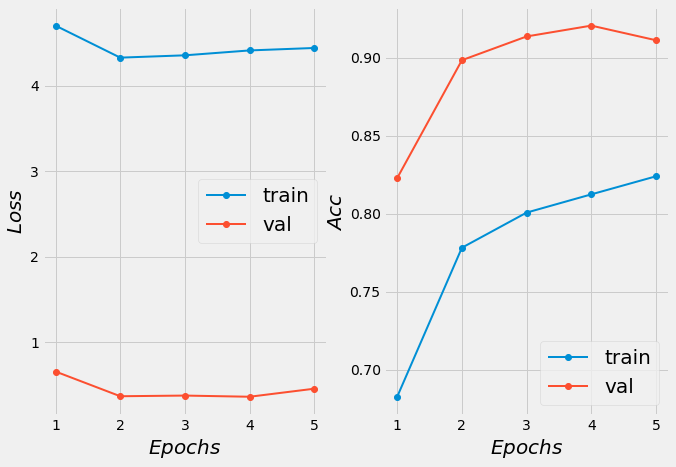

In [53]:
visualize_cost(loss_cache_train, acc_cache_train, loss_cache_val, acc_cache_val)

### Prepare test data

In [106]:
i=0
dir = './fruits-360_dataset/fruits-360/Test'
headerlist = ['image_name', 'target']
with open('./fruit_test.csv', 'w') as f:
  f.write(headerlist[0] + ',' + headerlist[1] + '\n')
  for folder in os.listdir(dir):
    folder_path = os.path.join(dir, folder)
    for image in os.listdir(folder_path):
      f.write(folder + '/' + image + ',' + str(i) + '\n')
    i+=1
print('Done.')

Done.


In [107]:
mean = torch.tensor([0.6840, 0.5786, 0.5037])
std = torch.tensor([0.3035, 0.3600, 0.3914])
batch_size = 64

In [108]:
test_trans = transforms.Compose([
                                  transforms.Resize((299, 299)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
])

In [109]:
dir = './fruits-360_dataset/fruits-360/Test'
test_csv = './fruit_test.csv'
test_dataset = FruitsDataset(csv_file=test_csv, root_dir=dir, transform=test_trans)
print(len(test_dataset))
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

22688


In [110]:
def get_predictions(loader, model):

  model.eval()

  predicted_class = np.array([])
  targets = np.array([])

  with torch.no_grad():
    for idx, (images, labels) in enumerate(loader):

      labelsnp = labels.cpu().numpy()
      targets = np.concatenate((targets, labelsnp), axis=None)

      images = images.to(device) # torch.Size([3, 3, 224, 224]) train_dataset
      labels = labels.to(device) # torch.Size([3])

      y_predicted = model(images) # torch.Size([3, 5])
      _, index = torch.max(y_predicted, 1)

      convert = index.cpu().numpy()
      predicted_class = np.concatenate((predicted_class, convert), axis=None)

  return targets, predicted_class

In [111]:
targets, preds = get_predictions(test_loader, model)

C:\Users\Lenovo\.conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [112]:
def visualize_model(labels_map, num_rows, num_cols, dataset, mean, std, predicted_class):

  plt.figure(figsize=(10, 10))

  for i in range(num_rows*num_cols):
    plt.subplot(num_rows, num_cols, i+1)
    index = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[index]
    image = image.cpu().numpy().transpose(1,2,0)
    image = image * np.array(std) + np.array(mean)
    # image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label.item() == predicted_class[index]:
      check = 'green'
    else: check = 'red'
    plt.title(f'Pred: {labels_map[predicted_class[index]]}', color='white',
              backgroundcolor=check, fontsize=15)

  plt.show()

### Check model performance: green for correct predictions, red for incorrect predictions

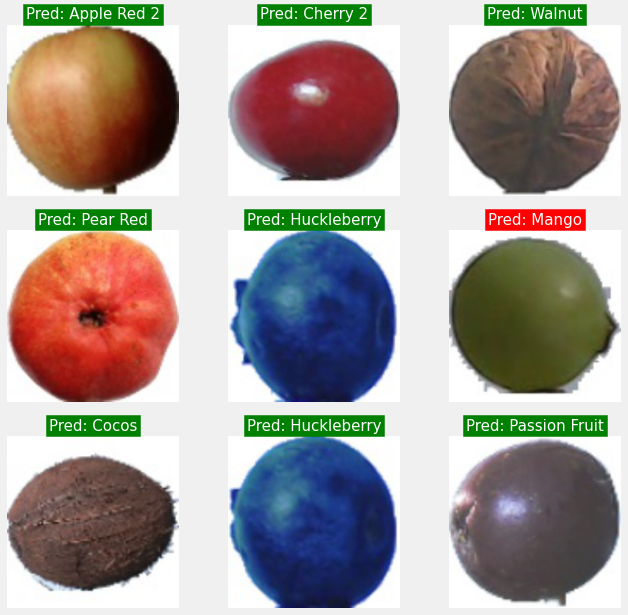

In [113]:
visualize_model(fruit_names, 3, 3, test_dataset, mean, std, preds)

In [114]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

         0.0       0.63      0.74      0.68       164
         1.0       1.00      0.07      0.14       148
         2.0       0.85      0.96      0.90       160
         3.0       0.80      0.85      0.82       164
         4.0       0.57      0.07      0.13       161
         5.0       0.92      0.67      0.77       164
         6.0       0.00      0.00      0.00       152
         7.0       0.30      0.83      0.44       164
         8.0       0.59      0.37      0.46       164
         9.0       0.53      1.00      0.69       144
        10.0       1.00      0.03      0.06       166
        11.0       0.81      0.35      0.49       164
        12.0       0.85      0.95      0.90       219
        13.0       1.00      0.55      0.71       164
        14.0       0.99      0.88      0.93       143
        15.0       0.99      0.63      0.77       166
        16.0       0.73      0.47      0.57       166
        17.0       0.79    

C:\Users\Lenovo\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
print(confusion_matrix(targets, preds))

[[122   0   0 ...   0   0   0]
 [  1  11   0 ...   0   0   0]
 [  0   0 153 ...   0   0   0]
 ...
 [  0   0   0 ... 146   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 157]]


In [116]:
def check_accuracy(loader, loader_dataset, model, labels_map):

  if loader == val_loader:
    print('Val Acc')
  elif loader == train_loader:
    print('Train Acc')
  else:
    print('Test Acc')

  running_corrects = 0
  num_samples = 0
  absent_class = []

  num_classes = len(list(labels_map.values()))

  n_correct_class = [0 for i in range(num_classes)]
  n_class_samples = [0 for i in range(num_classes)]

  model.eval()

  with torch.no_grad():

    for images, labels in loader:

      images = images.to(device)
      labels = labels.to(device)

      y_predicted = model(images)
      _, index = torch.max(y_predicted, 1)

      running_corrects += (index == labels.data).sum()

      temp_ = index.cpu().numpy()
      num_samples += temp_.shape[0]

      temp = labels.cpu().numpy()

      for i in range(temp.shape[0]):
        
        label = temp[i]
        index_i = temp_[i]

        if label == index_i:
          n_correct_class[label] += 1
        n_class_samples[label] += 1

    convert = running_corrects.double()
    acc = convert / len(loader_dataset)
    print(f'Got {int(convert.item())}/{num_samples} correct samples over {acc.item() * 100:.2f}%')

    for i in range(num_classes):
      if n_class_samples[i] != 0:
        acc_ = 100 * n_correct_class[i] / n_class_samples[i]
        print(f'Accuracy of {labels_map[i]}: {acc_:.2f}%')
      else:
        absent_class.append(i)
        print(f'Class {labels_map[i]} does not have its sample in this dataset.')

  return absent_class

In [117]:
check_accuracy(test_loader, test_dataset, model, fruit_names)

C:\Users\Lenovo\.conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Test Acc
Got 14573/22688 correct samples over 64.23%
Accuracy of Apple Braeburn: 74.39%
Accuracy of Apple Crimson Snow: 7.43%
Accuracy of Apple Golden 1: 95.62%
Accuracy of Apple Golden 2: 84.76%
Accuracy of Apple Golden 3: 7.45%
Accuracy of Apple Granny Smith: 67.07%
Accuracy of Apple Pink Lady: 0.00%
Accuracy of Apple Red 1: 82.93%
Accuracy of Apple Red 2: 37.20%
Accuracy of Apple Red 3: 100.00%
Accuracy of Apple Red Delicious: 3.01%
Accuracy of Apple Red Yellow 1: 34.76%
Accuracy of Apple Red Yellow 2: 95.43%
Accuracy of Apricot: 54.88%
Accuracy of Avocado: 88.11%
Accuracy of Avocado ripe: 63.25%
Accuracy of Banana: 46.99%
Accuracy of Banana Lady Finger: 99.34%
Accuracy of Banana Red: 99.40%
Accuracy of Beetroot: 29.33%
Accuracy of Blueberry: 88.96%
Accuracy of Cactus fruit: 88.55%
Accuracy of Cantaloupe 1: 100.00%
Accuracy of Cantaloupe 2: 19.51%
Accuracy of Carambula: 99.40%
Accuracy of Cauliflower: 95.30%
Accuracy of Cherry 1: 96.95%
Accuracy of Cherry 2: 100.00%
Accuracy of Cher

[]

In [79]:
from PIL import Image
from torchvision import transforms
img = Image.open('./test_imgs/apple.jfif')
tfms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
img_tensor = tfms(img).to('cuda').unsqueeze(0)

In [80]:
model.eval()              # turn the model to evaluate mode
with torch.no_grad():     # does not calculate gradient
    class_index = model(img_tensor).argmax()
int(class_index)

17

In [81]:
fruit_names[int(class_index)]

'Banana Lady Finger'

In [69]:
PATH = './model/my_model.pth'
torch.save(model.state_dict(), PATH)

In [118]:
torch.save(model, './model/googlenet.pt')

In [61]:
load_model_file = './model/resnet.pth'
state = torch.load(load_model_file)
model.load_state_dict(state['model_state_dict'])

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([71, 2048]) from checkpoint, the shape in current model is torch.Size([131, 2048]).
	size mismatch for fc.bias: copying a param with shape torch.Size([71]) from checkpoint, the shape in current model is torch.Size([131]).